# Multi matrix GAN

In [ ]:
import torch.multiprocessing as mp
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import pretty_midi
import random
import matplotlib.pyplot as plt
from DataLoading import MultiChannelLazyDataset, MultiChannelEagerDataset

# ==============================================================================
# Configuration Class
# ==============================================================================
class Config:
    def __init__(self, model_type='GAN'):
        # --- Path Configuration ---
        self.BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
        self.MASTER_LABEL_MAP_FILE = os.path.join(self.BASE_MATRIX_DIR, "master_label_map.json")
        if model_type not in ['GAN', 'RaGAN']: raise ValueError("model_type must be 'GAN' or 'RaGAN'")
        self.MODEL_TYPE = model_type
        self.MODEL_NAME = f"{model_type}" # Updated version name
        self.MODEL_SAVE_DIR = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", self.MODEL_NAME)
        self.SAMPLES_DIR = os.path.join(self.MODEL_SAVE_DIR, "samples")
        self.PLOT_SAVE_DIR = os.path.join(self.MODEL_SAVE_DIR, "plots")
        self.USED_NON_JAZZ_FILES_CSV = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", "used_non_jazz_for_gan_training.csv")
        self.PRETRAINED_CLASSIFIER_PATH = r"C:\Users\User\Desktop\college\fyp\models\classifier_model\jazz_classifier_balanced.pth"

        self.NUM_WORKERS = 10
        self.NOTE_ON_THRESHOLDS = [0.5]

        # --- Model & Training Hyperparameters ---
        self.PRETRAIN_EPOCHS = 10
        self.NUM_EPOCHS_ADVERSARIAL = 100
        self.WINDOW_SIZE = 64
        self.PITCHES = 88
        self.TIMESTEPS = 128
        self.CHANNELS = 3 
        self.NOISE_DIM = 100
        self.BATCH_SIZE = 128
        self.LR_G = 5e-4
        self.LR_D = 2e-4
        self.BETA1 = 0.5
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.SAVE_SAMPLE_EVERY_N_EPOCHS = 3
        self.SAVE_MODEL_EVERY_N_EPOCHS = 5
        self.G_TRAIN_STEPS = 5
        self.D_TRAIN_STEPS = 1
        self.LABEL_SMOOTHING = 0.2
        self.NOISE_STD = 0.7

        # --- Loss Weights ---
        self.LOSS_THRESHOLD_STEEPNESS = 15.0

        # Pre-training Weights
        self.PRETRAIN_W_CHROMA = 0.5
        self.PRETRAIN_W_STYLE = 0.1
        self.PRETRAIN_MUSICALITY = 0.4
        self.PRETRAIN_W_CHROMA_ONSET = 0.5
        self.PRETRAIN_W_CHROMA_SUSTAIN = 0.5
        
        # Granular weights for each musical rule
        self.W_PENALTY_IMPOSSIBLE = 0.5
        # self.W_PENALTY_ORPHAN_OFFSET = 0.3 # REMOVED
        self.W_PENALTY_ORPHAN_VELOCITY = 0.5
        self.W_MIN_NOTE_RATE = 1
        self.W_PENALTY_SILENT_ONSET =1

        # --- Target range note output structure ---
        self.MIN_NOTES_IN_WINDOW = 5
        self.SILENT_VELOCITY_THRESHOLD = 40

        # Adversarial Training Weights
        self.ADVERSARIAL_W_GAN = 0.8
        self.ADVERSARIAL_W_MUSICALITY = 0.2

        os.makedirs(self.MODEL_SAVE_DIR, exist_ok=True)
        os.makedirs(self.SAMPLES_DIR, exist_ok=True)
        os.makedirs(self.PLOT_SAVE_DIR, exist_ok=True)

# ==============================================================================
#Model Architectures 
# ==============================================================================
class JazzClassifierCNN(nn.Module): # This is the pre-trained style critic
    def __init__(self, in_channels=4): 
        super(JazzClassifierCNN,self).__init__()
        self.conv1=nn.Conv2d(in_channels, 32, kernel_size=(3,5), padding=(1,2))
        # self.conv1=nn.Conv2d(4,32,kernel_size=(3,5),padding=(1,2))
        self.bn1=nn.BatchNorm2d(32)
        self.pool1=nn.MaxPool2d(2)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.bn2=nn.BatchNorm2d(64);self.pool2=nn.MaxPool2d(2)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=2,dilation=2)
        self.bn3=nn.BatchNorm2d(128)
        self.global_avg_pool=nn.AdaptiveAvgPool2d((1,1))
        self.fc1=nn.Linear(128,256);self.dropout1=nn.Dropout(0.5)
        self.fc2=nn.Linear(256,128);self.dropout2=nn.Dropout(0.5)
        self.fc_out=nn.Linear(128,1)
    def forward(self,x):
        x=self.pool1(F.relu(self.bn1(self.conv1(x))))
        x=self.pool2(F.relu(self.bn2(self.conv2(x))))
        x=F.relu(self.bn3(self.conv3(x)))
        x=self.global_avg_pool(x)
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=self.dropout1(x)
        x=F.relu(self.fc2(x))
        x=self.dropout2(x)
        return self.fc_out(x)

# ==============================================================================
# U-Net Generator and Discriminator Architectures
# ==============================================================================

class UNetBlock(nn.Module):
    """Basic U-Net building block with skip connections"""
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        self.down = down
        
        if down:
            self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
            
        self.norm = nn.InstanceNorm2d(out_channels)
        self.dropout = nn.Dropout(0.5) if use_dropout else None
        
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        if self.dropout:
            x = self.dropout(x)
        return F.leaky_relu(x, 0.2) if self.down else F.relu(x)

class Generator(nn.Module):
    """
    U-Net Generator with noise injection and multi-channel output Maintains the same interface as the original Generator
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # --- ENCODER (Downsampling path) ---
        # Input: (B, 4, 88, 128)
        self.down1 = nn.Conv2d(config.CHANNELS, 64, 4, 2, 1)  # -> (B, 64, 44, 64)
        self.down2 = UNetBlock(64, 128, down=True)             # -> (B, 128, 22, 32)
        self.down3 = UNetBlock(128, 256, down=True)            # -> (B, 256, 11, 16)
        self.down4 = UNetBlock(256, 512, down=True)            # -> (B, 512, 5, 8)
        self.down5 = UNetBlock(512, 512, down=True)            # -> (B, 512, 2, 4)
        self.down6 = UNetBlock(512, 512, down=True)            # -> (B, 512, 1, 2)
        
        # --- BOTTLENECK with Noise Injection ---
        # Calculate the bottleneck feature size
        with torch.no_grad():
            dummy_input = torch.zeros(1, config.CHANNELS, config.PITCHES, config.TIMESTEPS)
            x = F.leaky_relu(self.down1(dummy_input), 0.2)
            x = self.down2(x)
            x = self.down3(x)
            x = self.down4(x)
            x = self.down5(x)
            bottleneck_out = self.down6(x)
            self.bottleneck_size = bottleneck_out.shape[1] * bottleneck_out.shape[2] * bottleneck_out.shape[3]
        
        # Noise projection layer to match bottleneck dimensions
        self.noise_projection = nn.Linear(config.NOISE_DIM, self.bottleneck_size)
        
        # Bottleneck processing
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.InstanceNorm2d(512),
            nn.ReLU(True)
        )
        
        # --- DECODER (Upsampling path with skip connections) ---
        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)     # -> (B, 512, 2, 4)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)    # -> (B, 512, ?, ?) 
        self.up3 = UNetBlock(1024, 256, down=False, use_dropout=True)    # -> (B, 256, ?, ?)
        self.up4 = UNetBlock(512, 128, down=False)                       # -> (B, 128, ?, ?)
        self.up5 = UNetBlock(256, 64, down=False)                        # -> (B, 64, ?, ?)
        
        # Final output layer
        self.final = nn.ConvTranspose2d(128, config.CHANNELS, 4, 2, 1)   # -> (B, 4, 88, 128)
        
    def forward(self, content_roll, noise):
        # --- ENCODER (with skip connection storage) ---
        # content_roll shape: (B, 4, 88, 128)
        e1 = F.leaky_relu(self.down1(content_roll), 0.2)  # (B, 64, 44, 64)
        e2 = self.down2(e1)                               # (B, 128, 22, 32)
        e3 = self.down3(e2)                               # (B, 256, 11, 16)
        e4 = self.down4(e3)                               # (B, 512, 5, 8)
        e5 = self.down5(e4)                               # (B, 512, 2, 4)
        e6 = self.down6(e5)                               # (B, 512, 1, 2)
        
        # --- NOISE INJECTION at bottleneck ---
        batch_size = content_roll.size(0)
        
        # Project noise to match bottleneck spatial dimensions
        noise_projected = self.noise_projection(noise)  # (B, bottleneck_size)
        noise_reshaped = noise_projected.view(batch_size, e6.shape[1], e6.shape[2], e6.shape[3])
        
        # Combine content features with noise
        bottleneck_input = e6 + noise_reshaped
        bottleneck_out = self.bottleneck(bottleneck_input)
        
        # --- DECODER (with skip connections and size matching) ---
        d1 = self.up1(bottleneck_out)                     # (B, 512, 2, 4)
        
        # Match sizes for skip connection using interpolation if needed
        if d1.shape[2:] != e5.shape[2:]:
            d1 = F.interpolate(d1, size=e5.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, e5], dim=1)                   # (B, 1024, 2, 4)
        
        d2 = self.up2(d1)                                 # (B, 512, ?, ?)
        if d2.shape[2:] != e4.shape[2:]:
            d2 = F.interpolate(d2, size=e4.shape[2:], mode='bilinear', align_corners=False)
        d2 = torch.cat([d2, e4], dim=1)                   # (B, 1024, 5, 8)
        
        d3 = self.up3(d2)                                 # (B, 256, ?, ?)
        if d3.shape[2:] != e3.shape[2:]:
            d3 = F.interpolate(d3, size=e3.shape[2:], mode='bilinear', align_corners=False)
        d3 = torch.cat([d3, e3], dim=1)                   # (B, 512, 11, 16)
        
        d4 = self.up4(d3)                                 # (B, 128, ?, ?)
        if d4.shape[2:] != e2.shape[2:]:
            d4 = F.interpolate(d4, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d4 = torch.cat([d4, e2], dim=1)                   # (B, 256, 22, 32)
        
        d5 = self.up5(d4)                                 # (B, 64, ?, ?)
        if d5.shape[2:] != e1.shape[2:]:
            d5 = F.interpolate(d5, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d5 = torch.cat([d5, e1], dim=1)                   # (B, 128, 44, 64)
        
        # --- FINAL OUTPUT ---
        raw_output = self.final(d5)                       # (B, 4, 88, 128)
        
        # Apply unified tanh activation 
        final_output = torch.sigmoid(raw_output)
        
        return final_output

class Discriminator(nn.Module):
    """
    U-Net style Discriminator for music classification Maintains the same interface as the original Discriminator
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # --- ENCODER PATH ---
        # Input: (B, 4, 88, 128)
        self.down1 = nn.Conv2d(config.CHANNELS, 64, 4, 2, 1)    # -> (B, 64, 44, 64)
        self.down2 = UNetBlock(64, 128, down=True)               # -> (B, 128, 22, 32)
        self.down3 = UNetBlock(128, 256, down=True)              # -> (B, 256, 11, 16)
        self.down4 = UNetBlock(256, 512, down=True)              # -> (B, 512, 5, 8)
        self.down5 = UNetBlock(512, 512, down=True)              # -> (B, 512, 2, 4)
        
        # --- FEATURE PROCESSING ---
        # Global average pooling for temporal aggregation
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
        
        # --- OPTIONAL: Add spatial attention mechanism ---
        self.attention = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.ReLU(True),
            nn.Conv2d(256, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # --- FEATURE EXTRACTION ---
        # x shape: (B, 4, 88, 128)
        x = F.leaky_relu(self.down1(x), 0.2)  # (B, 64, 44, 64)
        x = self.down2(x)                     # (B, 128, 22, 32)
        x = self.down3(x)                     # (B, 256, 11, 16)
        x = self.down4(x)                     # (B, 512, 5, 8)
        features = self.down5(x)              # (B, 512, 2, 4)
        
        # --- ATTENTION MECHANISM (optional enhancement) ---
        attention_weights = self.attention(features)  # (B, 1, 2, 4)
        attended_features = features * attention_weights  # Weighted features
        
        # --- GLOBAL POOLING AND CLASSIFICATION ---
        pooled = self.global_avg_pool(attended_features)  # (B, 512, 1, 1)
        flattened = pooled.view(pooled.size(0), -1)       # (B, 512)
        
        output = self.classifier(flattened)               # (B, 1)
        
        return output


# ==============================================================================
# Data Handling and Utility Functions
# ==============================================================================
class DataHandler:
    def __init__(self, config):
        self.config = config
    
    def get_data_files(self):
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        
        all_jazz_relative = [p for p, l in label_map.items() if l == 1]
        random.shuffle(all_jazz_relative)
        all_jazz_relative = all_jazz_relative[:1000] 
        all_jazz_full_path = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in all_jazz_relative]

        # handle the non-jazz files based on whether the CSV exists
        if os.path.exists(self.config.USED_NON_JAZZ_FILES_CSV):
            # --- "RESUME" MODE ---
            print(f"Found existing file list at: {self.config.USED_NON_JAZZ_FILES_CSV}. Loading from CSV.")
            used_files_df = pd.read_csv(self.config.USED_NON_JAZZ_FILES_CSV)
            used_files_relative_paths = used_files_df['filepath'].tolist()
            
            # Reconstruct the full paths from the relative paths stored in the CSV
            non_jazz_for_g = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in used_files_relative_paths]
            print(f"Successfully loaded {len(non_jazz_for_g)} non-jazz file paths.")

        else:
            # --- "FIRST RUN" MODE ---
            print("No existing file list found. Creating a new random split for non-jazz files...")
            
            all_non_jazz_relative = [p for p, l in label_map.items() if l == 0]
            all_non_jazz_full_path = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in all_non_jazz_relative]

            target_non_jazz_count = int(len(all_jazz_full_path) * (0.3 / 0.7))
            num_non_jazz_to_use = min(len(all_non_jazz_full_path), target_non_jazz_count)

            random.shuffle(all_non_jazz_full_path)
            non_jazz_for_g = all_non_jazz_full_path[:num_non_jazz_to_use]
            
            # Save the list of used non-jazz files to a CSV for future runs
            print(f"Saving list of {len(non_jazz_for_g)} non-jazz files used for GAN training...")
            used_files_relative_paths = [os.path.relpath(p, self.config.BASE_MATRIX_DIR).replace('\\', '/') for p in non_jazz_for_g]
            used_files_df = pd.DataFrame(used_files_relative_paths, columns=["filepath"])
            used_files_df.to_csv(self.config.USED_NON_JAZZ_FILES_CSV, index=False)
            print(f"List saved to: {self.config.USED_NON_JAZZ_FILES_CSV}")

        return all_jazz_full_path, non_jazz_for_g
    
class MusicalityAndChromaLosses:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.pitches = config.PITCHES
        self.timesteps = config.TIMESTEPS
        self.pitch_to_chroma_map = self._create_pitch_to_chroma_map().to(self.device)
        self.window_size = config.WINDOW_SIZE
        self.k = config.LOSS_THRESHOLD_STEEPNESS

    def _create_pitch_to_chroma_map(self):
        midi_pitches = torch.arange(21, 21 + self.pitches)
        chroma_indices = midi_pitches % 12
        pitch_to_chroma_map = torch.zeros(12, self.pitches)
        for i in range(self.pitches):
            pitch_to_chroma_map[chroma_indices[i], i] = 1.0
        return pitch_to_chroma_map
    
    def _apply_soft_threshold(self, probabilities):
        return torch.sigmoid(self.k * (probabilities - 0.5))

    def calculate_type_aware_chroma_loss(self, original_batch, generated_batch):
        original_onsets = (original_batch[:, 0, :, :] > 0.5).float()
        generated_onsets_probs = generated_batch[:, 0, :, :]
        original_onset_chroma = torch.matmul(self.pitch_to_chroma_map, original_onsets)
        generated_onset_chroma = torch.matmul(self.pitch_to_chroma_map, generated_onsets_probs)
        original_onset_dist = F.normalize(original_onset_chroma, p=1, dim=1, eps=1e-8)
        generated_onset_dist = F.normalize(generated_onset_chroma, p=1, dim=1, eps=1e-8)
        log_gen_onset_dist = torch.log(generated_onset_dist + 1e-8)
        onset_loss = F.kl_div(log_gen_onset_dist, original_onset_dist, reduction='batchmean')

        original_sustains = (original_batch[:, 1, :, :] > 0.5).float()
        generated_sustains_probs = generated_batch[:, 1, :, :]
        original_sustain_chroma = torch.matmul(self.pitch_to_chroma_map, original_sustains)
        generated_sustain_chroma = torch.matmul(self.pitch_to_chroma_map, generated_sustains_probs)
        original_sustain_dist = F.normalize(original_sustain_chroma, p=1, dim=1, eps=1e-8)
        generated_sustain_dist = F.normalize(generated_sustain_chroma, p=1, dim=1, eps=1e-8)
        log_gen_sustain_dist = torch.log(generated_sustain_dist + 1e-8)
        sustain_loss = F.kl_div(log_gen_sustain_dist, original_sustain_dist, reduction='batchmean')
        
        return onset_loss, sustain_loss

    def calculate_impossible_note_penalty(self, generated_batch):
        onset_probs = generated_batch[:, 0, :, :]
        sustain_probs = generated_batch[:, 1, :, :]
        no_sustain_probs = 1.0 - sustain_probs
        impossible_event_probs = onset_probs * no_sustain_probs
        return torch.mean(impossible_event_probs)

    def calculate_silent_onset_penalty(self, generated_batch):
        onset_probs = generated_batch[:, 0, :, :]
        velocity_probs = generated_batch[:, 2, :, :]
        v_thresh_norm = self.config.SILENT_VELOCITY_THRESHOLD / 127.0
        prob_is_silent = 1.0 - torch.sigmoid(self.k * (velocity_probs - v_thresh_norm))
        silent_onset_event_probs = onset_probs * prob_is_silent
        return torch.mean(silent_onset_event_probs)

    def calculate_orphan_velocity_penalty(self, generated_batch):
        onset_probs = generated_batch[:, 0, :, :]
        velocity_probs = generated_batch[:, 2, :, :]
        no_onset_probs = 1.0 - onset_probs
        orphan_event_probs = velocity_probs * no_onset_probs
        return torch.mean(orphan_event_probs)

    # REMOVED: calculate_orphan_offset_penalty method was here

    def _get_confident_notes_in_window(self, generated_batch):
        onset_probs = generated_batch[:, 0:1, :, :]
        soft_onsets = self._apply_soft_threshold(onset_probs)
        onsets_per_timestep = torch.sum(soft_onsets, dim=2)
        kernel = torch.ones(1, 1, self.window_size, device=self.device)
        return F.conv1d(onsets_per_timestep, kernel, padding='same')

    def calculate_min_notes_penalty(self, notes_in_window_sum, min_notes_threshold):
        violations = F.relu(min_notes_threshold - notes_in_window_sum)
        return torch.mean(violations)

    def get_musicality_losses(self, generated_batch):
        confident_notes_in_window = self._get_confident_notes_in_window(generated_batch)
        losses = {
            'impossible': self.calculate_impossible_note_penalty(generated_batch),
            'silent_onset': self.calculate_silent_onset_penalty(generated_batch),
            'orphan_velocity': self.calculate_orphan_velocity_penalty(generated_batch),
            # 'orphan_offset': self.calculate_orphan_offset_penalty(generated_batch), # REMOVED
            'min_rate': self.calculate_min_notes_penalty(confident_notes_in_window, self.config.MIN_NOTES_IN_WINDOW),
        }

        # total_weighted_loss no longer includes orphan_offset
        total_weighted_loss = (
            self.config.W_PENALTY_IMPOSSIBLE * losses['impossible'] +
            self.config.W_PENALTY_SILENT_ONSET * losses['silent_onset'] +
            self.config.W_PENALTY_ORPHAN_VELOCITY * losses['orphan_velocity'] +
            self.config.W_MIN_NOTE_RATE * losses['min_rate']  
        )
        return losses, total_weighted_loss
    
def plot_piano_roll(matrices, threshold):
    """
    Plots and saves a piano roll visualization from the reconstructed matrices.
    """
    onset_matrix = matrices["onset"]
    sustain_matrix = matrices["sustain"]

    # Combine onsets and sustains for a full note view
    full_note_matrix = np.logical_or(onset_matrix, sustain_matrix).astype(int)

    plt.figure(figsize=(16, 8))
    plt.imshow(full_note_matrix, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Piano Roll for Threshold: {threshold}')
    plt.xlabel('Time Steps')
    plt.ylabel('Pitch (MIDI Note - 21)')
    plt.colorbar(label='Note Active')
    plt.grid(False) # Turn off grid for a cleaner look
    plt.show()

def plot_original_content(content_tensor, title="Original Content for Sample Generation"):
    """
    Plots the piano roll of the original content tensor used for conditioning the generator.
    Assumes the input is a single item from the dataloader batch.
    """
    print(f"--- Visualizing: {title} ---")
    
    # Ensure tensor is on CPU and converted to a NumPy array for plotting
    if torch.is_tensor(content_tensor):
        content_tensor = content_tensor.cpu().numpy()

    # The input tensor from the dataloader has shape (Channels, Pitches, Timesteps)
    # e.g., (4, 88, 128)
    
    # Extract the onset (channel 0) and sustain (channel 1) matrices.
    # The data from the dataloader is already binary (0s and 1s).
    onset_matrix = content_tensor[0]
    sustain_matrix = content_tensor[1]

    # Combine onsets and sustains for a full note view, same as in the other plot
    full_note_matrix = np.logical_or(onset_matrix, sustain_matrix).astype(int)

    plt.figure(figsize=(16, 8))
    plt.imshow(full_note_matrix, aspect='auto', origin='lower', cmap='plasma') # Using a different colormap to distinguish
    plt.title(title, fontsize=16)
    plt.xlabel('Time Steps')
    plt.ylabel('Pitch (MIDI Note - 21)')
    plt.colorbar(label='Note Active')
    plt.grid(False)
    plt.show()

def plot_generator_output_matrices(onset_probs, sustain_probs, velocity_values, title="Generator Raw Output Probabilities"):
    """
    Visualizes the three output channels of the generator as heatmaps.
    """
    print(f"--- Visualizing: {title} ---")

    fig, axs = plt.subplots(1, 3, figsize=(24, 7)) # Changed to 1x3 layout
    fig.suptitle(title, fontsize=18)

    # --- Plot Onset Probabilities ---
    im1 = axs[0].imshow(onset_probs.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title('Channel 0: Onset Probabilities')
    axs[0].set_ylabel('Pitch')
    axs[0].set_xlabel('Time Steps')
    fig.colorbar(im1, ax=axs[0])

    # --- Plot Sustain Probabilities ---
    im2 = axs[1].imshow(sustain_probs.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title('Channel 1: Sustain Probabilities')
    axs[1].set_xlabel('Time Steps')
    fig.colorbar(im2, ax=axs[1])

    # --- Plot Velocity Values ---
    im3 = axs[2].imshow(velocity_values.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title('Channel 2: Velocity Values')
    axs[2].set_xlabel('Time Steps')
    fig.colorbar(im3, ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def reconstruct_and_save_midi(generated_tensor, path, config, bpm=120.0):
    """
    Converts a 3-channel tensor into a MIDI file and returns the final
    binary/value matrices. No longer processes the offset channel.
    """
    if generated_tensor.ndim != 4 or generated_tensor.shape[1] != 3: # Check for 3 channels
        print(f"Warning: Invalid tensor shape provided for MIDI reconstruction. Expected 3 channels, got {generated_tensor.shape[1]}. Skipping.")
        return None

    sample_tensor = generated_tensor[0]
    # Only unpack 3 channels
    onsets_sustains_velocity = sample_tensor[0:3]
    
    # We transpose to get (Timesteps, Pitches) format
    onset_probs_np = onsets_sustains_velocity[0].T
    sustain_probs_np = onsets_sustains_velocity[1].T
    velocity_values_np = onsets_sustains_velocity[2].T

    plot_generator_output_matrices(onset_probs_np, sustain_probs_np, velocity_values_np, title=f"Generator Raw Output for Sample: {os.path.basename(path)}")

    all_final_matrices = {}

    for threshold in config.NOTE_ON_THRESHOLDS:
        reconstructed_onset = np.zeros_like(onset_probs_np)
        reconstructed_sustain = np.zeros_like(sustain_probs_np)
        reconstructed_velocity = np.zeros_like(velocity_values_np)

        pm = pretty_midi.PrettyMIDI(initial_tempo=bpm)
        instrument = pretty_midi.Instrument(program=0, name='Acoustic Grand Piano')
        RESOLUTION = 24
        PITCHES_LOW = 21
        tick_duration = 60.0 / (bpm * RESOLUTION)
        min_duration = tick_duration / 2
        active_notes = {}

        for t_step in range(config.TIMESTEPS):
            for pitch_idx in range(config.PITCHES):
                if pitch_idx not in active_notes and onset_probs_np[t_step, pitch_idx] > threshold:
                    # start_time is now simply quantized
                    start_time = t_step * tick_duration
                    velocity_val = velocity_values_np[t_step, pitch_idx]
                    velocity = int(velocity_val * 126) + 1
                    active_notes[pitch_idx] = (start_time, velocity, t_step)
                    reconstructed_onset[t_step, pitch_idx] = 1
                    reconstructed_velocity[t_step, pitch_idx] = velocity_val

                elif pitch_idx in active_notes and sustain_probs_np[t_step, pitch_idx] < threshold:
                    start_time, velocity, start_t_step = active_notes.pop(pitch_idx)
                    end_time = t_step * tick_duration
                    if end_time - start_time < min_duration:
                        end_time = start_time + min_duration
                    instrument.notes.append(pretty_midi.Note(
                        velocity=max(1, min(127, velocity)),
                        pitch=pitch_idx + PITCHES_LOW,
                        start=start_time,
                        end=end_time
                    ))
                    reconstructed_sustain[start_t_step:t_step, pitch_idx] = 1

        for pitch_idx, (start_time, velocity, start_t_step) in active_notes.items():
            end_time = config.TIMESTEPS * tick_duration
            if end_time - start_time < min_duration:
                end_time = start_time + min_duration
            instrument.notes.append(pretty_midi.Note(
                velocity=max(1, min(127, velocity)),
                pitch=pitch_idx + PITCHES_LOW,
                start=start_time,
                end=end_time
            ))
            reconstructed_sustain[start_t_step:config.TIMESTEPS, pitch_idx] = 1

        pm.instruments.append(instrument)
        file_path = f"{path}_thresh_{threshold:.2f}.mid"
        pm.write(file_path)

        final_matrices = {
            "onset": reconstructed_onset.T,
            "sustain": reconstructed_sustain.T,
            "velocity": reconstructed_velocity.T,
        }
        all_final_matrices[threshold] = final_matrices

    return all_final_matrices

def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(g_losses, label="Generator")
    plt.plot(d_losses, label="Discriminator")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# ==============================================================================
# The GANTrainer Class
# ==============================================================================
class GANTrainer:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE

        self.generator = Generator(config).to(self.device)
        self.discriminator = Discriminator(config).to(self.device)

        self.style_classifier = self._load_style_classifier()
        self.loss_calculator = MusicalityAndChromaLosses(config)

        self.opt_g = optim.Adam(self.generator.parameters(), lr=config.LR_G, betas=(config.BETA1, 0.999))
        self.opt_d = optim.Adam(self.discriminator.parameters(), lr=config.LR_D, betas=(config.BETA1, 0.999))

        self.g_losses = []
        self.d_losses = []
        self.pretrain_loss_history = []
        self.adversarial_loss_history = []

    def save_checkpoint(self, epoch, is_pretrain=False):
        filename = "generator_pretrained.pth" if is_pretrain else f"checkpoint_epoch_{epoch}.pth"
        checkpoint_path = os.path.join(self.config.MODEL_SAVE_DIR, filename)
        print(f"--- Saving checkpoint to {checkpoint_path} ---")
        if is_pretrain:
            torch.save(self.generator.state_dict(), checkpoint_path)
        else:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': self.generator.state_dict(),
                'discriminator_state_dict': self.discriminator.state_dict(),
                'optimizer_g_state_dict': self.opt_g.state_dict(),
                'optimizer_d_state_dict': self.opt_d.state_dict(),
                'g_losses': self.g_losses,
                'd_losses': self.d_losses,
            }, checkpoint_path)

    def _load_style_classifier(self):
        print("Loading Style Classifier (4-channel)...")
        classifier = JazzClassifierCNN().to(self.device)
        classifier.load_state_dict(torch.load(self.config.PRETRAINED_CLASSIFIER_PATH, map_location=self.device))
        classifier.eval()
        for param in classifier.parameters():
            param.requires_grad = False
        print("Style classifier loaded and frozen.")
        return classifier
    
    def pretrain_generator(self, content_loader):
        print("\n--- STAGE: Pre-training Generator ---")
        style_crit = nn.BCEWithLogitsLoss()
        
        fixed_content_iter = iter(content_loader)
        # Slice the fixed content to 3 channels for the generator
        fixed_content_full = next(fixed_content_iter)[0]
        fixed_content_for_g = fixed_content_full[:, :3, :, :].to(self.device)
        fixed_noise_for_pretrain_sample = torch.randn(fixed_content_for_g.size(0), self.config.NOISE_DIM, device=self.device)
        
        # We can still plot the original 4-channel data for comparison
        plot_original_content(fixed_content_full[0], title="Original Content for Pre-Train Sample")
        
        self.generator.train()
        self.style_classifier.eval()

        for epoch in range(self.config.PRETRAIN_EPOCHS):
            # Removed orphan_offset from tracked losses
            epoch_losses = {
                'total': 0.0, 'chroma': 0.0, 'style': 0.0,'impossible': 0.0, 'silent_onset': 0.0,'orphan_velocity': 0.0, 'min_rate':0.0
            }
            
            pbar = tqdm(content_loader, desc=f"Pre-Train Epoch {epoch+1}/{self.config.PRETRAIN_EPOCHS}")

            for content_batch_full in pbar:
                # Slice the batch to 3 channels before feeding to generator
                content_batch = content_batch_full[0][:, :3, :, :].to(self.device)
                noise = torch.randn(content_batch.size(0), self.config.NOISE_DIM, device=self.device)
                
                self.opt_g.zero_grad()
                # Generator now outputs a 3-channel tensor
                raw_generated_3_chan = self.generator(content_batch, noise)
                
                # --- Create 4-channel tensor for the style classifier ---
                # Create a dummy offset channel with zeros
                dummy_offset = torch.zeros_like(raw_generated_3_chan[:, 0:1, :, :])
                # Concatenate to form a 4-channel tensor
                raw_generated_4_chan = torch.cat([raw_generated_3_chan, dummy_offset], dim=1)
                
                binarized_for_style = (raw_generated_4_chan > 0.5).float() - raw_generated_4_chan.detach() + raw_generated_4_chan

                # Loss calculations use the 3-channel output
                loss_chroma_onset, loss_chroma_sustain = self.loss_calculator.calculate_type_aware_chroma_loss(content_batch, raw_generated_3_chan)
                loss_chroma = (self.config.PRETRAIN_W_CHROMA_ONSET * loss_chroma_onset +
                               self.config.PRETRAIN_W_CHROMA_SUSTAIN * loss_chroma_sustain)
                
                # Style loss uses the reconstructed 4-channel tensor
                style_logits = self.style_classifier(binarized_for_style)
                loss_style = style_crit(style_logits, torch.ones_like(style_logits))
                
                musicality_losses, weighted_musicality_loss = self.loss_calculator.get_musicality_losses(raw_generated_3_chan)

                combined_loss = (self.config.PRETRAIN_W_CHROMA * loss_chroma +
                                 self.config.PRETRAIN_W_STYLE * loss_style +
                                 self.config.PRETRAIN_MUSICALITY * weighted_musicality_loss)
                
                combined_loss.backward()
                self.opt_g.step()
                
                epoch_losses['total'] += combined_loss.item()
                epoch_losses['chroma'] += loss_chroma.item()
                epoch_losses['style'] += loss_style.item()
                epoch_losses['impossible'] += musicality_losses['impossible'].item()
                epoch_losses['silent_onset'] += musicality_losses['silent_onset'].item()
                epoch_losses['orphan_velocity'] += musicality_losses['orphan_velocity'].item()
                epoch_losses['min_rate'] += musicality_losses['min_rate'].item()

                pbar.set_postfix(
                    chroma= f"{loss_chroma.item():.4f}",
                    style = f"{loss_style.item():.4f}",
                    impossible = f"{musicality_losses['impossible'].item():.4f}",
                    silent = f"{musicality_losses['silent_onset'].item():.4f}",
                    orphan_velocity = f"{musicality_losses['orphan_velocity'].item():.4f}",
                    min_rate = f"{musicality_losses['min_rate'].item():.4f}",
                )
            
            num_batches = len(content_loader)
            avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
            self.pretrain_loss_history.append(avg_losses)
            
            print(f"  Pre-Train Epoch {epoch+1} ->  Avg Total Loss: {avg_losses['total']:.4f}")
            print(f"    Avg Component Losses -> Chroma: {avg_losses['chroma']:.4f}, Style: {avg_losses['style']:.4f}")
            print(f"    Avg Musicality -> Impossible: {avg_losses['impossible']:.4f}, Silent: {avg_losses['silent_onset']:.4f}, Orphan Velo: {avg_losses['orphan_velocity']:.4f}, "
                  f"Min Rate: {avg_losses['min_rate']:.4f} \n" )
        
        print("\nGenerating and analyzing a final sample from the pre-trained generator...")
        self.generator.eval()
        with torch.no_grad():
            generated_sample_tensor_np = self.generator(
                fixed_content_for_g, # Use the 3-channel fixed content
                fixed_noise_for_pretrain_sample
            ).detach().cpu().numpy()

        sample_base_path = os.path.join(self.config.SAMPLES_DIR, "sample_after_pretrain")
        reconstruct_and_save_midi(generated_sample_tensor_np, sample_base_path, self.config)
        self.save_checkpoint(epoch='pretrained', is_pretrain=True)
        self.generator.train()

    def train_adversarially(self, real_loader, content_loader):
        print(f"\n--- STAGE: Adversarial Training ({self.config.MODEL_TYPE}) ---")
        criterion = nn.BCEWithLogitsLoss()

        fixed_content_iter = iter(content_loader)
        # Slice fixed content to 3 channels for sample generation
        fixed_content = next(fixed_content_iter)[0][:, :3, :, :].to(self.device)
        fixed_noise = torch.randn(fixed_content.size(0), self.config.NOISE_DIM, device=self.device)

        for epoch in range(self.config.NUM_EPOCHS_ADVERSARIAL):
            real_iter = iter(real_loader)
            content_iter = iter(content_loader)
            num_batches = min(len(real_loader), len(content_loader))
            
            epoch_g_losses = {
                'total': 0.0, 'gan': 0.0,'impossible': 0.0, 'silent_onset':0.0, 'orphan_velocity': 0.0, 'min_rate': 0.0
            }
            epoch_d_losses = {'total': 0.0}
            
            pbar = tqdm(range(num_batches), desc=f"Adv. Epoch {epoch+1}/{self.config.NUM_EPOCHS_ADVERSARIAL}")
            
            for i in pbar:
                for _ in range(self.config.G_TRAIN_STEPS):
                    try:
                        # Slice content samples to 3 channels
                        content_samples = next(content_iter)[0][:, :3, :, :].to(self.device)
                    except StopIteration:
                        content_iter = iter(content_loader)
                        content_samples = next(content_iter)[0][:, :3, :, :].to(self.device)
                
                    noise = torch.randn(content_samples.size(0), self.config.NOISE_DIM, device=self.device) * self.config.NOISE_STD
                    
                    self.opt_g.zero_grad()
                    fake_samples_g_raw = self.generator(content_samples, noise)
                    fake_logits_g = self.discriminator(fake_samples_g_raw)
                    
                    if self.config.MODEL_TYPE == 'RaGAN':
                        with torch.no_grad():
                            try:
                                # Slice real samples to 3 channels
                                real_samples_for_g = next(real_iter)[0][:, :3, :, :].to(self.device)
                            except StopIteration:
                                real_iter = iter(real_loader)
                                real_samples_for_g = next(real_iter)[0][:, :3, :, :].to(self.device)
                            real_logits_g = self.discriminator(real_samples_for_g)
                        gan_loss = criterion(fake_logits_g - real_logits_g.mean(), torch.ones_like(fake_logits_g))
                    else:
                        gan_loss  = criterion(fake_logits_g, torch.ones_like(fake_logits_g))
                        
                    musicality_losses, weighted_musicality_loss = self.loss_calculator.get_musicality_losses(fake_samples_g_raw)
                    g_loss = (self.config.ADVERSARIAL_W_GAN * gan_loss +
                              self.config.ADVERSARIAL_W_MUSICALITY * weighted_musicality_loss)
                    g_loss.backward()
                    self.opt_g.step()

                for _ in range(self.config.D_TRAIN_STEPS):
                    try:
                        # Slice real and content samples to 3 channels
                        real_samples = next(real_iter)[0][:, :3, :, :].to(self.device)
                        content_samples_for_d = next(content_iter)[0][:, :3, :, :].to(self.device)[:real_samples.size(0)]
                    except StopIteration:
                        real_iter = iter(real_loader)
                        content_iter = iter(content_loader)
                        real_samples = next(real_iter)[0][:, :3, :, :].to(self.device)
                        content_samples_for_d = next(content_iter)[0][:, :3, :, :].to(self.device)[:real_samples.size(0)]

                    noise_d = torch.randn(content_samples_for_d.size(0), self.config.NOISE_DIM, device=self.device)
                    self.opt_d.zero_grad()
                    with torch.no_grad():
                        fake_samples = self.generator(content_samples_for_d, noise_d)
                    
                    real_logits = self.discriminator(real_samples)
                    fake_logits = self.discriminator(fake_samples.detach())
                    
                    real_label = 1.0 - self.config.LABEL_SMOOTHING
                    fake_label = 0.0 + self.config.LABEL_SMOOTHING

                    if self.config.MODEL_TYPE == 'RaGAN':
                        loss_real = criterion(real_logits - fake_logits.mean(), torch.full_like(real_logits, real_label))
                        loss_fake = criterion(fake_logits - real_logits.mean(), torch.full_like(fake_logits, fake_label))
                    else:
                        loss_real = criterion(real_logits, torch.full_like(real_logits, real_label))
                        loss_fake = criterion(fake_logits, torch.full_like(fake_logits, fake_label))
                    
                    d_loss = (loss_real + loss_fake) / 2
                    d_loss.backward()
                    self.opt_d.step()
                
                epoch_g_losses['total'] += g_loss.item()
                epoch_g_losses['gan'] += gan_loss.item()
                epoch_g_losses['impossible'] += musicality_losses['impossible'].item()
                epoch_g_losses['silent_onset'] += musicality_losses['silent_onset'].item()
                epoch_g_losses['orphan_velocity'] += musicality_losses['orphan_velocity'].item()
                # REMOVED: orphan_offset
                epoch_g_losses['min_rate'] += musicality_losses['min_rate'].item()
                epoch_d_losses['total'] += d_loss.item()
                
                pbar.set_postfix(G_Loss=f"{g_loss.item():.4f}", D_Loss=f"{d_loss.item():.4f}", Musicality=f'{weighted_musicality_loss.item():.4f}')
            
            num_batches = min(len(real_loader), len(content_loader))
            avg_g_losses_detailed = {k: v / num_batches for k, v in epoch_g_losses.items()}
            avg_d_loss = epoch_d_losses['total'] / num_batches
            
            self.g_losses.append(avg_g_losses_detailed['total'])
            self.d_losses.append(avg_d_loss)
            self.adversarial_loss_history.append({'G': avg_g_losses_detailed, 'D': {'total': avg_d_loss}})
            
            print(f"\nAdversarial Epoch {epoch+1} Summary:")
            print(f"  Generator Losses -> Total: {avg_g_losses_detailed['total']:.4f}, GAN: {avg_g_losses_detailed['gan']:.4f}")
            # Final print no longer shows orphan_offset
            print(f"  G Musicality -> Impossible: {avg_g_losses_detailed['impossible']:.4f}, Silent: {avg_g_losses_detailed['silent_onset']:.4f}" 
                  f" Orphan Velo: {avg_g_losses_detailed['orphan_velocity']:.4f}, Min Rate: {avg_g_losses_detailed['min_rate']:.4f}")
            print(f"  Discriminator Loss -> Total: {avg_d_loss:.4f} \n")

            if (epoch + 1) % self.config.SAVE_SAMPLE_EVERY_N_EPOCHS == 0:
                self.generator.eval()
                with torch.no_grad():
                    generated_sample_tensor = self.generator(fixed_content, fixed_noise).detach().cpu().numpy()
                reconstruct_and_save_midi(generated_sample_tensor,
                                          os.path.join(self.config.SAMPLES_DIR, f"sample_epoch_{epoch+1}"), self.config)
                self.generator.train()

            if (epoch + 1) % self.config.SAVE_MODEL_EVERY_N_EPOCHS == 0:
                self.save_checkpoint(epoch + 1)

## GAN Training

--- Running with fixed random seed: 42 ---
Found existing file list at: C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_gan_training.csv. Loading from CSV.
Successfully loaded 428 non-jazz file paths.

--- Creating Datasets and DataLoaders ---
Scanning files to create segment pointers for 'Real Jazz (for D)'...
Scan complete. Found 69341 total segments.
EAGERLY loading all multi-channel segments for 'Non-Jazz (for G)' into RAM...


Loading files: 100%|██████████| 428/428 [00:03<00:00, 108.74it/s]


Eager loading complete. Total segments: 25371. Shape: (25371, 4, 88, 128)
Loading Style Classifier (4-channel)...
Style classifier loaded and frozen.
Starting Generator Pre-training...

--- STAGE: Pre-training Generator ---
--- Visualizing: Original Content for Pre-Train Sample ---


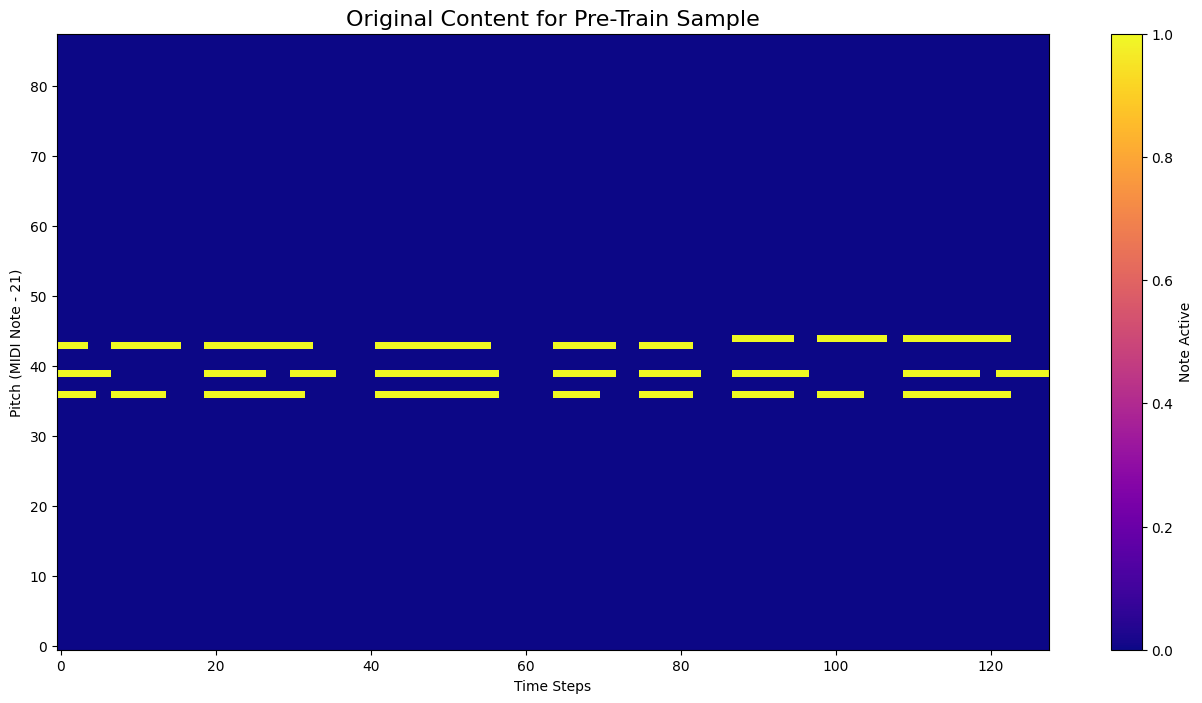

Pre-Train Epoch 1/10:   0%|          | 0/199 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_2184\2216630452.py:431: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(onsets_per_timestep, kernel, padding='same')
Pre-Train Epoch 1/10: 100%|██████████| 199/199 [01:33<00:00,  2.12it/s, chroma=2.9280, impossible=0.0870, min_rate=0.0000, orphan_velocity=0.3121, silent=0.0774, style=1.8428] 


  Pre-Train Epoch 1 ->  Avg Total Loss: 9.6952
    Avg Component Losses -> Chroma: 18.6438, Style: 2.6110
    Avg Musicality -> Impossible: 0.1309, Silent: 0.0905, Orphan Velo: 0.2491, Min Rate: 0.0000 



Pre-Train Epoch 2/10: 100%|██████████| 199/199 [01:34<00:00,  2.10it/s, chroma=1.2118, impossible=0.0717, min_rate=0.0000, orphan_velocity=0.2173, silent=0.0731, style=0.4731]


  Pre-Train Epoch 2 ->  Avg Total Loss: 0.9958
    Avg Component Losses -> Chroma: 1.6499, Style: 0.7237
    Avg Musicality -> Impossible: 0.0838, Silent: 0.0805, Orphan Velo: 0.2479, Min Rate: 0.0000 



Pre-Train Epoch 3/10: 100%|██████████| 199/199 [01:27<00:00,  2.26it/s, chroma=0.2092, impossible=0.0614, min_rate=0.0000, orphan_velocity=0.2230, silent=0.0633, style=0.0405]


  Pre-Train Epoch 3 ->  Avg Total Loss: 0.3457
    Avg Component Losses -> Chroma: 0.4457, Style: 0.3706
    Avg Musicality -> Impossible: 0.0663, Silent: 0.0681, Orphan Velo: 0.2265, Min Rate: 0.0000 



Pre-Train Epoch 4/10: 100%|██████████| 199/199 [01:27<00:00,  2.26it/s, chroma=0.5609, impossible=0.0593, min_rate=0.0000, orphan_velocity=0.2331, silent=0.0617, style=0.2055]


  Pre-Train Epoch 4 ->  Avg Total Loss: 0.2070
    Avg Component Losses -> Chroma: 0.2205, Style: 0.2234
    Avg Musicality -> Impossible: 0.0512, Silent: 0.0532, Orphan Velo: 0.2141, Min Rate: 0.0000 



Pre-Train Epoch 5/10: 100%|██████████| 199/199 [01:22<00:00,  2.41it/s, chroma=0.1969, impossible=0.0555, min_rate=0.0000, orphan_velocity=0.2415, silent=0.0591, style=0.0695]


  Pre-Train Epoch 5 ->  Avg Total Loss: 0.1873
    Avg Component Losses -> Chroma: 0.1605, Style: 0.3064
    Avg Musicality -> Impossible: 0.0504, Silent: 0.0527, Orphan Velo: 0.2262, Min Rate: 0.0000 



Pre-Train Epoch 6/10: 100%|██████████| 199/199 [01:18<00:00,  2.52it/s, chroma=2.6554, impossible=0.0772, min_rate=0.0000, orphan_velocity=0.3395, silent=0.0748, style=2.2044]  


  Pre-Train Epoch 6 ->  Avg Total Loss: 0.4474
    Avg Component Losses -> Chroma: 0.5682, Style: 0.8690
    Avg Musicality -> Impossible: 0.0476, Silent: 0.0493, Orphan Velo: 0.2355, Min Rate: 0.0001 



Pre-Train Epoch 7/10: 100%|██████████| 199/199 [01:24<00:00,  2.34it/s, chroma=0.1258, impossible=0.0537, min_rate=0.0000, orphan_velocity=0.2871, silent=0.0561, style=0.9931]


  Pre-Train Epoch 7 ->  Avg Total Loss: 0.5326
    Avg Component Losses -> Chroma: 0.7711, Style: 0.5625
    Avg Musicality -> Impossible: 0.0614, Silent: 0.0631, Orphan Velo: 0.2665, Min Rate: 0.0000 



Pre-Train Epoch 8/10: 100%|██████████| 199/199 [01:14<00:00,  2.66it/s, chroma=0.0496, impossible=0.0553, min_rate=0.0000, orphan_velocity=0.2885, silent=0.0584, style=0.7741]


  Pre-Train Epoch 8 ->  Avg Total Loss: 0.2176
    Avg Component Losses -> Chroma: 0.0982, Style: 0.7602
    Avg Musicality -> Impossible: 0.0558, Silent: 0.0583, Orphan Velo: 0.2897, Min Rate: 0.0001 



Pre-Train Epoch 9/10: 100%|██████████| 199/199 [01:29<00:00,  2.23it/s, chroma=0.0326, impossible=0.0641, min_rate=0.0000, orphan_velocity=0.2698, silent=0.0668, style=0.1839]


  Pre-Train Epoch 9 ->  Avg Total Loss: 0.1731
    Avg Component Losses -> Chroma: 0.0570, Style: 0.5064
    Avg Musicality -> Impossible: 0.0605, Silent: 0.0632, Orphan Velo: 0.2825, Min Rate: 0.0000 



Pre-Train Epoch 10/10: 100%|██████████| 199/199 [01:29<00:00,  2.22it/s, chroma=0.0240, impossible=0.0264, min_rate=0.0000, orphan_velocity=0.1862, silent=0.0281, style=0.0067]


  Pre-Train Epoch 10 ->  Avg Total Loss: 0.1218
    Avg Component Losses -> Chroma: 0.0461, Style: 0.1900
    Avg Musicality -> Impossible: 0.0493, Silent: 0.0516, Orphan Velo: 0.2459, Min Rate: 0.0001 


Generating and analyzing a final sample from the pre-trained generator...
--- Visualizing: Generator Raw Output for Sample: sample_after_pretrain ---


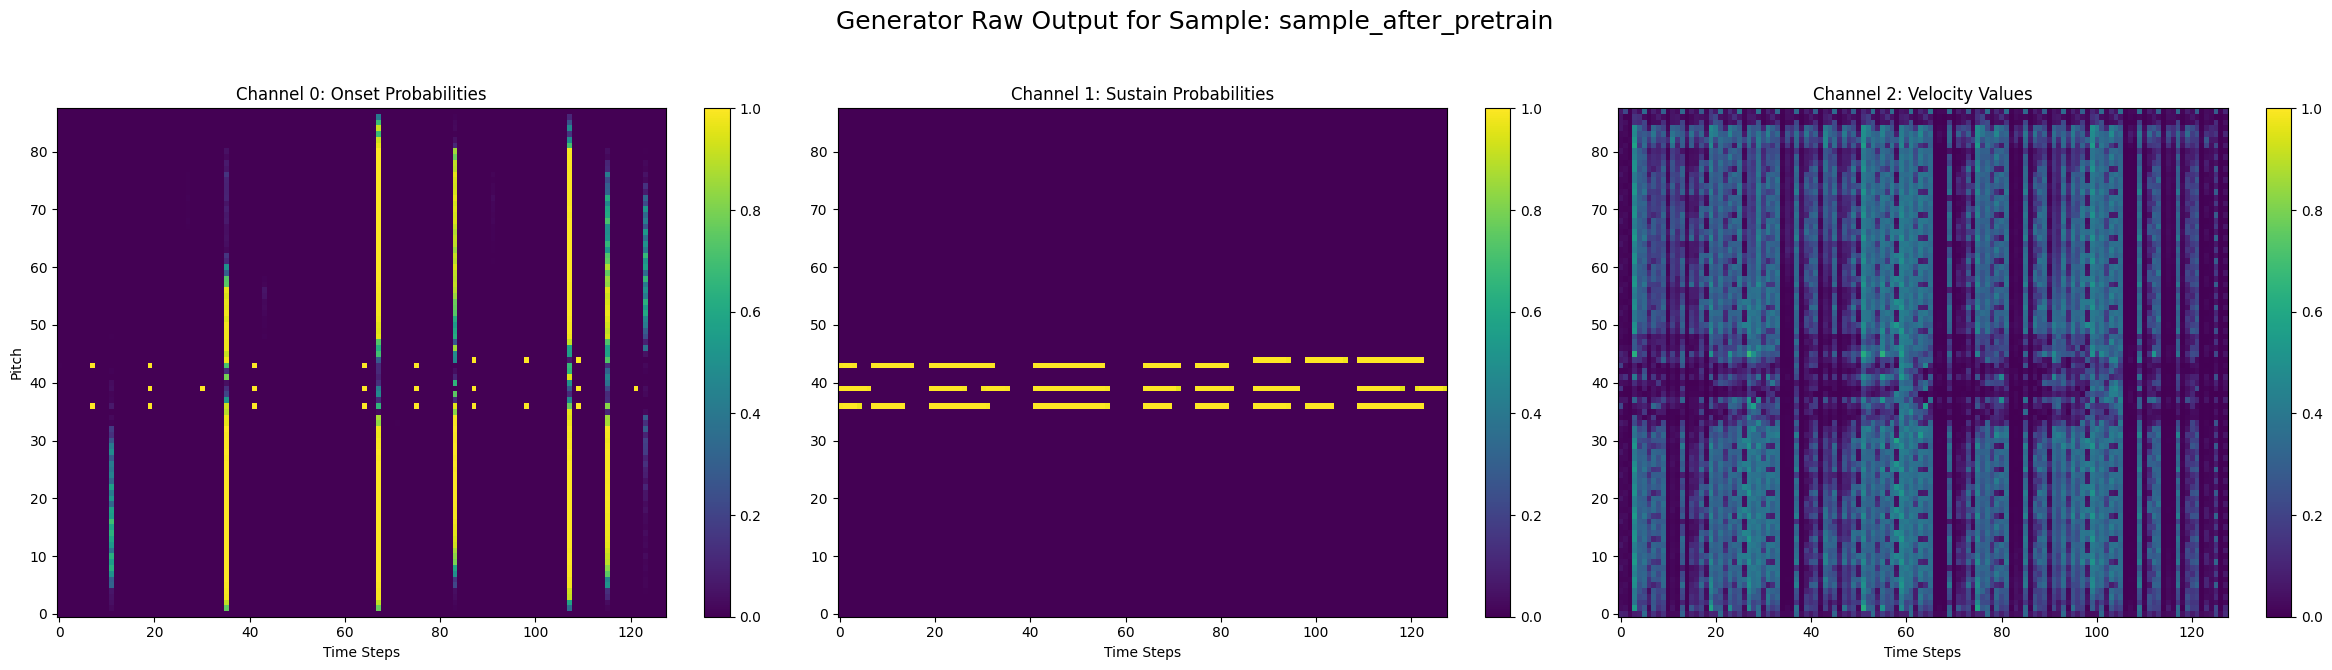

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\generator_pretrained.pth ---

Starting Adversarial Training...

--- STAGE: Adversarial Training (GAN) ---


Adv. Epoch 1/100: 100%|██████████| 199/199 [03:47<00:00,  1.14s/it, D_Loss=0.6572, G_Loss=0.7256, Musicality=0.1744]



Adversarial Epoch 1 Summary:
  Generator Losses -> Total: 0.6803, GAN: 0.8302
  G Musicality -> Impossible: 0.0019, Silent: 0.0035 Orphan Velo: 0.0145, Min Rate: 0.0692
  Discriminator Loss -> Total: 0.6650 



Adv. Epoch 2/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.6594, G_Loss=0.7323, Musicality=0.0875]



Adversarial Epoch 2 Summary:
  Generator Losses -> Total: 0.6558, GAN: 0.8072
  G Musicality -> Impossible: 0.0012, Silent: 0.0021 Orphan Velo: 0.0008, Min Rate: 0.0474
  Discriminator Loss -> Total: 0.6738 



Adv. Epoch 3/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.6447, G_Loss=0.6265, Musicality=0.0257]



Adversarial Epoch 3 Summary:
  Generator Losses -> Total: 0.6914, GAN: 0.8543
  G Musicality -> Impossible: 0.0007, Silent: 0.0013 Orphan Velo: 0.0003, Min Rate: 0.0377
  Discriminator Loss -> Total: 0.6612 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_3 ---


Adv. Epoch 4/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.6282, G_Loss=1.0256, Musicality=0.0991]



Adversarial Epoch 4 Summary:
  Generator Losses -> Total: 0.7387, GAN: 0.9032
  G Musicality -> Impossible: 0.0009, Silent: 0.0014 Orphan Velo: 0.0003, Min Rate: 0.0787
  Discriminator Loss -> Total: 0.6483 



Adv. Epoch 5/100: 100%|██████████| 199/199 [03:43<00:00,  1.12s/it, D_Loss=0.6153, G_Loss=0.9229, Musicality=0.3798]



Adversarial Epoch 5 Summary:
  Generator Losses -> Total: 0.8162, GAN: 1.0009
  G Musicality -> Impossible: 0.0004, Silent: 0.0008 Orphan Velo: 0.0003, Min Rate: 0.0764
  Discriminator Loss -> Total: 0.6278 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_5.pth ---


Adv. Epoch 6/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5898, G_Loss=0.8798, Musicality=0.0673]



Adversarial Epoch 6 Summary:
  Generator Losses -> Total: 0.8700, GAN: 1.0487
  G Musicality -> Impossible: 0.0003, Silent: 0.0006 Orphan Velo: 0.0002, Min Rate: 0.1543
  Discriminator Loss -> Total: 0.6177 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_6 ---


Adv. Epoch 7/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5640, G_Loss=0.9459, Musicality=0.2353]



Adversarial Epoch 7 Summary:
  Generator Losses -> Total: 0.8954, GAN: 1.0845
  G Musicality -> Impossible: 0.0004, Silent: 0.0007 Orphan Velo: 0.0003, Min Rate: 0.1381
  Discriminator Loss -> Total: 0.6110 



Adv. Epoch 8/100: 100%|██████████| 199/199 [03:52<00:00,  1.17s/it, D_Loss=0.6010, G_Loss=0.7492, Musicality=0.0468]



Adversarial Epoch 8 Summary:
  Generator Losses -> Total: 0.9207, GAN: 1.1047
  G Musicality -> Impossible: 0.0003, Silent: 0.0006 Orphan Velo: 0.0002, Min Rate: 0.1842
  Discriminator Loss -> Total: 0.6051 



Adv. Epoch 9/100: 100%|██████████| 199/199 [03:47<00:00,  1.14s/it, D_Loss=0.5930, G_Loss=1.0468, Musicality=0.1328]



Adversarial Epoch 9 Summary:
  Generator Losses -> Total: 0.9441, GAN: 1.1445
  G Musicality -> Impossible: 0.0003, Silent: 0.0006 Orphan Velo: 0.0002, Min Rate: 0.1418
  Discriminator Loss -> Total: 0.5979 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_9 ---


Adv. Epoch 10/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.6093, G_Loss=0.9509, Musicality=0.3648]



Adversarial Epoch 10 Summary:
  Generator Losses -> Total: 0.9935, GAN: 1.1953
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.1859
  Discriminator Loss -> Total: 0.5876 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_10.pth ---


Adv. Epoch 11/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5997, G_Loss=0.7152, Musicality=0.1086]



Adversarial Epoch 11 Summary:
  Generator Losses -> Total: 0.9804, GAN: 1.2031
  G Musicality -> Impossible: 0.0003, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0888
  Discriminator Loss -> Total: 0.5851 



Adv. Epoch 12/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.6228, G_Loss=1.3348, Musicality=0.1004]



Adversarial Epoch 12 Summary:
  Generator Losses -> Total: 1.0076, GAN: 1.2348
  G Musicality -> Impossible: 0.0003, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0981
  Discriminator Loss -> Total: 0.5789 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_12 ---


Adv. Epoch 13/100: 100%|██████████| 199/199 [03:45<00:00,  1.14s/it, D_Loss=0.5542, G_Loss=0.9594, Musicality=0.1280]



Adversarial Epoch 13 Summary:
  Generator Losses -> Total: 1.0253, GAN: 1.2556
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1034
  Discriminator Loss -> Total: 0.5728 



Adv. Epoch 14/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5724, G_Loss=1.2586, Musicality=0.0901]



Adversarial Epoch 14 Summary:
  Generator Losses -> Total: 1.0464, GAN: 1.2794
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.1134
  Discriminator Loss -> Total: 0.5699 



Adv. Epoch 15/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5342, G_Loss=1.0761, Musicality=0.0956]



Adversarial Epoch 15 Summary:
  Generator Losses -> Total: 1.0796, GAN: 1.3202
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1167
  Discriminator Loss -> Total: 0.5599 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_15 ---


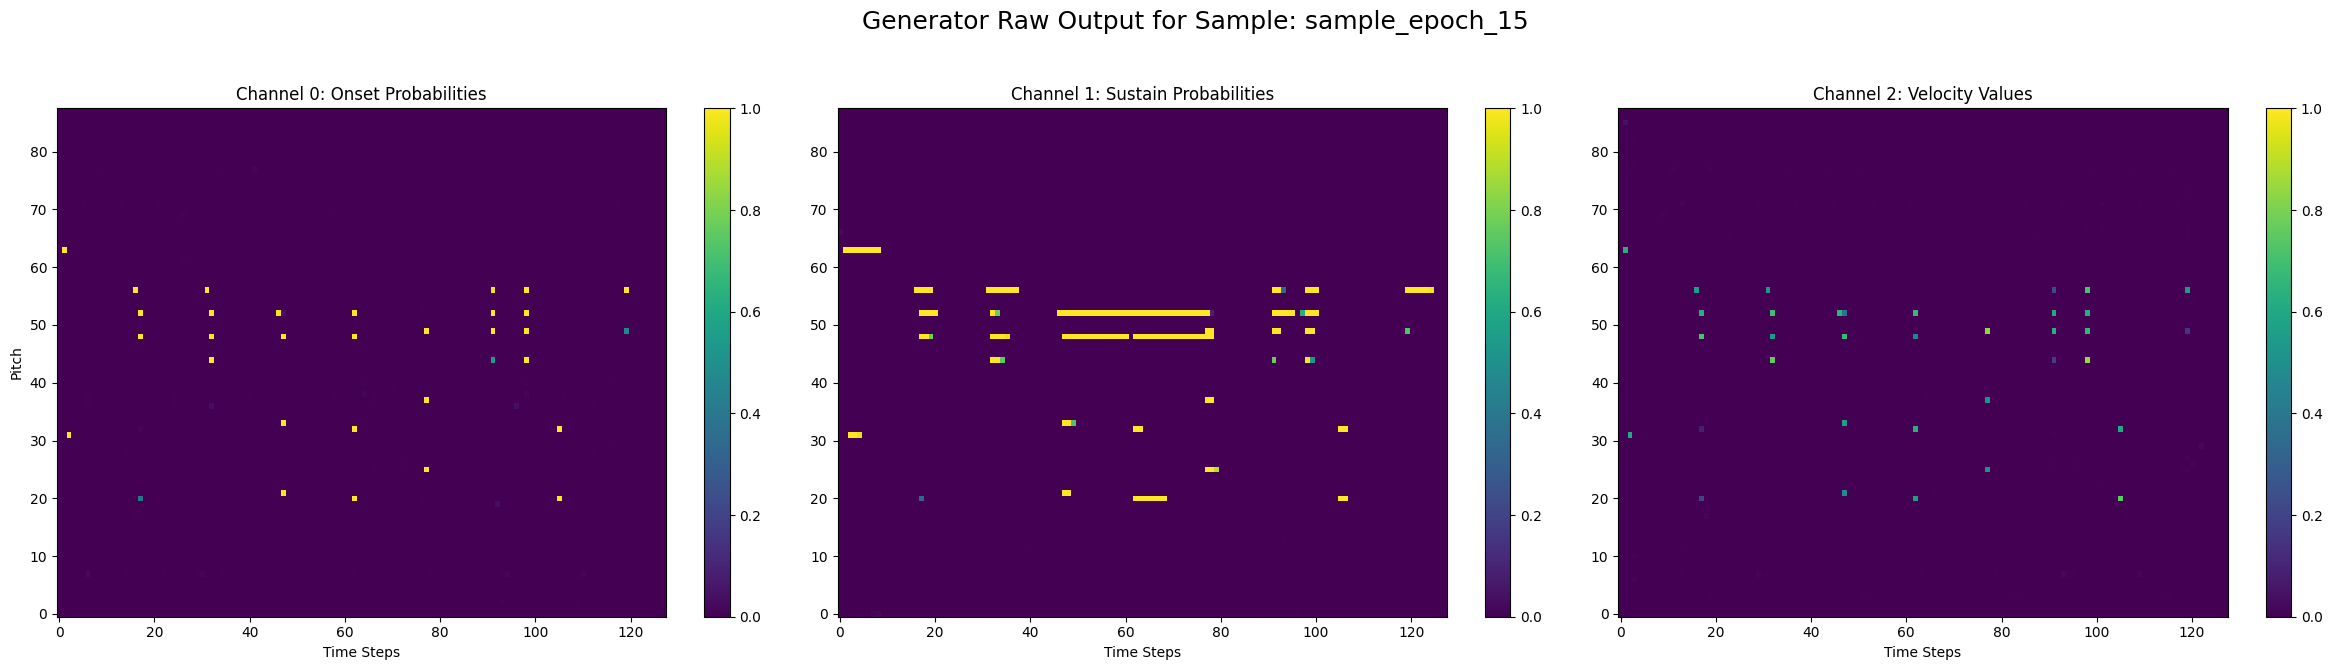

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_15.pth ---


Adv. Epoch 16/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5667, G_Loss=1.0071, Musicality=0.1154]



Adversarial Epoch 16 Summary:
  Generator Losses -> Total: 1.0641, GAN: 1.3040
  G Musicality -> Impossible: 0.0003, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.1035
  Discriminator Loss -> Total: 0.5657 



Adv. Epoch 17/100: 100%|██████████| 199/199 [03:55<00:00,  1.18s/it, D_Loss=0.5437, G_Loss=1.2576, Musicality=0.1632]



Adversarial Epoch 17 Summary:
  Generator Losses -> Total: 1.0918, GAN: 1.3390
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1023
  Discriminator Loss -> Total: 0.5553 



Adv. Epoch 18/100: 100%|██████████| 199/199 [04:02<00:00,  1.22s/it, D_Loss=0.5371, G_Loss=1.1331, Musicality=0.0962]



Adversarial Epoch 18 Summary:
  Generator Losses -> Total: 1.1253, GAN: 1.3790
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.1098
  Discriminator Loss -> Total: 0.5484 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_18 ---


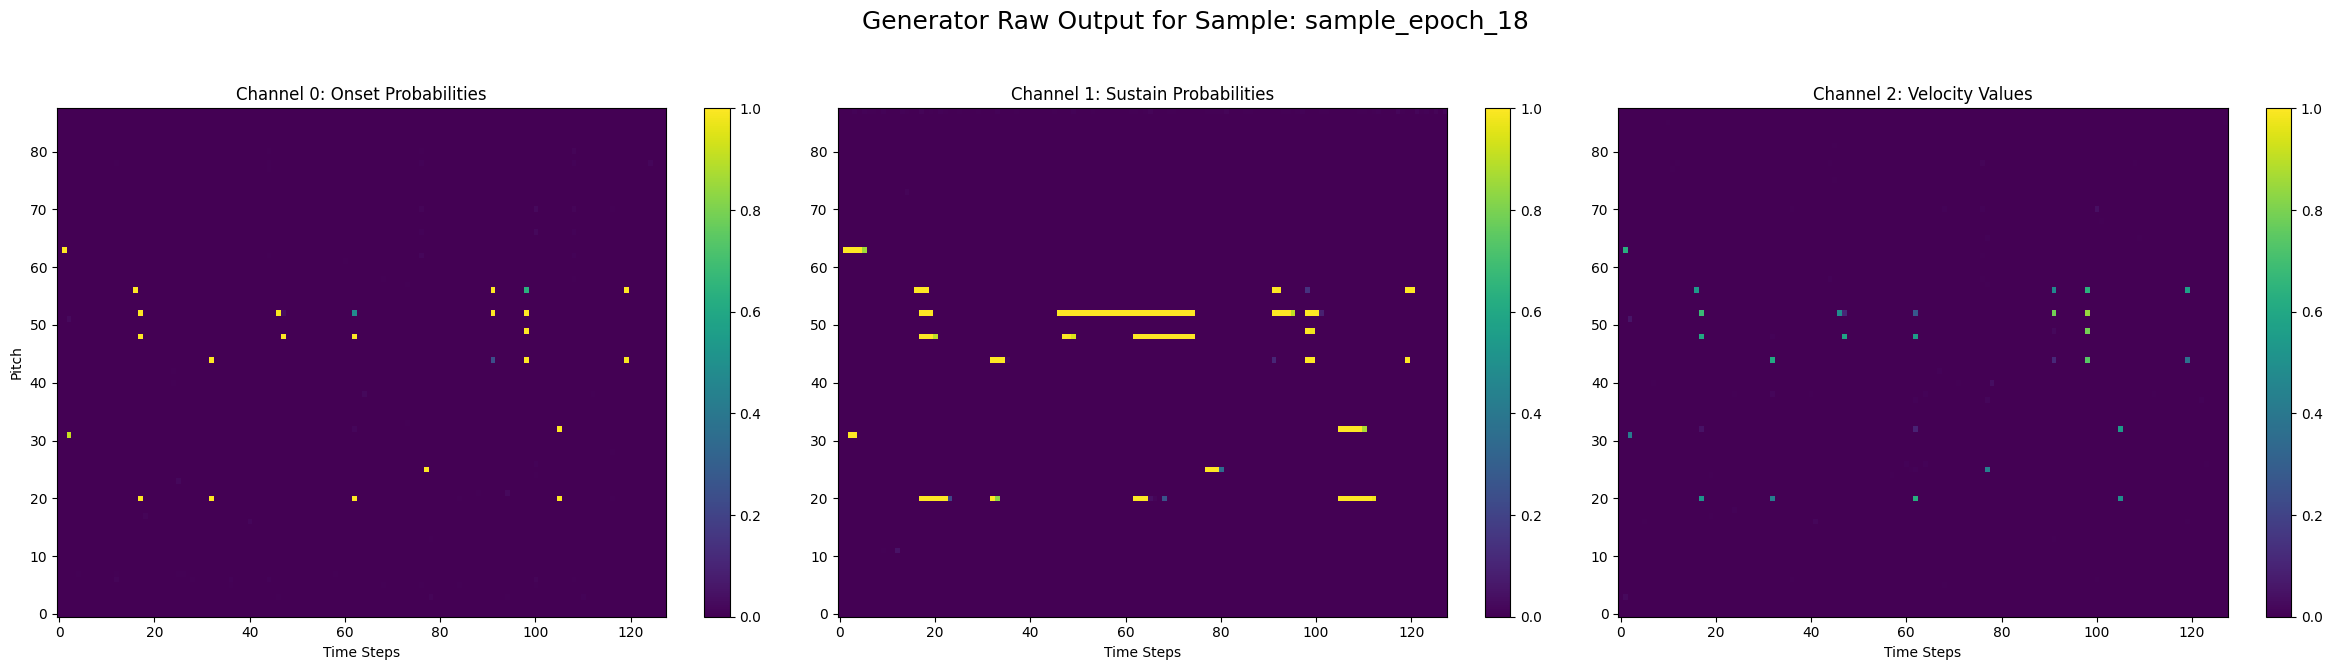

Adv. Epoch 19/100: 100%|██████████| 199/199 [04:03<00:00,  1.22s/it, D_Loss=0.5460, G_Loss=1.2452, Musicality=0.0696]



Adversarial Epoch 19 Summary:
  Generator Losses -> Total: 1.1314, GAN: 1.3865
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.1105
  Discriminator Loss -> Total: 0.5461 



Adv. Epoch 20/100: 100%|██████████| 199/199 [03:49<00:00,  1.15s/it, D_Loss=0.5340, G_Loss=1.1789, Musicality=0.1042]



Adversarial Epoch 20 Summary:
  Generator Losses -> Total: 1.1474, GAN: 1.4069
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.1086
  Discriminator Loss -> Total: 0.5417 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_20.pth ---


Adv. Epoch 21/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5492, G_Loss=1.1999, Musicality=0.0639]



Adversarial Epoch 21 Summary:
  Generator Losses -> Total: 1.1574, GAN: 1.4188
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1111
  Discriminator Loss -> Total: 0.5394 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_21 ---


Adv. Epoch 22/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5321, G_Loss=1.2180, Musicality=0.0652]



Adversarial Epoch 22 Summary:
  Generator Losses -> Total: 1.1869, GAN: 1.4591
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0974
  Discriminator Loss -> Total: 0.5317 



Adv. Epoch 23/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5267, G_Loss=1.1611, Musicality=0.0873]



Adversarial Epoch 23 Summary:
  Generator Losses -> Total: 1.1653, GAN: 1.4329
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0941
  Discriminator Loss -> Total: 0.5380 



Adv. Epoch 24/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5320, G_Loss=1.1983, Musicality=0.0804]



Adversarial Epoch 24 Summary:
  Generator Losses -> Total: 1.1760, GAN: 1.4468
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0924
  Discriminator Loss -> Total: 0.5334 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_24 ---


Adv. Epoch 25/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5203, G_Loss=1.2746, Musicality=0.0955]



Adversarial Epoch 25 Summary:
  Generator Losses -> Total: 1.2119, GAN: 1.4913
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0939
  Discriminator Loss -> Total: 0.5243 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_25.pth ---


Adv. Epoch 26/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5220, G_Loss=1.2824, Musicality=0.1077]



Adversarial Epoch 26 Summary:
  Generator Losses -> Total: 1.2268, GAN: 1.5070
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1053
  Discriminator Loss -> Total: 0.5220 



Adv. Epoch 27/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5112, G_Loss=1.2314, Musicality=0.0696]



Adversarial Epoch 27 Summary:
  Generator Losses -> Total: 1.2221, GAN: 1.5070
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0821
  Discriminator Loss -> Total: 0.5214 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_27 ---


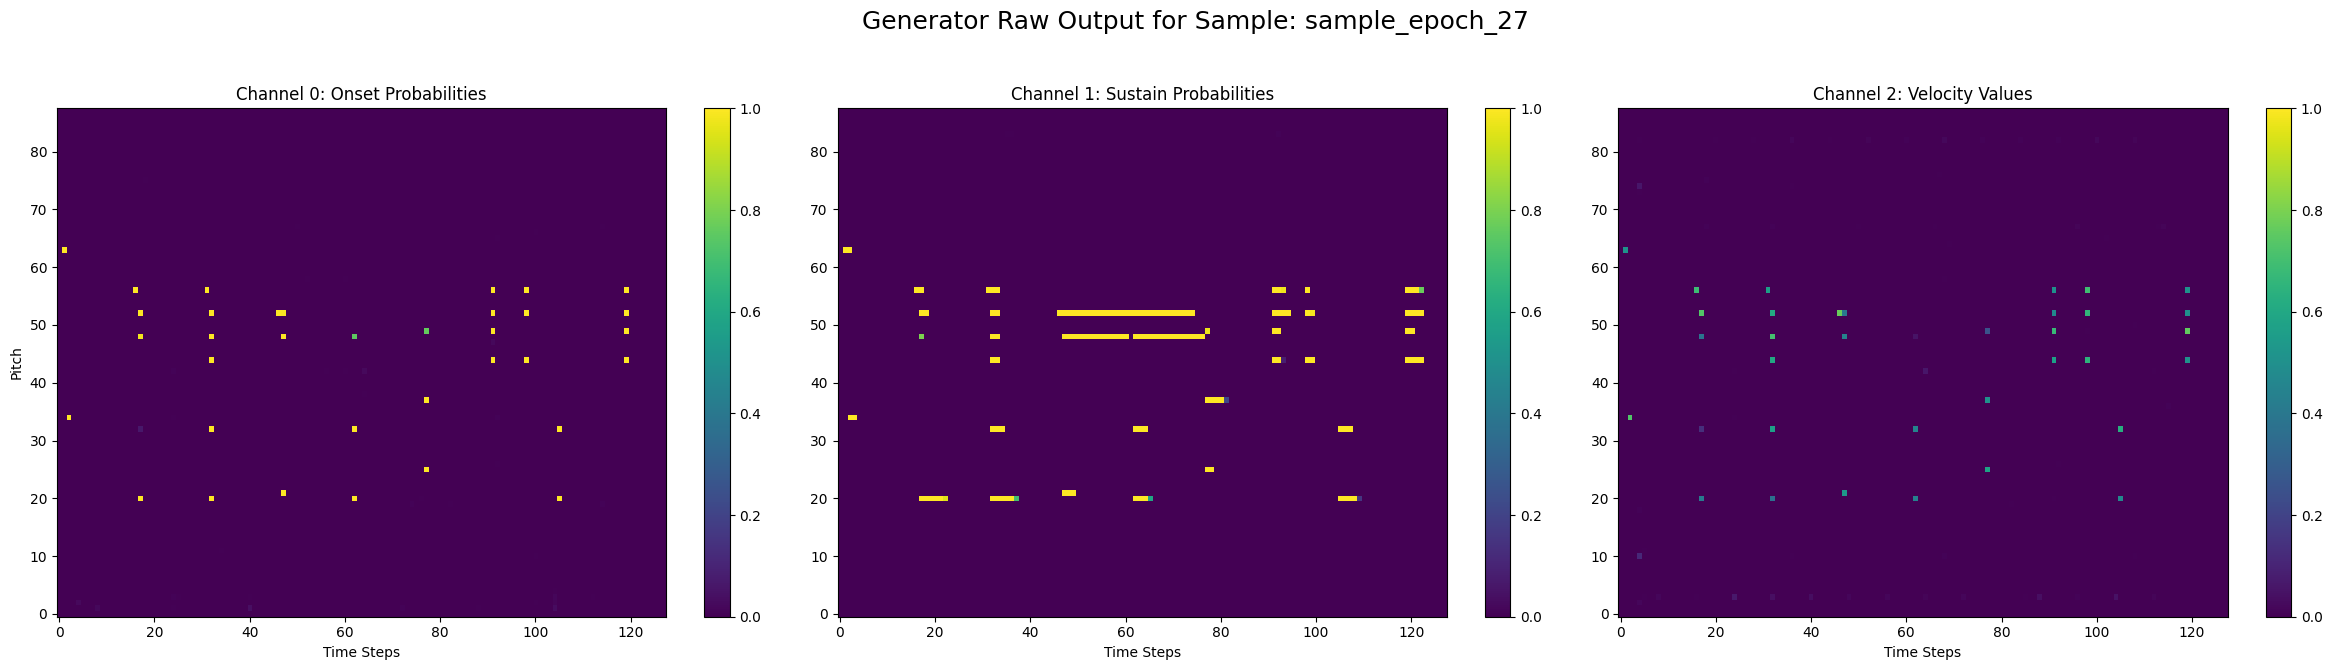

Adv. Epoch 28/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5248, G_Loss=1.2347, Musicality=0.0654]



Adversarial Epoch 28 Summary:
  Generator Losses -> Total: 1.1006, GAN: 1.3569
  G Musicality -> Impossible: 0.0004, Silent: 0.0008 Orphan Velo: 0.0002, Min Rate: 0.0741
  Discriminator Loss -> Total: 0.5543 



Adv. Epoch 29/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5365, G_Loss=1.1924, Musicality=0.0641]



Adversarial Epoch 29 Summary:
  Generator Losses -> Total: 1.1996, GAN: 1.4780
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0859
  Discriminator Loss -> Total: 0.5281 



Adv. Epoch 30/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5175, G_Loss=1.2186, Musicality=0.0947]



Adversarial Epoch 30 Summary:
  Generator Losses -> Total: 1.2252, GAN: 1.5113
  G Musicality -> Impossible: 0.0004, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0804
  Discriminator Loss -> Total: 0.5211 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_30 ---


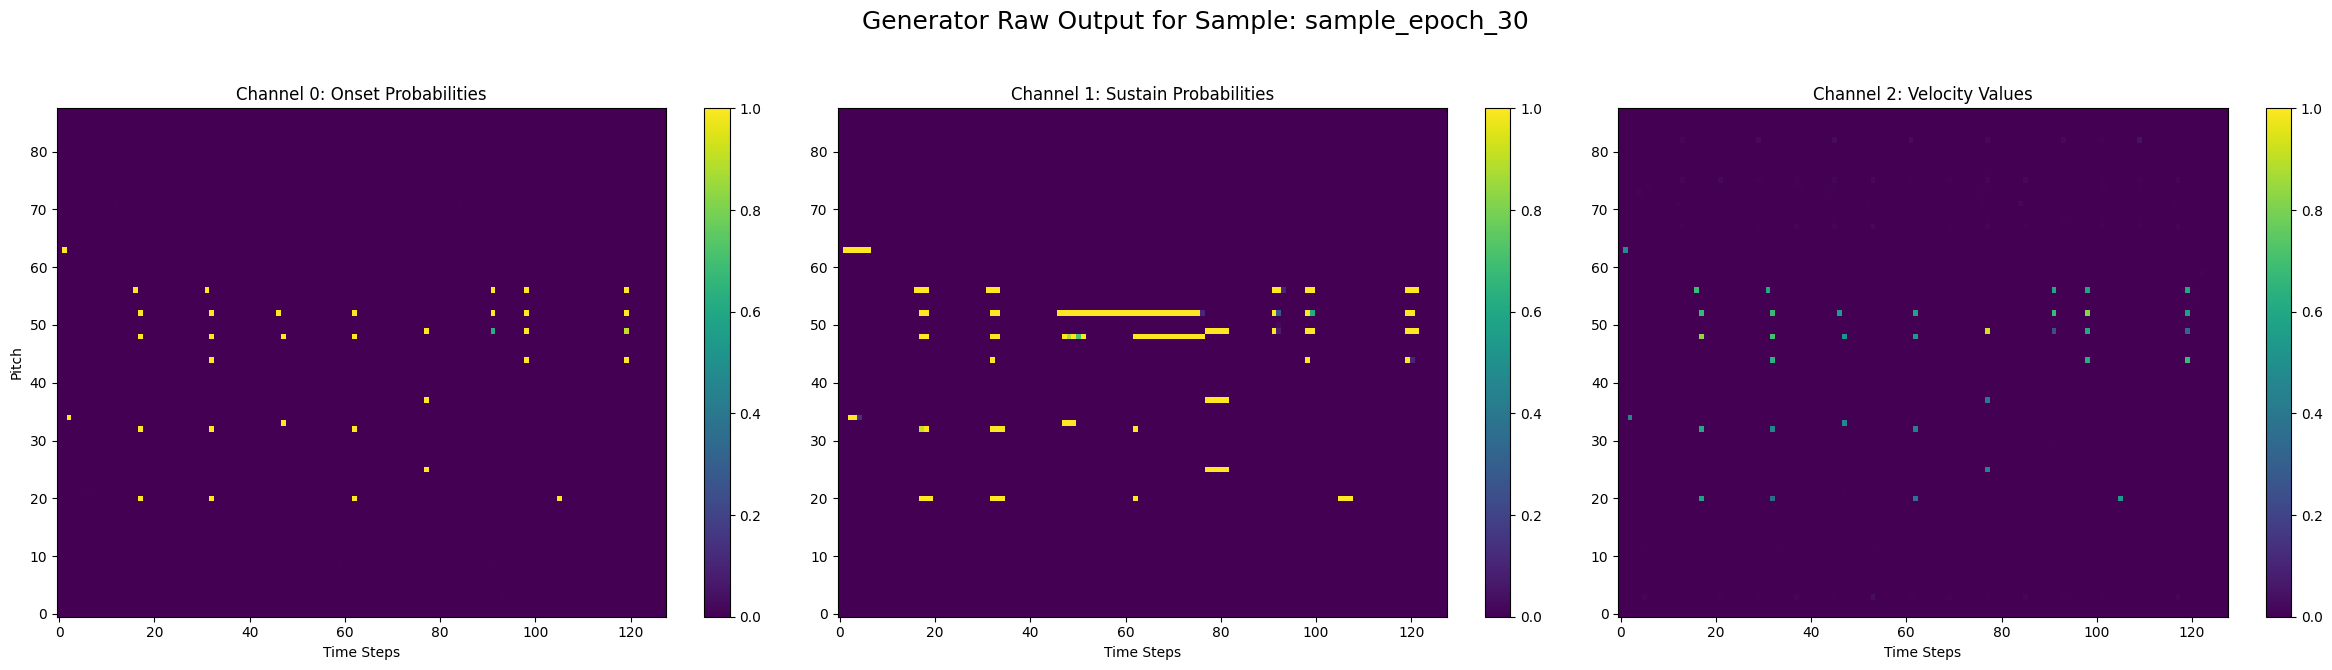

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_30.pth ---


Adv. Epoch 31/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5214, G_Loss=1.2405, Musicality=0.1008]



Adversarial Epoch 31 Summary:
  Generator Losses -> Total: 1.2367, GAN: 1.5246
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0848
  Discriminator Loss -> Total: 0.5183 



Adv. Epoch 32/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5112, G_Loss=1.3042, Musicality=0.0896]



Adversarial Epoch 32 Summary:
  Generator Losses -> Total: 1.2432, GAN: 1.5318
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0883
  Discriminator Loss -> Total: 0.5163 



Adv. Epoch 33/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5147, G_Loss=1.2041, Musicality=0.1050]



Adversarial Epoch 33 Summary:
  Generator Losses -> Total: 1.2188, GAN: 1.5022
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0846
  Discriminator Loss -> Total: 0.5230 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_33 ---


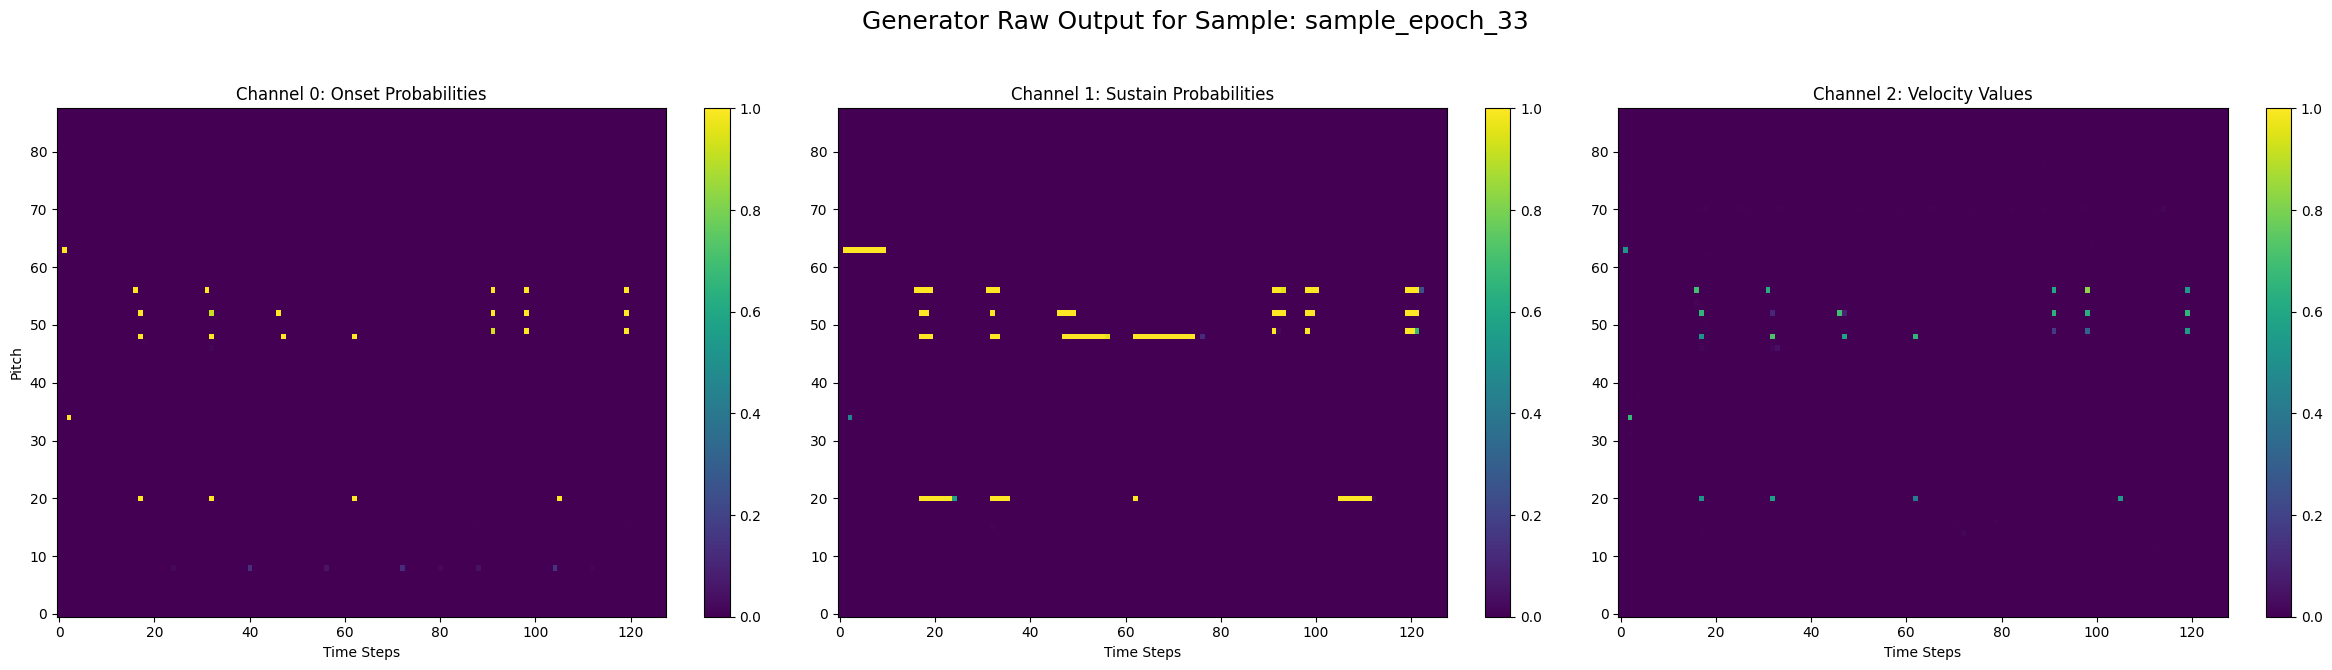

Adv. Epoch 34/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5099, G_Loss=1.2399, Musicality=0.0601]



Adversarial Epoch 34 Summary:
  Generator Losses -> Total: 1.2338, GAN: 1.5177
  G Musicality -> Impossible: 0.0006, Silent: 0.0005 Orphan Velo: 0.0003, Min Rate: 0.0974
  Discriminator Loss -> Total: 0.5199 



Adv. Epoch 35/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5460, G_Loss=1.3167, Musicality=0.0915]



Adversarial Epoch 35 Summary:
  Generator Losses -> Total: 1.2427, GAN: 1.5310
  G Musicality -> Impossible: 0.0006, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0882
  Discriminator Loss -> Total: 0.5176 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_35.pth ---


Adv. Epoch 36/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5093, G_Loss=1.2227, Musicality=0.0469]



Adversarial Epoch 36 Summary:
  Generator Losses -> Total: 1.2486, GAN: 1.5426
  G Musicality -> Impossible: 0.0005, Silent: 0.0004 Orphan Velo: 0.0004, Min Rate: 0.0717
  Discriminator Loss -> Total: 0.5138 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_36 ---


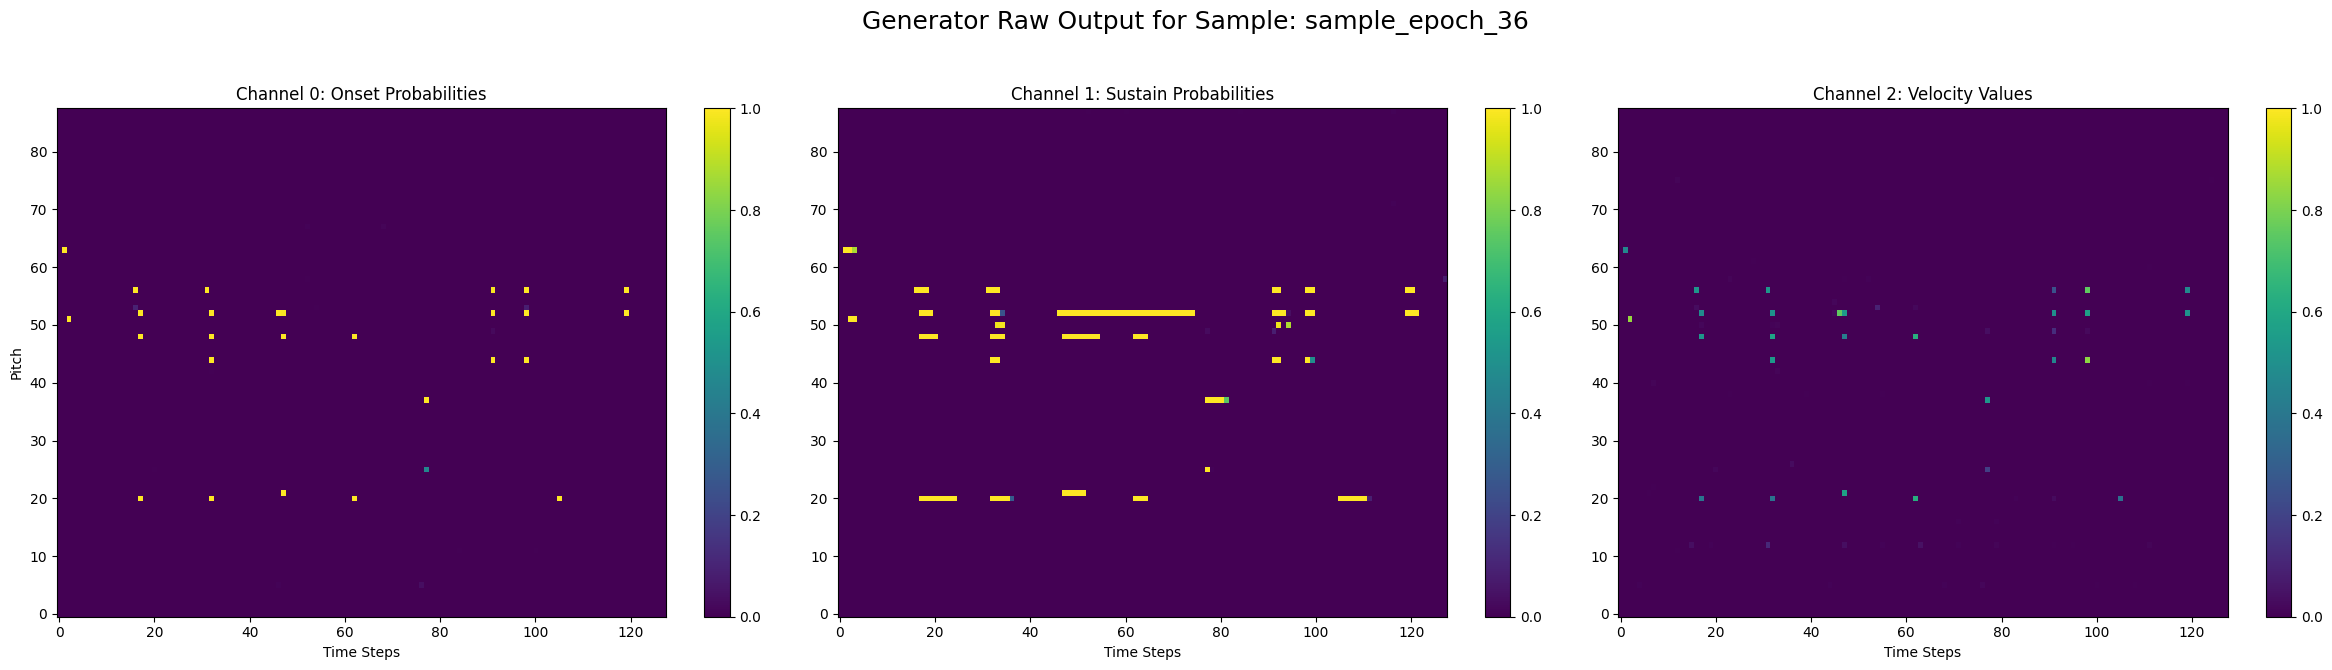

Adv. Epoch 37/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5135, G_Loss=1.2876, Musicality=0.1151]



Adversarial Epoch 37 Summary:
  Generator Losses -> Total: 1.2461, GAN: 1.5352
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0887
  Discriminator Loss -> Total: 0.5167 



Adv. Epoch 38/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5201, G_Loss=1.2342, Musicality=0.0465]



Adversarial Epoch 38 Summary:
  Generator Losses -> Total: 1.2314, GAN: 1.5194
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0786
  Discriminator Loss -> Total: 0.5193 



Adv. Epoch 39/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5088, G_Loss=1.2185, Musicality=0.0547]



Adversarial Epoch 39 Summary:
  Generator Losses -> Total: 1.2543, GAN: 1.5540
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0546
  Discriminator Loss -> Total: 0.5125 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_39 ---


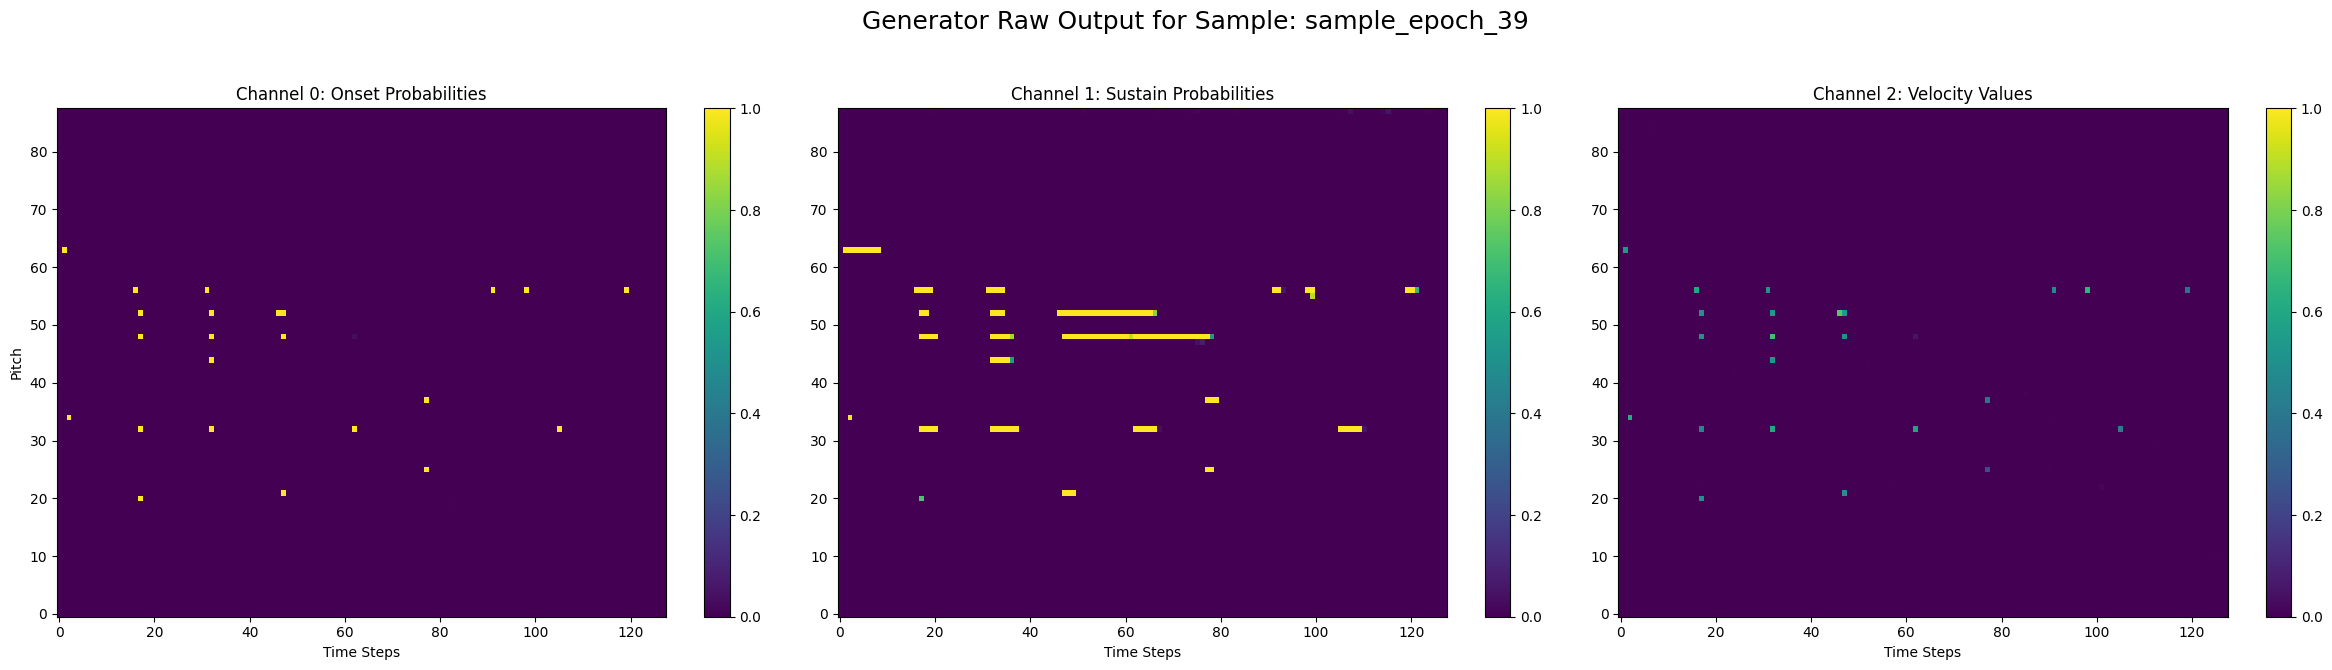

Adv. Epoch 40/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5144, G_Loss=1.2525, Musicality=0.0727]



Adversarial Epoch 40 Summary:
  Generator Losses -> Total: 1.2466, GAN: 1.5443
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0549
  Discriminator Loss -> Total: 0.5146 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_40.pth ---


Adv. Epoch 41/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5105, G_Loss=1.2489, Musicality=0.0436]



Adversarial Epoch 41 Summary:
  Generator Losses -> Total: 1.2483, GAN: 1.5483
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0474
  Discriminator Loss -> Total: 0.5130 



Adv. Epoch 42/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5082, G_Loss=1.2826, Musicality=0.0380]



Adversarial Epoch 42 Summary:
  Generator Losses -> Total: 1.2517, GAN: 1.5512
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0533
  Discriminator Loss -> Total: 0.5125 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_42 ---


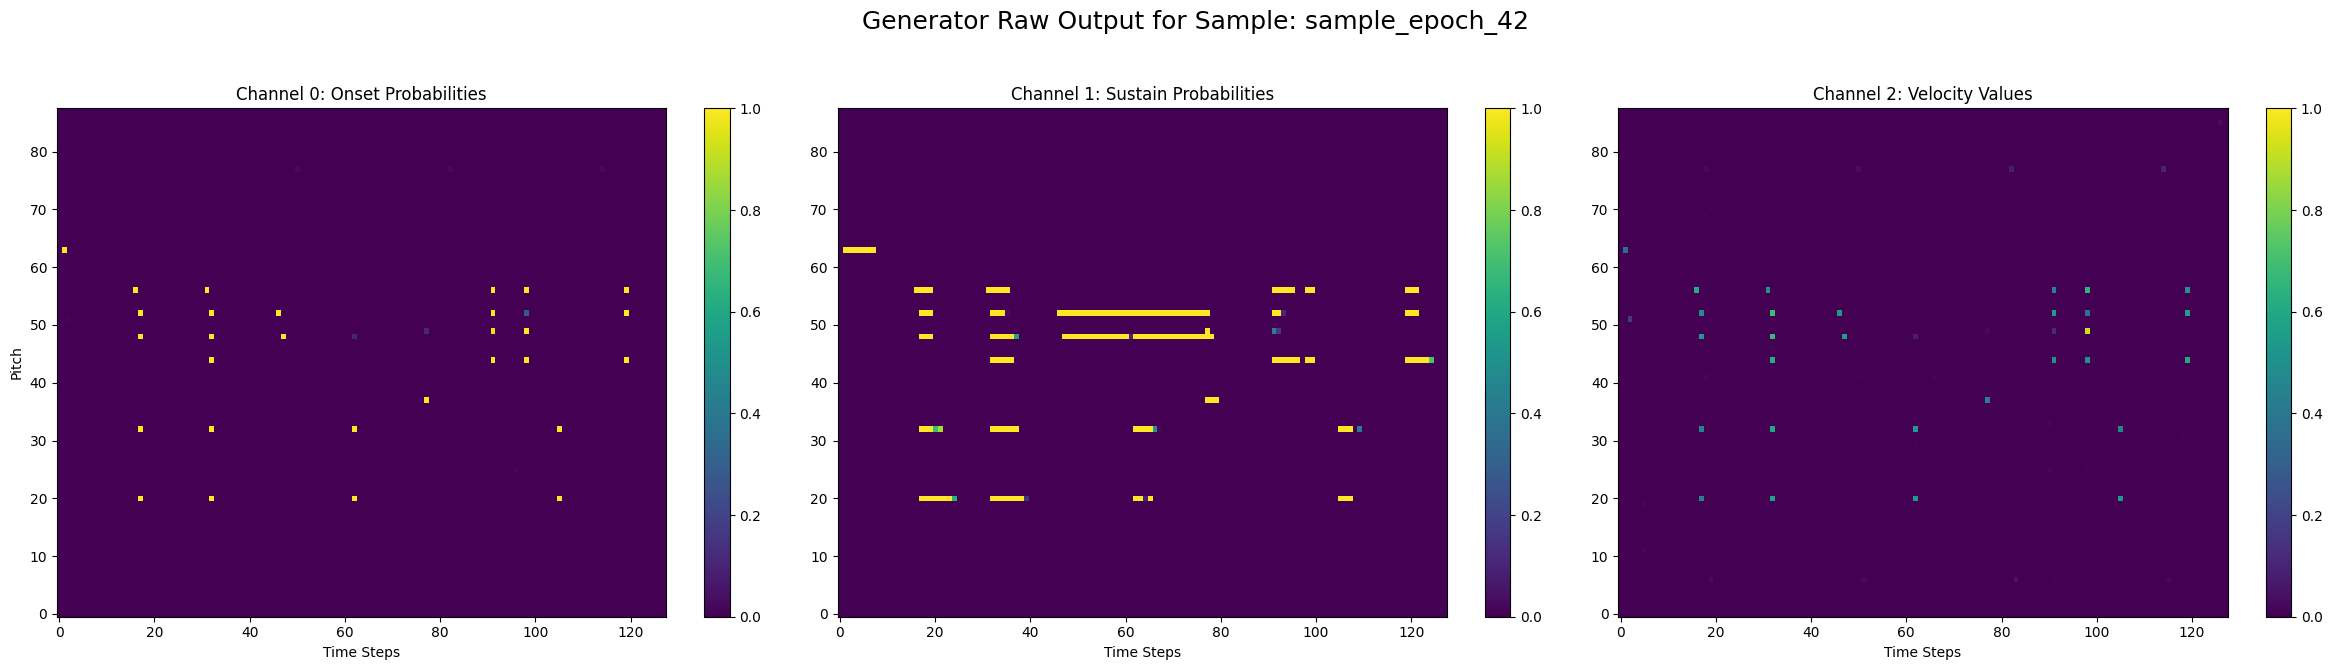

Adv. Epoch 43/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5140, G_Loss=1.1966, Musicality=0.0326]



Adversarial Epoch 43 Summary:
  Generator Losses -> Total: 1.2510, GAN: 1.5529
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0430
  Discriminator Loss -> Total: 0.5122 



Adv. Epoch 44/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5184, G_Loss=1.1687, Musicality=0.0497]



Adversarial Epoch 44 Summary:
  Generator Losses -> Total: 1.2435, GAN: 1.5428
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0458
  Discriminator Loss -> Total: 0.5153 



Adv. Epoch 45/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5060, G_Loss=1.2733, Musicality=0.0237]



Adversarial Epoch 45 Summary:
  Generator Losses -> Total: 1.2561, GAN: 1.5583
  G Musicality -> Impossible: 0.0008, Silent: 0.0006 Orphan Velo: 0.0003, Min Rate: 0.0461
  Discriminator Loss -> Total: 0.5119 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_45 ---


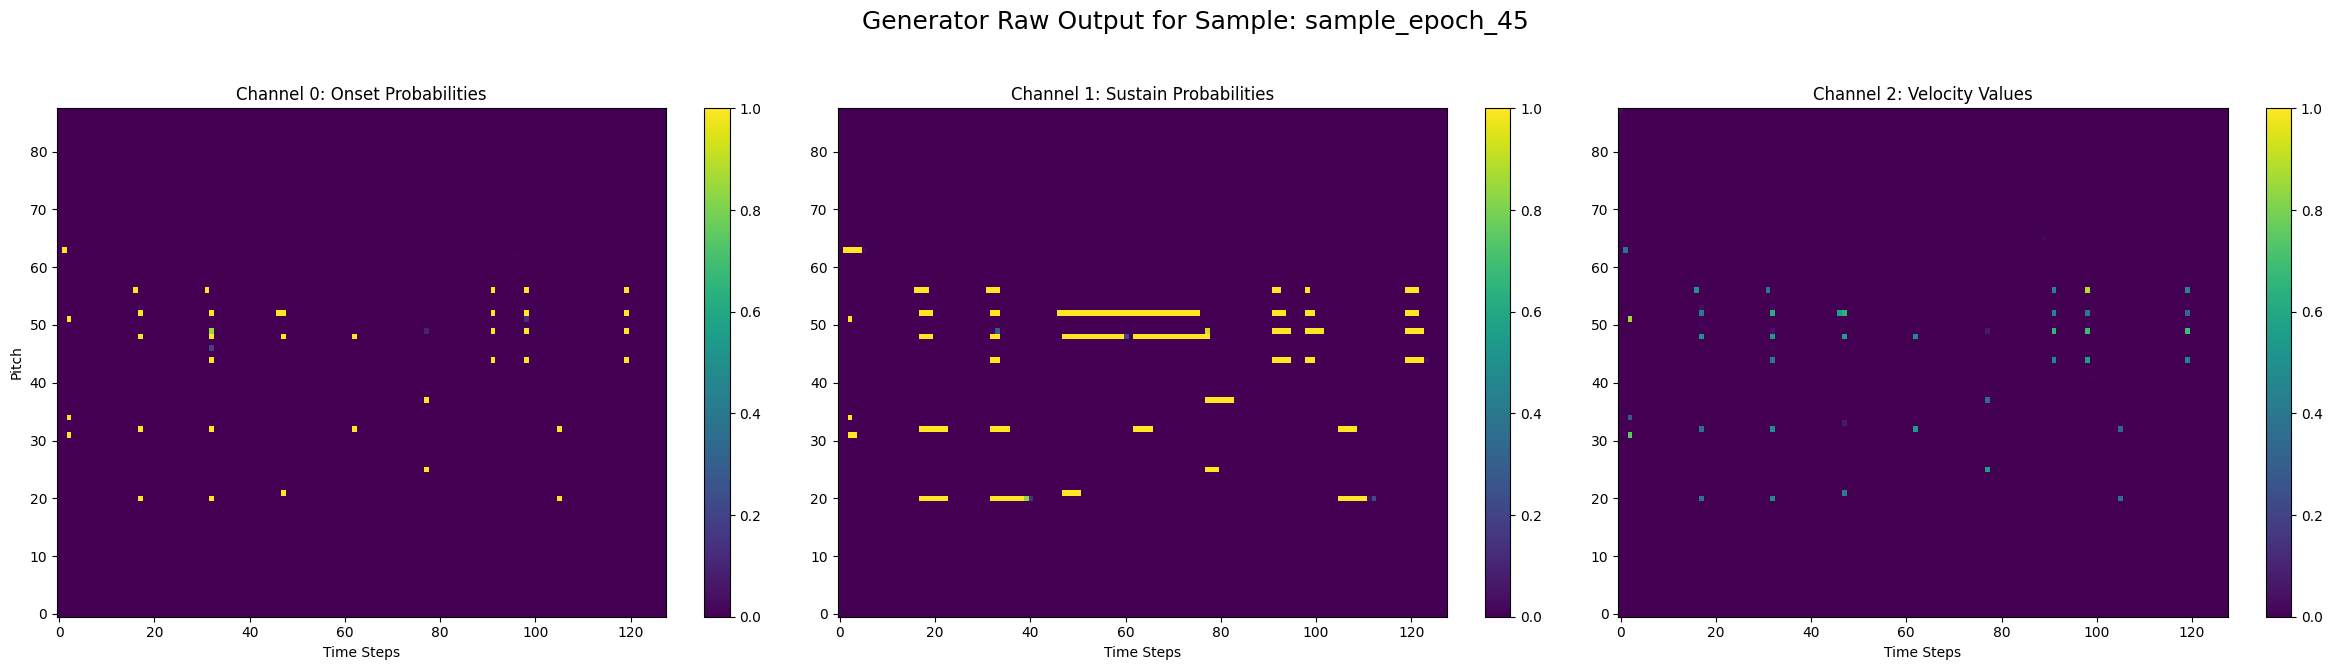

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_45.pth ---


Adv. Epoch 46/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5055, G_Loss=1.2527, Musicality=0.0497]



Adversarial Epoch 46 Summary:
  Generator Losses -> Total: 1.2593, GAN: 1.5602
  G Musicality -> Impossible: 0.0006, Silent: 0.0006 Orphan Velo: 0.0001, Min Rate: 0.0547
  Discriminator Loss -> Total: 0.5119 



Adv. Epoch 47/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5068, G_Loss=1.2134, Musicality=0.0743]



Adversarial Epoch 47 Summary:
  Generator Losses -> Total: 1.2501, GAN: 1.5497
  G Musicality -> Impossible: 0.0003, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0510
  Discriminator Loss -> Total: 0.5140 



Adv. Epoch 48/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5045, G_Loss=1.2494, Musicality=0.0580]



Adversarial Epoch 48 Summary:
  Generator Losses -> Total: 1.1844, GAN: 1.4600
  G Musicality -> Impossible: 0.0002, Silent: 0.0005 Orphan Velo: 0.0001, Min Rate: 0.0816
  Discriminator Loss -> Total: 0.5327 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_48 ---


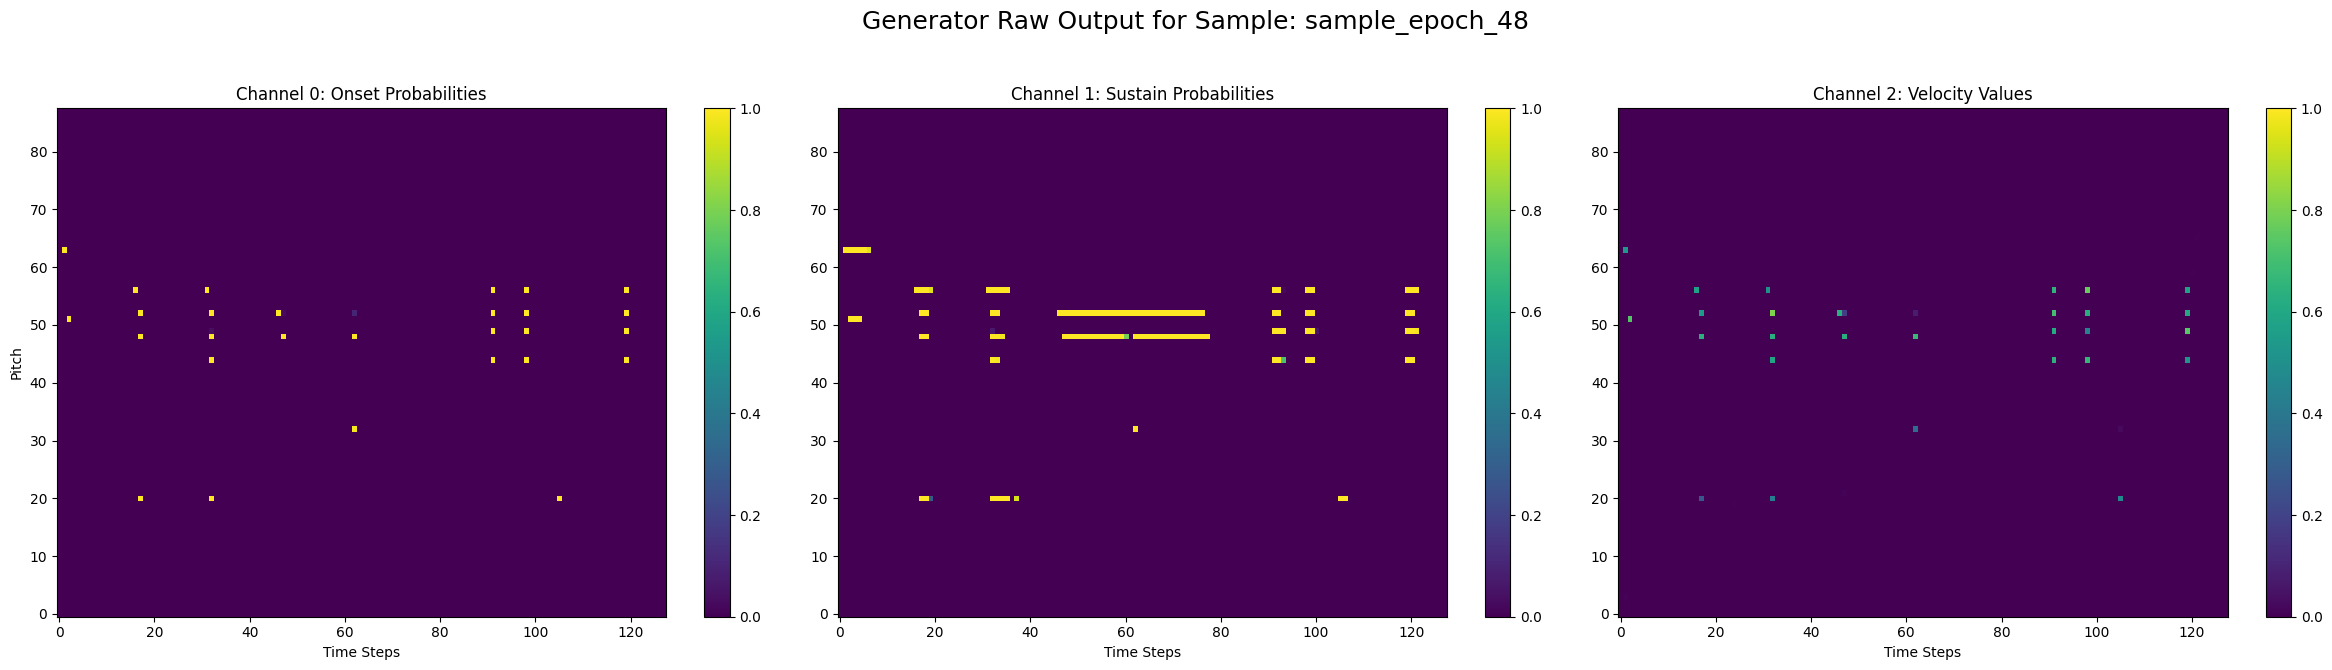

Adv. Epoch 49/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5062, G_Loss=1.2128, Musicality=0.0535]



Adversarial Epoch 49 Summary:
  Generator Losses -> Total: 1.2631, GAN: 1.5619
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0677
  Discriminator Loss -> Total: 0.5112 



Adv. Epoch 50/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5093, G_Loss=1.2721, Musicality=0.0338]



Adversarial Epoch 50 Summary:
  Generator Losses -> Total: 1.2623, GAN: 1.5621
  G Musicality -> Impossible: 0.0005, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0623
  Discriminator Loss -> Total: 0.5108 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_50.pth ---


Adv. Epoch 51/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5118, G_Loss=1.2375, Musicality=0.0393]



Adversarial Epoch 51 Summary:
  Generator Losses -> Total: 1.2532, GAN: 1.5503
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0642
  Discriminator Loss -> Total: 0.5141 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_51 ---


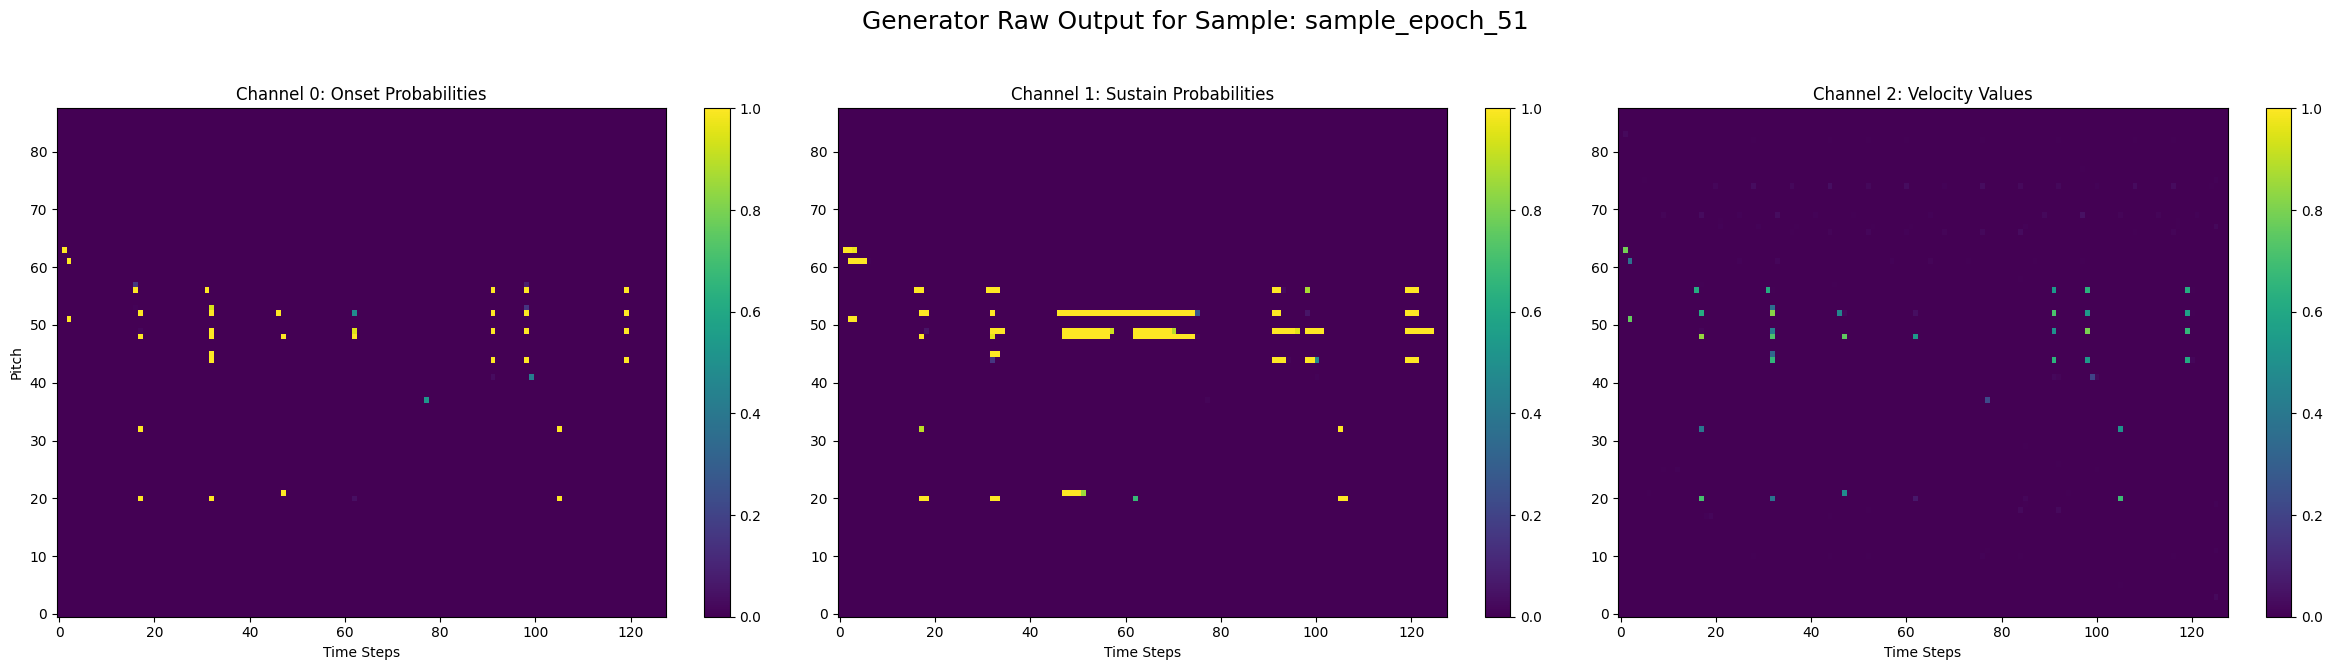

Adv. Epoch 52/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5070, G_Loss=1.2458, Musicality=0.0768]



Adversarial Epoch 52 Summary:
  Generator Losses -> Total: 1.2743, GAN: 1.5799
  G Musicality -> Impossible: 0.0002, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0510
  Discriminator Loss -> Total: 0.5076 



Adv. Epoch 53/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5584, G_Loss=1.3423, Musicality=0.1302]



Adversarial Epoch 53 Summary:
  Generator Losses -> Total: 1.2449, GAN: 1.5399
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0640
  Discriminator Loss -> Total: 0.5157 



Adv. Epoch 54/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5121, G_Loss=1.2634, Musicality=0.0626]



Adversarial Epoch 54 Summary:
  Generator Losses -> Total: 1.2572, GAN: 1.5537
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0710
  Discriminator Loss -> Total: 0.5120 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_54 ---


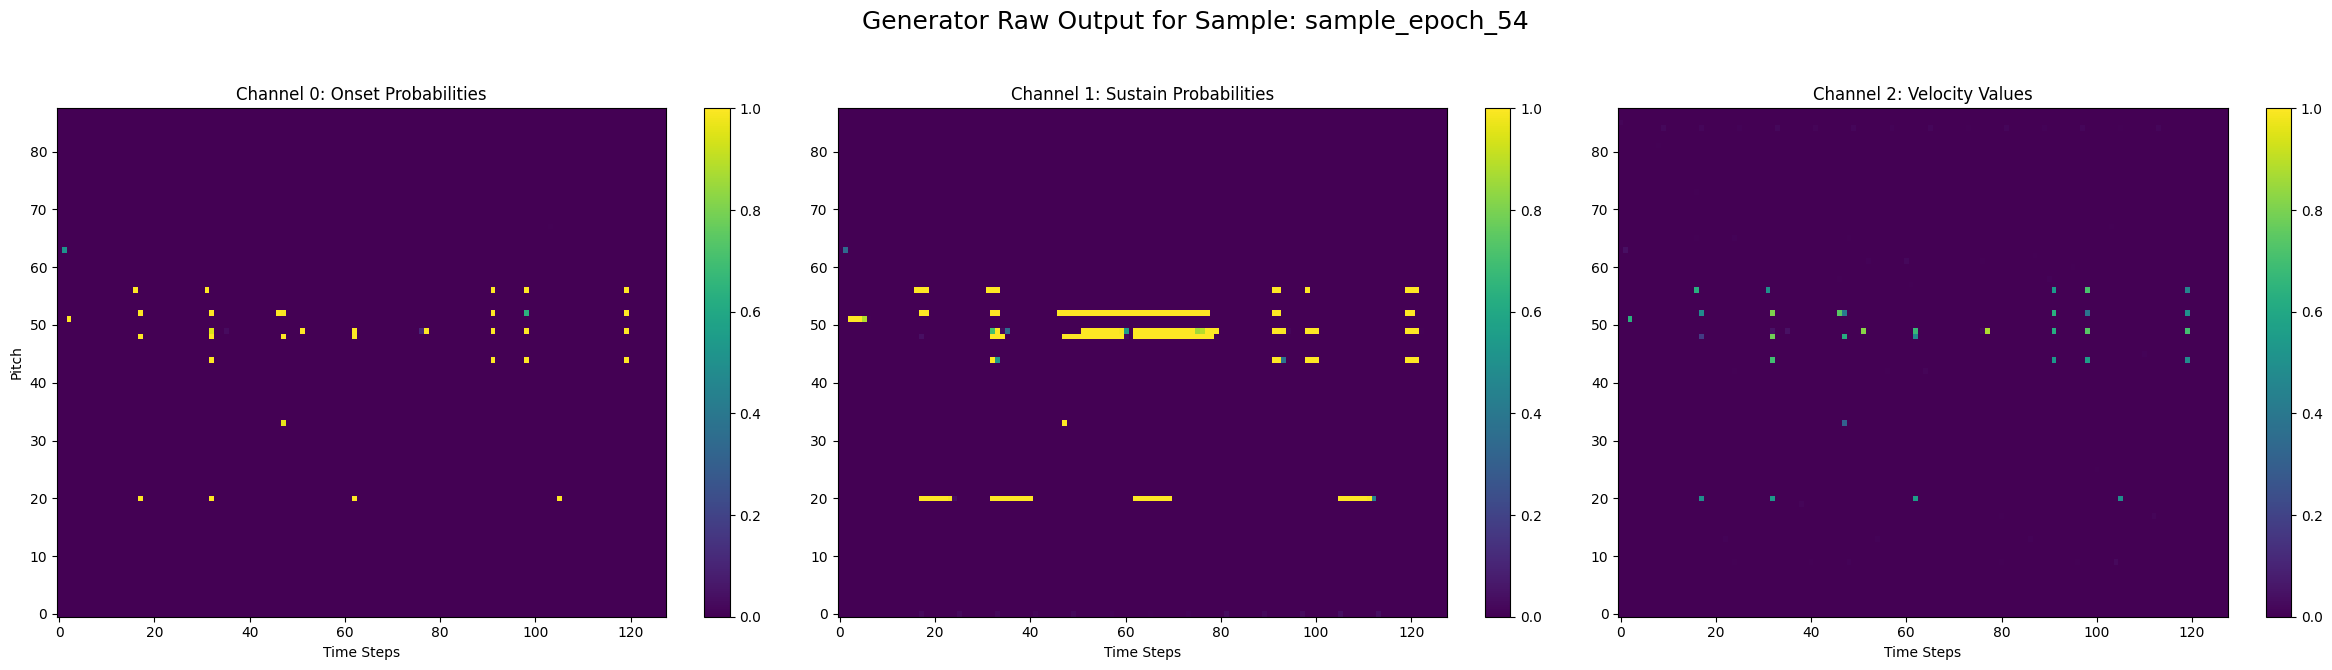

Adv. Epoch 55/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5090, G_Loss=1.2434, Musicality=0.0505]



Adversarial Epoch 55 Summary:
  Generator Losses -> Total: 1.2487, GAN: 1.5434
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0693
  Discriminator Loss -> Total: 0.5147 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_55.pth ---


Adv. Epoch 56/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5138, G_Loss=1.2946, Musicality=0.0669]



Adversarial Epoch 56 Summary:
  Generator Losses -> Total: 1.2552, GAN: 1.5489
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0798
  Discriminator Loss -> Total: 0.5137 



Adv. Epoch 57/100: 100%|██████████| 199/199 [03:45<00:00,  1.13s/it, D_Loss=0.5242, G_Loss=1.3162, Musicality=0.1017]



Adversarial Epoch 57 Summary:
  Generator Losses -> Total: 1.2469, GAN: 1.5435
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0600
  Discriminator Loss -> Total: 0.5150 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_57 ---


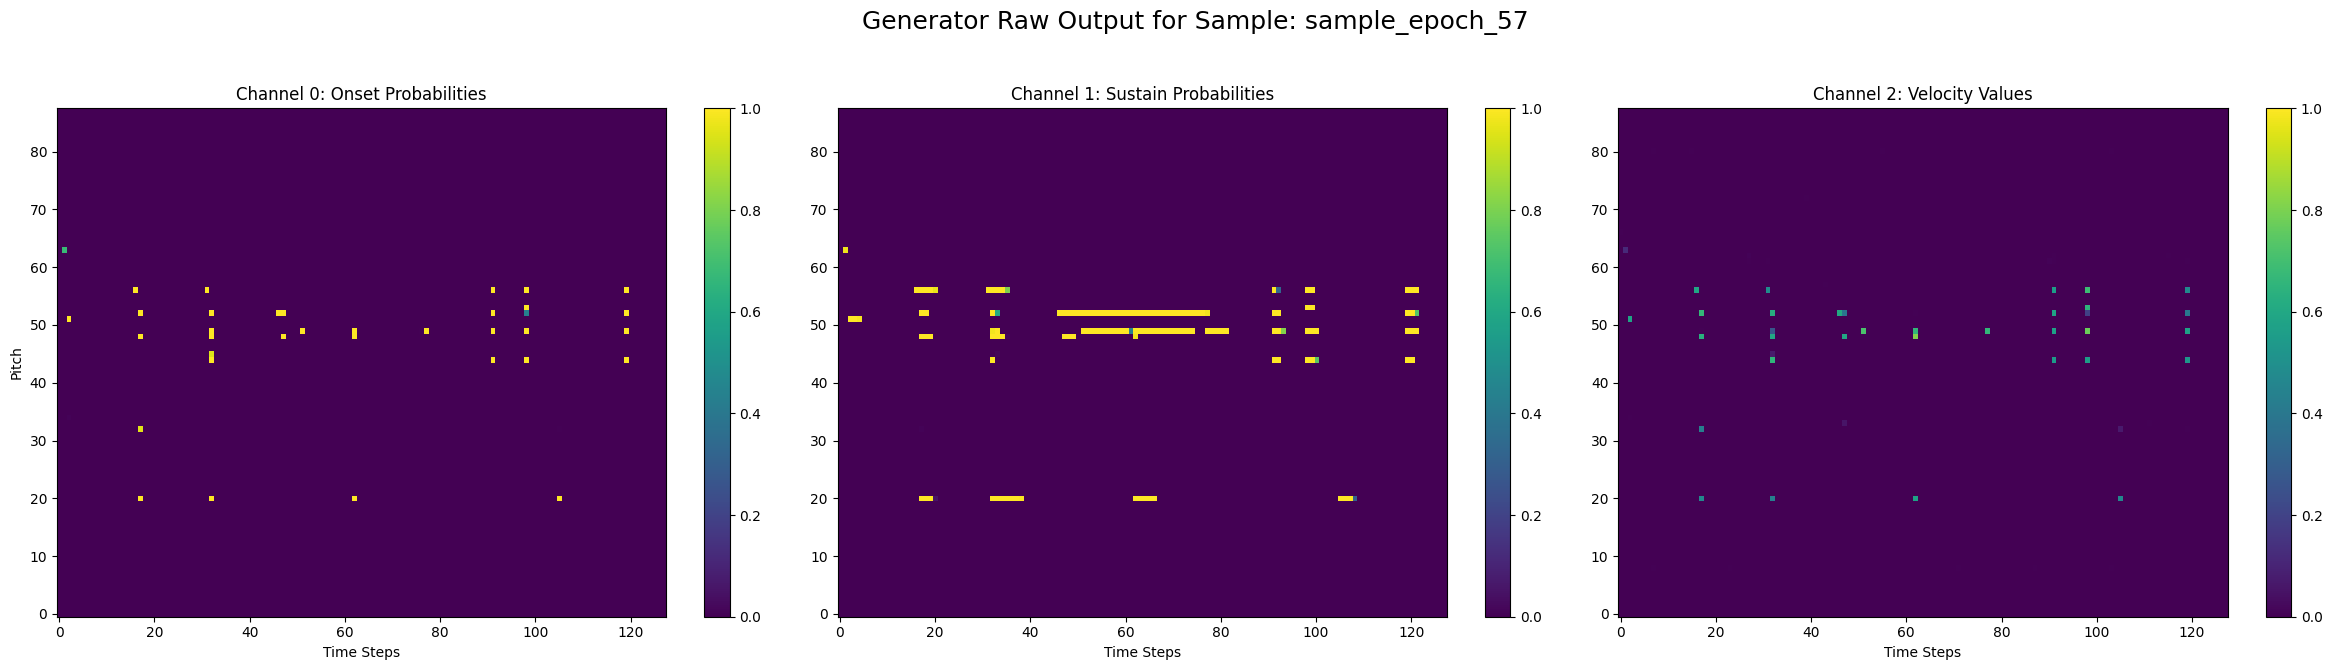

Adv. Epoch 58/100: 100%|██████████| 199/199 [03:57<00:00,  1.19s/it, D_Loss=0.5039, G_Loss=1.2595, Musicality=0.0570]



Adversarial Epoch 58 Summary:
  Generator Losses -> Total: 1.2687, GAN: 1.5611
  G Musicality -> Impossible: 0.0001, Silent: 0.0002 Orphan Velo: 0.0001, Min Rate: 0.0990
  Discriminator Loss -> Total: 0.5108 



Adv. Epoch 59/100: 100%|██████████| 199/199 [03:53<00:00,  1.17s/it, D_Loss=0.5111, G_Loss=1.2655, Musicality=0.0633]



Adversarial Epoch 59 Summary:
  Generator Losses -> Total: 1.2669, GAN: 1.5646
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0757
  Discriminator Loss -> Total: 0.5095 



Adv. Epoch 60/100: 100%|██████████| 199/199 [03:44<00:00,  1.13s/it, D_Loss=0.5043, G_Loss=1.3241, Musicality=0.0451]



Adversarial Epoch 60 Summary:
  Generator Losses -> Total: 1.2753, GAN: 1.5839
  G Musicality -> Impossible: 0.0004, Silent: 0.0004 Orphan Velo: 0.0004, Min Rate: 0.0399
  Discriminator Loss -> Total: 0.5070 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_60 ---


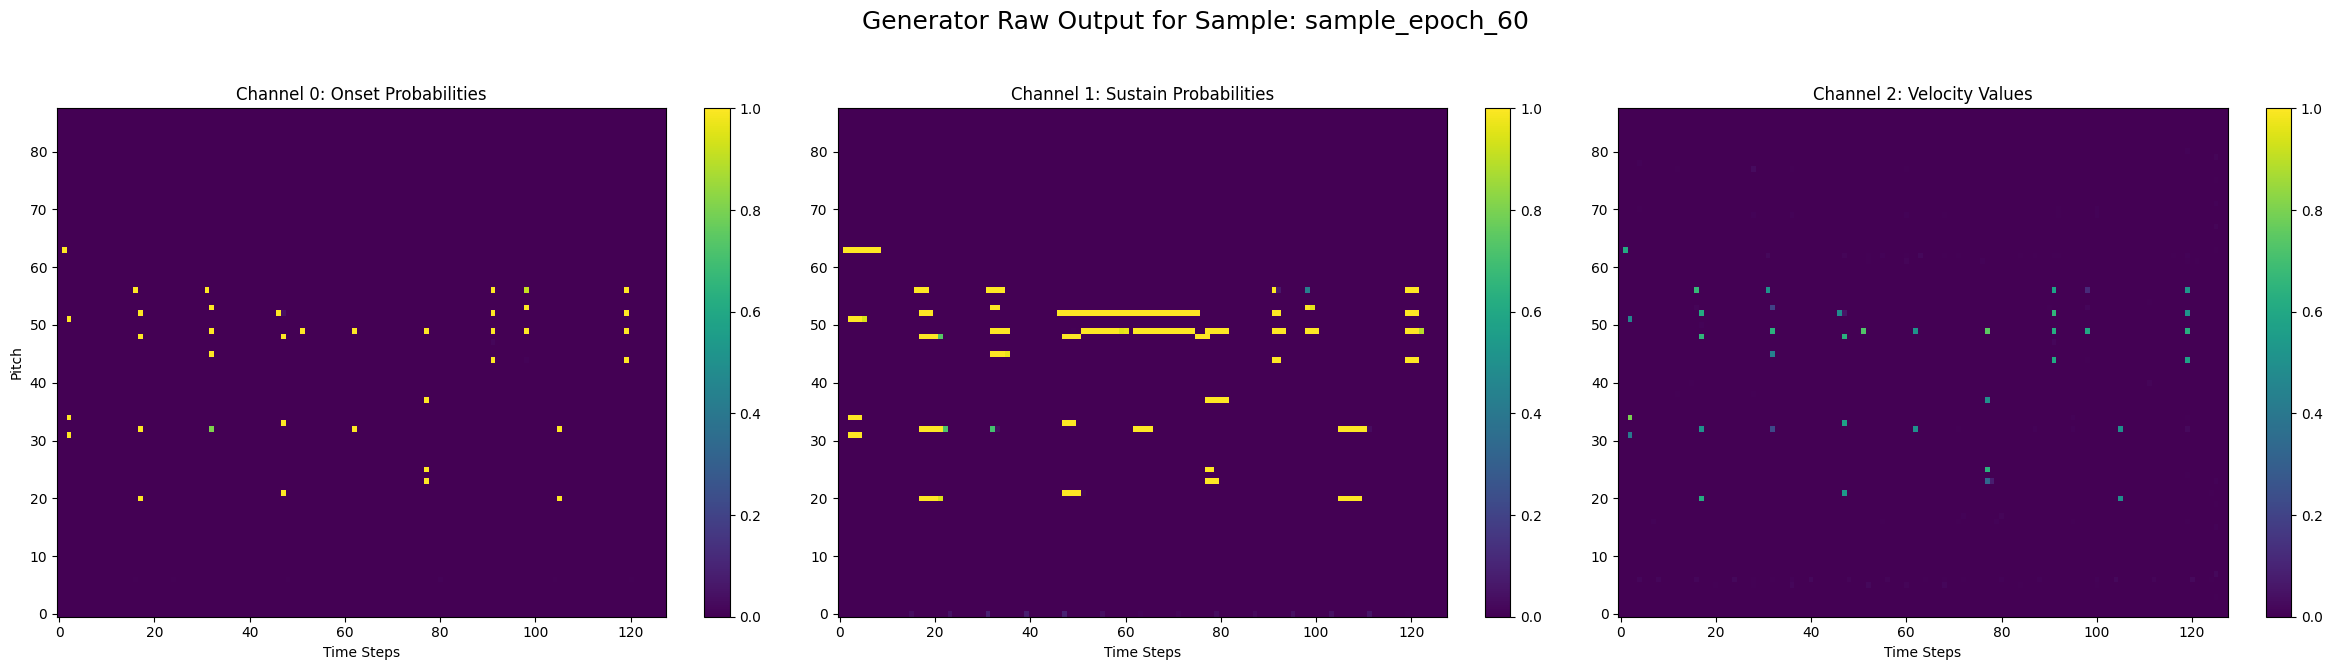

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_60.pth ---


Adv. Epoch 61/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5049, G_Loss=1.2137, Musicality=0.0843]



Adversarial Epoch 61 Summary:
  Generator Losses -> Total: 1.2755, GAN: 1.5852
  G Musicality -> Impossible: 0.0003, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0361
  Discriminator Loss -> Total: 0.5059 



Adv. Epoch 62/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5071, G_Loss=1.2852, Musicality=0.0341]



Adversarial Epoch 62 Summary:
  Generator Losses -> Total: 1.2585, GAN: 1.5569
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0641
  Discriminator Loss -> Total: 0.5117 



Adv. Epoch 63/100: 100%|██████████| 199/199 [03:46<00:00,  1.14s/it, D_Loss=0.5037, G_Loss=1.2180, Musicality=0.0362]



Adversarial Epoch 63 Summary:
  Generator Losses -> Total: 1.2606, GAN: 1.5645
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0440
  Discriminator Loss -> Total: 0.5105 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_63 ---


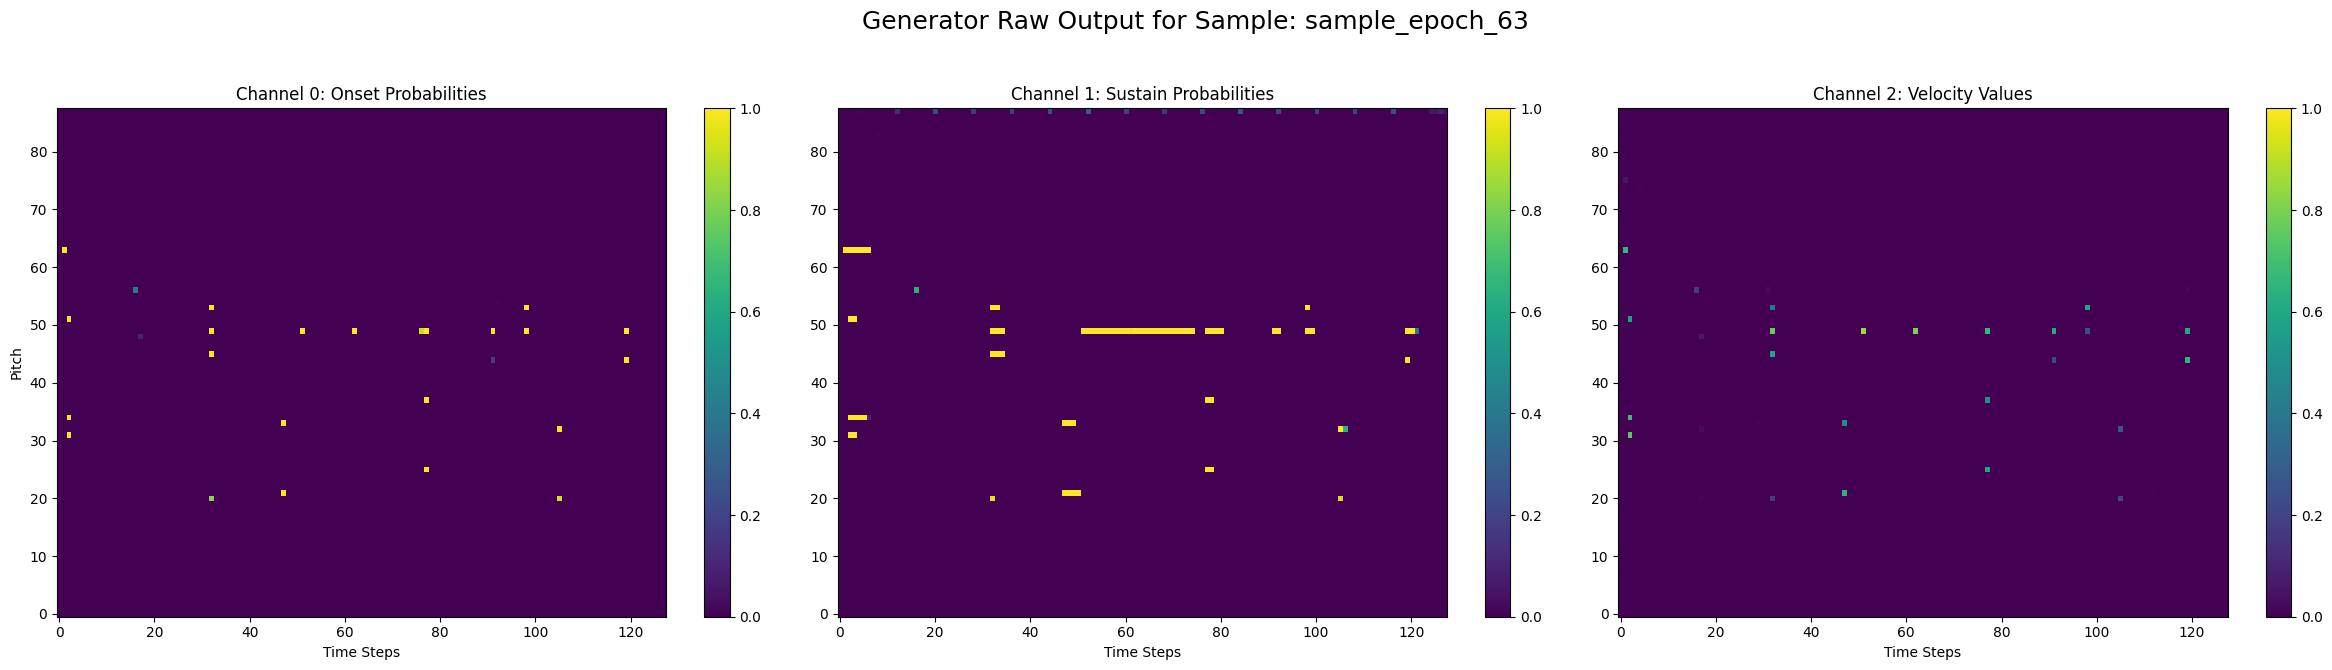

Adv. Epoch 64/100: 100%|██████████| 199/199 [03:58<00:00,  1.20s/it, D_Loss=0.5058, G_Loss=1.3051, Musicality=0.0436]



Adversarial Epoch 64 Summary:
  Generator Losses -> Total: 1.2688, GAN: 1.5739
  G Musicality -> Impossible: 0.0002, Silent: 0.0002 Orphan Velo: 0.0002, Min Rate: 0.0478
  Discriminator Loss -> Total: 0.5081 



Adv. Epoch 65/100: 100%|██████████| 199/199 [04:01<00:00,  1.22s/it, D_Loss=0.5261, G_Loss=1.1489, Musicality=0.0593]



Adversarial Epoch 65 Summary:
  Generator Losses -> Total: 1.2617, GAN: 1.5662
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0431
  Discriminator Loss -> Total: 0.5102 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_65.pth ---


Adv. Epoch 66/100: 100%|██████████| 199/199 [03:55<00:00,  1.18s/it, D_Loss=0.5102, G_Loss=1.2639, Musicality=0.1213]



Adversarial Epoch 66 Summary:
  Generator Losses -> Total: 1.2199, GAN: 1.5030
  G Musicality -> Impossible: 0.0002, Silent: 0.0006 Orphan Velo: 0.0002, Min Rate: 0.0868
  Discriminator Loss -> Total: 0.5246 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_66 ---


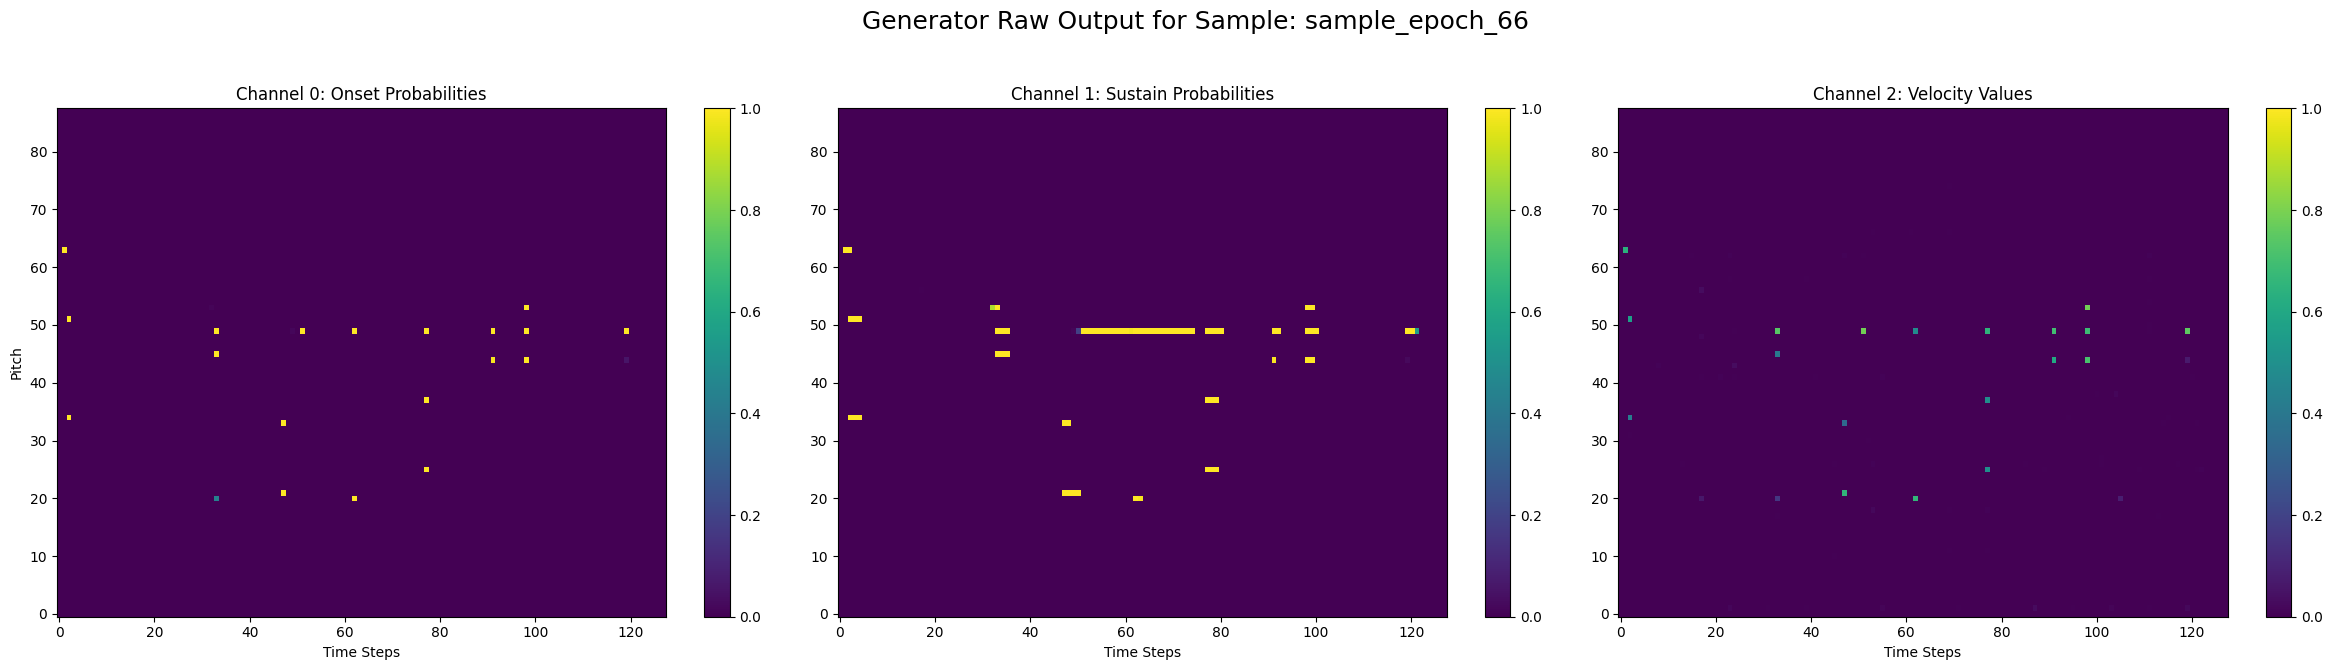

Adv. Epoch 67/100: 100%|██████████| 199/199 [03:57<00:00,  1.19s/it, D_Loss=0.5042, G_Loss=1.2825, Musicality=0.0260]



Adversarial Epoch 67 Summary:
  Generator Losses -> Total: 1.2692, GAN: 1.5730
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0003, Min Rate: 0.0535
  Discriminator Loss -> Total: 0.5085 



Adv. Epoch 68/100: 100%|██████████| 199/199 [03:58<00:00,  1.20s/it, D_Loss=0.5076, G_Loss=1.2749, Musicality=0.0352]



Adversarial Epoch 68 Summary:
  Generator Losses -> Total: 1.2720, GAN: 1.5817
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0328
  Discriminator Loss -> Total: 0.5068 



Adv. Epoch 69/100: 100%|██████████| 199/199 [03:58<00:00,  1.20s/it, D_Loss=0.5044, G_Loss=1.2724, Musicality=0.0344]



Adversarial Epoch 69 Summary:
  Generator Losses -> Total: 1.2707, GAN: 1.5805
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0312
  Discriminator Loss -> Total: 0.5069 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_69 ---


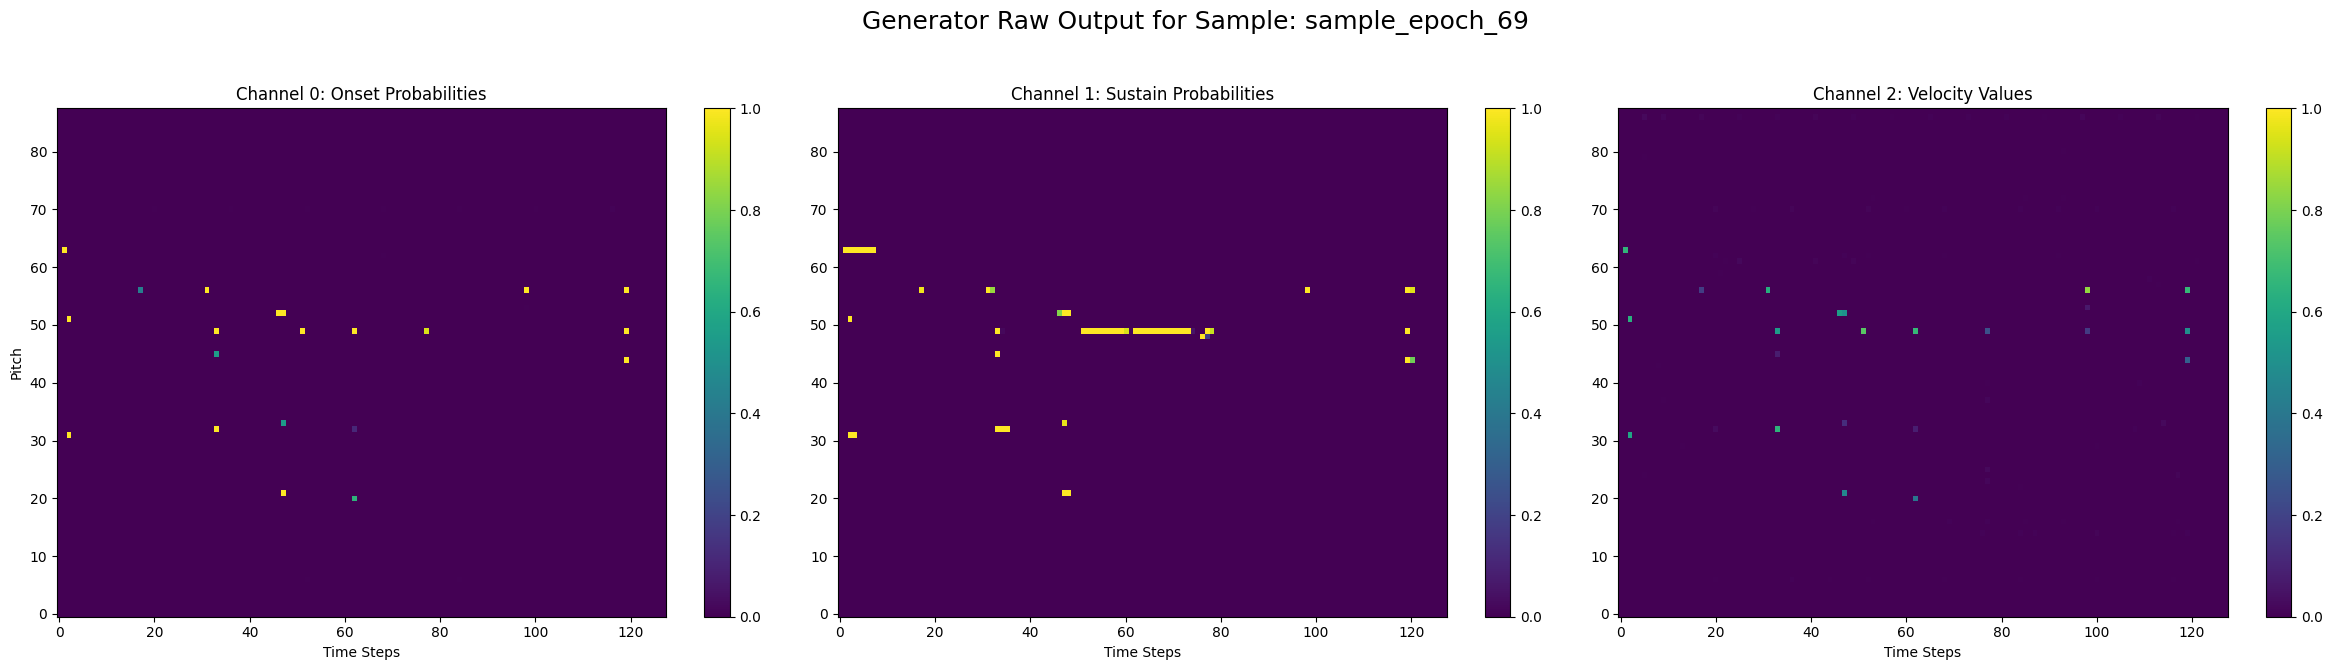

Adv. Epoch 70/100: 100%|██████████| 199/199 [04:01<00:00,  1.21s/it, D_Loss=0.5051, G_Loss=1.2805, Musicality=0.0314]



Adversarial Epoch 70 Summary:
  Generator Losses -> Total: 1.2725, GAN: 1.5834
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0286
  Discriminator Loss -> Total: 0.5068 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_70.pth ---


Adv. Epoch 71/100: 100%|██████████| 199/199 [03:59<00:00,  1.20s/it, D_Loss=0.5063, G_Loss=1.2496, Musicality=0.0237]



Adversarial Epoch 71 Summary:
  Generator Losses -> Total: 1.2760, GAN: 1.5882
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0265
  Discriminator Loss -> Total: 0.5061 



Adv. Epoch 72/100: 100%|██████████| 199/199 [03:57<00:00,  1.19s/it, D_Loss=0.5044, G_Loss=1.2885, Musicality=0.0470]



Adversarial Epoch 72 Summary:
  Generator Losses -> Total: 1.2720, GAN: 1.5807
  G Musicality -> Impossible: 0.0003, Silent: 0.0003 Orphan Velo: 0.0003, Min Rate: 0.0370
  Discriminator Loss -> Total: 0.5069 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_72 ---


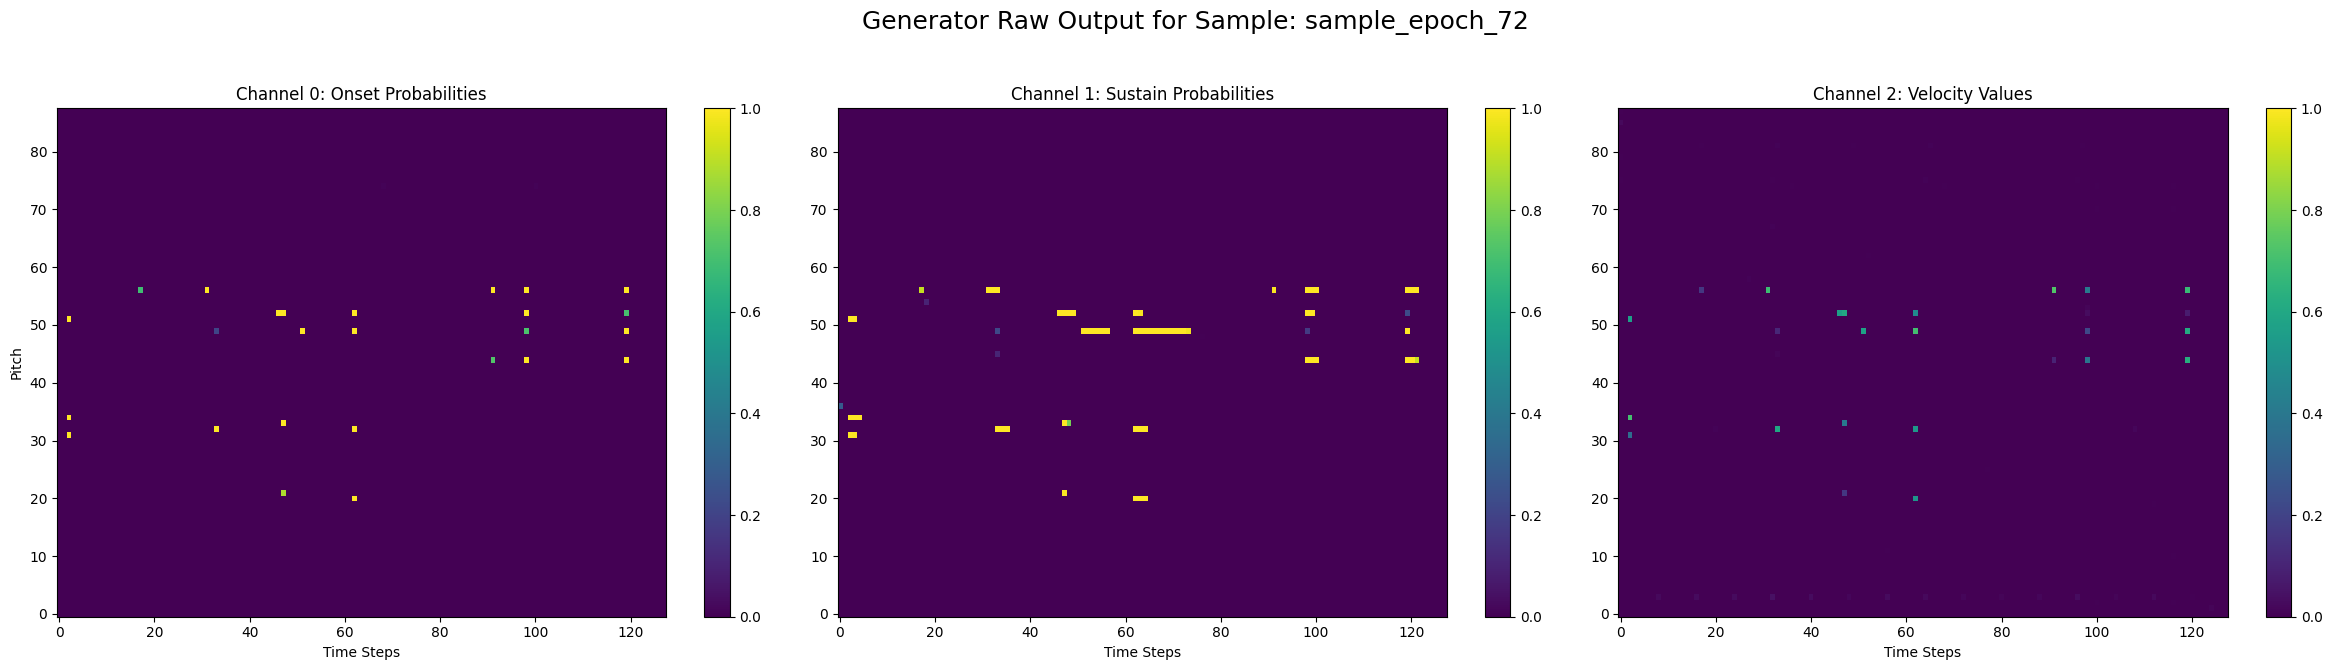

Adv. Epoch 73/100: 100%|██████████| 199/199 [03:58<00:00,  1.20s/it, D_Loss=0.5029, G_Loss=1.2682, Musicality=0.0391]



Adversarial Epoch 73 Summary:
  Generator Losses -> Total: 1.2733, GAN: 1.5814
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0403
  Discriminator Loss -> Total: 0.5067 



Adv. Epoch 74/100: 100%|██████████| 199/199 [03:58<00:00,  1.20s/it, D_Loss=0.5065, G_Loss=1.2439, Musicality=0.0543]



Adversarial Epoch 74 Summary:
  Generator Losses -> Total: 1.2756, GAN: 1.5860
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0334
  Discriminator Loss -> Total: 0.5068 



Adv. Epoch 75/100: 100%|██████████| 199/199 [04:05<00:00,  1.23s/it, D_Loss=0.5073, G_Loss=1.2504, Musicality=0.0187]



Adversarial Epoch 75 Summary:
  Generator Losses -> Total: 1.2694, GAN: 1.5760
  G Musicality -> Impossible: 0.0004, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0423
  Discriminator Loss -> Total: 0.5095 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_75 ---


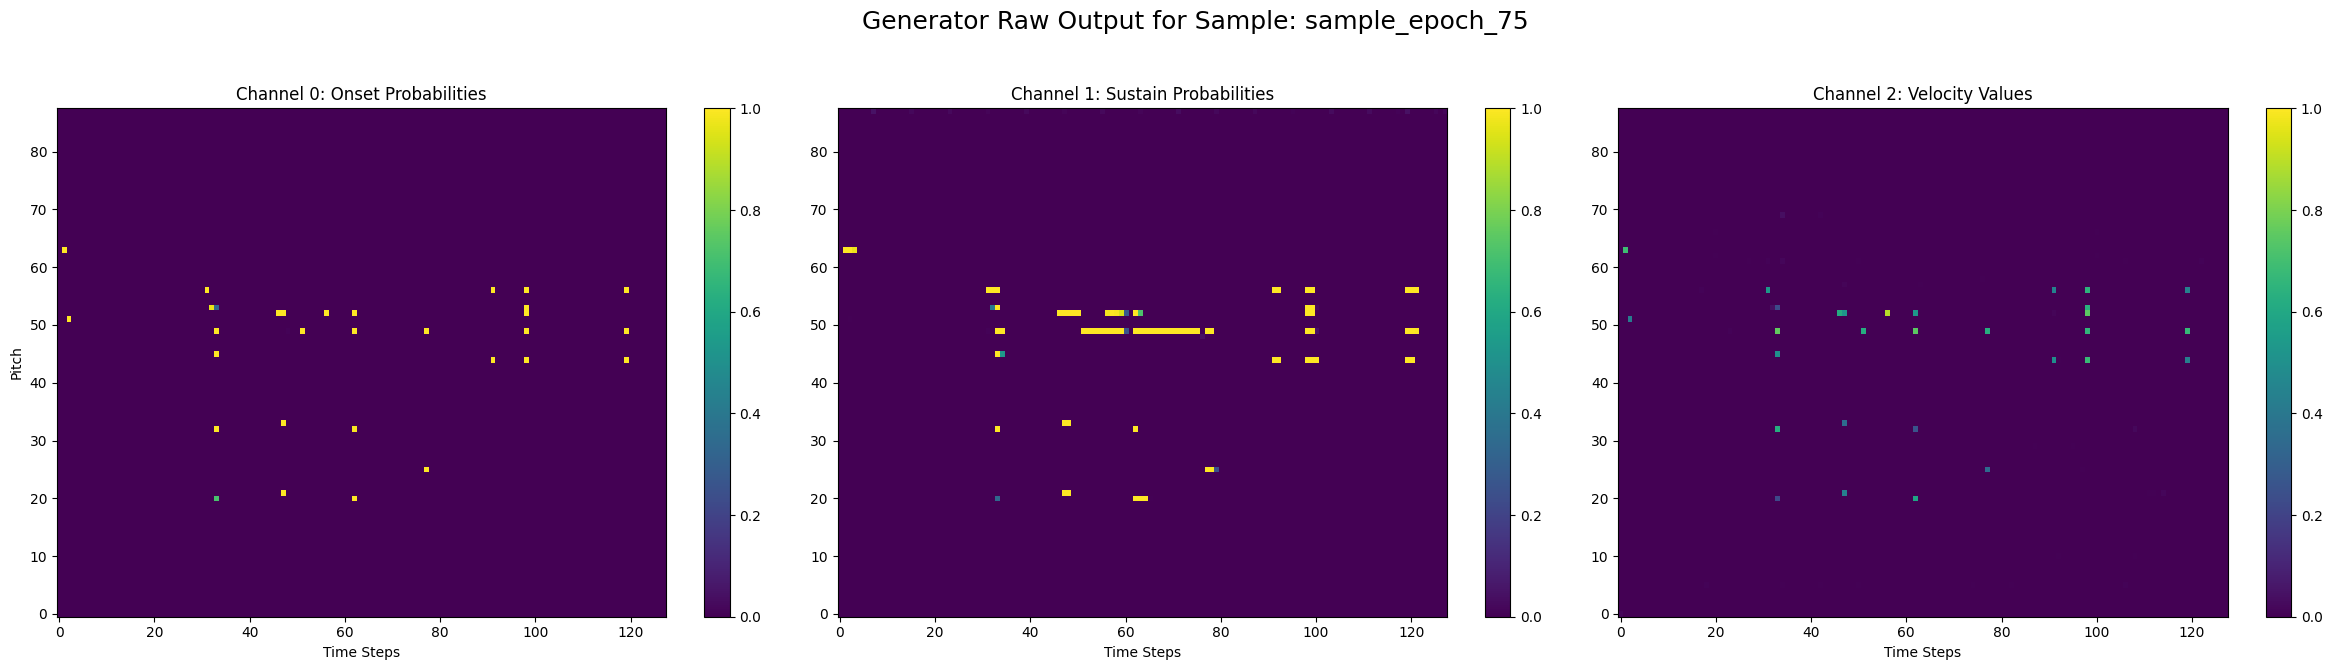

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_75.pth ---


Adv. Epoch 76/100: 100%|██████████| 199/199 [04:01<00:00,  1.22s/it, D_Loss=0.5037, G_Loss=1.2666, Musicality=0.0343]



Adversarial Epoch 76 Summary:
  Generator Losses -> Total: 1.2518, GAN: 1.5533
  G Musicality -> Impossible: 0.0001, Silent: 0.0005 Orphan Velo: 0.0001, Min Rate: 0.0453
  Discriminator Loss -> Total: 0.5132 



Adv. Epoch 77/100: 100%|██████████| 199/199 [04:02<00:00,  1.22s/it, D_Loss=0.5186, G_Loss=1.3209, Musicality=0.0351]



Adversarial Epoch 77 Summary:
  Generator Losses -> Total: 1.2733, GAN: 1.5834
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0323
  Discriminator Loss -> Total: 0.5067 



Adv. Epoch 78/100: 100%|██████████| 199/199 [04:01<00:00,  1.22s/it, D_Loss=0.5045, G_Loss=1.2696, Musicality=0.0216]



Adversarial Epoch 78 Summary:
  Generator Losses -> Total: 1.2705, GAN: 1.5787
  G Musicality -> Impossible: 0.0005, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0367
  Discriminator Loss -> Total: 0.5078 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_78 ---


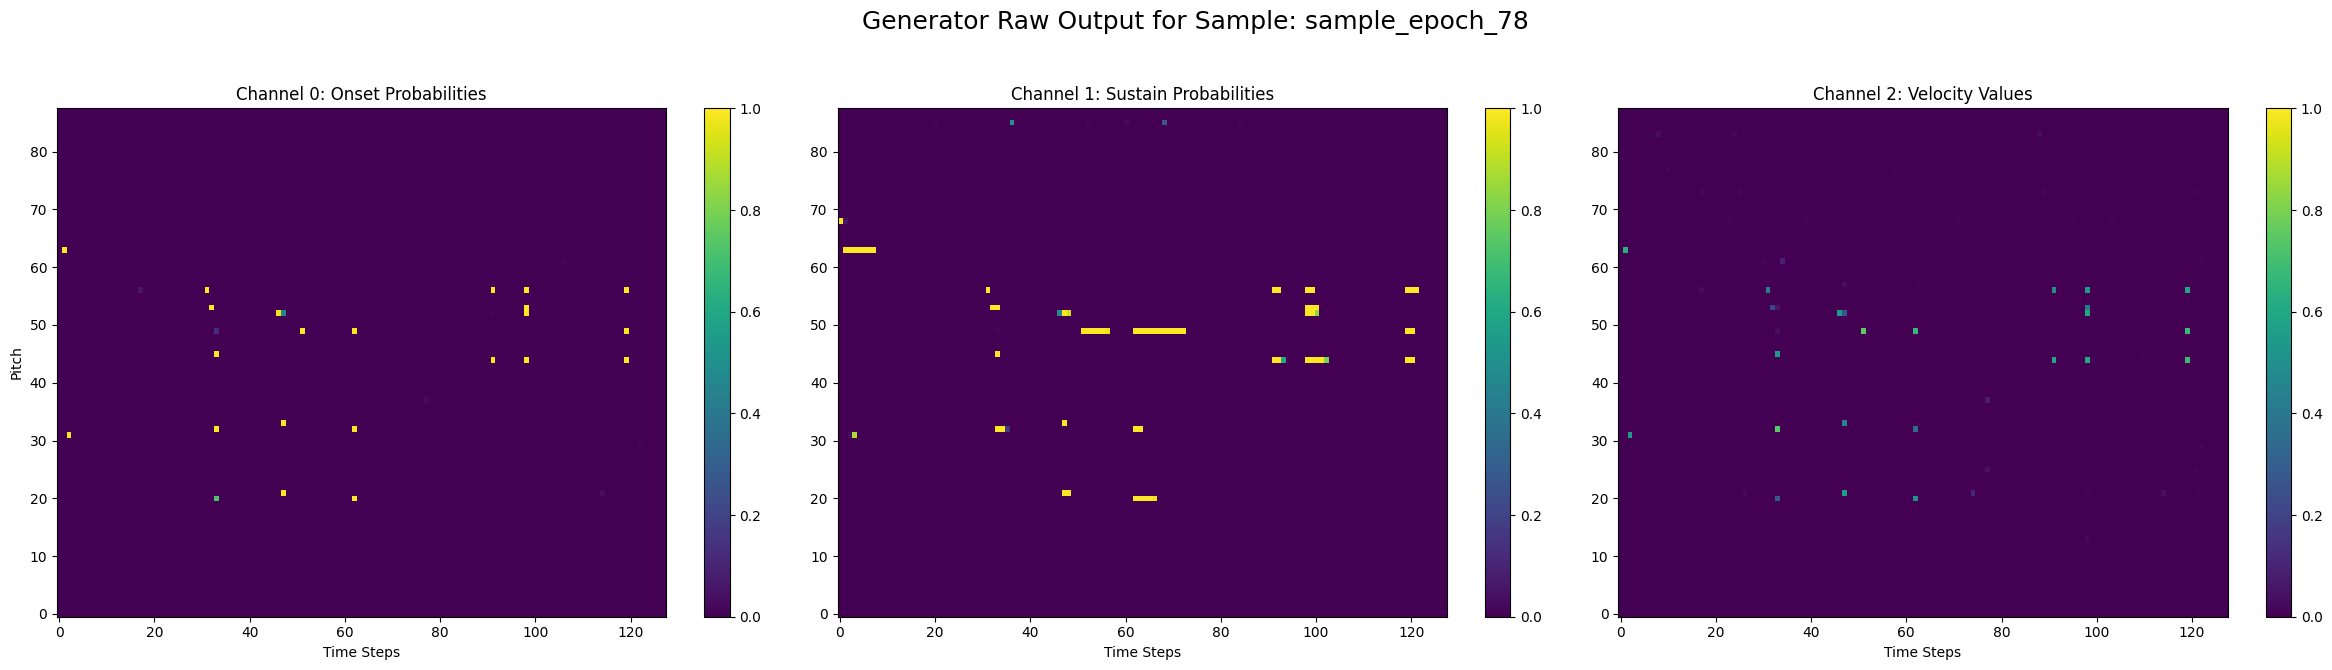

Adv. Epoch 79/100: 100%|██████████| 199/199 [04:08<00:00,  1.25s/it, D_Loss=0.5060, G_Loss=1.2754, Musicality=0.0440]



Adversarial Epoch 79 Summary:
  Generator Losses -> Total: 1.2678, GAN: 1.5748
  G Musicality -> Impossible: 0.0009, Silent: 0.0007 Orphan Velo: 0.0004, Min Rate: 0.0388
  Discriminator Loss -> Total: 0.5086 



Adv. Epoch 80/100: 100%|██████████| 199/199 [04:09<00:00,  1.26s/it, D_Loss=0.5059, G_Loss=1.3062, Musicality=0.0731]



Adversarial Epoch 80 Summary:
  Generator Losses -> Total: 1.2701, GAN: 1.5782
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0367
  Discriminator Loss -> Total: 0.5076 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_80.pth ---


Adv. Epoch 81/100: 100%|██████████| 199/199 [04:03<00:00,  1.22s/it, D_Loss=0.5051, G_Loss=1.2894, Musicality=0.0142]



Adversarial Epoch 81 Summary:
  Generator Losses -> Total: 1.2752, GAN: 1.5853
  G Musicality -> Impossible: 0.0003, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0343
  Discriminator Loss -> Total: 0.5057 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_81 ---


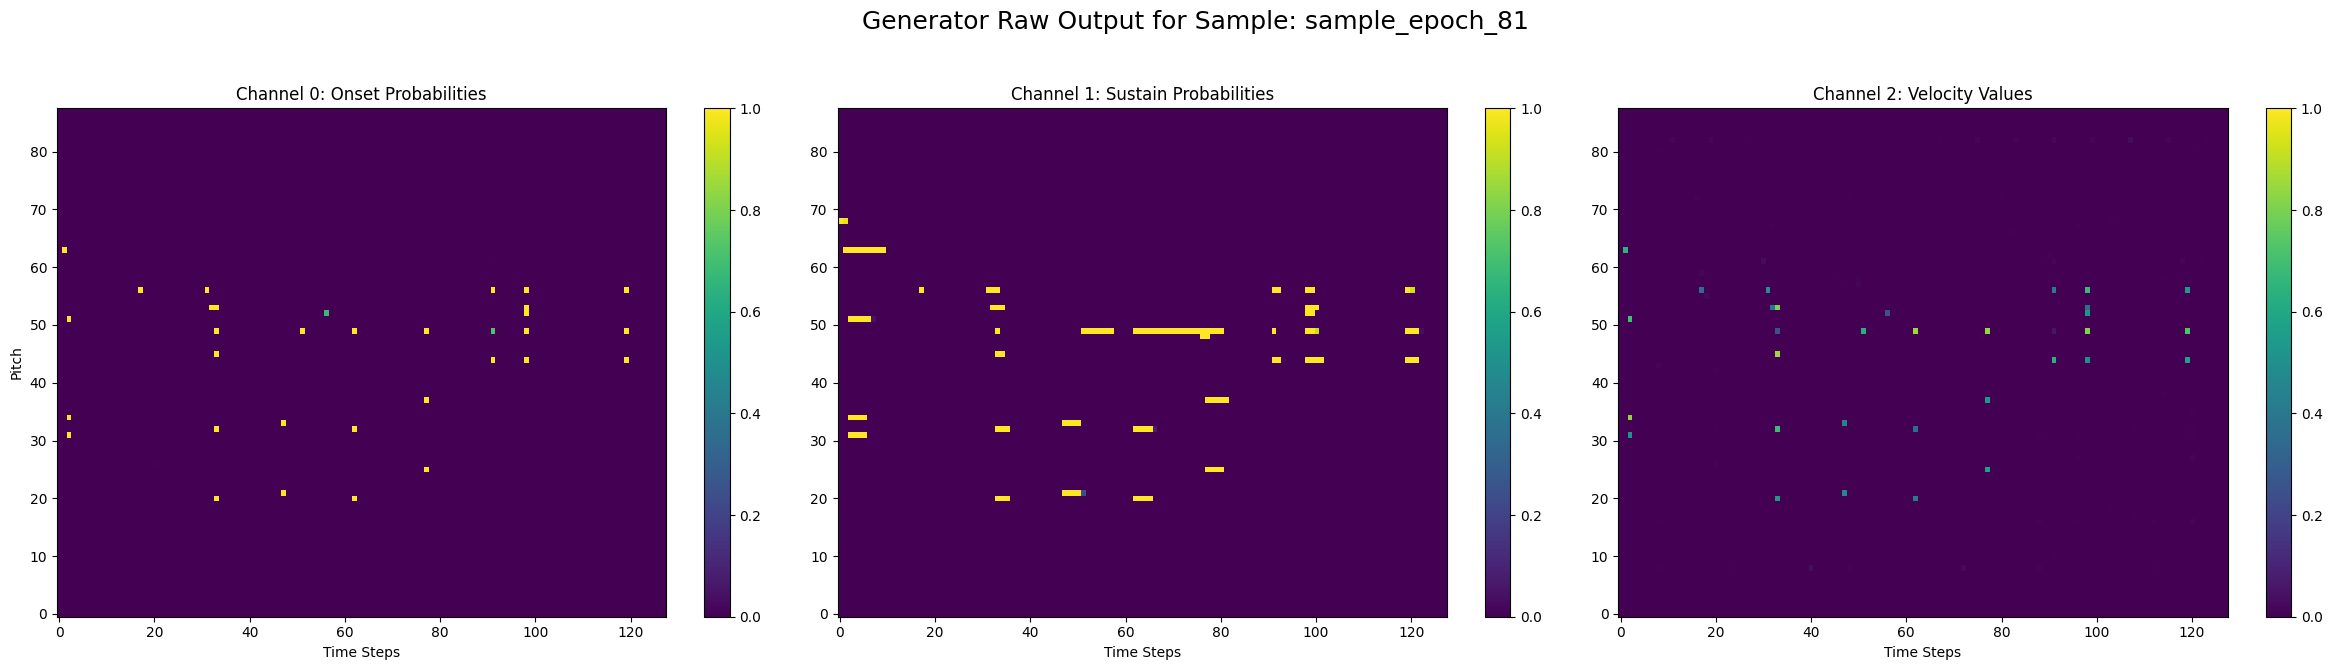

Adv. Epoch 82/100: 100%|██████████| 199/199 [04:01<00:00,  1.21s/it, D_Loss=0.5041, G_Loss=1.2787, Musicality=0.0590]



Adversarial Epoch 82 Summary:
  Generator Losses -> Total: 1.2785, GAN: 1.5881
  G Musicality -> Impossible: 0.0003, Silent: 0.0003 Orphan Velo: 0.0003, Min Rate: 0.0395
  Discriminator Loss -> Total: 0.5058 



Adv. Epoch 83/100: 100%|██████████| 199/199 [04:00<00:00,  1.21s/it, D_Loss=0.5032, G_Loss=1.3104, Musicality=0.0340]



Adversarial Epoch 83 Summary:
  Generator Losses -> Total: 1.2821, GAN: 1.5908
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0003, Min Rate: 0.0467
  Discriminator Loss -> Total: 0.5047 



Adv. Epoch 84/100: 100%|██████████| 199/199 [04:02<00:00,  1.22s/it, D_Loss=0.5039, G_Loss=1.3230, Musicality=0.0459]



Adversarial Epoch 84 Summary:
  Generator Losses -> Total: 1.2793, GAN: 1.5910
  G Musicality -> Impossible: 0.0004, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0317
  Discriminator Loss -> Total: 0.5049 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_84 ---


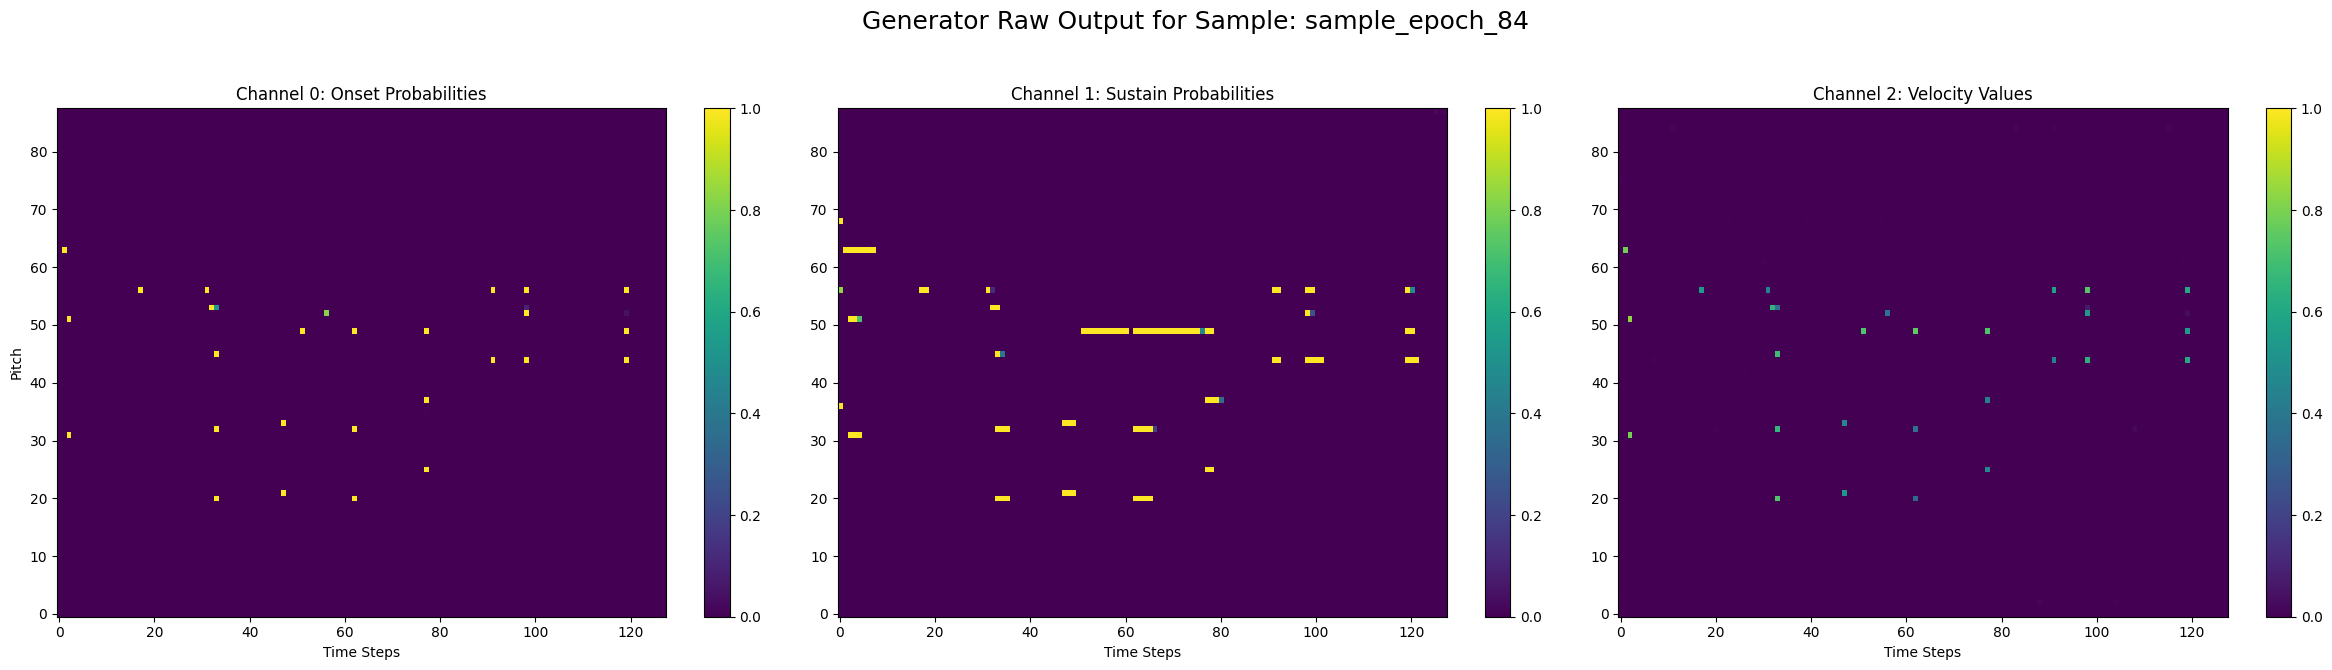

Adv. Epoch 85/100: 100%|██████████| 199/199 [04:01<00:00,  1.22s/it, D_Loss=0.5037, G_Loss=1.2725, Musicality=0.0091]



Adversarial Epoch 85 Summary:
  Generator Losses -> Total: 1.2797, GAN: 1.5928
  G Musicality -> Impossible: 0.0003, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0267
  Discriminator Loss -> Total: 0.5047 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_85.pth ---


Adv. Epoch 86/100: 100%|██████████| 199/199 [03:58<00:00,  1.20s/it, D_Loss=0.5063, G_Loss=1.2548, Musicality=0.0268]



Adversarial Epoch 86 Summary:
  Generator Losses -> Total: 1.2741, GAN: 1.5864
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0246
  Discriminator Loss -> Total: 0.5060 



Adv. Epoch 87/100: 100%|██████████| 199/199 [04:03<00:00,  1.23s/it, D_Loss=0.5051, G_Loss=1.2944, Musicality=0.0094]



Adversarial Epoch 87 Summary:
  Generator Losses -> Total: 1.2709, GAN: 1.5820
  G Musicality -> Impossible: 0.0003, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0256
  Discriminator Loss -> Total: 0.5068 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_87 ---


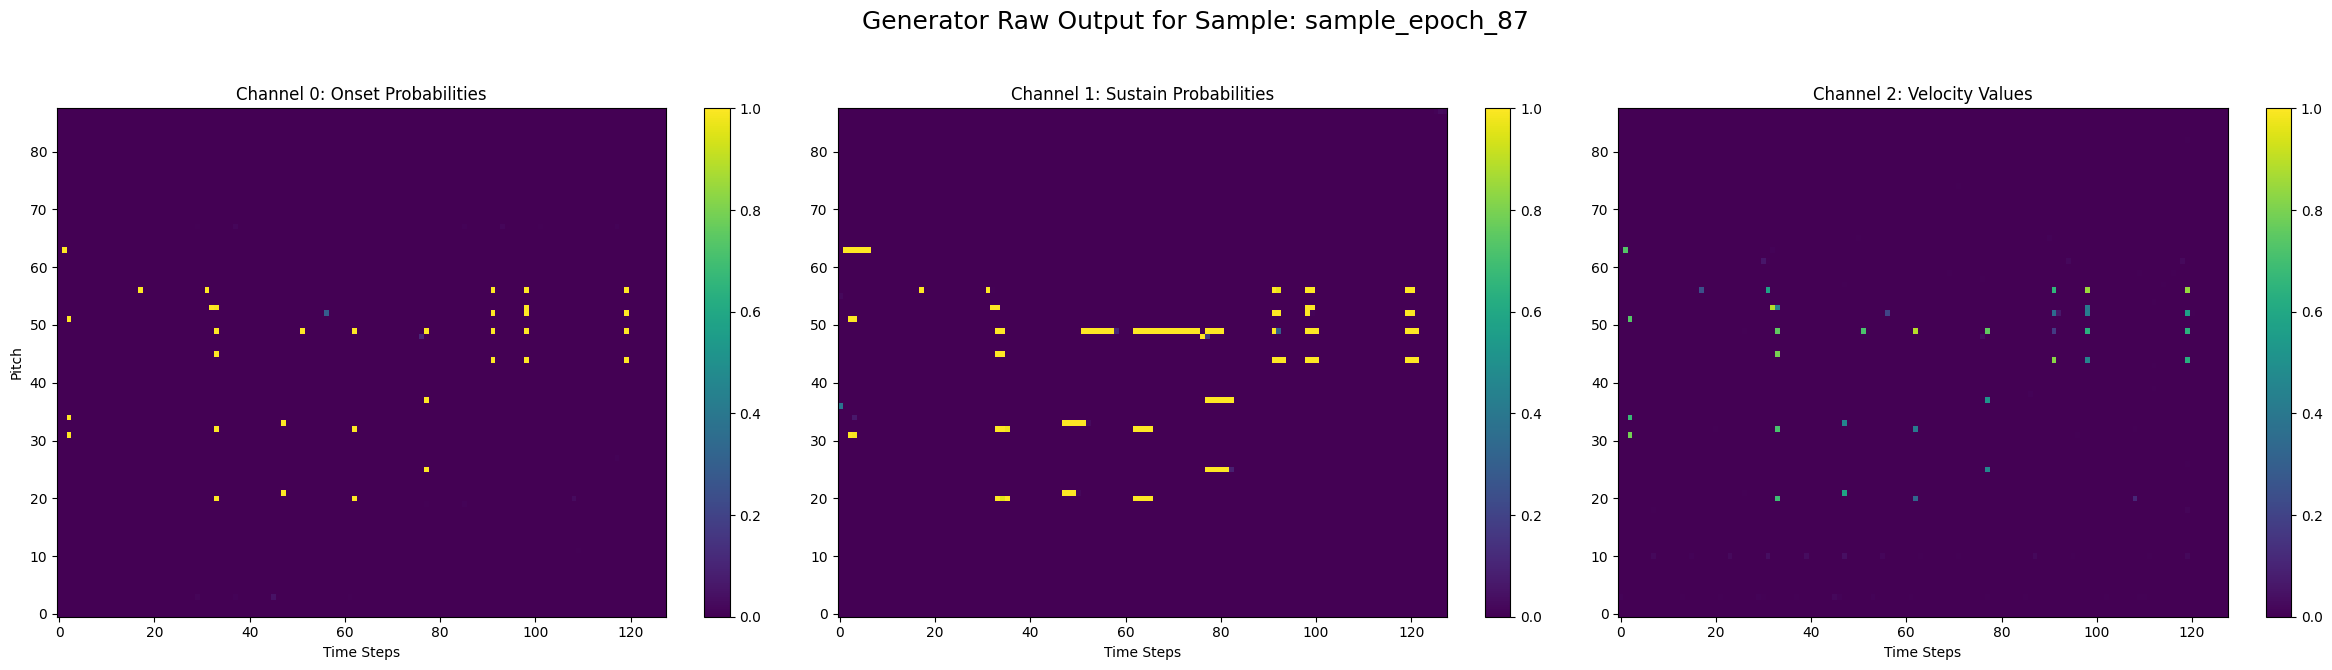

Adv. Epoch 88/100: 100%|██████████| 199/199 [04:00<00:00,  1.21s/it, D_Loss=0.5029, G_Loss=1.2870, Musicality=0.0129]



Adversarial Epoch 88 Summary:
  Generator Losses -> Total: 1.2778, GAN: 1.5923
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0192
  Discriminator Loss -> Total: 0.5047 



Adv. Epoch 89/100: 100%|██████████| 199/199 [03:59<00:00,  1.21s/it, D_Loss=0.5083, G_Loss=1.3088, Musicality=0.0203]



Adversarial Epoch 89 Summary:
  Generator Losses -> Total: 1.2723, GAN: 1.5833
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0004, Min Rate: 0.0274
  Discriminator Loss -> Total: 0.5068 



Adv. Epoch 90/100: 100%|██████████| 199/199 [03:59<00:00,  1.20s/it, D_Loss=0.5142, G_Loss=1.2653, Musicality=0.0149]



Adversarial Epoch 90 Summary:
  Generator Losses -> Total: 1.2709, GAN: 1.5794
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0361
  Discriminator Loss -> Total: 0.5071 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_90 ---


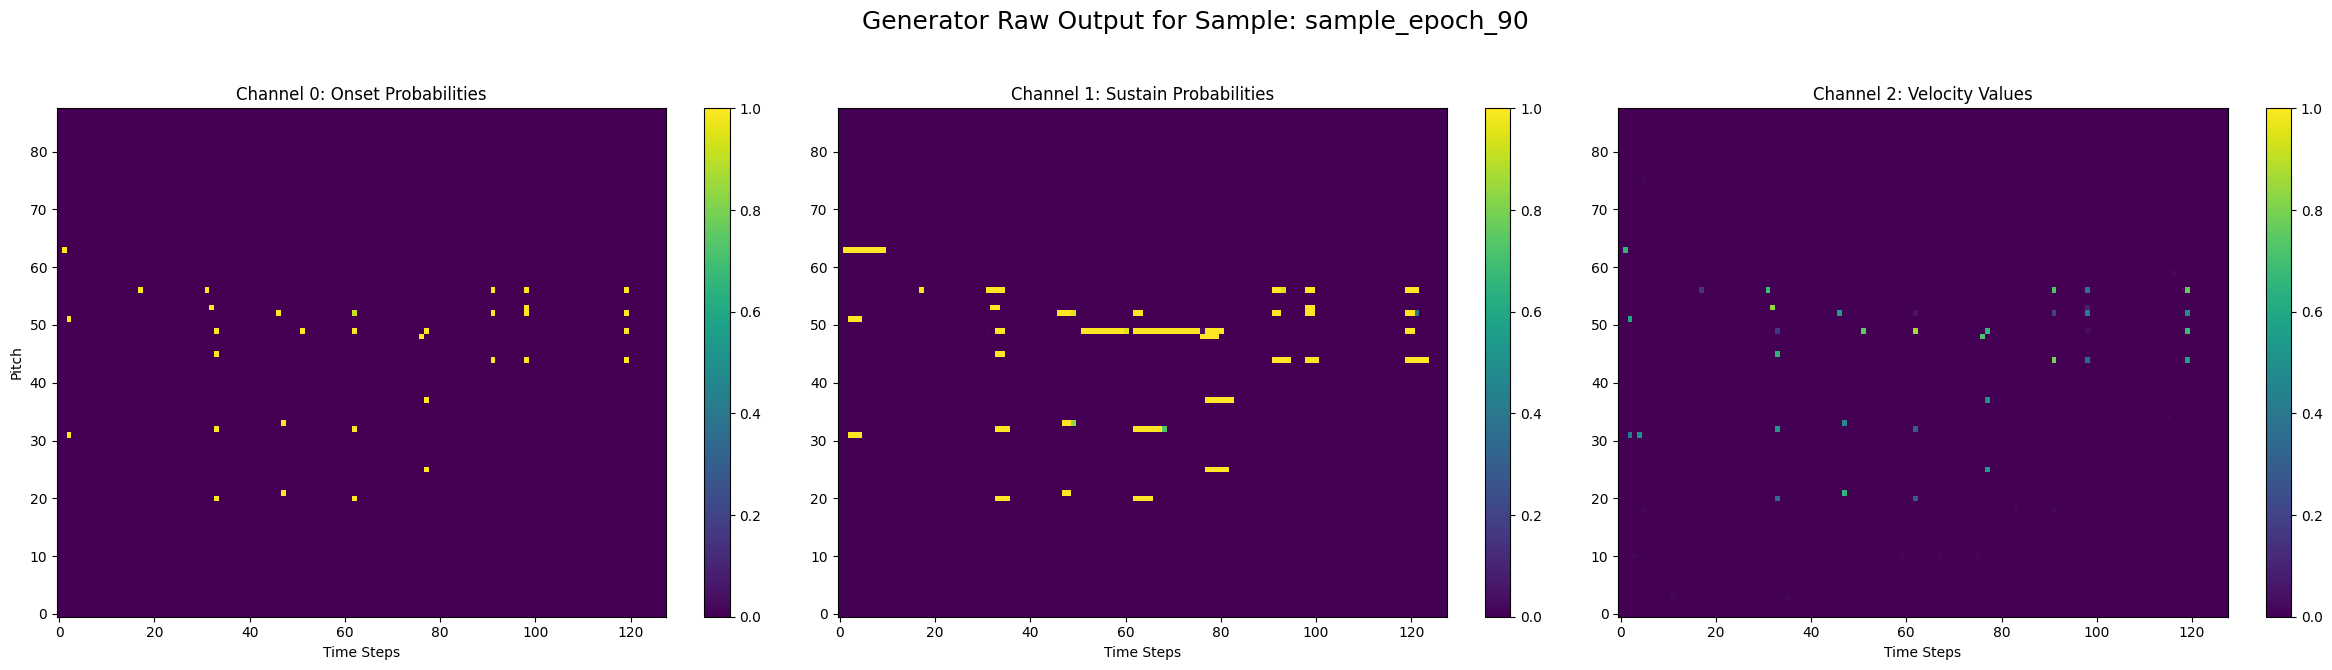

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_90.pth ---


Adv. Epoch 91/100: 100%|██████████| 199/199 [04:02<00:00,  1.22s/it, D_Loss=0.5026, G_Loss=1.2718, Musicality=0.0292]



Adversarial Epoch 91 Summary:
  Generator Losses -> Total: 1.2677, GAN: 1.5777
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0267
  Discriminator Loss -> Total: 0.5075 



Adv. Epoch 92/100: 100%|██████████| 199/199 [04:01<00:00,  1.22s/it, D_Loss=0.5181, G_Loss=1.2634, Musicality=0.0816]



Adversarial Epoch 92 Summary:
  Generator Losses -> Total: 1.2519, GAN: 1.5521
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0505
  Discriminator Loss -> Total: 0.5134 



Adv. Epoch 93/100: 100%|██████████| 199/199 [04:01<00:00,  1.21s/it, D_Loss=0.5053, G_Loss=1.2882, Musicality=0.0779]



Adversarial Epoch 93 Summary:
  Generator Losses -> Total: 1.2754, GAN: 1.5815
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0506
  Discriminator Loss -> Total: 0.5066 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_93 ---


Adv. Epoch 94/100: 100%|██████████| 199/199 [03:58<00:00,  1.20s/it, D_Loss=0.5038, G_Loss=1.2927, Musicality=0.0386]



Adversarial Epoch 94 Summary:
  Generator Losses -> Total: 1.2810, GAN: 1.5887
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0499
  Discriminator Loss -> Total: 0.5044 



Adv. Epoch 95/100: 100%|██████████| 199/199 [04:00<00:00,  1.21s/it, D_Loss=0.5025, G_Loss=1.2742, Musicality=0.0237]



Adversarial Epoch 95 Summary:
  Generator Losses -> Total: 1.2779, GAN: 1.5906
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0266
  Discriminator Loss -> Total: 0.5041 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_95.pth ---


Adv. Epoch 96/100: 100%|██████████| 199/199 [04:00<00:00,  1.21s/it, D_Loss=0.5026, G_Loss=1.2838, Musicality=0.0051]



Adversarial Epoch 96 Summary:
  Generator Losses -> Total: 1.2803, GAN: 1.5967
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0138
  Discriminator Loss -> Total: 0.5038 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_96 ---


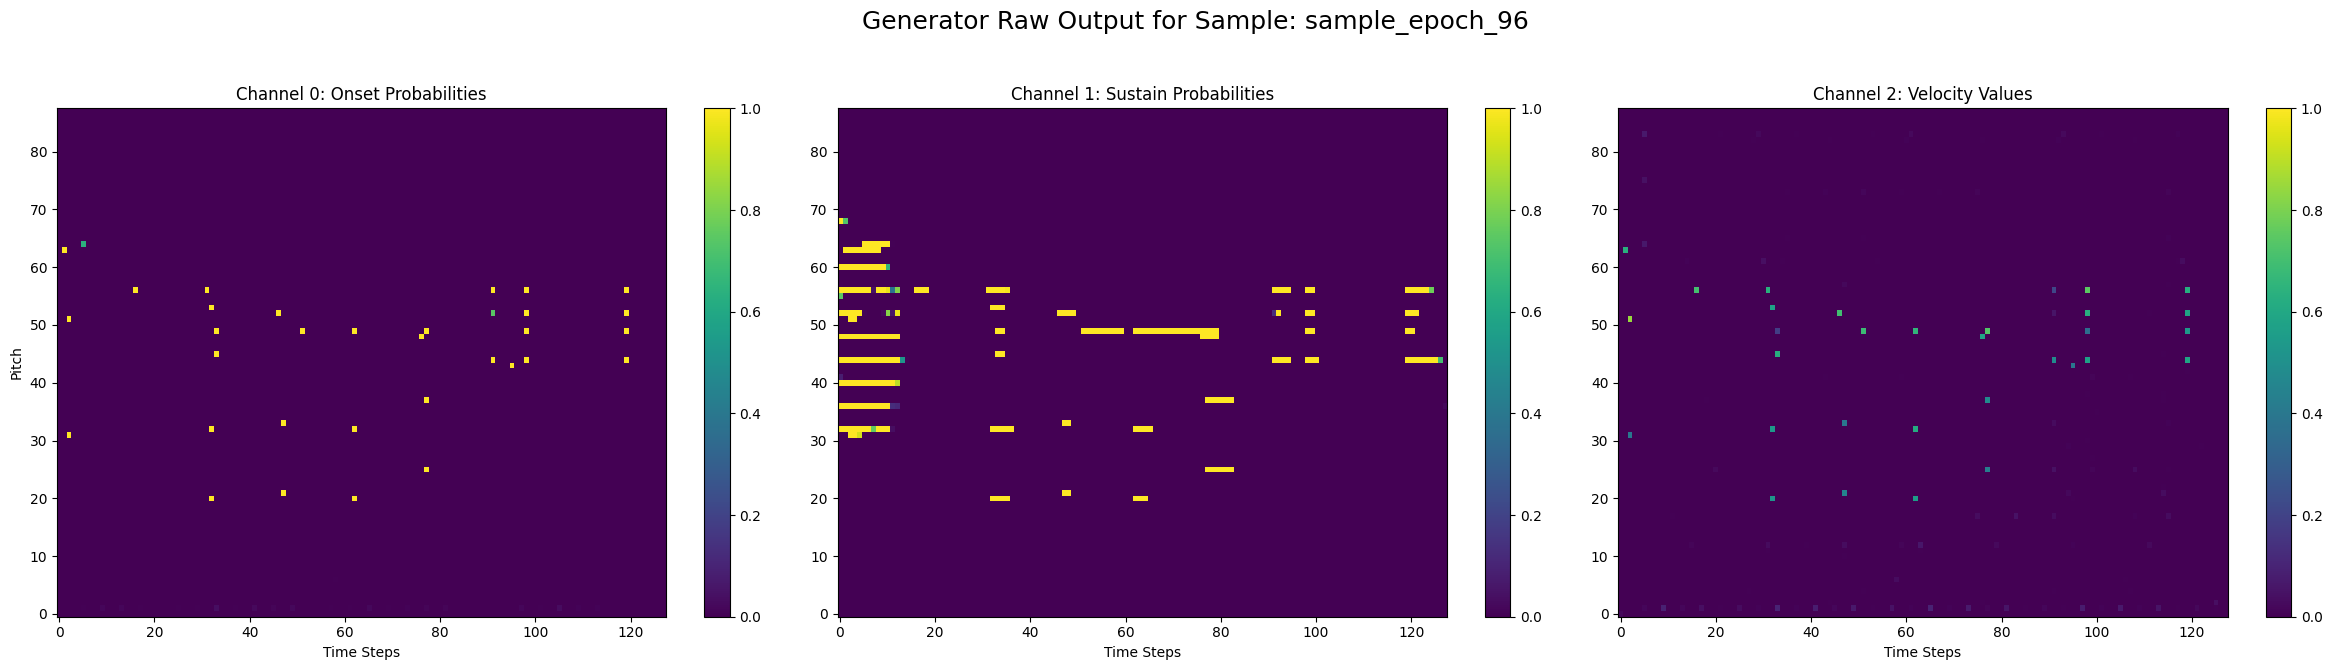

Adv. Epoch 97/100: 100%|██████████| 199/199 [04:02<00:00,  1.22s/it, D_Loss=0.5035, G_Loss=1.2518, Musicality=0.0173]



Adversarial Epoch 97 Summary:
  Generator Losses -> Total: 1.2770, GAN: 1.5896
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0262
  Discriminator Loss -> Total: 0.5055 



Adv. Epoch 98/100: 100%|██████████| 199/199 [04:00<00:00,  1.21s/it, D_Loss=0.5044, G_Loss=1.2686, Musicality=0.0245]



Adversarial Epoch 98 Summary:
  Generator Losses -> Total: 1.2760, GAN: 1.5893
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0225
  Discriminator Loss -> Total: 0.5054 



Adv. Epoch 99/100: 100%|██████████| 199/199 [04:02<00:00,  1.22s/it, D_Loss=0.5030, G_Loss=1.2543, Musicality=0.0172]



Adversarial Epoch 99 Summary:
  Generator Losses -> Total: 1.2770, GAN: 1.5901
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0003, Min Rate: 0.0238
  Discriminator Loss -> Total: 0.5053 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_99 ---


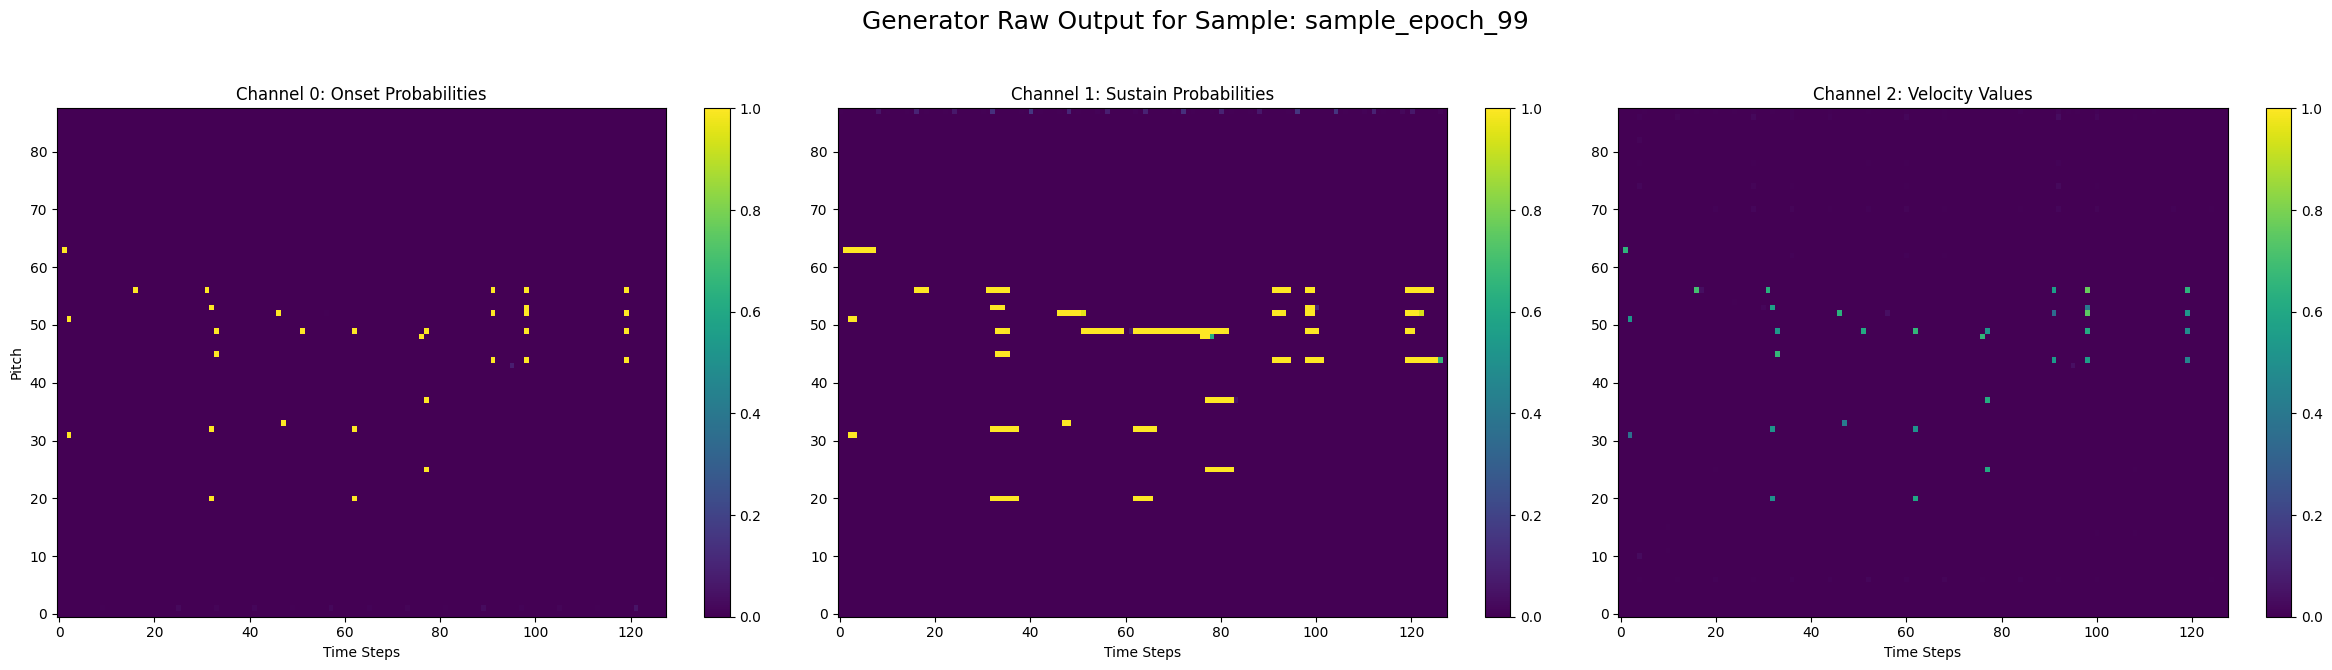

Adv. Epoch 100/100: 100%|██████████| 199/199 [03:59<00:00,  1.21s/it, D_Loss=0.5037, G_Loss=1.2664, Musicality=0.0419]



Adversarial Epoch 100 Summary:
  Generator Losses -> Total: 1.2799, GAN: 1.5919
  G Musicality -> Impossible: 0.0004, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0316
  Discriminator Loss -> Total: 0.5046 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\GAN\checkpoint_epoch_100.pth ---

Training complete! Generating loss plot...


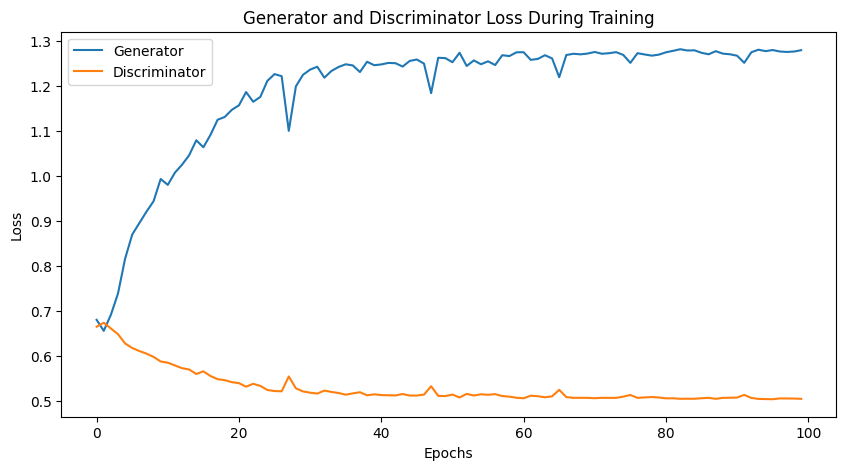

In [2]:
if __name__ == "__main__":
    SEED = 42 # Choose any number, but use the same one for comparable runs
    
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
    # This can slow down training, but ensures that CUDA operations are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"--- Running with fixed random seed: {SEED} ---")
    
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass

    # --- Setup ---
    config = Config(model_type='GAN')
    data_handler = DataHandler(config)
    
    # This function now also saves the CSV
    jazz_files, non_jazz_files_for_gan = data_handler.get_data_files()
    
    # --- DataLoaders ---
    print("\n--- Creating Datasets and DataLoaders ---")
    real_dataset = MultiChannelLazyDataset(jazz_files, [1]*len(jazz_files), dataset_name="Real Jazz (for D)")
    content_dataset = MultiChannelEagerDataset(non_jazz_files_for_gan, [0]*len(non_jazz_files_for_gan), dataset_name="Non-Jazz (for G)")
    
    real_loader = DataLoader(
        real_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        persistent_workers=True if config.NUM_WORKERS > 0 else False
    )
    content_loader = DataLoader(
        content_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=True
    )
    
    # --- Training ---
    trainer = GANTrainer(config)
    
    print("Starting Generator Pre-training...")
    trainer.pretrain_generator(content_loader)
    
    print("\nStarting Adversarial Training...")
    trainer.train_adversarially(real_loader, content_loader)
    
    # --- Finalization ---
    print("\nTraining complete! Generating loss plot...")
    plot_losses(trainer.g_losses, trainer.d_losses)

## RaGAN Training

--- Running with fixed random seed: 42 ---
Found existing file list at: C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_gan_training.csv. Loading from CSV.
Successfully loaded 428 non-jazz file paths.

--- Creating Datasets and DataLoaders ---
Scanning files to create segment pointers for 'Real Jazz (for D)'...
Scan complete. Found 69341 total segments.
EAGERLY loading all multi-channel segments for 'Non-Jazz (for G)' into RAM...


Loading files: 100%|██████████| 428/428 [00:06<00:00, 66.44it/s]


Eager loading complete. Total segments: 25371. Shape: (25371, 4, 88, 128)
Loading Style Classifier (4-channel)...
Style classifier loaded and frozen.
Starting Generator Pre-training...

--- STAGE: Pre-training Generator ---
--- Visualizing: Original Content for Pre-Train Sample ---


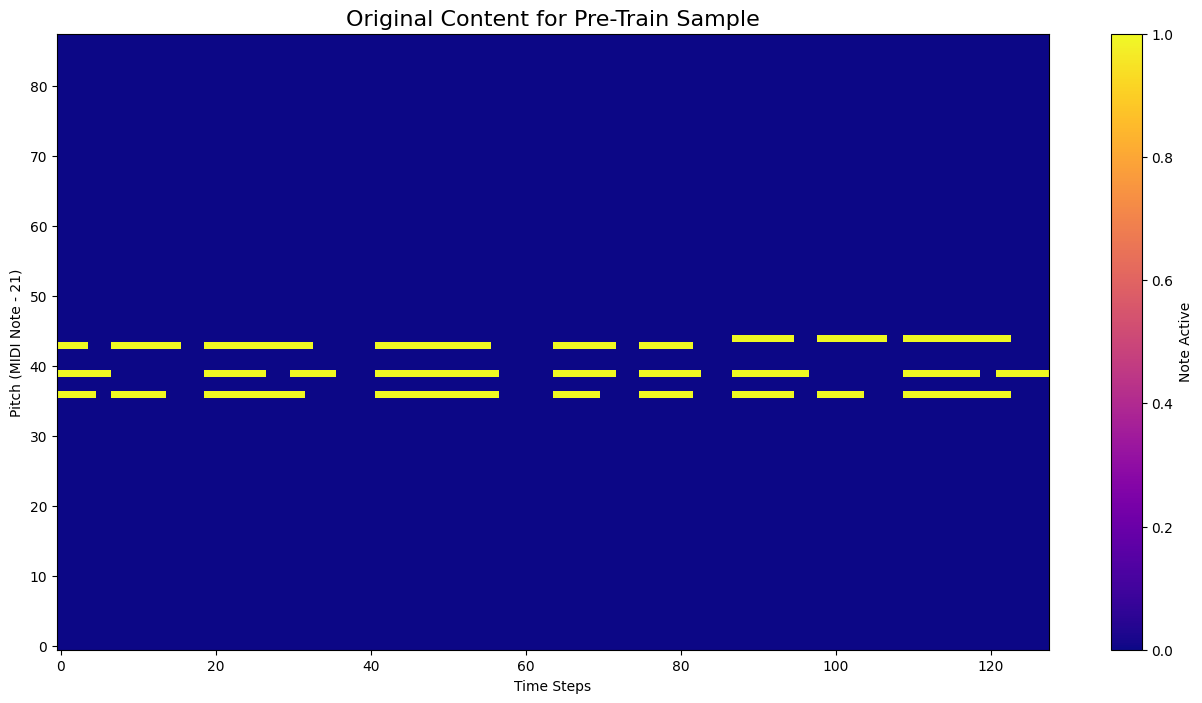

Pre-Train Epoch 1/10:   0%|          | 0/199 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_15696\1288495787.py:428: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(onsets_per_timestep, kernel, padding='same')
Pre-Train Epoch 1/10: 100%|██████████| 199/199 [01:05<00:00,  3.03it/s, chroma=2.7464, impossible=0.0718, min_rate=0.0000, orphan_velocity=0.2568, silent=0.0707, style=1.3769]


  Pre-Train Epoch 1 ->  Avg Total Loss: 9.5606
    Avg Component Losses -> Chroma: 18.4504, Style: 2.2651
    Avg Musicality -> Impossible: 0.1283, Silent: 0.0894, Orphan Velo: 0.2373, Min Rate: 0.0000 



Pre-Train Epoch 2/10: 100%|██████████| 199/199 [01:05<00:00,  3.04it/s, chroma=0.5259, impossible=0.0635, min_rate=0.0000, orphan_velocity=0.2280, silent=0.0650, style=0.5958]


  Pre-Train Epoch 2 ->  Avg Total Loss: 0.9251
    Avg Component Losses -> Chroma: 1.5003, Style: 0.8566
    Avg Musicality -> Impossible: 0.0738, Silent: 0.0739, Orphan Velo: 0.2247, Min Rate: 0.0000 



Pre-Train Epoch 3/10: 100%|██████████| 199/199 [01:05<00:00,  3.04it/s, chroma=0.1804, impossible=0.0681, min_rate=0.0000, orphan_velocity=0.2198, silent=0.0688, style=0.1571]


  Pre-Train Epoch 3 ->  Avg Total Loss: 0.3074
    Avg Component Losses -> Chroma: 0.3687, Style: 0.3662
    Avg Musicality -> Impossible: 0.0686, Silent: 0.0701, Orphan Velo: 0.2230, Min Rate: 0.0000 



Pre-Train Epoch 4/10: 100%|██████████| 199/199 [01:07<00:00,  2.96it/s, chroma=3.4514, impossible=0.0286, min_rate=0.0000, orphan_velocity=0.4886, silent=0.0279, style=4.2264]  


  Pre-Train Epoch 4 ->  Avg Total Loss: 0.7233
    Avg Component Losses -> Chroma: 1.0764, Style: 1.0968
    Avg Musicality -> Impossible: 0.0469, Silent: 0.0479, Orphan Velo: 0.2317, Min Rate: 0.0013 



Pre-Train Epoch 5/10: 100%|██████████| 199/199 [01:33<00:00,  2.13it/s, chroma=0.8522, impossible=0.0430, min_rate=0.0000, orphan_velocity=0.3070, silent=0.0456, style=0.5541]


  Pre-Train Epoch 5 ->  Avg Total Loss: 0.6691
    Avg Component Losses -> Chroma: 0.9524, Style: 0.9946
    Avg Musicality -> Impossible: 0.0413, Silent: 0.0428, Orphan Velo: 0.3401, Min Rate: 0.0000 



Pre-Train Epoch 6/10: 100%|██████████| 199/199 [01:31<00:00,  2.17it/s, chroma=0.4917, impossible=0.0438, min_rate=0.0000, orphan_velocity=0.3054, silent=0.0455, style=0.6803]


  Pre-Train Epoch 6 ->  Avg Total Loss: 0.4077
    Avg Component Losses -> Chroma: 0.5148, Style: 0.6220
    Avg Musicality -> Impossible: 0.0436, Silent: 0.0457, Orphan Velo: 0.3054, Min Rate: 0.0000 



Pre-Train Epoch 7/10: 100%|██████████| 199/199 [01:34<00:00,  2.10it/s, chroma=0.2811, impossible=0.0427, min_rate=0.0000, orphan_velocity=0.3041, silent=0.0448, style=0.7672]


  Pre-Train Epoch 7 ->  Avg Total Loss: 0.2974
    Avg Component Losses -> Chroma: 0.2493, Style: 0.8519
    Avg Musicality -> Impossible: 0.0420, Silent: 0.0440, Orphan Velo: 0.3076, Min Rate: 0.0002 



Pre-Train Epoch 8/10: 100%|██████████| 199/199 [01:32<00:00,  2.16it/s, chroma=0.1161, impossible=0.0415, min_rate=0.0000, orphan_velocity=0.3060, silent=0.0434, style=0.7636]


  Pre-Train Epoch 8 ->  Avg Total Loss: 0.2625
    Avg Component Losses -> Chroma: 0.1838, Style: 0.8299
    Avg Musicality -> Impossible: 0.0431, Silent: 0.0446, Orphan Velo: 0.3055, Min Rate: 0.0000 



Pre-Train Epoch 9/10: 100%|██████████| 199/199 [01:33<00:00,  2.13it/s, chroma=0.0389, impossible=0.0440, min_rate=0.0000, orphan_velocity=0.3043, silent=0.0439, style=0.5608]


  Pre-Train Epoch 9 ->  Avg Total Loss: 0.2330
    Avg Component Losses -> Chroma: 0.1204, Style: 0.8505
    Avg Musicality -> Impossible: 0.0431, Silent: 0.0439, Orphan Velo: 0.3077, Min Rate: 0.0000 



Pre-Train Epoch 10/10: 100%|██████████| 199/199 [01:31<00:00,  2.18it/s, chroma=0.0322, impossible=0.0437, min_rate=0.0000, orphan_velocity=0.3017, silent=0.0434, style=0.6025]


  Pre-Train Epoch 10 ->  Avg Total Loss: 0.2189
    Avg Component Losses -> Chroma: 0.1072, Style: 0.7863
    Avg Musicality -> Impossible: 0.0435, Silent: 0.0432, Orphan Velo: 0.3034, Min Rate: 0.0000 


Generating and analyzing a final sample from the pre-trained generator...
--- Visualizing: Generator Raw Output for Sample: sample_after_pretrain ---


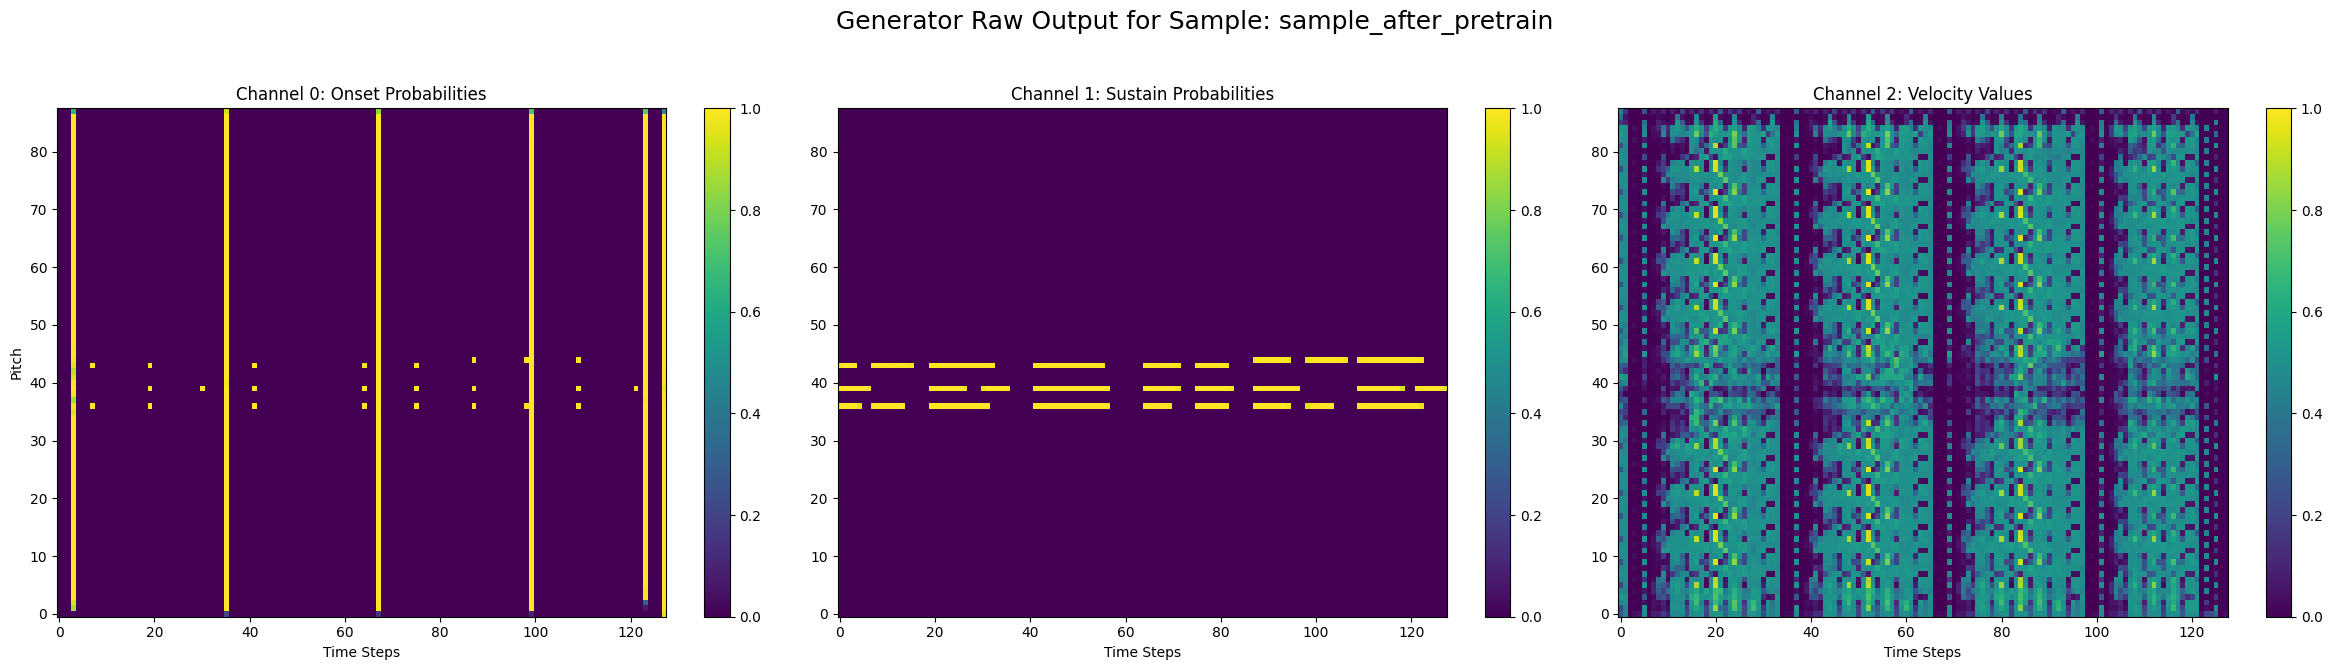

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\generator_pretrained.pth ---

Starting Adversarial Training...

--- STAGE: Adversarial Training (RaGAN) ---


Adv. Epoch 1/100: 100%|██████████| 199/199 [06:34<00:00,  1.98s/it, D_Loss=0.8082, G_Loss=0.6216, Musicality=0.2883]



Adversarial Epoch 1 Summary:
  Generator Losses -> Total: 0.8997, GAN: 1.0902
  G Musicality -> Impossible: 0.0027, Silent: 0.0041 Orphan Velo: 0.0163, Min Rate: 0.1240
  Discriminator Loss -> Total: 0.6132 



Adv. Epoch 2/100: 100%|██████████| 199/199 [04:38<00:00,  1.40s/it, D_Loss=0.5485, G_Loss=1.1794, Musicality=0.2777]



Adversarial Epoch 2 Summary:
  Generator Losses -> Total: 0.8619, GAN: 1.0380
  G Musicality -> Impossible: 0.0013, Silent: 0.0022 Orphan Velo: 0.0007, Min Rate: 0.1542
  Discriminator Loss -> Total: 0.6271 



Adv. Epoch 3/100: 100%|██████████| 199/199 [04:40<00:00,  1.41s/it, D_Loss=0.5662, G_Loss=1.2073, Musicality=0.2776]



Adversarial Epoch 3 Summary:
  Generator Losses -> Total: 1.0434, GAN: 1.2449
  G Musicality -> Impossible: 0.0004, Silent: 0.0009 Orphan Velo: 0.0003, Min Rate: 0.2358
  Discriminator Loss -> Total: 0.5807 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_3 ---


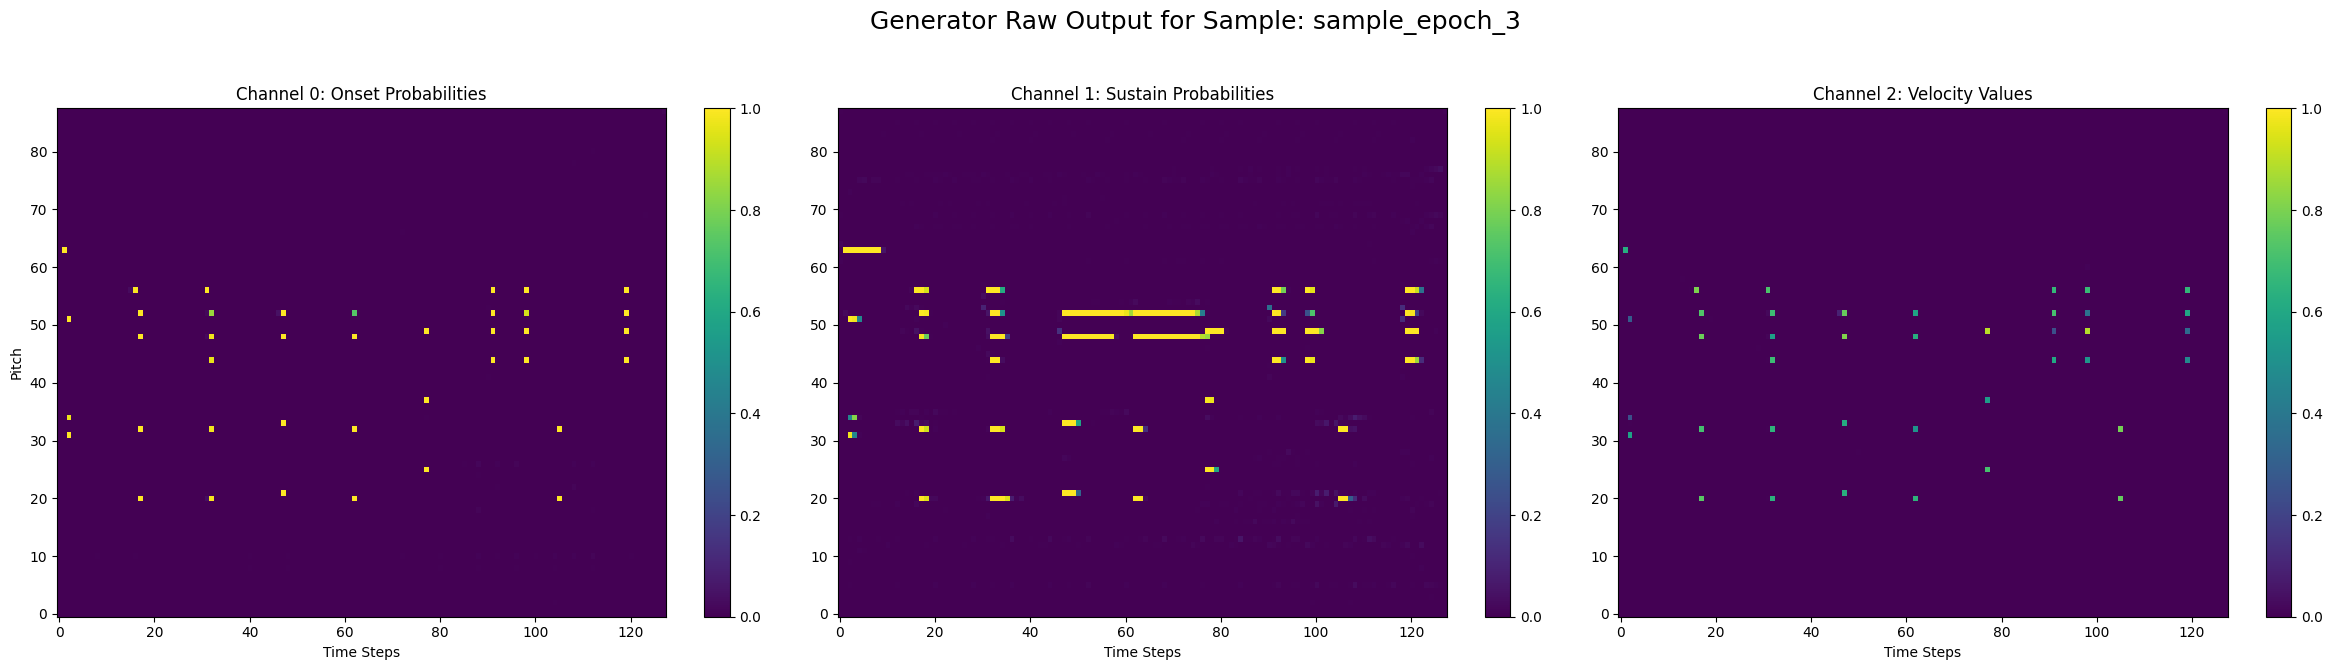

Adv. Epoch 4/100: 100%|██████████| 199/199 [04:38<00:00,  1.40s/it, D_Loss=0.5615, G_Loss=1.2443, Musicality=0.1489]



Adversarial Epoch 4 Summary:
  Generator Losses -> Total: 1.1485, GAN: 1.3859
  G Musicality -> Impossible: 0.0003, Silent: 0.0006 Orphan Velo: 0.0002, Min Rate: 0.1980
  Discriminator Loss -> Total: 0.5516 



Adv. Epoch 5/100: 100%|██████████| 199/199 [04:37<00:00,  1.39s/it, D_Loss=0.5274, G_Loss=1.2326, Musicality=0.3579]



Adversarial Epoch 5 Summary:
  Generator Losses -> Total: 1.1838, GAN: 1.4240
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2222
  Discriminator Loss -> Total: 0.5432 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_5.pth ---


Adv. Epoch 6/100: 100%|██████████| 199/199 [04:40<00:00,  1.41s/it, D_Loss=0.5285, G_Loss=1.2280, Musicality=0.2171]



Adversarial Epoch 6 Summary:
  Generator Losses -> Total: 1.1745, GAN: 1.4051
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2515
  Discriminator Loss -> Total: 0.5477 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_6 ---


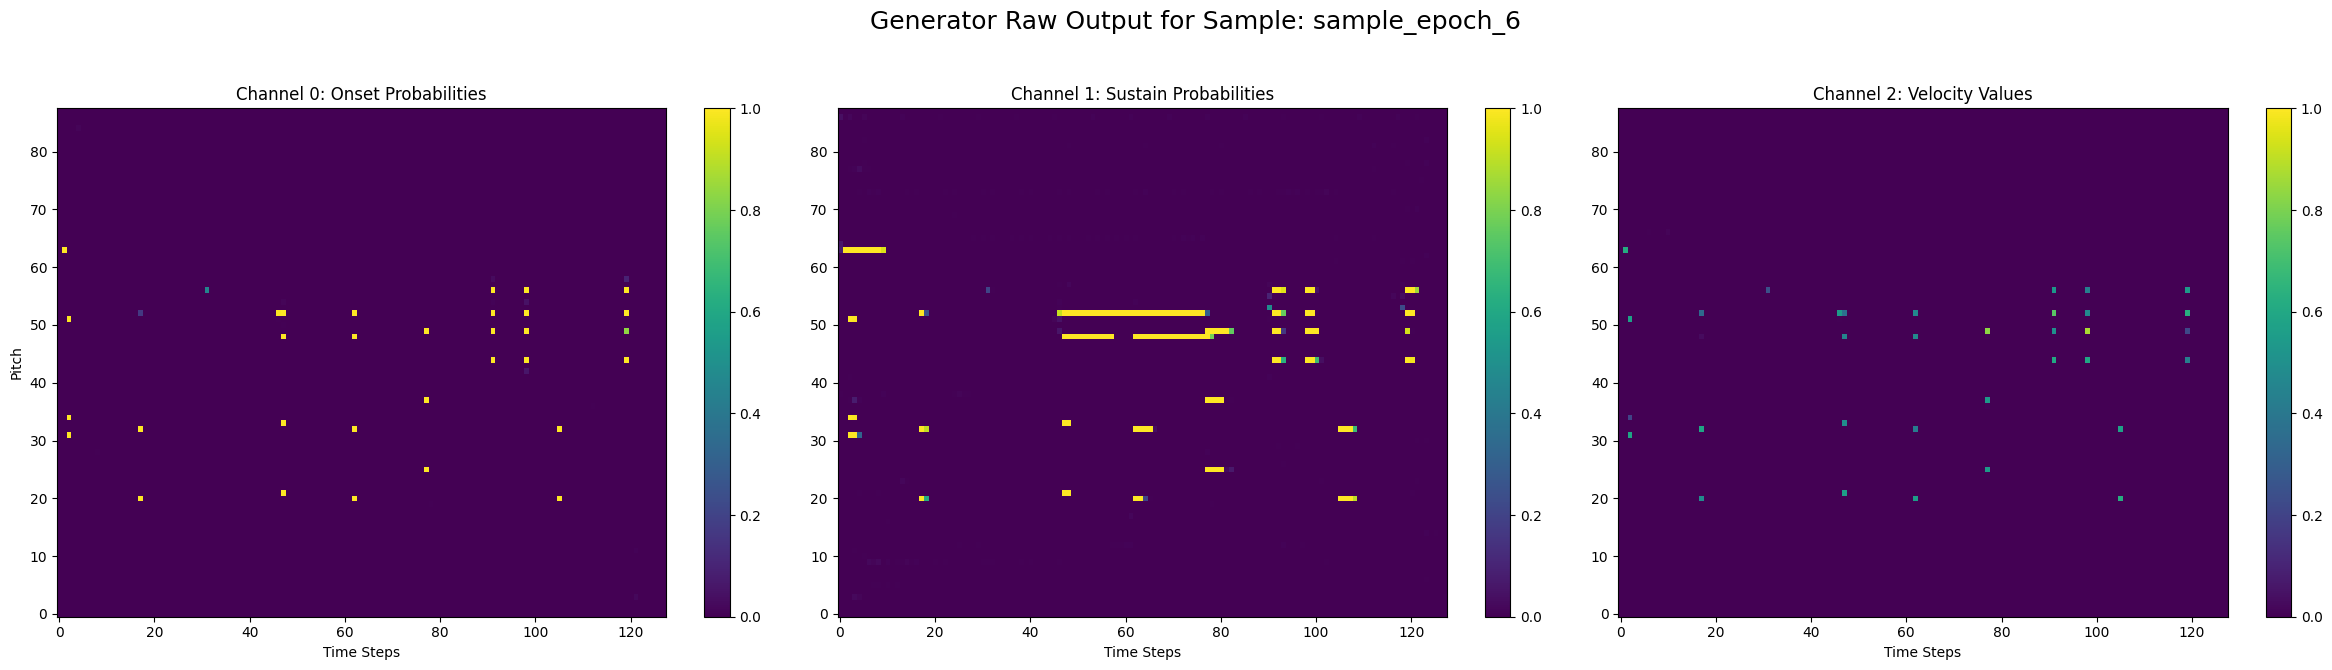

Adv. Epoch 7/100: 100%|██████████| 199/199 [04:38<00:00,  1.40s/it, D_Loss=0.5263, G_Loss=1.2716, Musicality=0.2939]



Adversarial Epoch 7 Summary:
  Generator Losses -> Total: 1.2328, GAN: 1.4733
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2700
  Discriminator Loss -> Total: 0.5337 



Adv. Epoch 8/100: 100%|██████████| 199/199 [06:21<00:00,  1.92s/it, D_Loss=0.5227, G_Loss=1.2972, Musicality=0.3233]



Adversarial Epoch 8 Summary:
  Generator Losses -> Total: 1.2411, GAN: 1.4853
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2638
  Discriminator Loss -> Total: 0.5317 



Adv. Epoch 9/100: 100%|██████████| 199/199 [05:37<00:00,  1.70s/it, D_Loss=0.5312, G_Loss=1.2569, Musicality=0.2659]



Adversarial Epoch 9 Summary:
  Generator Losses -> Total: 1.2287, GAN: 1.4717
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2564
  Discriminator Loss -> Total: 0.5324 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_9 ---


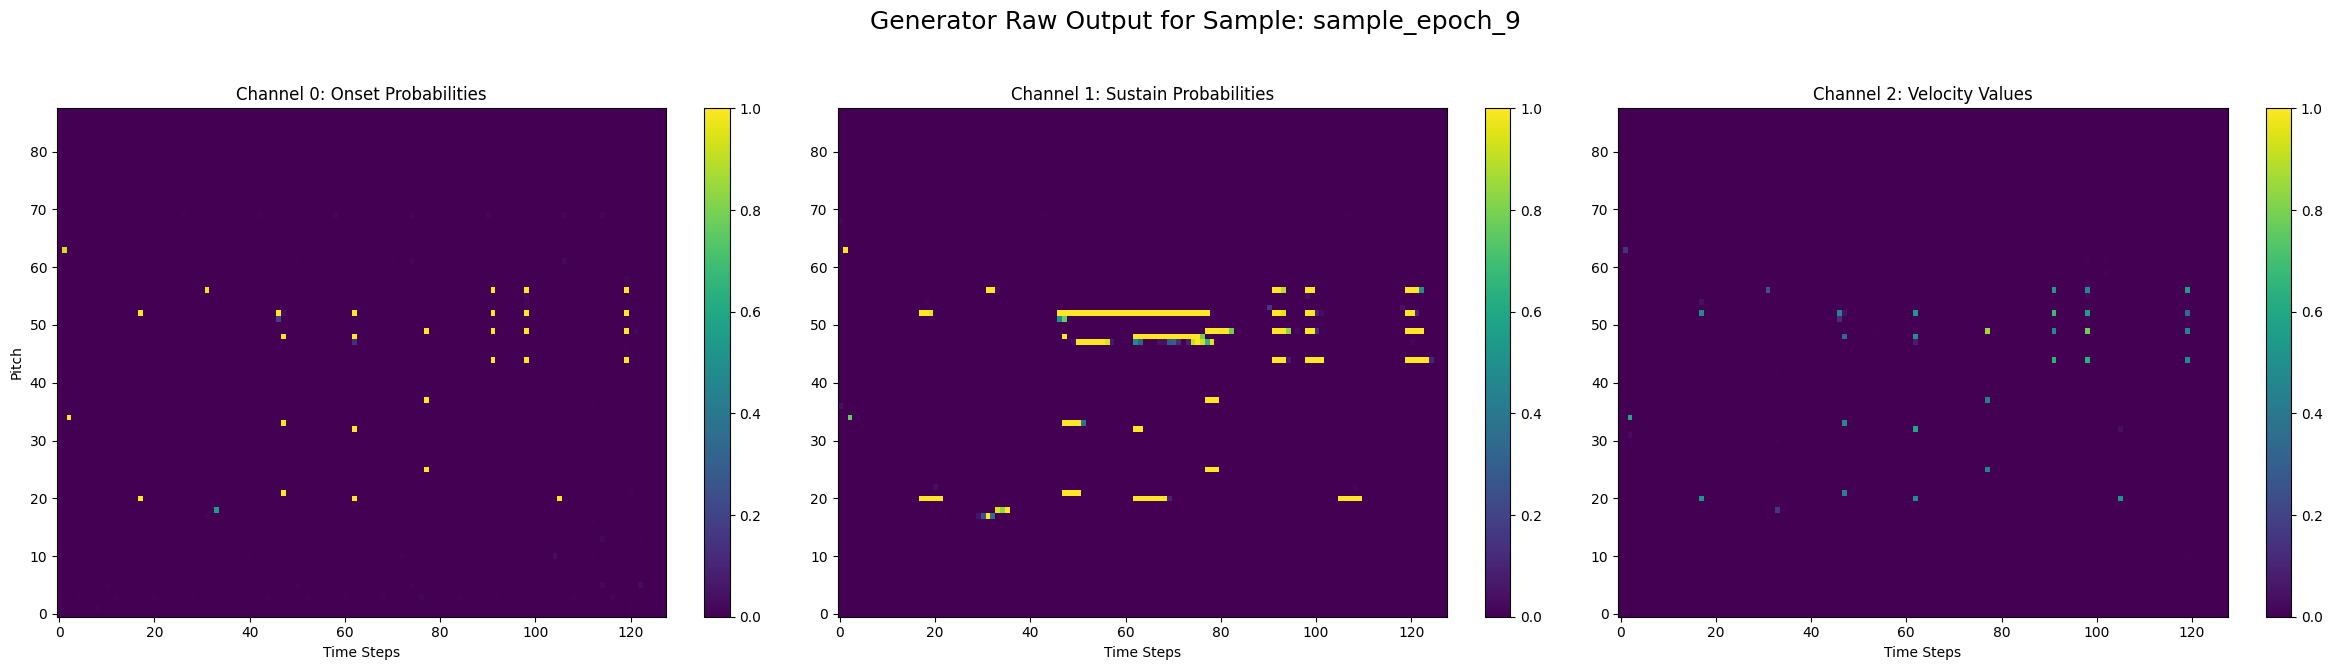

Adv. Epoch 10/100: 100%|██████████| 199/199 [04:37<00:00,  1.39s/it, D_Loss=0.5218, G_Loss=1.3014, Musicality=0.1847]



Adversarial Epoch 10 Summary:
  Generator Losses -> Total: 1.2539, GAN: 1.5034
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2555
  Discriminator Loss -> Total: 0.5237 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_10.pth ---


Adv. Epoch 11/100: 100%|██████████| 199/199 [04:23<00:00,  1.33s/it, D_Loss=0.5225, G_Loss=1.2699, Musicality=0.2686]



Adversarial Epoch 11 Summary:
  Generator Losses -> Total: 1.2682, GAN: 1.5233
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2476
  Discriminator Loss -> Total: 0.5215 



Adv. Epoch 12/100: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it, D_Loss=0.5187, G_Loss=1.2194, Musicality=0.2724]



Adversarial Epoch 12 Summary:
  Generator Losses -> Total: 1.2793, GAN: 1.5382
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2432
  Discriminator Loss -> Total: 0.5193 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_12 ---


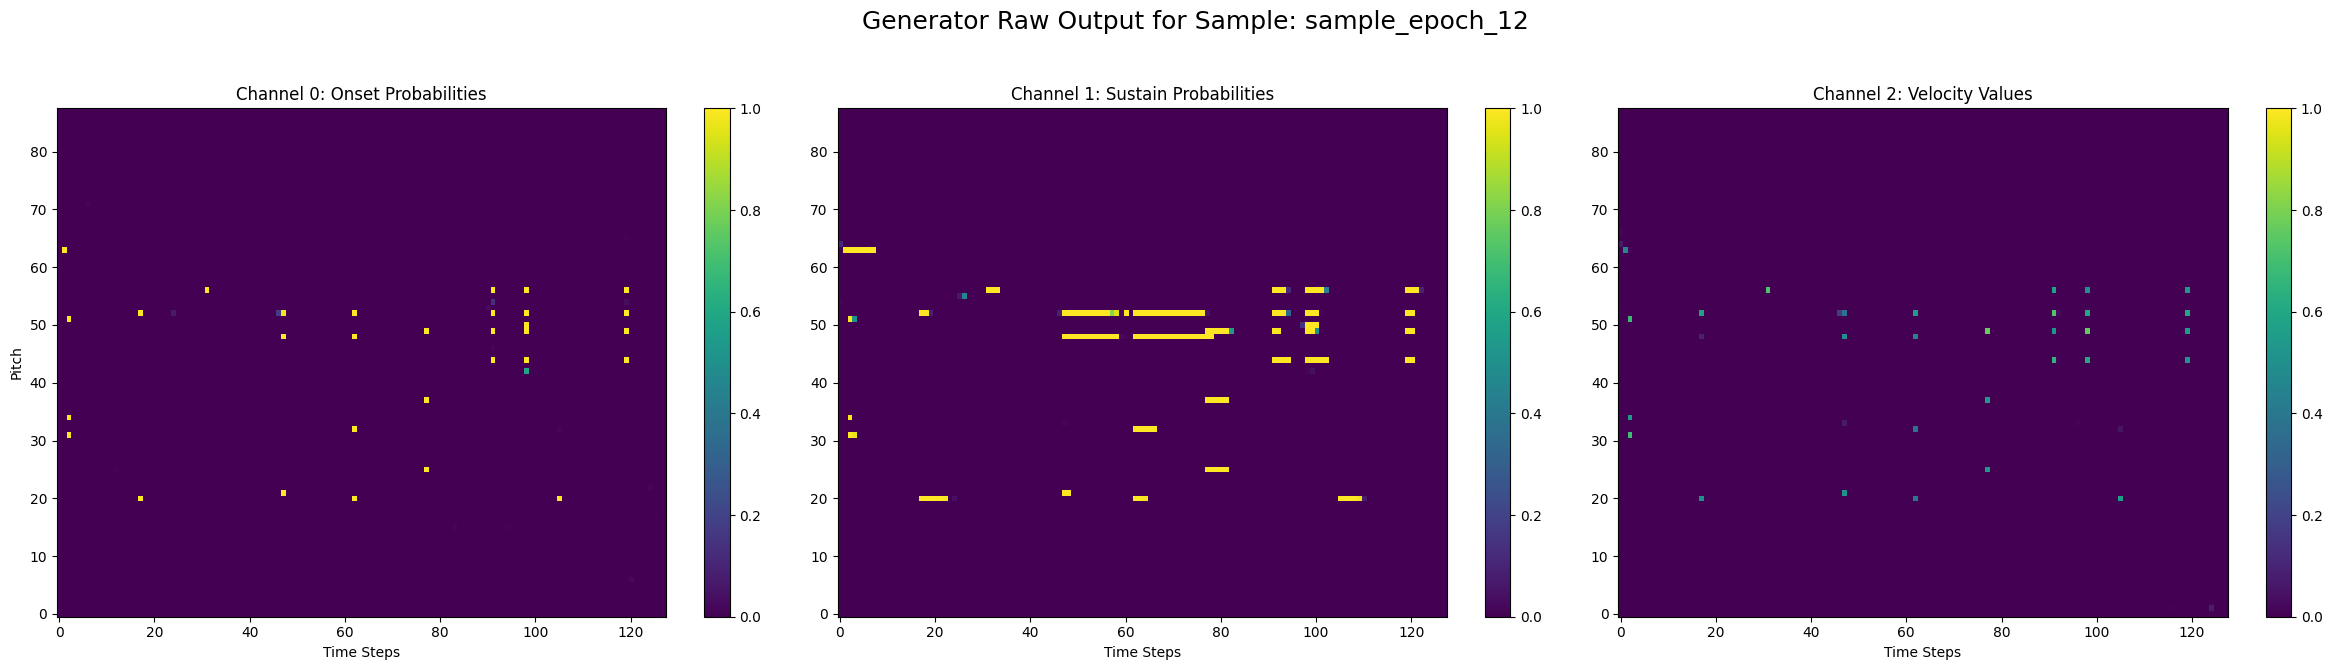

Adv. Epoch 13/100: 100%|██████████| 199/199 [04:27<00:00,  1.35s/it, D_Loss=0.5139, G_Loss=1.2884, Musicality=0.3388]



Adversarial Epoch 13 Summary:
  Generator Losses -> Total: 1.2843, GAN: 1.5441
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2446
  Discriminator Loss -> Total: 0.5177 



Adv. Epoch 14/100: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it, D_Loss=0.5110, G_Loss=1.2597, Musicality=0.1564]



Adversarial Epoch 14 Summary:
  Generator Losses -> Total: 1.2868, GAN: 1.5472
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2446
  Discriminator Loss -> Total: 0.5173 



Adv. Epoch 15/100: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it, D_Loss=0.5276, G_Loss=1.1169, Musicality=0.3067]



Adversarial Epoch 15 Summary:
  Generator Losses -> Total: 1.2872, GAN: 1.5488
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2400
  Discriminator Loss -> Total: 0.5153 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_15 ---


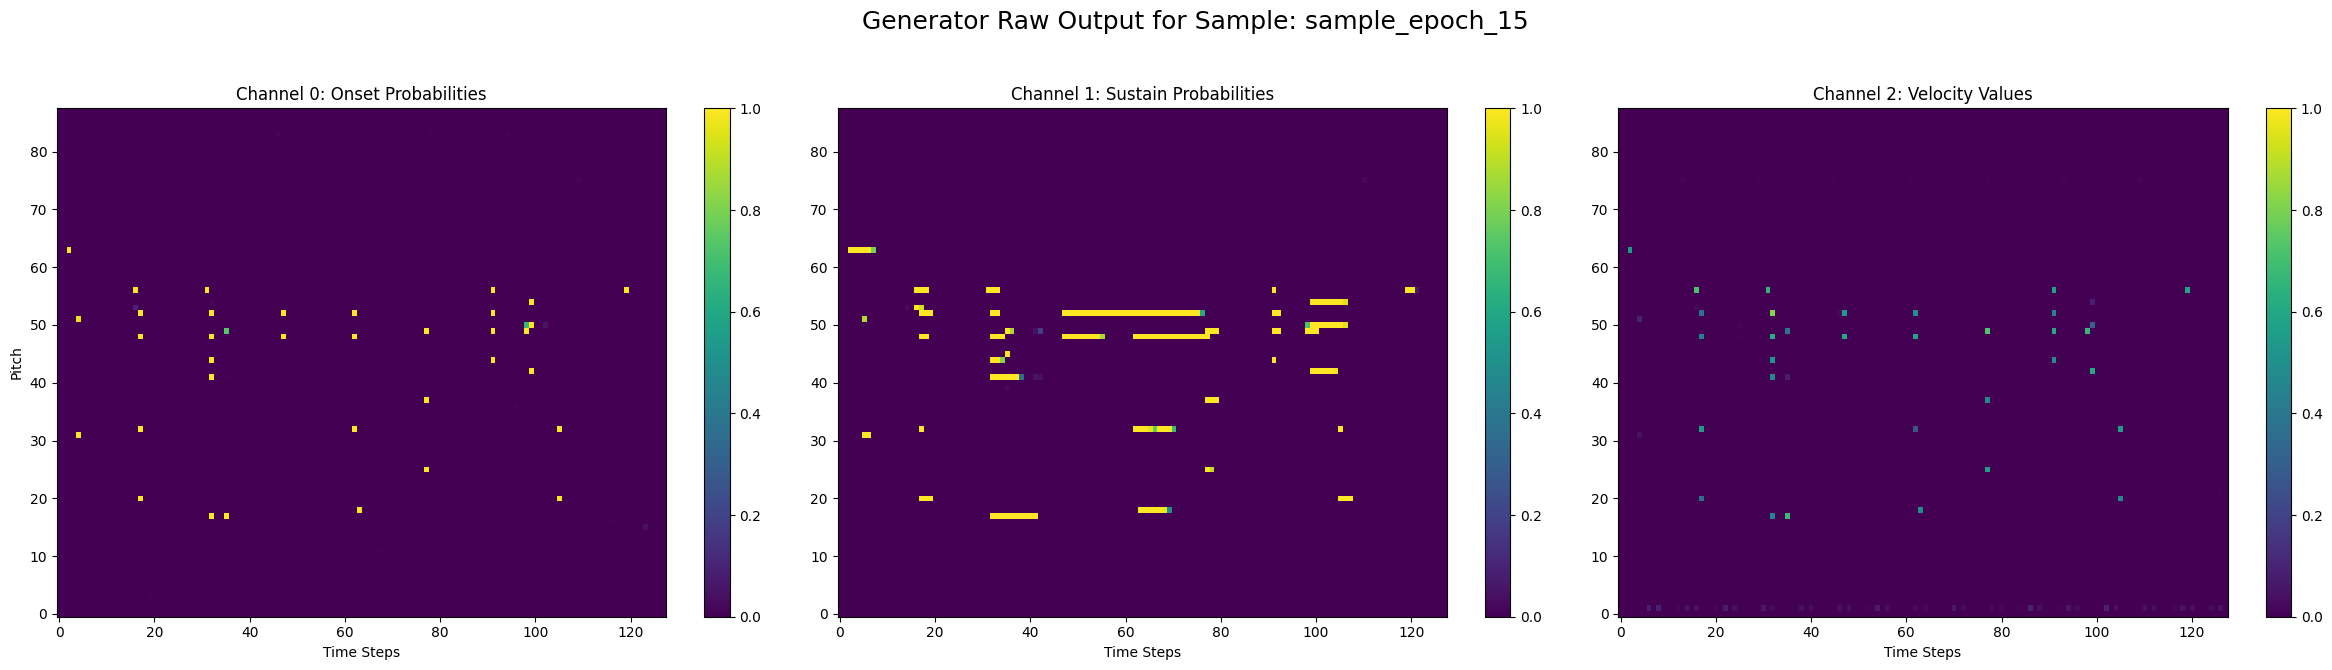

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_15.pth ---


Adv. Epoch 16/100: 100%|██████████| 199/199 [04:17<00:00,  1.30s/it, D_Loss=0.5081, G_Loss=1.2915, Musicality=0.1546]



Adversarial Epoch 16 Summary:
  Generator Losses -> Total: 1.2940, GAN: 1.5591
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2331
  Discriminator Loss -> Total: 0.5142 



Adv. Epoch 17/100: 100%|██████████| 199/199 [04:18<00:00,  1.30s/it, D_Loss=0.5243, G_Loss=1.2453, Musicality=0.1341]



Adversarial Epoch 17 Summary:
  Generator Losses -> Total: 1.2745, GAN: 1.5348
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2326
  Discriminator Loss -> Total: 0.5180 



Adv. Epoch 18/100: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it, D_Loss=0.5125, G_Loss=1.3335, Musicality=0.2440]



Adversarial Epoch 18 Summary:
  Generator Losses -> Total: 1.2857, GAN: 1.5580
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1959
  Discriminator Loss -> Total: 0.5141 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_18 ---


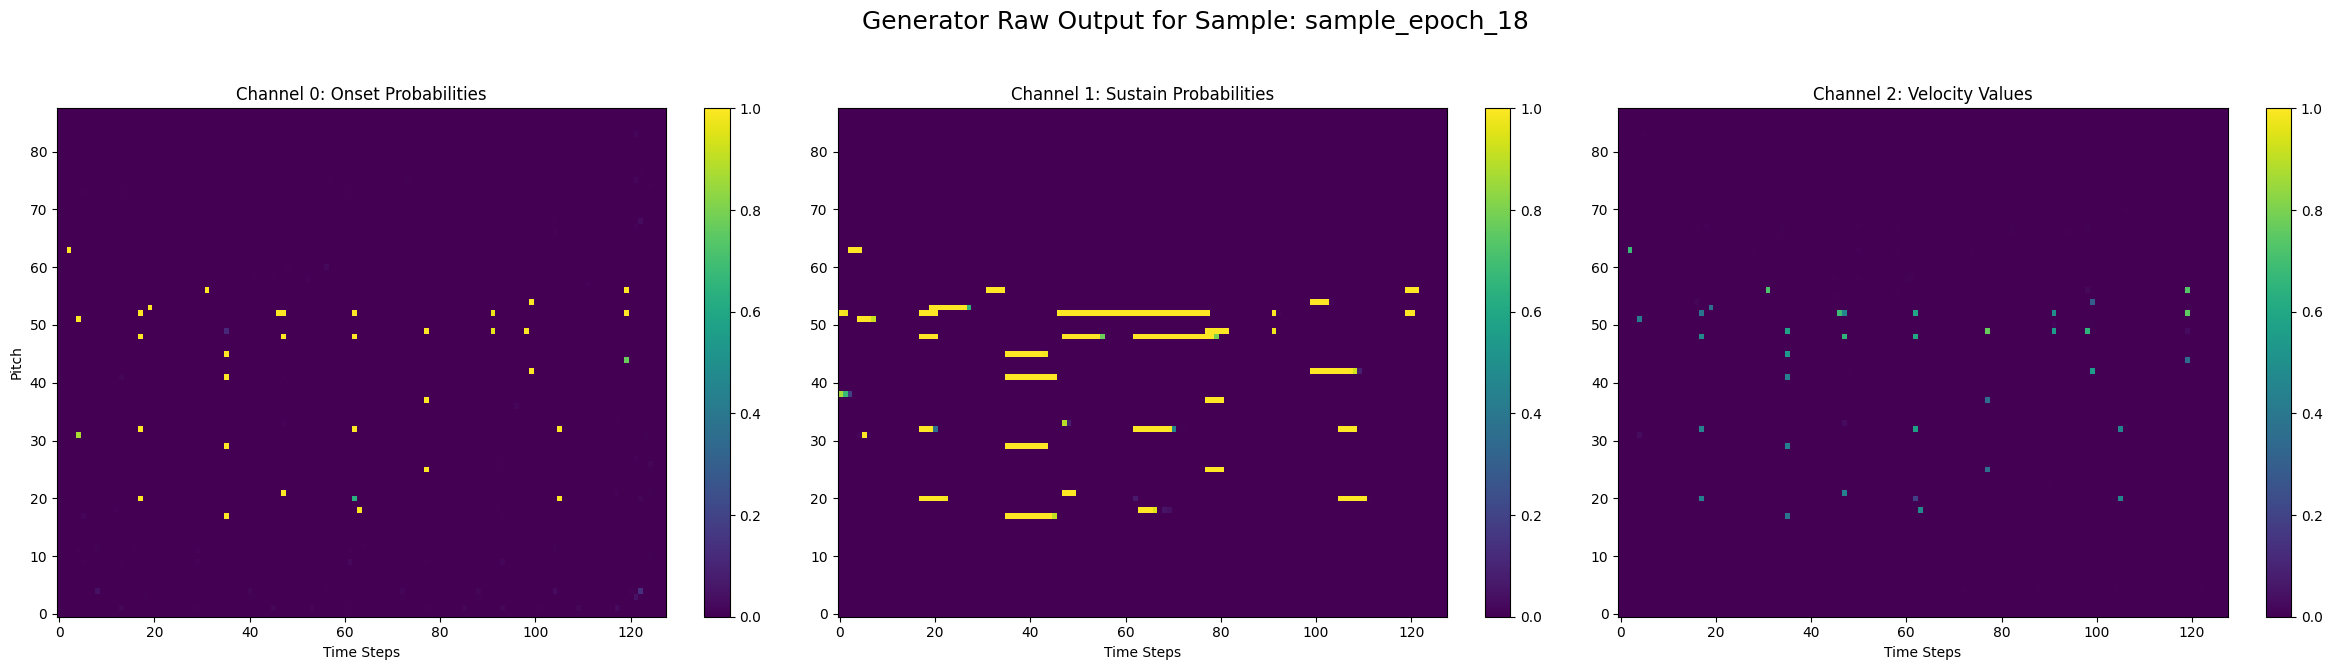

Adv. Epoch 19/100: 100%|██████████| 199/199 [04:19<00:00,  1.31s/it, D_Loss=0.5095, G_Loss=1.3073, Musicality=0.1561]



Adversarial Epoch 19 Summary:
  Generator Losses -> Total: 1.3028, GAN: 1.5695
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2356
  Discriminator Loss -> Total: 0.5119 



Adv. Epoch 20/100: 100%|██████████| 199/199 [04:39<00:00,  1.40s/it, D_Loss=0.5078, G_Loss=1.3076, Musicality=0.2380]



Adversarial Epoch 20 Summary:
  Generator Losses -> Total: 1.3034, GAN: 1.5710
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2325
  Discriminator Loss -> Total: 0.5095 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_20.pth ---


Adv. Epoch 21/100: 100%|██████████| 199/199 [04:38<00:00,  1.40s/it, D_Loss=0.5062, G_Loss=1.2669, Musicality=0.2851]



Adversarial Epoch 21 Summary:
  Generator Losses -> Total: 1.2995, GAN: 1.5667
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2302
  Discriminator Loss -> Total: 0.5119 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_21 ---


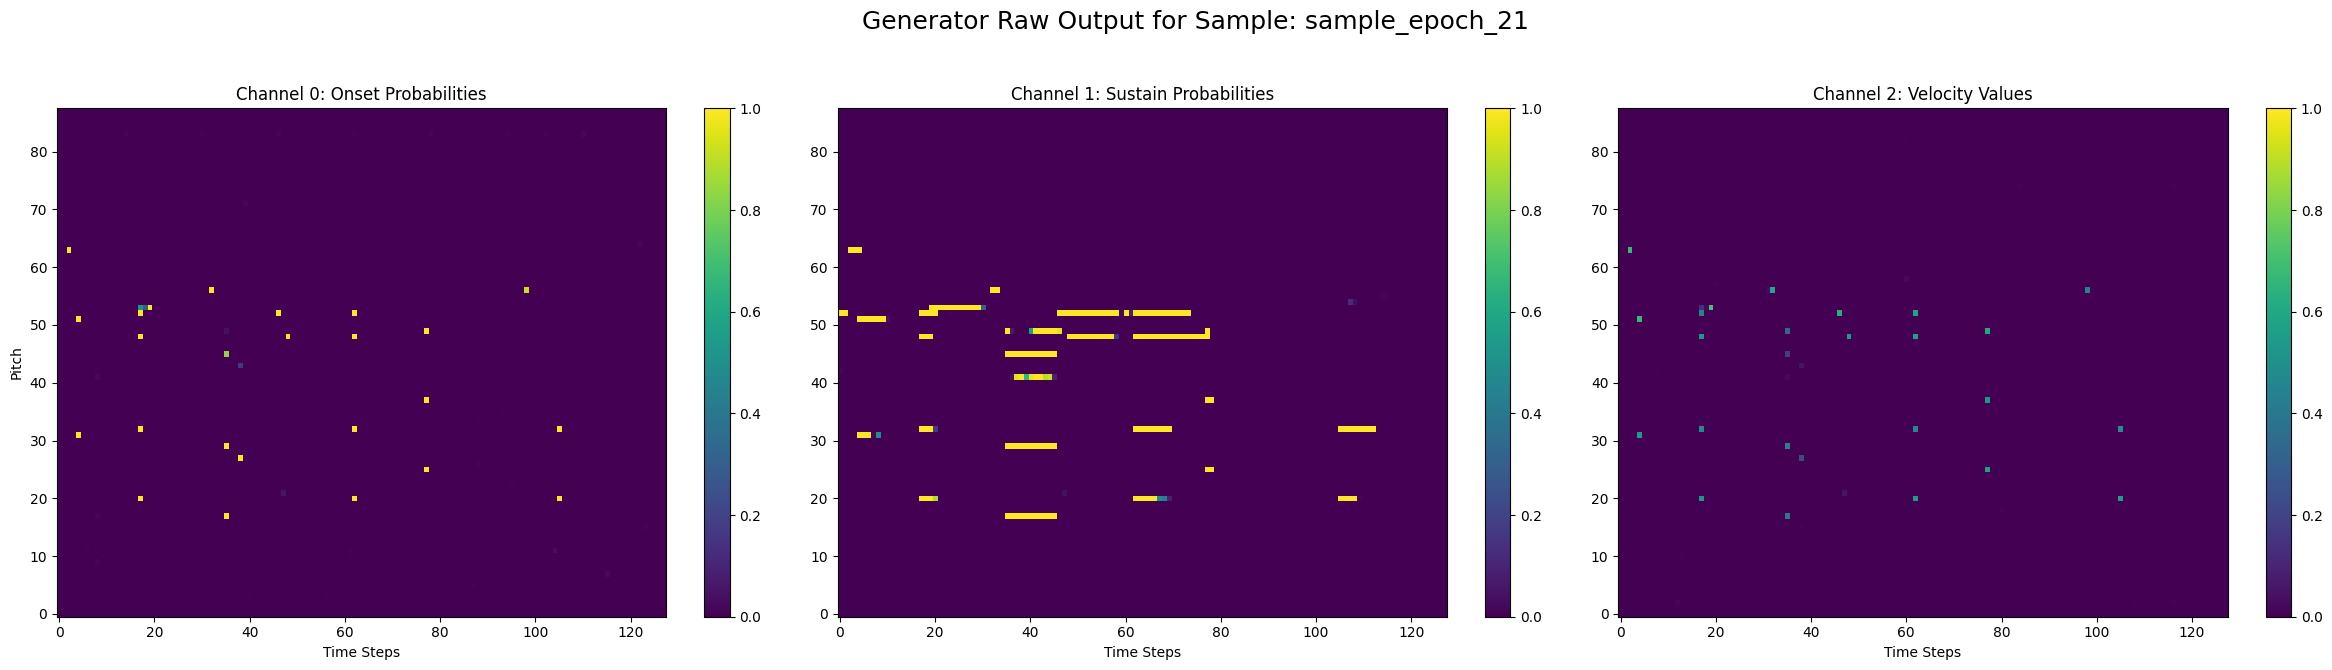

Adv. Epoch 22/100: 100%|██████████| 199/199 [04:38<00:00,  1.40s/it, D_Loss=0.5090, G_Loss=1.2768, Musicality=0.1077]



Adversarial Epoch 22 Summary:
  Generator Losses -> Total: 1.3070, GAN: 1.5761
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2300
  Discriminator Loss -> Total: 0.5090 



Adv. Epoch 23/100: 100%|██████████| 199/199 [04:39<00:00,  1.41s/it, D_Loss=0.5091, G_Loss=1.3218, Musicality=0.3884]



Adversarial Epoch 23 Summary:
  Generator Losses -> Total: 1.3029, GAN: 1.5716
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2275
  Discriminator Loss -> Total: 0.5106 



Adv. Epoch 24/100: 100%|██████████| 199/199 [04:38<00:00,  1.40s/it, D_Loss=0.5145, G_Loss=1.4641, Musicality=0.3165]



Adversarial Epoch 24 Summary:
  Generator Losses -> Total: 1.3076, GAN: 1.5719
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2500
  Discriminator Loss -> Total: 0.5094 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_24 ---


Adv. Epoch 25/100: 100%|██████████| 199/199 [04:39<00:00,  1.41s/it, D_Loss=0.5110, G_Loss=1.3063, Musicality=0.1161]



Adversarial Epoch 25 Summary:
  Generator Losses -> Total: 1.2958, GAN: 1.5779
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1667
  Discriminator Loss -> Total: 0.5091 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_25.pth ---


Adv. Epoch 26/100: 100%|██████████| 199/199 [04:33<00:00,  1.37s/it, D_Loss=0.5117, G_Loss=1.3637, Musicality=0.0460]



Adversarial Epoch 26 Summary:
  Generator Losses -> Total: 1.2800, GAN: 1.5810
  G Musicality -> Impossible: 0.0003, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0751
  Discriminator Loss -> Total: 0.5082 



Adv. Epoch 27/100: 100%|██████████| 199/199 [04:26<00:00,  1.34s/it, D_Loss=0.5089, G_Loss=1.2839, Musicality=0.0649]



Adversarial Epoch 27 Summary:
  Generator Losses -> Total: 1.2791, GAN: 1.5815
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0691
  Discriminator Loss -> Total: 0.5073 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_27 ---


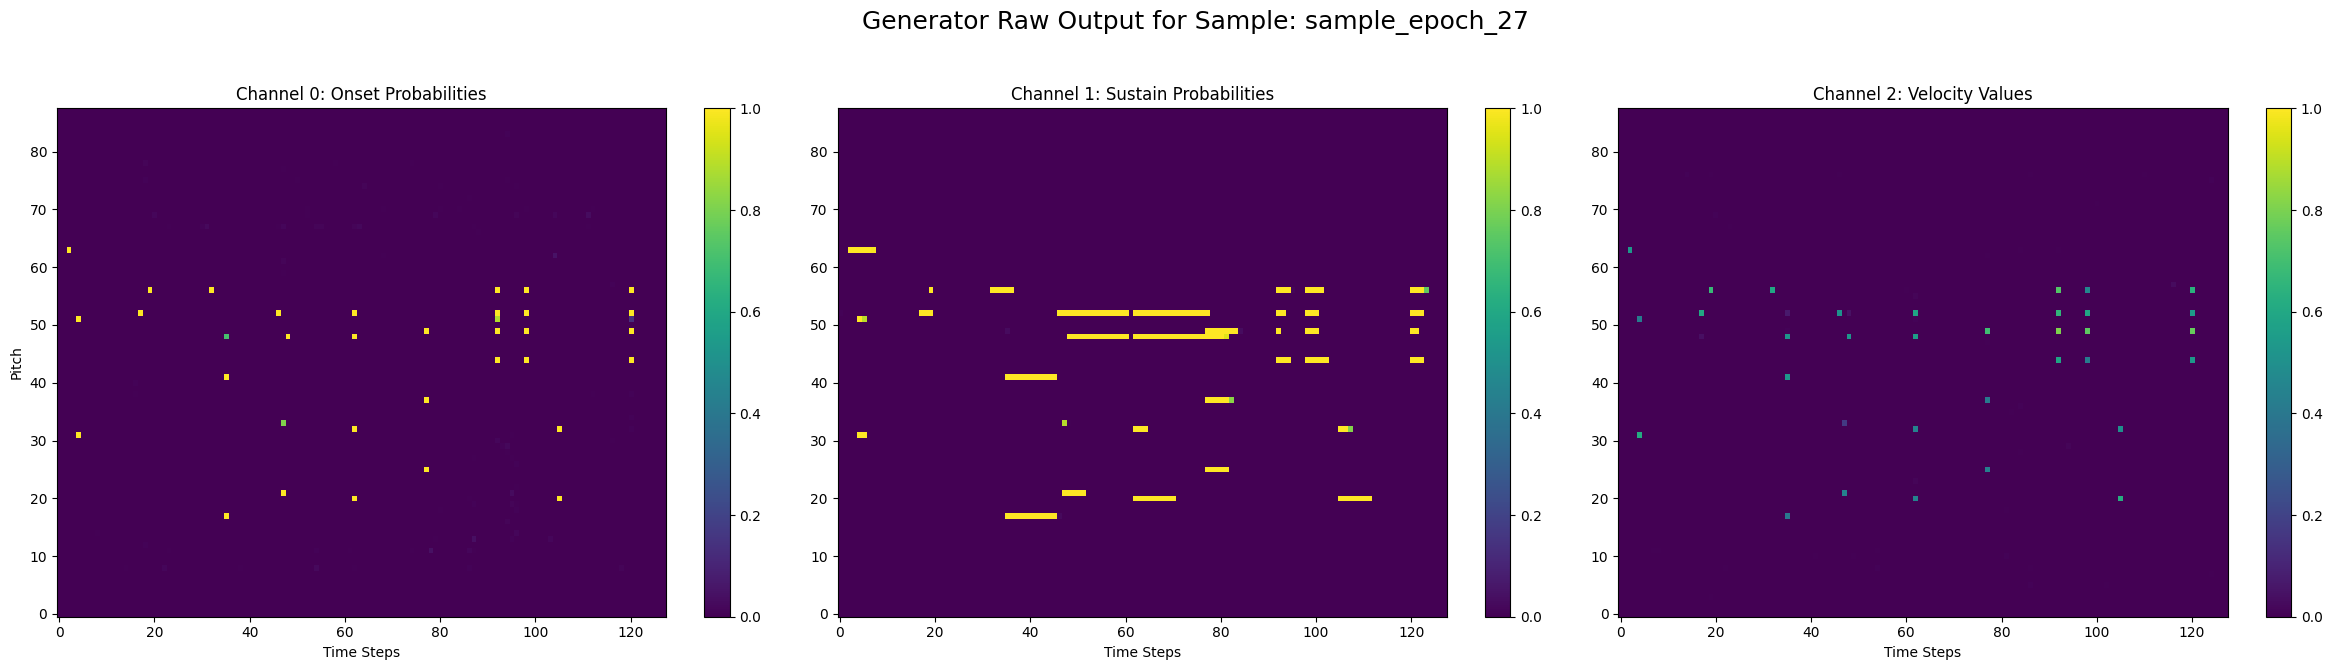

Adv. Epoch 28/100: 100%|██████████| 199/199 [04:37<00:00,  1.40s/it, D_Loss=0.5046, G_Loss=1.2285, Musicality=0.0911]



Adversarial Epoch 28 Summary:
  Generator Losses -> Total: 1.2874, GAN: 1.5881
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0841
  Discriminator Loss -> Total: 0.5067 



Adv. Epoch 29/100: 100%|██████████| 199/199 [04:38<00:00,  1.40s/it, D_Loss=0.5064, G_Loss=1.2368, Musicality=0.1195]



Adversarial Epoch 29 Summary:
  Generator Losses -> Total: 1.2843, GAN: 1.5792
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1044
  Discriminator Loss -> Total: 0.5095 



Adv. Epoch 30/100: 100%|██████████| 199/199 [04:33<00:00,  1.37s/it, D_Loss=0.5059, G_Loss=1.2669, Musicality=0.0423]



Adversarial Epoch 30 Summary:
  Generator Losses -> Total: 1.2974, GAN: 1.5953
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1055
  Discriminator Loss -> Total: 0.5052 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_30 ---


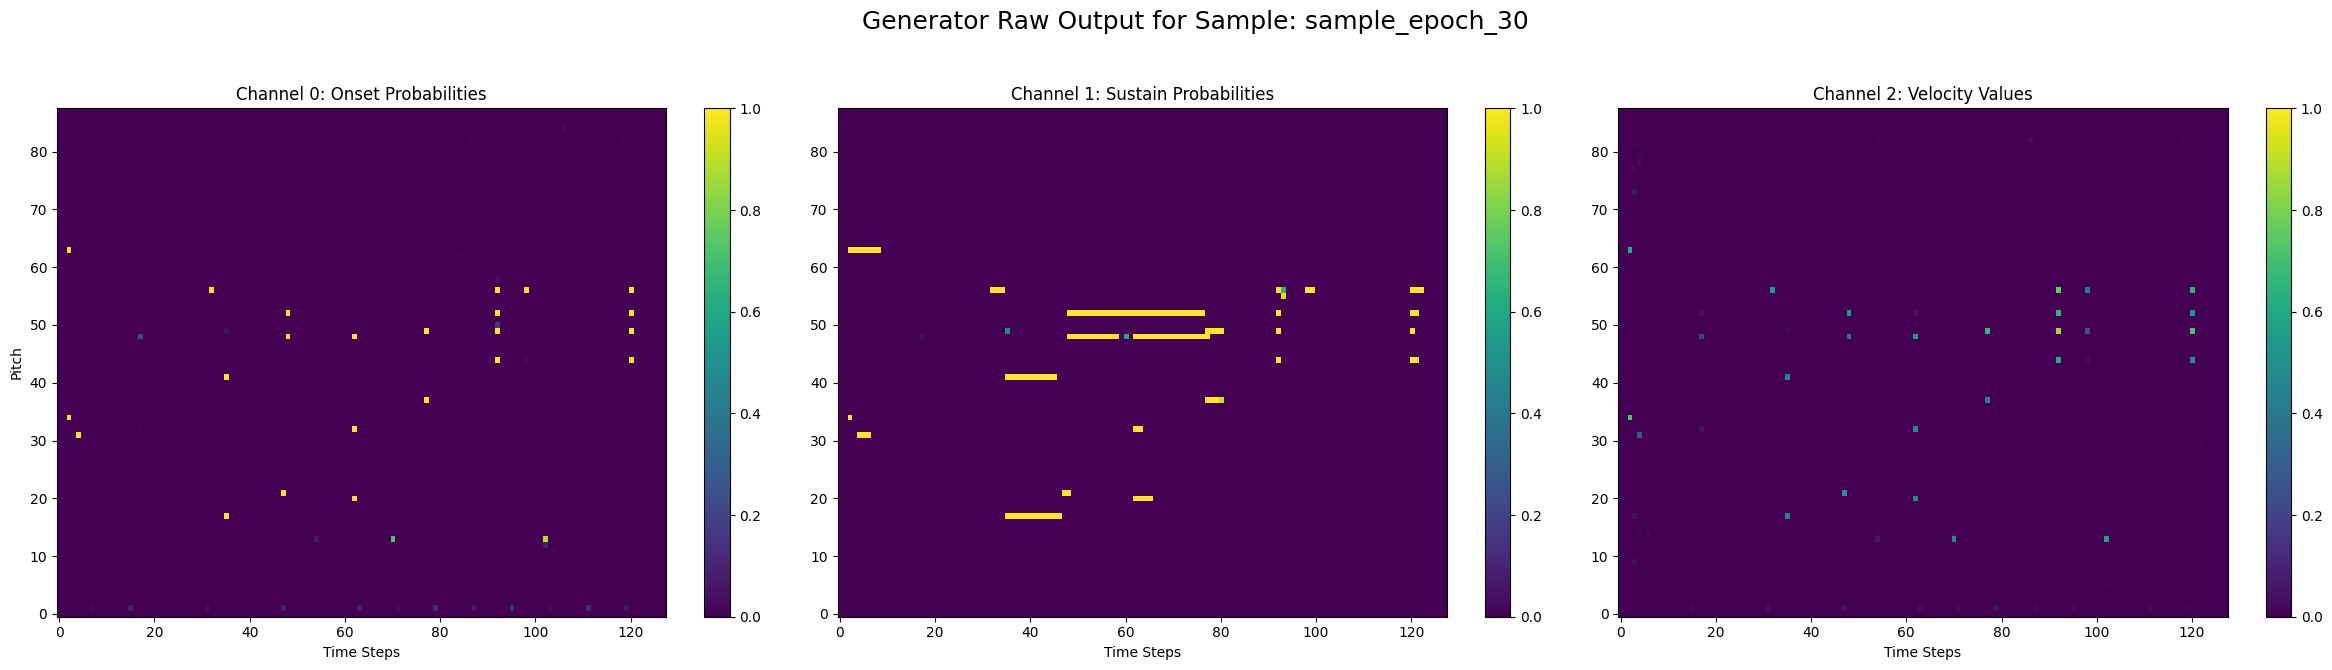

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_30.pth ---


Adv. Epoch 31/100: 100%|██████████| 199/199 [04:19<00:00,  1.30s/it, D_Loss=0.5179, G_Loss=1.2307, Musicality=0.0968]



Adversarial Epoch 31 Summary:
  Generator Losses -> Total: 1.2916, GAN: 1.5968
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0701
  Discriminator Loss -> Total: 0.5058 



Adv. Epoch 32/100: 100%|██████████| 199/199 [04:20<00:00,  1.31s/it, D_Loss=0.5046, G_Loss=1.3349, Musicality=0.1549]



Adversarial Epoch 32 Summary:
  Generator Losses -> Total: 1.2771, GAN: 1.5671
  G Musicality -> Impossible: 0.0005, Silent: 0.0006 Orphan Velo: 0.0004, Min Rate: 0.1161
  Discriminator Loss -> Total: 0.5117 



Adv. Epoch 33/100: 100%|██████████| 199/199 [04:32<00:00,  1.37s/it, D_Loss=0.5103, G_Loss=1.2489, Musicality=0.0704]



Adversarial Epoch 33 Summary:
  Generator Losses -> Total: 1.2937, GAN: 1.5923
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0990
  Discriminator Loss -> Total: 0.5049 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_33 ---


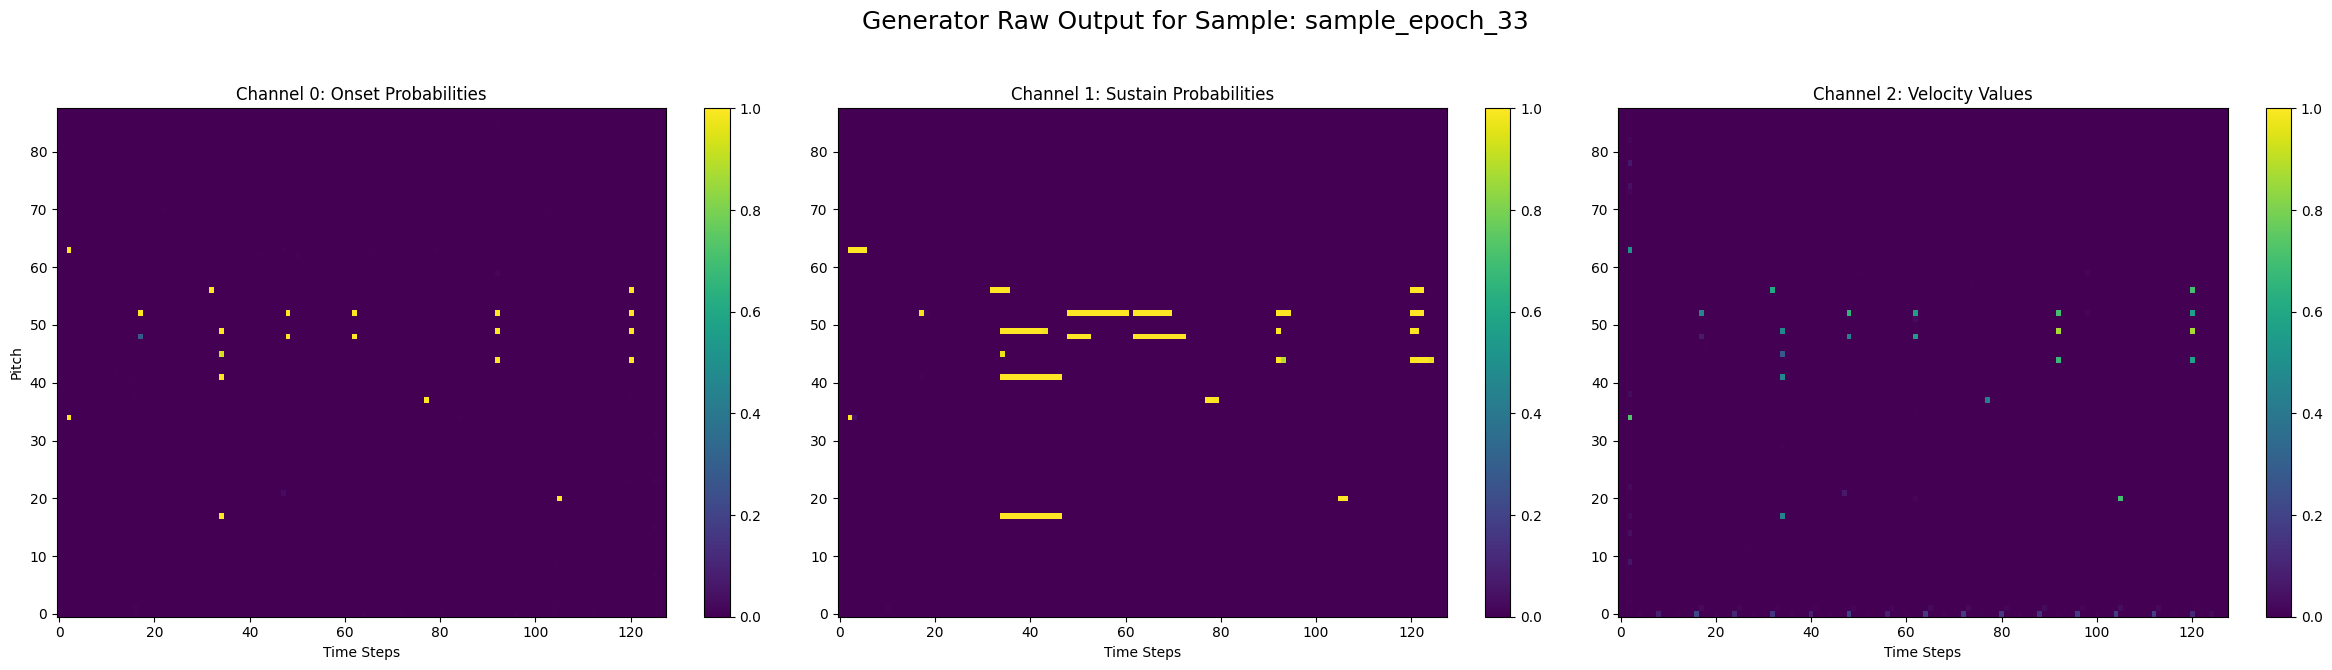

Adv. Epoch 34/100: 100%|██████████| 199/199 [05:02<00:00,  1.52s/it, D_Loss=0.5034, G_Loss=1.2813, Musicality=0.0667]



Adversarial Epoch 34 Summary:
  Generator Losses -> Total: 1.2861, GAN: 1.5863
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0848
  Discriminator Loss -> Total: 0.5054 



Adv. Epoch 35/100: 100%|██████████| 199/199 [07:02<00:00,  2.12s/it, D_Loss=0.5026, G_Loss=1.2868, Musicality=0.0429]



Adversarial Epoch 35 Summary:
  Generator Losses -> Total: 1.2823, GAN: 1.5868
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0637
  Discriminator Loss -> Total: 0.5076 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_35.pth ---


Adv. Epoch 36/100: 100%|██████████| 199/199 [07:16<00:00,  2.19s/it, D_Loss=0.5055, G_Loss=1.2803, Musicality=0.1366]



Adversarial Epoch 36 Summary:
  Generator Losses -> Total: 1.2752, GAN: 1.5730
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0834
  Discriminator Loss -> Total: 0.5094 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_36 ---


Adv. Epoch 37/100: 100%|██████████| 199/199 [07:18<00:00,  2.20s/it, D_Loss=0.5035, G_Loss=1.2706, Musicality=0.0424]



Adversarial Epoch 37 Summary:
  Generator Losses -> Total: 1.2902, GAN: 1.5965
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0643
  Discriminator Loss -> Total: 0.5045 



Adv. Epoch 38/100: 100%|██████████| 199/199 [07:12<00:00,  2.18s/it, D_Loss=0.5046, G_Loss=1.2767, Musicality=0.0901]



Adversarial Epoch 38 Summary:
  Generator Losses -> Total: 1.2836, GAN: 1.5874
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0679
  Discriminator Loss -> Total: 0.5061 



Adv. Epoch 39/100: 100%|██████████| 199/199 [07:14<00:00,  2.18s/it, D_Loss=0.5056, G_Loss=1.2645, Musicality=0.0902]



Adversarial Epoch 39 Summary:
  Generator Losses -> Total: 1.2873, GAN: 1.5882
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0832
  Discriminator Loss -> Total: 0.5058 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_39 ---


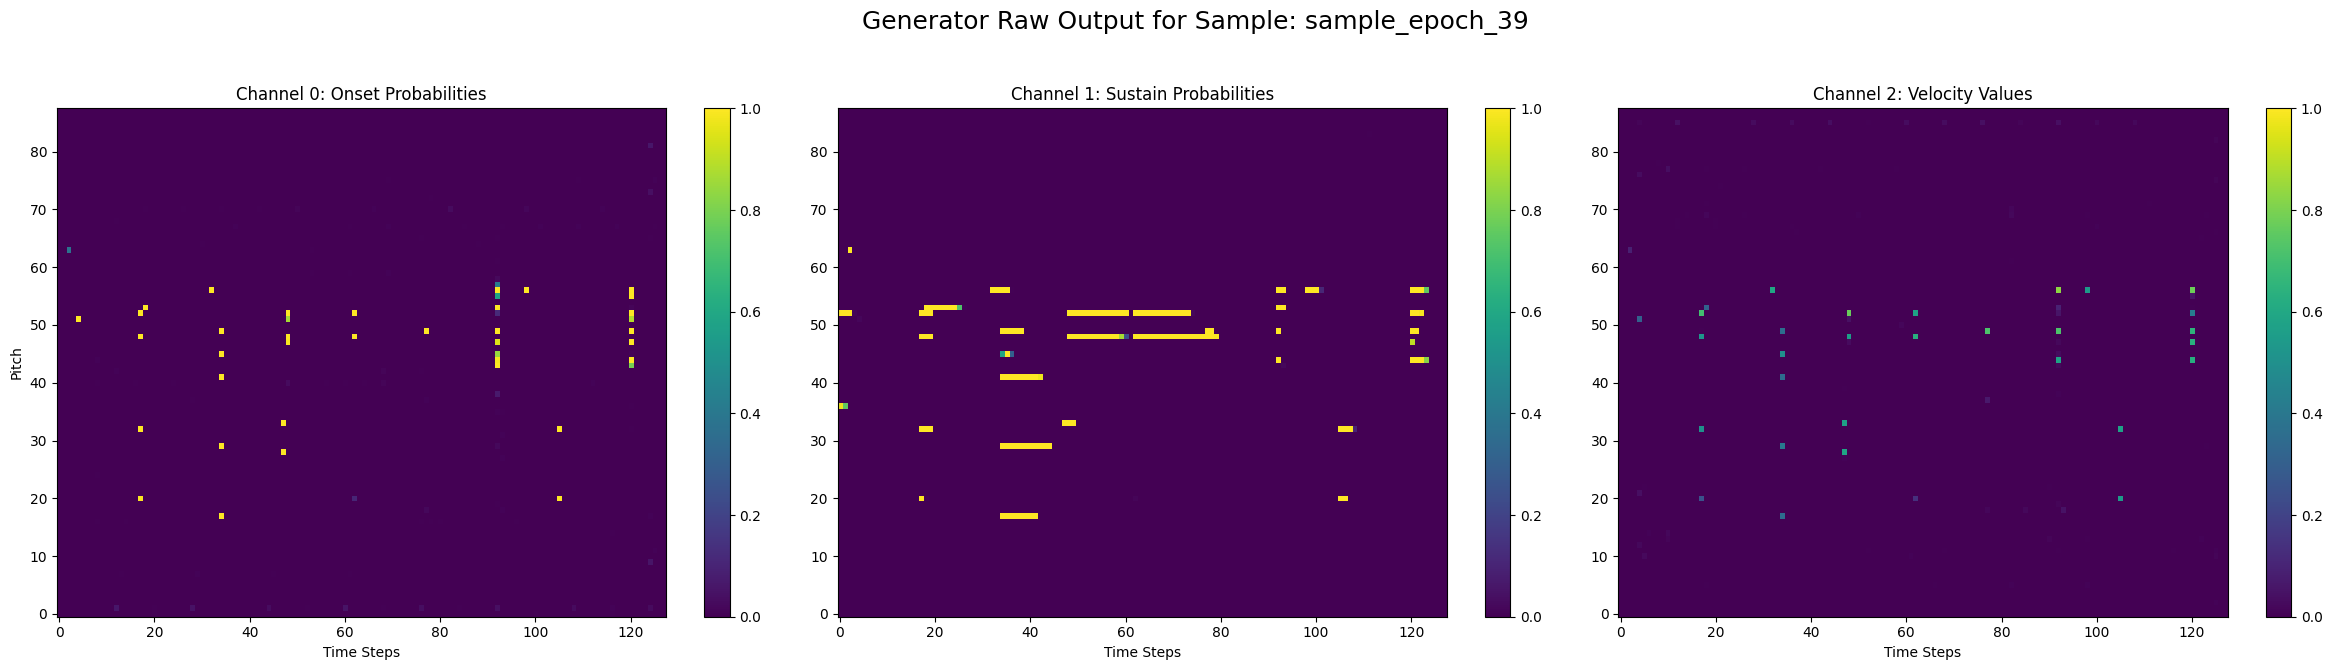

Adv. Epoch 40/100: 100%|██████████| 199/199 [04:36<00:00,  1.39s/it, D_Loss=0.5020, G_Loss=1.3068, Musicality=0.0580]



Adversarial Epoch 40 Summary:
  Generator Losses -> Total: 1.2978, GAN: 1.6003
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0872
  Discriminator Loss -> Total: 0.5042 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_40.pth ---


Adv. Epoch 41/100: 100%|██████████| 199/199 [04:45<00:00,  1.43s/it, D_Loss=0.5089, G_Loss=1.3732, Musicality=0.0786]



Adversarial Epoch 41 Summary:
  Generator Losses -> Total: 1.2822, GAN: 1.5788
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0955
  Discriminator Loss -> Total: 0.5085 



Adv. Epoch 42/100: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it, D_Loss=0.5019, G_Loss=1.3162, Musicality=0.0868]



Adversarial Epoch 42 Summary:
  Generator Losses -> Total: 1.2994, GAN: 1.6003
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0949
  Discriminator Loss -> Total: 0.5043 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_42 ---


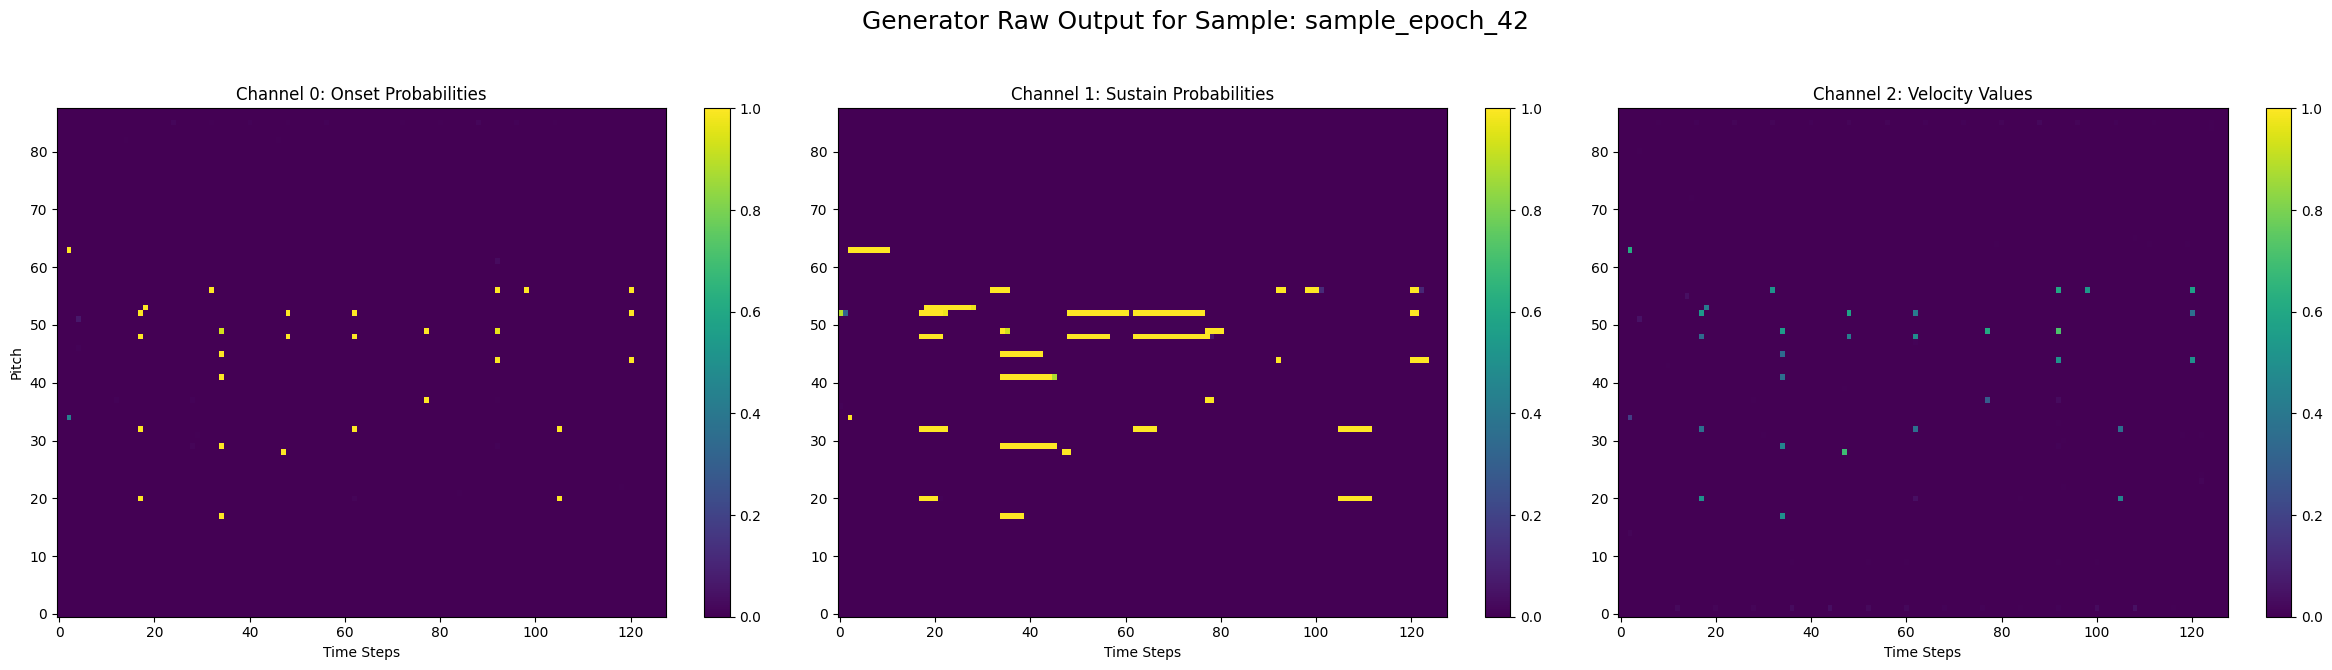

Adv. Epoch 43/100: 100%|██████████| 199/199 [04:41<00:00,  1.42s/it, D_Loss=0.5031, G_Loss=1.3127, Musicality=0.0556]



Adversarial Epoch 43 Summary:
  Generator Losses -> Total: 1.2930, GAN: 1.5973
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0751
  Discriminator Loss -> Total: 0.5039 



Adv. Epoch 44/100: 100%|██████████| 199/199 [04:45<00:00,  1.43s/it, D_Loss=0.5037, G_Loss=1.2659, Musicality=0.1235]



Adversarial Epoch 44 Summary:
  Generator Losses -> Total: 1.2876, GAN: 1.5849
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0978
  Discriminator Loss -> Total: 0.5071 



Adv. Epoch 45/100: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it, D_Loss=0.5155, G_Loss=1.2346, Musicality=0.0855]



Adversarial Epoch 45 Summary:
  Generator Losses -> Total: 1.2872, GAN: 1.5891
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0787
  Discriminator Loss -> Total: 0.5055 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_45 ---


--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_45.pth ---


Adv. Epoch 46/100: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it, D_Loss=0.5034, G_Loss=1.2495, Musicality=0.1371]



Adversarial Epoch 46 Summary:
  Generator Losses -> Total: 1.2988, GAN: 1.5942
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.1165
  Discriminator Loss -> Total: 0.5065 



Adv. Epoch 47/100: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it, D_Loss=0.5023, G_Loss=1.3124, Musicality=0.0574]



Adversarial Epoch 47 Summary:
  Generator Losses -> Total: 1.2862, GAN: 1.5884
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0767
  Discriminator Loss -> Total: 0.5062 



Adv. Epoch 48/100: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it, D_Loss=0.5085, G_Loss=1.2623, Musicality=0.0865]



Adversarial Epoch 48 Summary:
  Generator Losses -> Total: 1.2784, GAN: 1.5794
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0738
  Discriminator Loss -> Total: 0.5072 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_48 ---


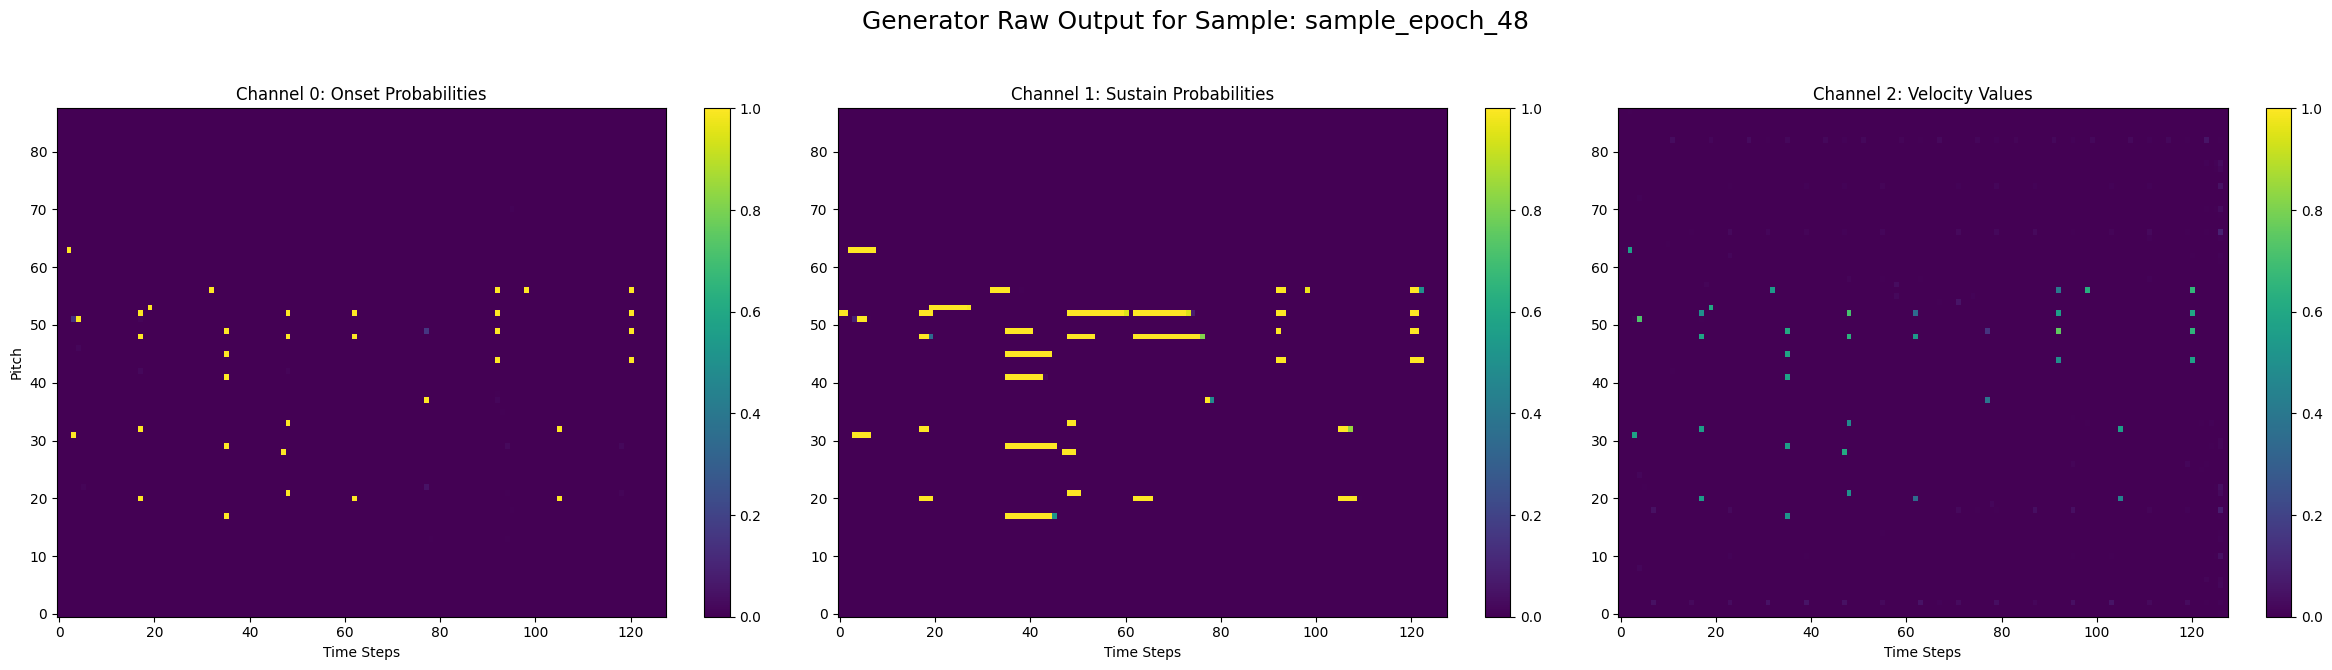

Adv. Epoch 49/100: 100%|██████████| 199/199 [04:41<00:00,  1.42s/it, D_Loss=0.5062, G_Loss=1.3100, Musicality=0.1737]



Adversarial Epoch 49 Summary:
  Generator Losses -> Total: 1.2893, GAN: 1.5924
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0765
  Discriminator Loss -> Total: 0.5059 



Adv. Epoch 50/100: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it, D_Loss=0.5018, G_Loss=1.2623, Musicality=0.0572]



Adversarial Epoch 50 Summary:
  Generator Losses -> Total: 1.2995, GAN: 1.6037
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0817
  Discriminator Loss -> Total: 0.5034 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_50.pth ---


Adv. Epoch 51/100: 100%|██████████| 199/199 [04:40<00:00,  1.41s/it, D_Loss=0.5137, G_Loss=1.2918, Musicality=0.0809]



Adversarial Epoch 51 Summary:
  Generator Losses -> Total: 1.2902, GAN: 1.5965
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0647
  Discriminator Loss -> Total: 0.5033 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_51 ---


Adv. Epoch 52/100: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it, D_Loss=0.6146, G_Loss=0.8067, Musicality=0.0610]



Adversarial Epoch 52 Summary:
  Generator Losses -> Total: 0.8494, GAN: 1.0512
  G Musicality -> Impossible: 0.0015, Silent: 0.0016 Orphan Velo: 0.0003, Min Rate: 0.0397
  Discriminator Loss -> Total: 0.6238 



Adv. Epoch 53/100: 100%|██████████| 199/199 [04:47<00:00,  1.45s/it, D_Loss=0.5320, G_Loss=1.2235, Musicality=0.2337]



Adversarial Epoch 53 Summary:
  Generator Losses -> Total: 0.9122, GAN: 1.1155
  G Musicality -> Impossible: 0.0003, Silent: 0.0005 Orphan Velo: 0.0002, Min Rate: 0.0981
  Discriminator Loss -> Total: 0.6084 



Adv. Epoch 54/100: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it, D_Loss=0.5300, G_Loss=1.2569, Musicality=0.1169]



Adversarial Epoch 54 Summary:
  Generator Losses -> Total: 1.2134, GAN: 1.4506
  G Musicality -> Impossible: 0.0001, Silent: 0.0002 Orphan Velo: 0.0001, Min Rate: 0.2641
  Discriminator Loss -> Total: 0.5375 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_54 ---


Adv. Epoch 55/100: 100%|██████████| 199/199 [04:45<00:00,  1.44s/it, D_Loss=0.5195, G_Loss=1.3344, Musicality=0.2842]



Adversarial Epoch 55 Summary:
  Generator Losses -> Total: 1.2580, GAN: 1.5163
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2243
  Discriminator Loss -> Total: 0.5241 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_55.pth ---


Adv. Epoch 56/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5245, G_Loss=1.3015, Musicality=0.3698]



Adversarial Epoch 56 Summary:
  Generator Losses -> Total: 1.2767, GAN: 1.5224
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2934
  Discriminator Loss -> Total: 0.5207 



Adv. Epoch 57/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5169, G_Loss=1.2887, Musicality=0.3160]



Adversarial Epoch 57 Summary:
  Generator Losses -> Total: 1.2870, GAN: 1.5392
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2777
  Discriminator Loss -> Total: 0.5173 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_57 ---


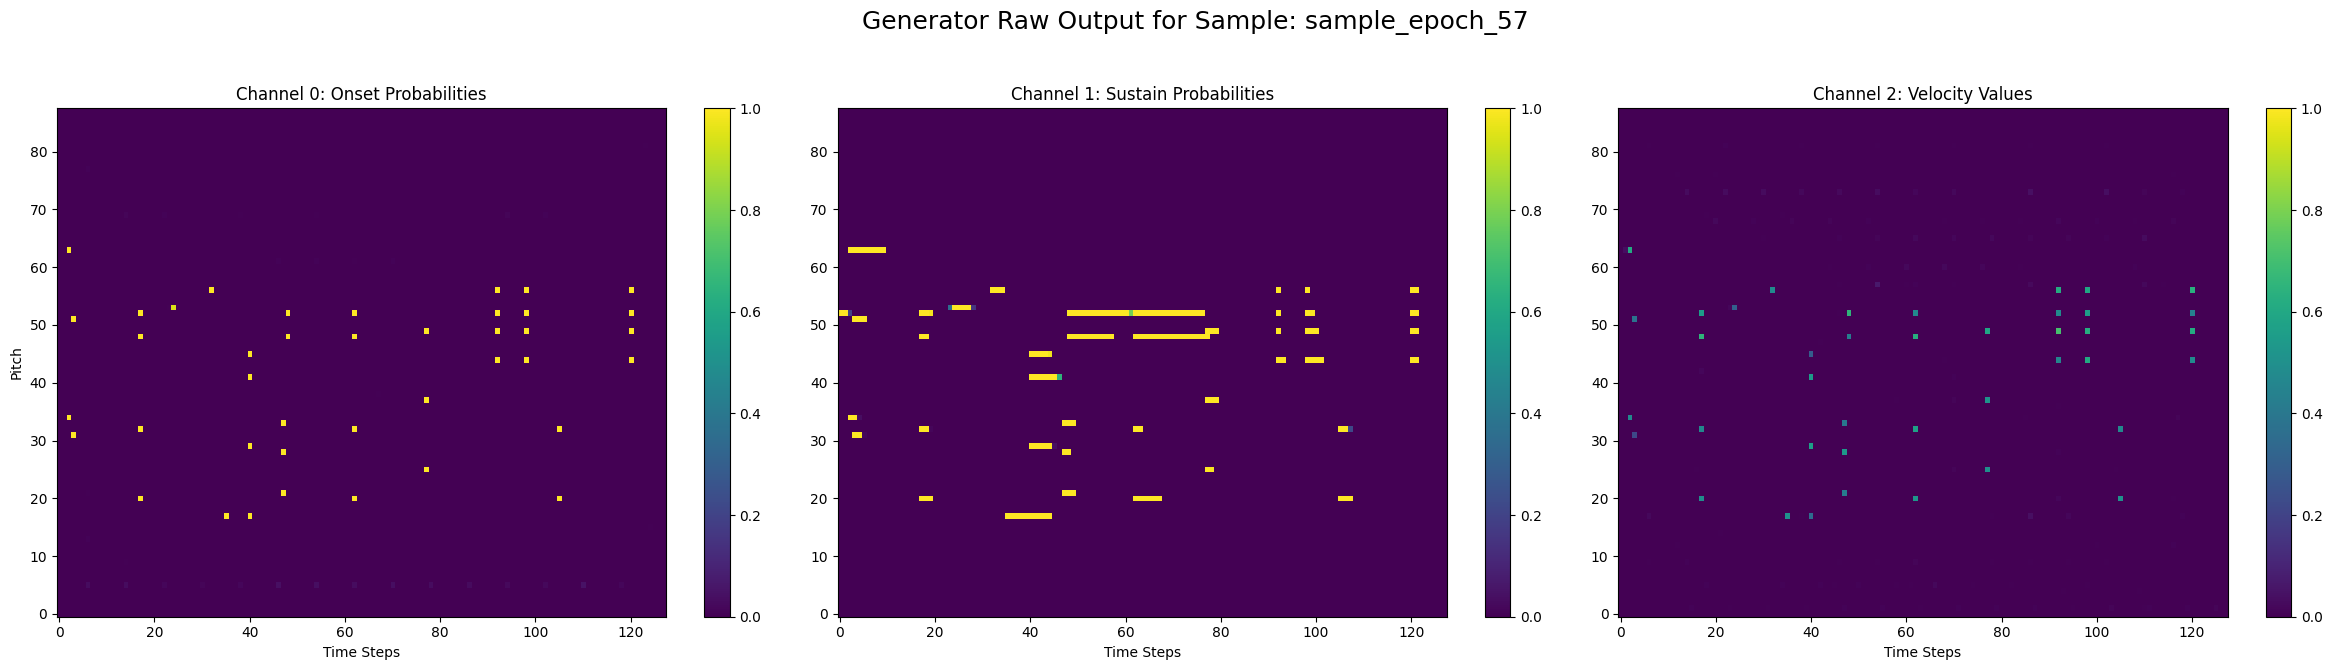

Adv. Epoch 58/100: 100%|██████████| 199/199 [04:49<00:00,  1.46s/it, D_Loss=0.5180, G_Loss=1.2976, Musicality=0.1225]



Adversarial Epoch 58 Summary:
  Generator Losses -> Total: 1.2952, GAN: 1.5480
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2835
  Discriminator Loss -> Total: 0.5148 



Adv. Epoch 59/100: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it, D_Loss=0.5107, G_Loss=1.2921, Musicality=0.1770]



Adversarial Epoch 59 Summary:
  Generator Losses -> Total: 1.2964, GAN: 1.5565
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2556
  Discriminator Loss -> Total: 0.5124 



Adv. Epoch 60/100: 100%|██████████| 199/199 [04:45<00:00,  1.44s/it, D_Loss=0.5094, G_Loss=1.3600, Musicality=0.1996]



Adversarial Epoch 60 Summary:
  Generator Losses -> Total: 1.2933, GAN: 1.5536
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2515
  Discriminator Loss -> Total: 0.5138 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_60 ---


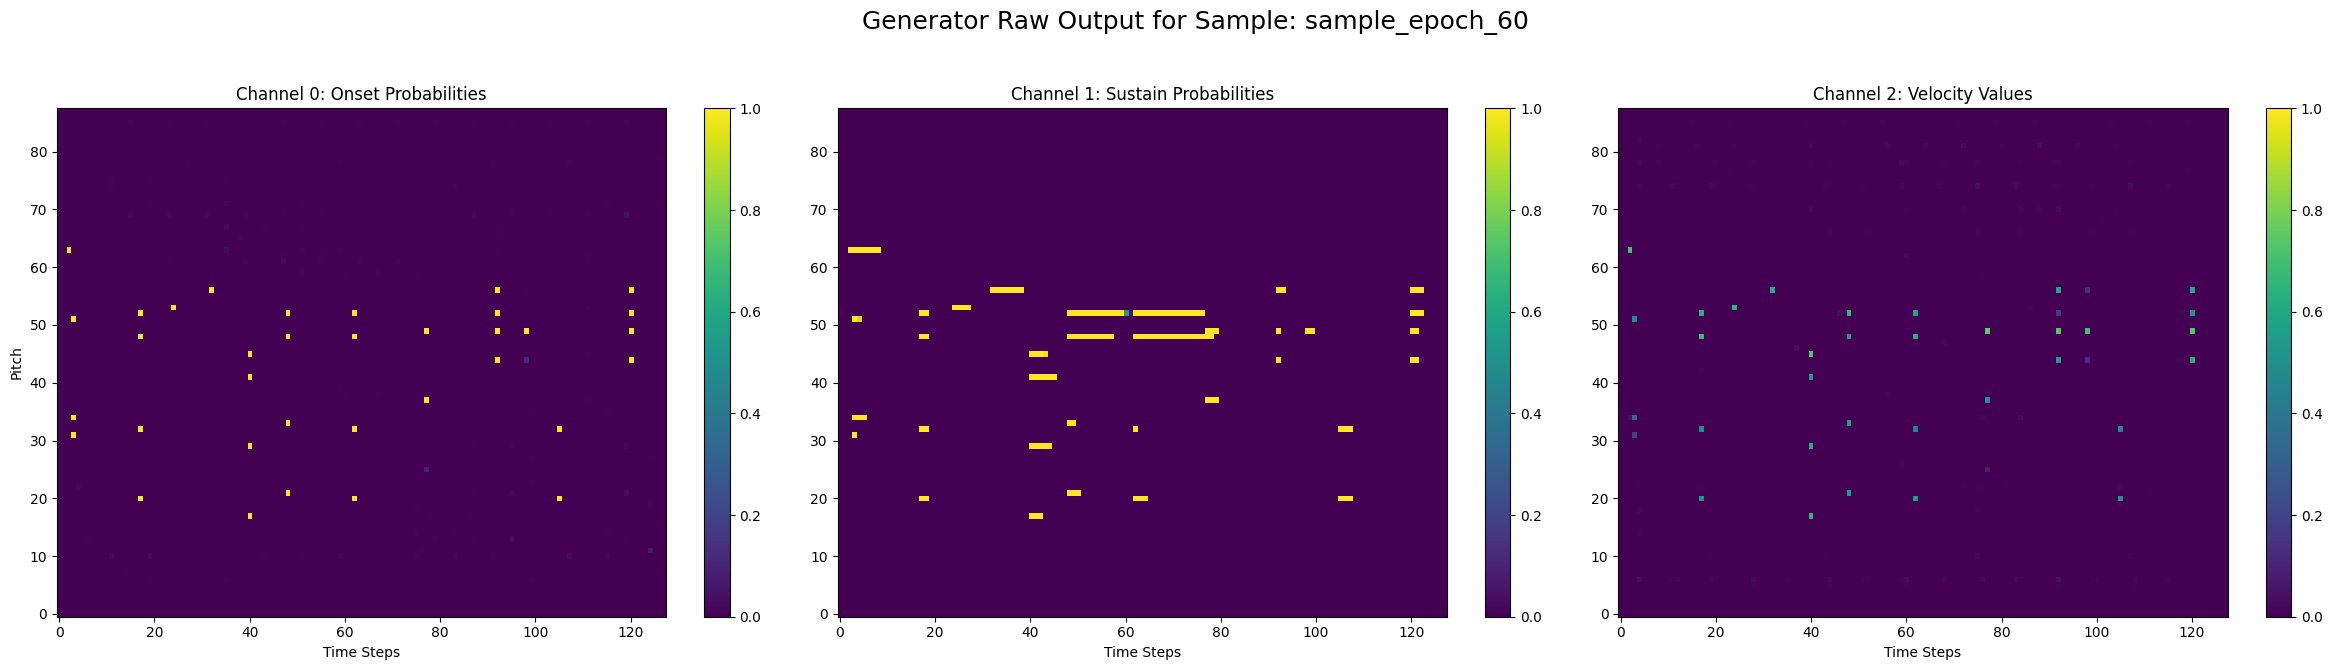

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_60.pth ---


Adv. Epoch 61/100: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it, D_Loss=0.5126, G_Loss=1.3451, Musicality=0.3551]



Adversarial Epoch 61 Summary:
  Generator Losses -> Total: 1.3111, GAN: 1.5713
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2699
  Discriminator Loss -> Total: 0.5096 



Adv. Epoch 62/100: 100%|██████████| 199/199 [04:36<00:00,  1.39s/it, D_Loss=0.5075, G_Loss=1.2683, Musicality=0.1910]



Adversarial Epoch 62 Summary:
  Generator Losses -> Total: 1.3145, GAN: 1.5771
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2634
  Discriminator Loss -> Total: 0.5082 



Adv. Epoch 63/100: 100%|██████████| 199/199 [04:36<00:00,  1.39s/it, D_Loss=0.5043, G_Loss=1.3297, Musicality=0.1248]



Adversarial Epoch 63 Summary:
  Generator Losses -> Total: 1.3051, GAN: 1.5831
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1929
  Discriminator Loss -> Total: 0.5064 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_63 ---


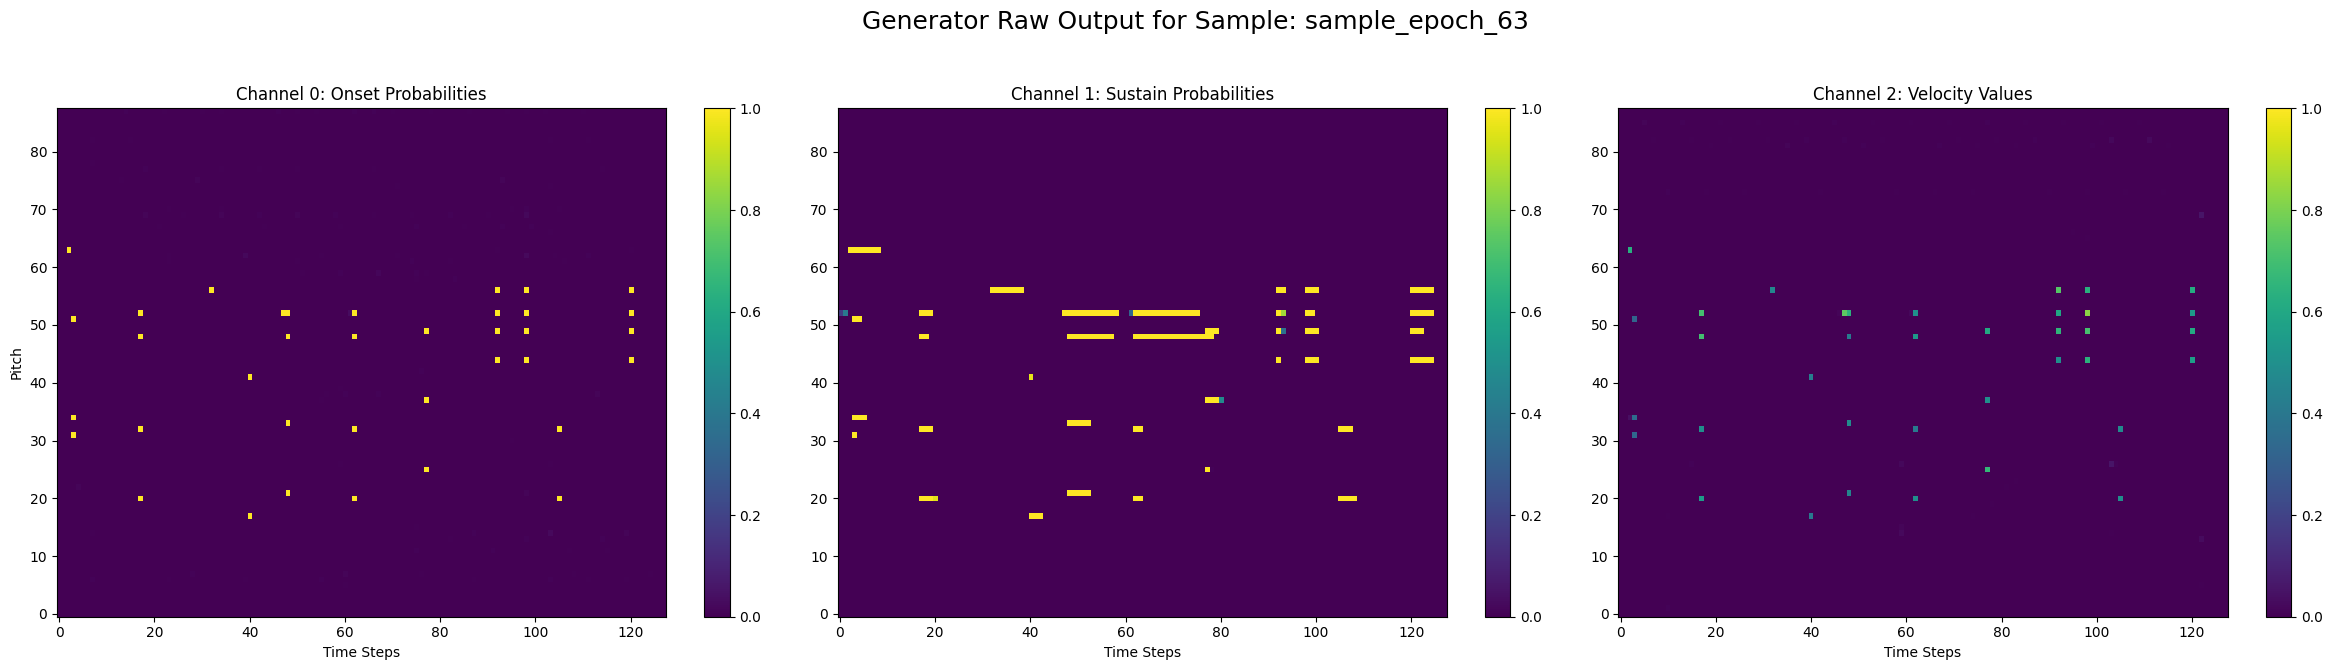

Adv. Epoch 64/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5069, G_Loss=1.2852, Musicality=0.1075]



Adversarial Epoch 64 Summary:
  Generator Losses -> Total: 1.2824, GAN: 1.5712
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1269
  Discriminator Loss -> Total: 0.5101 



Adv. Epoch 65/100: 100%|██████████| 199/199 [04:23<00:00,  1.32s/it, D_Loss=0.5040, G_Loss=1.2868, Musicality=0.0644]



Adversarial Epoch 65 Summary:
  Generator Losses -> Total: 1.2990, GAN: 1.5950
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1142
  Discriminator Loss -> Total: 0.5059 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_65.pth ---


Adv. Epoch 66/100: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it, D_Loss=0.5036, G_Loss=1.2464, Musicality=0.0744]



Adversarial Epoch 66 Summary:
  Generator Losses -> Total: 1.2929, GAN: 1.5868
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.1166
  Discriminator Loss -> Total: 0.5067 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_66 ---


Adv. Epoch 67/100: 100%|██████████| 199/199 [04:22<00:00,  1.32s/it, D_Loss=0.5027, G_Loss=1.2404, Musicality=0.1061]



Adversarial Epoch 67 Summary:
  Generator Losses -> Total: 1.2954, GAN: 1.5897
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1177
  Discriminator Loss -> Total: 0.5070 



Adv. Epoch 68/100: 100%|██████████| 199/199 [04:53<00:00,  1.47s/it, D_Loss=0.5020, G_Loss=1.2686, Musicality=0.0703]



Adversarial Epoch 68 Summary:
  Generator Losses -> Total: 1.2959, GAN: 1.5935
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1049
  Discriminator Loss -> Total: 0.5050 



Adv. Epoch 69/100: 100%|██████████| 199/199 [04:35<00:00,  1.39s/it, D_Loss=0.5064, G_Loss=1.3674, Musicality=0.1284]



Adversarial Epoch 69 Summary:
  Generator Losses -> Total: 1.2980, GAN: 1.5893
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1323
  Discriminator Loss -> Total: 0.5068 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_69 ---


Adv. Epoch 70/100: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it, D_Loss=0.5035, G_Loss=1.2506, Musicality=0.0650]



Adversarial Epoch 70 Summary:
  Generator Losses -> Total: 1.2899, GAN: 1.5859
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1051
  Discriminator Loss -> Total: 0.5061 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_70.pth ---


Adv. Epoch 71/100: 100%|██████████| 199/199 [04:41<00:00,  1.42s/it, D_Loss=0.5378, G_Loss=0.9397, Musicality=0.0473]



Adversarial Epoch 71 Summary:
  Generator Losses -> Total: 1.2857, GAN: 1.5930
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0559
  Discriminator Loss -> Total: 0.5035 



Adv. Epoch 72/100: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it, D_Loss=0.5052, G_Loss=1.2394, Musicality=0.0791]



Adversarial Epoch 72 Summary:
  Generator Losses -> Total: 1.2919, GAN: 1.5861
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1148
  Discriminator Loss -> Total: 0.5078 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_72 ---


Adv. Epoch 73/100: 100%|██████████| 199/199 [04:45<00:00,  1.43s/it, D_Loss=0.5031, G_Loss=1.2889, Musicality=0.1311]



Adversarial Epoch 73 Summary:
  Generator Losses -> Total: 1.2999, GAN: 1.5979
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.1071
  Discriminator Loss -> Total: 0.5037 



Adv. Epoch 74/100: 100%|██████████| 199/199 [04:40<00:00,  1.41s/it, D_Loss=0.5025, G_Loss=1.2861, Musicality=0.0908]



Adversarial Epoch 74 Summary:
  Generator Losses -> Total: 1.2914, GAN: 1.5873
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1072
  Discriminator Loss -> Total: 0.5061 



Adv. Epoch 75/100: 100%|██████████| 199/199 [04:24<00:00,  1.33s/it, D_Loss=0.5049, G_Loss=1.3268, Musicality=0.1138]



Adversarial Epoch 75 Summary:
  Generator Losses -> Total: 1.2913, GAN: 1.5907
  G Musicality -> Impossible: 0.0002, Silent: 0.0005 Orphan Velo: 0.0001, Min Rate: 0.0929
  Discriminator Loss -> Total: 0.5076 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_75 ---


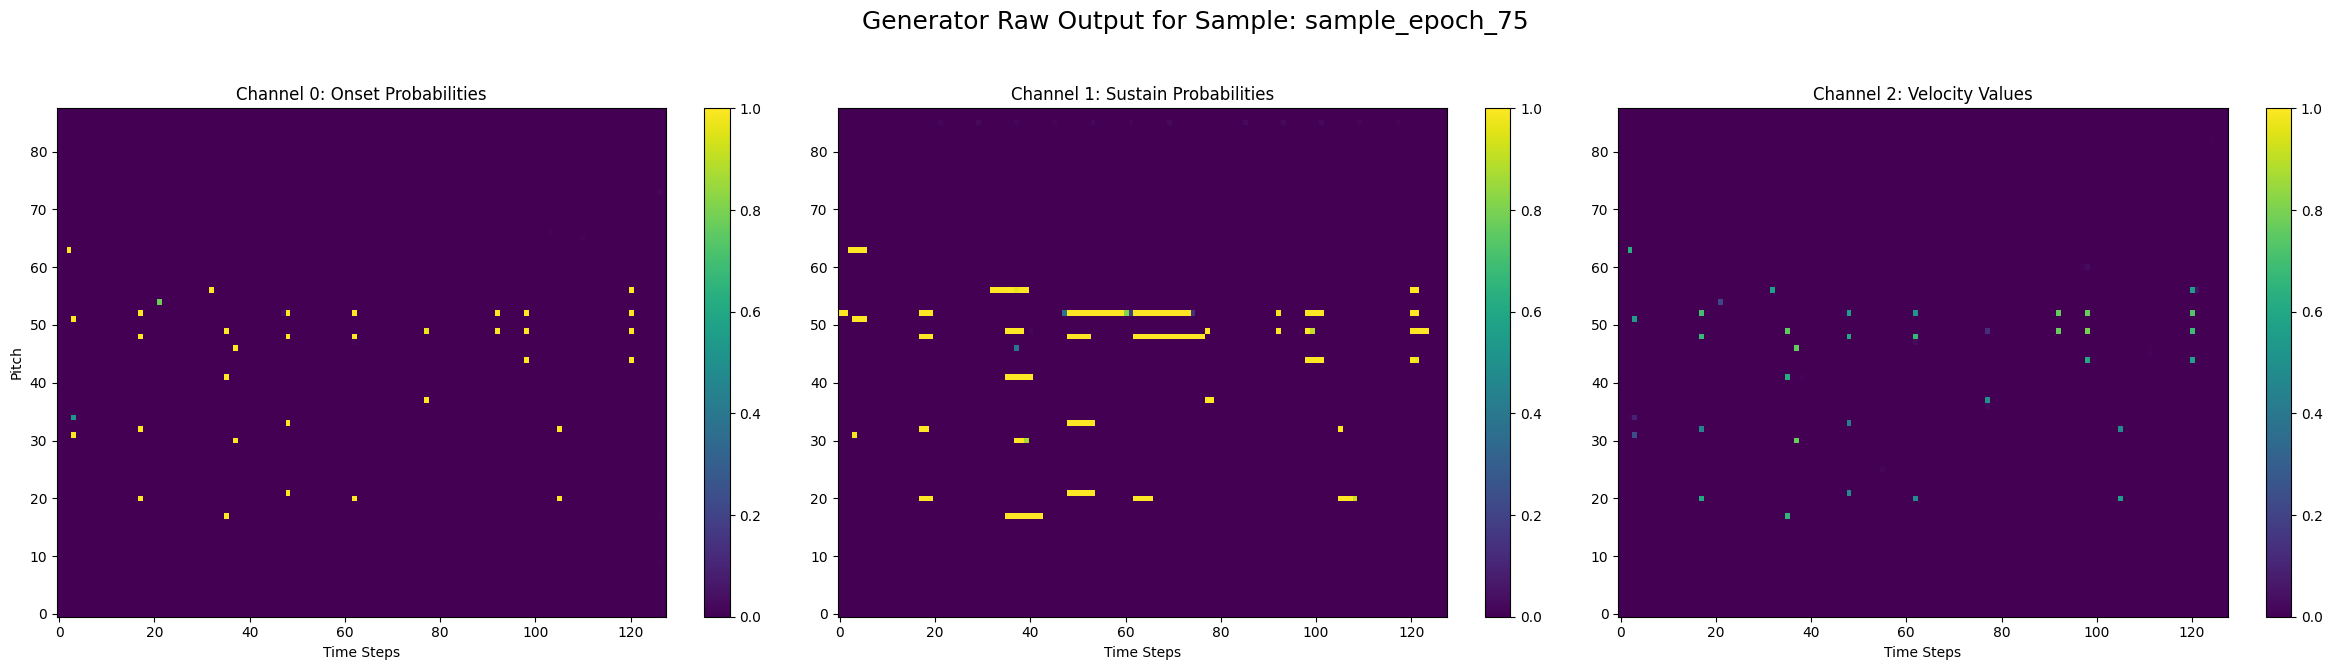

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_75.pth ---


Adv. Epoch 76/100: 100%|██████████| 199/199 [04:42<00:00,  1.42s/it, D_Loss=0.5024, G_Loss=1.3231, Musicality=0.1405]



Adversarial Epoch 76 Summary:
  Generator Losses -> Total: 1.3016, GAN: 1.6018
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1005
  Discriminator Loss -> Total: 0.5037 



Adv. Epoch 77/100: 100%|██████████| 199/199 [04:40<00:00,  1.41s/it, D_Loss=0.5024, G_Loss=1.3110, Musicality=0.0685]



Adversarial Epoch 77 Summary:
  Generator Losses -> Total: 1.3021, GAN: 1.6055
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0879
  Discriminator Loss -> Total: 0.5023 



Adv. Epoch 78/100: 100%|██████████| 199/199 [04:41<00:00,  1.41s/it, D_Loss=0.5106, G_Loss=1.2944, Musicality=0.1051]



Adversarial Epoch 78 Summary:
  Generator Losses -> Total: 1.2833, GAN: 1.5842
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0002, Min Rate: 0.0788
  Discriminator Loss -> Total: 0.5060 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_78 ---


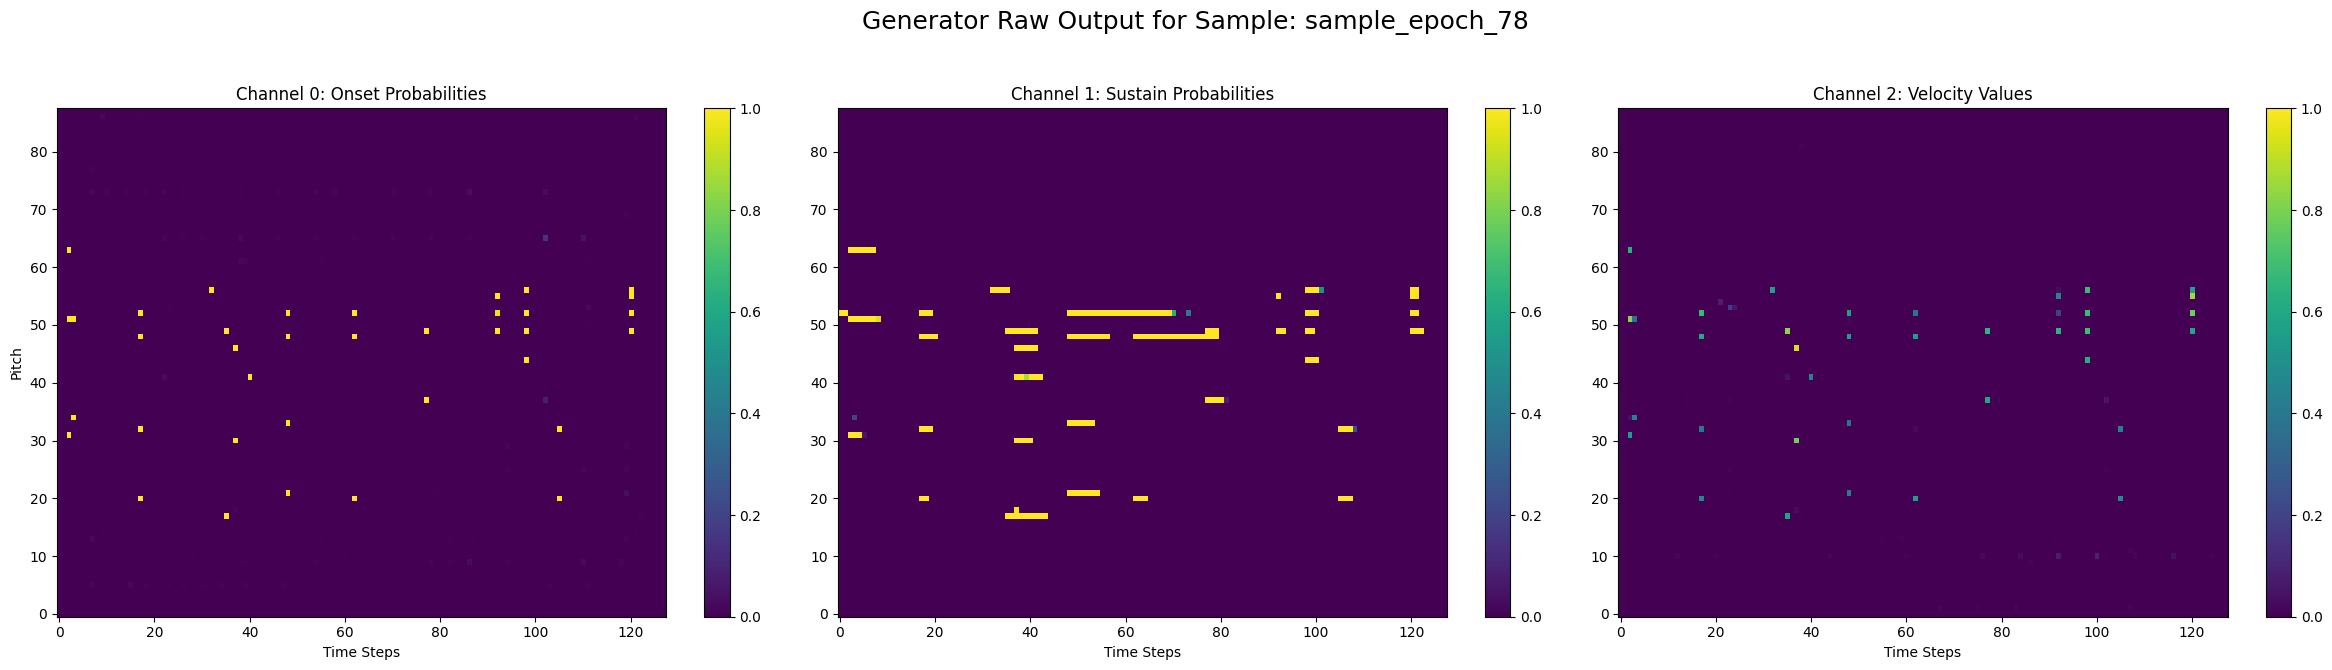

Adv. Epoch 79/100: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it, D_Loss=0.5037, G_Loss=1.3036, Musicality=0.0658]



Adversarial Epoch 79 Summary:
  Generator Losses -> Total: 1.2983, GAN: 1.5965
  G Musicality -> Impossible: 0.0003, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.1047
  Discriminator Loss -> Total: 0.5050 



Adv. Epoch 80/100: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it, D_Loss=0.5025, G_Loss=1.2979, Musicality=0.0575]



Adversarial Epoch 80 Summary:
  Generator Losses -> Total: 1.2952, GAN: 1.6000
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0754
  Discriminator Loss -> Total: 0.5028 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_80.pth ---


Adv. Epoch 81/100: 100%|██████████| 199/199 [04:43<00:00,  1.43s/it, D_Loss=0.5026, G_Loss=1.3172, Musicality=0.0448]



Adversarial Epoch 81 Summary:
  Generator Losses -> Total: 1.2873, GAN: 1.5896
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0779
  Discriminator Loss -> Total: 0.5054 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_81 ---


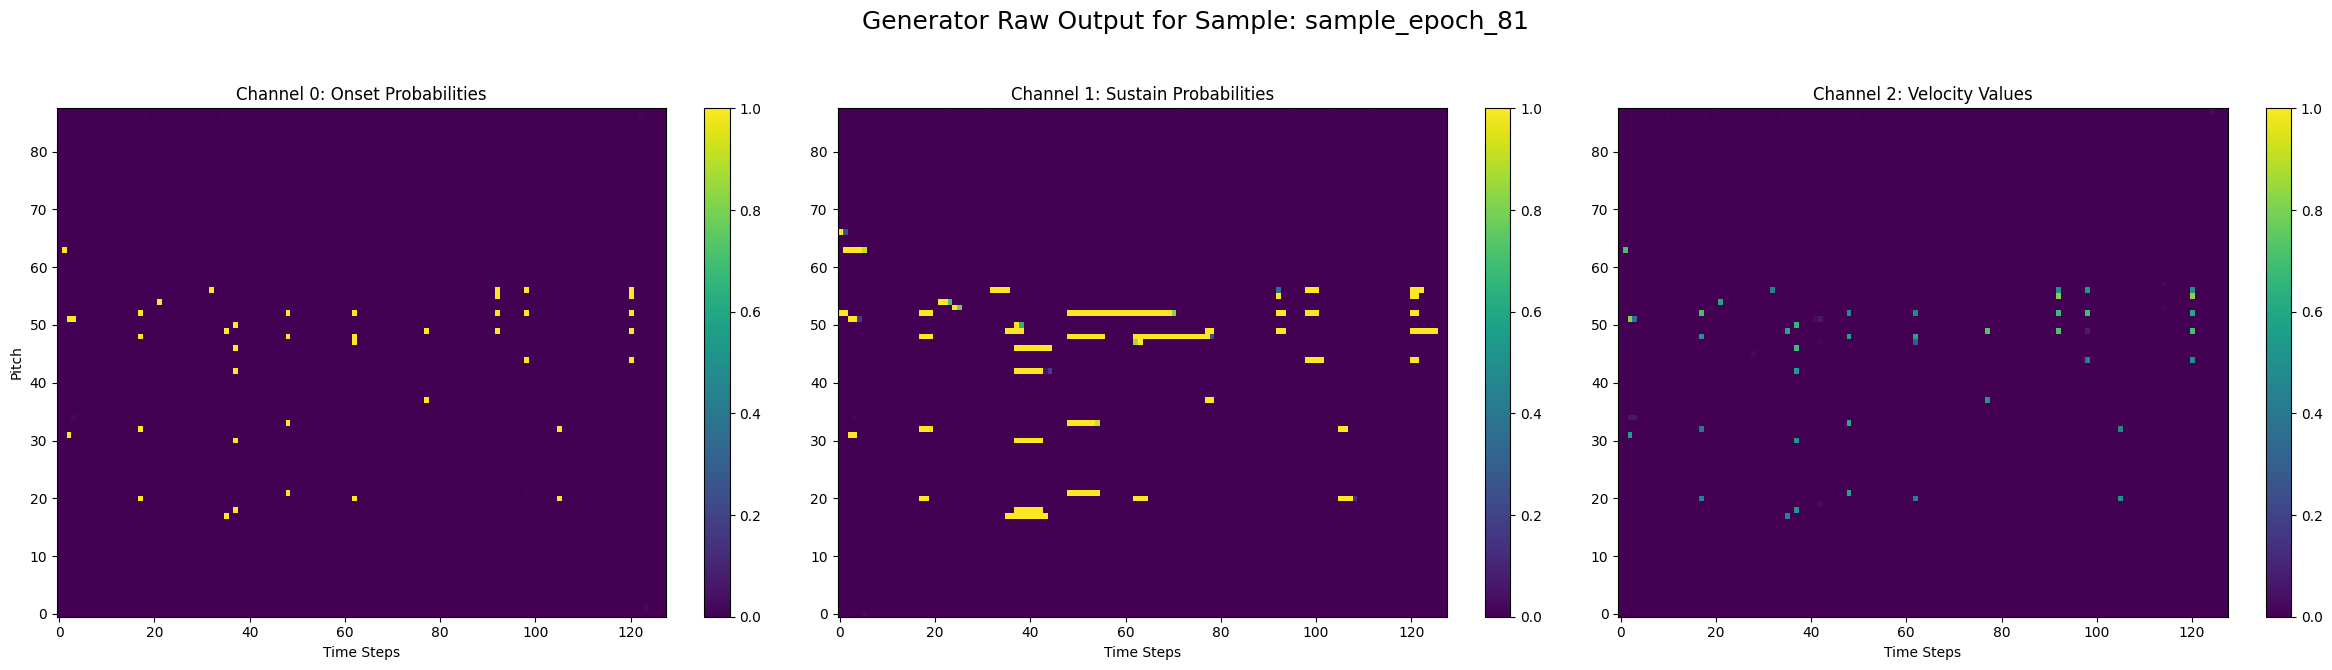

Adv. Epoch 82/100: 100%|██████████| 199/199 [04:40<00:00,  1.41s/it, D_Loss=0.5036, G_Loss=1.3613, Musicality=0.2168]



Adversarial Epoch 82 Summary:
  Generator Losses -> Total: 1.3128, GAN: 1.5869
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2161
  Discriminator Loss -> Total: 0.5078 



Adv. Epoch 83/100: 100%|██████████| 199/199 [04:41<00:00,  1.42s/it, D_Loss=0.5037, G_Loss=1.3366, Musicality=0.2464]



Adversarial Epoch 83 Summary:
  Generator Losses -> Total: 1.3233, GAN: 1.5992
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2190
  Discriminator Loss -> Total: 0.5036 



Adv. Epoch 84/100: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it, D_Loss=0.5043, G_Loss=1.3435, Musicality=0.2158]



Adversarial Epoch 84 Summary:
  Generator Losses -> Total: 1.3084, GAN: 1.5790
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2255
  Discriminator Loss -> Total: 0.5074 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_84 ---


Adv. Epoch 85/100: 100%|██████████| 199/199 [04:43<00:00,  1.42s/it, D_Loss=0.5038, G_Loss=1.3237, Musicality=0.2199]



Adversarial Epoch 85 Summary:
  Generator Losses -> Total: 1.3205, GAN: 1.5944
  G Musicality -> Impossible: 0.0001, Silent: 0.0002 Orphan Velo: 0.0001, Min Rate: 0.2245
  Discriminator Loss -> Total: 0.5038 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_85.pth ---


Adv. Epoch 86/100: 100%|██████████| 199/199 [04:45<00:00,  1.43s/it, D_Loss=0.5056, G_Loss=1.2580, Musicality=0.2228]



Adversarial Epoch 86 Summary:
  Generator Losses -> Total: 1.3209, GAN: 1.5978
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.2128
  Discriminator Loss -> Total: 0.5034 



Adv. Epoch 87/100: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it, D_Loss=0.5032, G_Loss=1.3228, Musicality=0.2264]



Adversarial Epoch 87 Summary:
  Generator Losses -> Total: 1.2984, GAN: 1.5845
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1535
  Discriminator Loss -> Total: 0.5086 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_87 ---


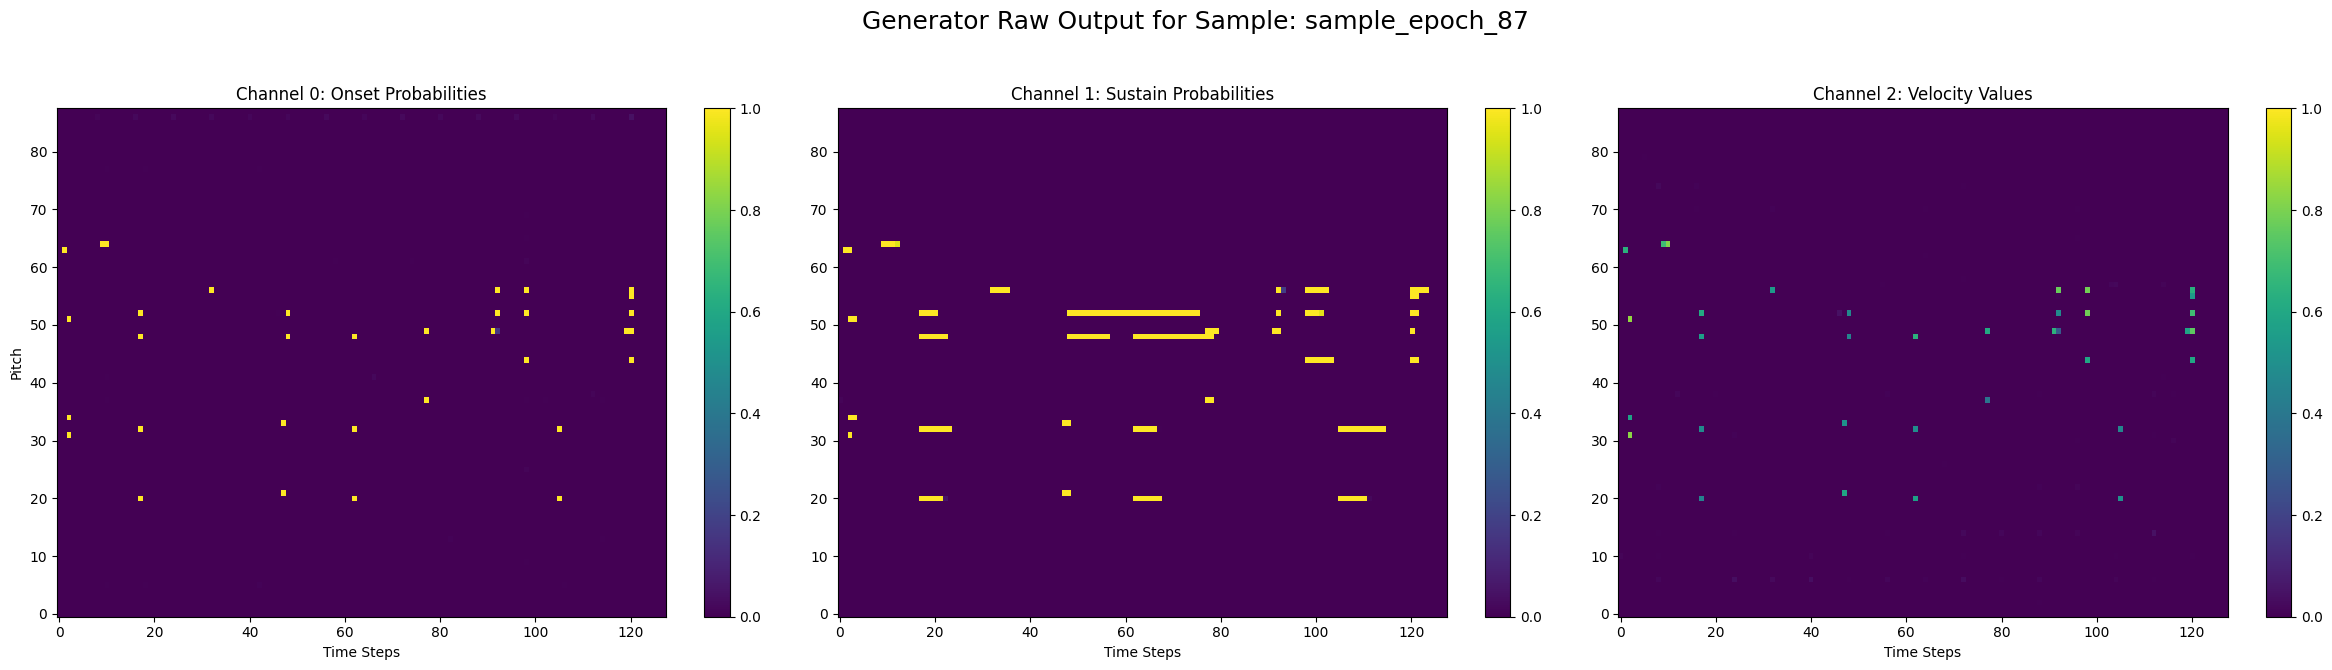

Adv. Epoch 88/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5053, G_Loss=1.3096, Musicality=0.1475]



Adversarial Epoch 88 Summary:
  Generator Losses -> Total: 1.3071, GAN: 1.5836
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.2007
  Discriminator Loss -> Total: 0.5081 



Adv. Epoch 89/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5023, G_Loss=1.2842, Musicality=0.1915]



Adversarial Epoch 89 Summary:
  Generator Losses -> Total: 1.3161, GAN: 1.5960
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1962
  Discriminator Loss -> Total: 0.5040 



Adv. Epoch 90/100: 100%|██████████| 199/199 [04:47<00:00,  1.44s/it, D_Loss=0.5017, G_Loss=1.3276, Musicality=0.1830]



Adversarial Epoch 90 Summary:
  Generator Losses -> Total: 1.3151, GAN: 1.5948
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1961
  Discriminator Loss -> Total: 0.5048 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_90 ---


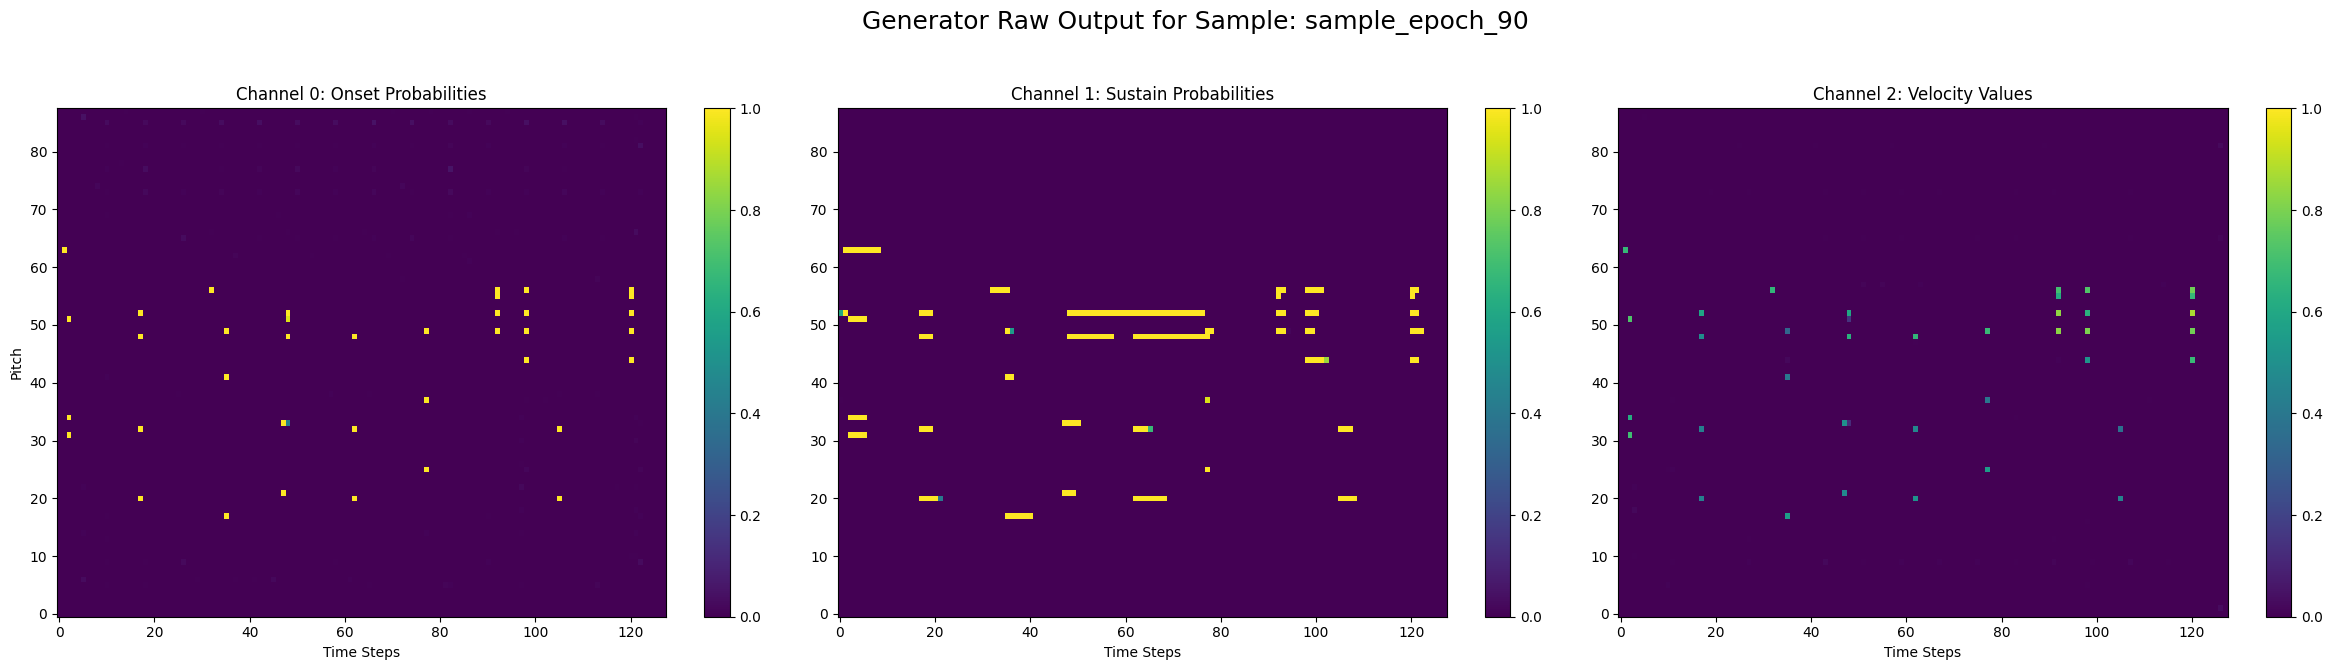

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_90.pth ---


Adv. Epoch 91/100: 100%|██████████| 199/199 [04:48<00:00,  1.45s/it, D_Loss=0.5016, G_Loss=1.2927, Musicality=0.0695]



Adversarial Epoch 91 Summary:
  Generator Losses -> Total: 1.3134, GAN: 1.5997
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1679
  Discriminator Loss -> Total: 0.5028 



Adv. Epoch 92/100: 100%|██████████| 199/199 [04:45<00:00,  1.44s/it, D_Loss=0.5012, G_Loss=1.2998, Musicality=0.0407]



Adversarial Epoch 92 Summary:
  Generator Losses -> Total: 1.2934, GAN: 1.6034
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0528
  Discriminator Loss -> Total: 0.5016 



Adv. Epoch 93/100: 100%|██████████| 199/199 [04:45<00:00,  1.43s/it, D_Loss=0.5014, G_Loss=1.3068, Musicality=0.0246]



Adversarial Epoch 93 Summary:
  Generator Losses -> Total: 1.2909, GAN: 1.6051
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0336
  Discriminator Loss -> Total: 0.5016 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_93 ---


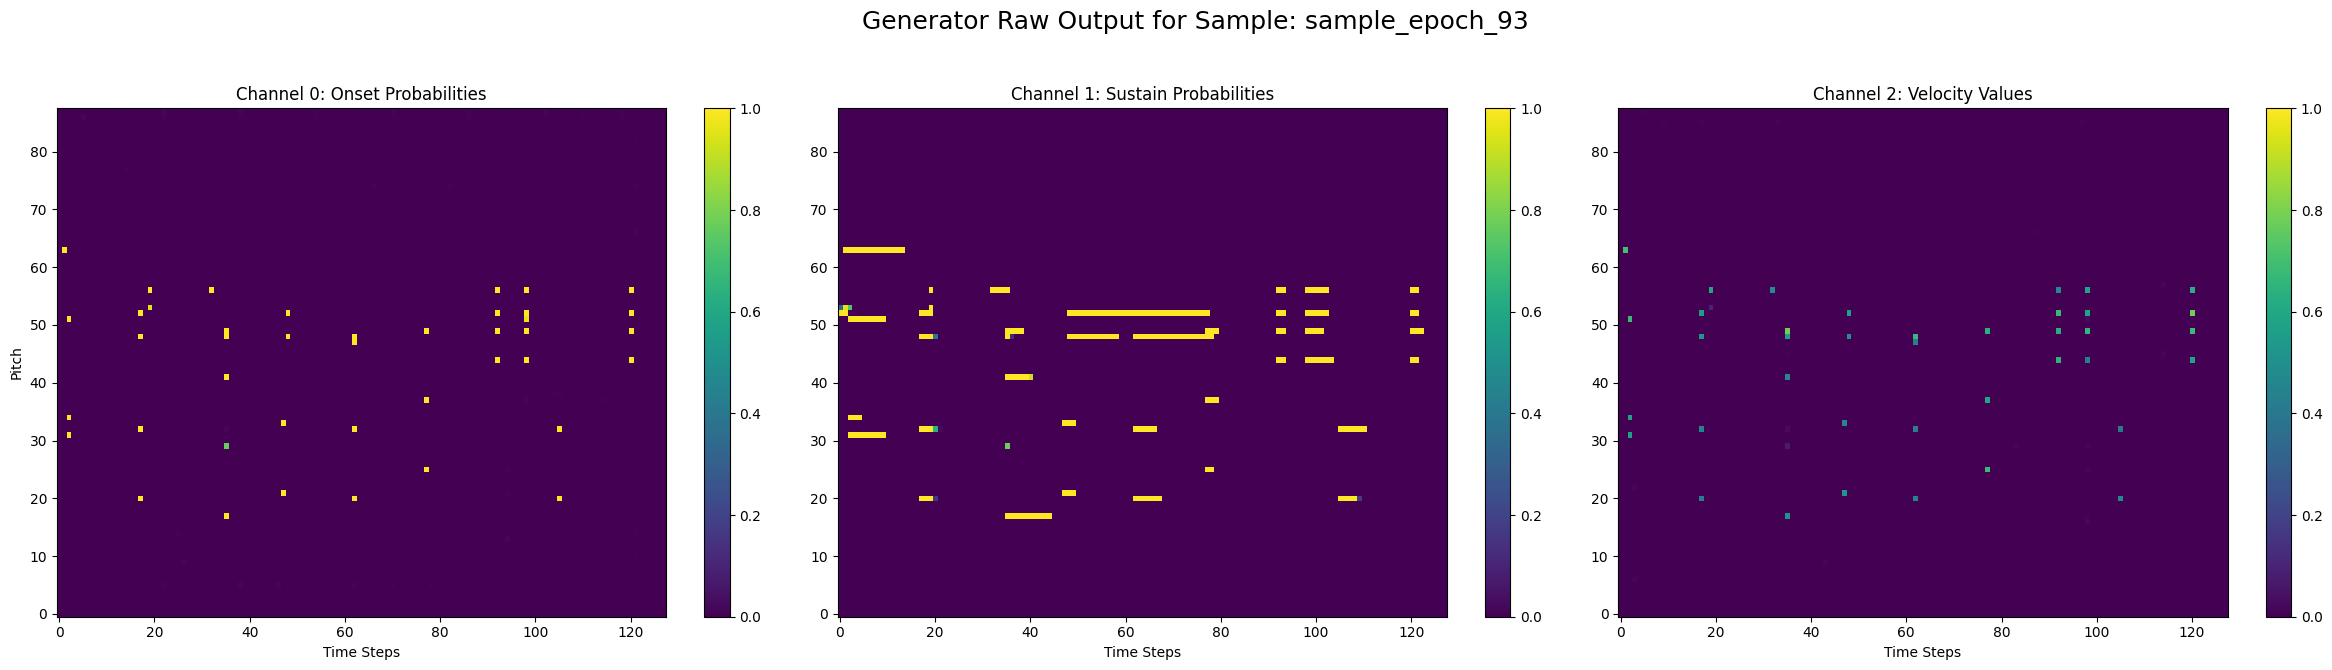

Adv. Epoch 94/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5015, G_Loss=1.2743, Musicality=0.0384]



Adversarial Epoch 94 Summary:
  Generator Losses -> Total: 1.2922, GAN: 1.6063
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0349
  Discriminator Loss -> Total: 0.5015 



Adv. Epoch 95/100: 100%|██████████| 199/199 [04:44<00:00,  1.43s/it, D_Loss=0.5029, G_Loss=1.2870, Musicality=0.0430]



Adversarial Epoch 95 Summary:
  Generator Losses -> Total: 1.2910, GAN: 1.6040
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0387
  Discriminator Loss -> Total: 0.5017 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_95.pth ---


Adv. Epoch 96/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5037, G_Loss=1.3120, Musicality=0.0720]



Adversarial Epoch 96 Summary:
  Generator Losses -> Total: 1.2927, GAN: 1.5875
  G Musicality -> Impossible: 0.0001, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.1133
  Discriminator Loss -> Total: 0.5084 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_96 ---


Adv. Epoch 97/100: 100%|██████████| 199/199 [04:45<00:00,  1.44s/it, D_Loss=0.5066, G_Loss=1.2797, Musicality=0.0398]



Adversarial Epoch 97 Summary:
  Generator Losses -> Total: 1.2920, GAN: 1.6016
  G Musicality -> Impossible: 0.0001, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0532
  Discriminator Loss -> Total: 0.5033 



Adv. Epoch 98/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5014, G_Loss=1.2803, Musicality=0.0323]



Adversarial Epoch 98 Summary:
  Generator Losses -> Total: 1.2922, GAN: 1.6038
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0002, Min Rate: 0.0451
  Discriminator Loss -> Total: 0.5017 



Adv. Epoch 99/100: 100%|██████████| 199/199 [04:45<00:00,  1.44s/it, D_Loss=0.5018, G_Loss=1.3200, Musicality=0.0392]



Adversarial Epoch 99 Summary:
  Generator Losses -> Total: 1.2928, GAN: 1.6062
  G Musicality -> Impossible: 0.0002, Silent: 0.0003 Orphan Velo: 0.0001, Min Rate: 0.0387
  Discriminator Loss -> Total: 0.5016 

--- Visualizing: Generator Raw Output for Sample: sample_epoch_99 ---


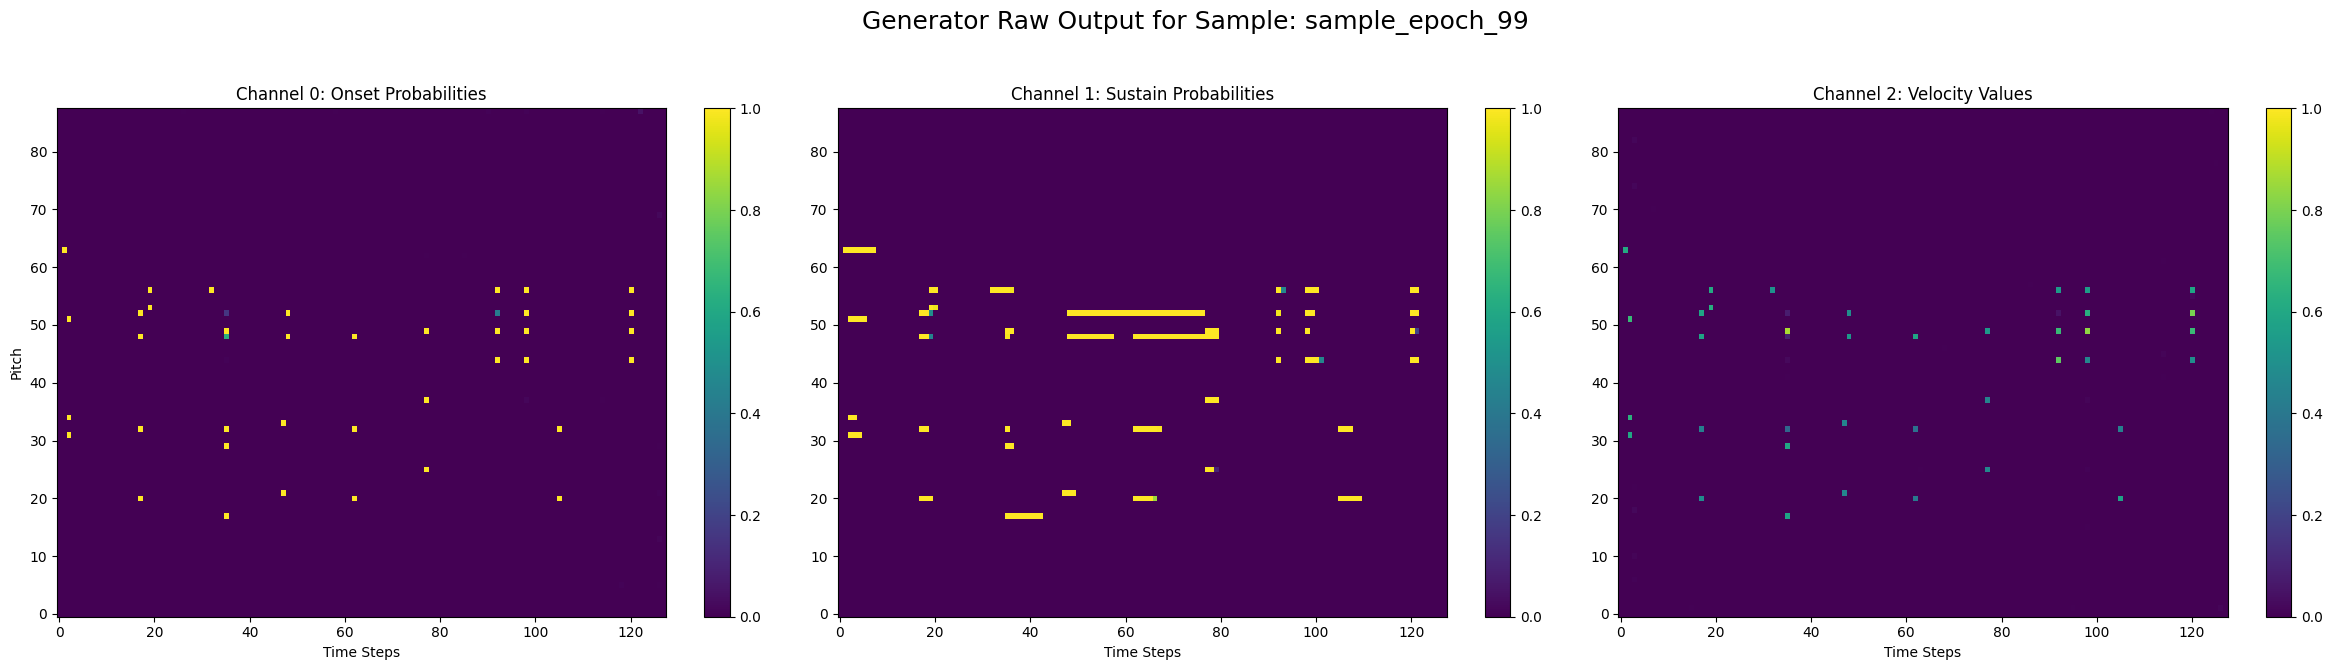

Adv. Epoch 100/100: 100%|██████████| 199/199 [04:46<00:00,  1.44s/it, D_Loss=0.5060, G_Loss=1.2884, Musicality=0.1854]



Adversarial Epoch 100 Summary:
  Generator Losses -> Total: 1.2788, GAN: 1.5815
  G Musicality -> Impossible: 0.0002, Silent: 0.0004 Orphan Velo: 0.0001, Min Rate: 0.0678
  Discriminator Loss -> Total: 0.5078 

--- Saving checkpoint to C:\Users\User\Desktop\college\fyp\models\RaGAN\checkpoint_epoch_100.pth ---

Training complete! Generating loss plot...


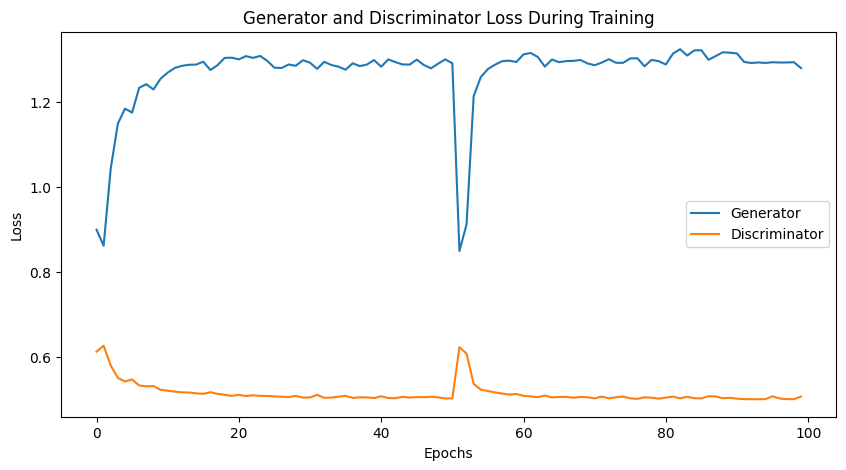

In [2]:
if __name__ == "__main__":
    SEED = 42 # Choose any number, but use the same one for comparable runs
    
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
    # This can slow down training, but ensures that CUDA operations are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"--- Running with fixed random seed: {SEED} ---")
    
    try:
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        pass

    # --- Setup ---
    config = Config(model_type='RaGAN')
    data_handler = DataHandler(config)
    
    # This function now also saves the CSV
    jazz_files, non_jazz_files_for_gan = data_handler.get_data_files()

    # --- DataLoaders ---
    print("\n--- Creating Datasets and DataLoaders ---")
    real_dataset = MultiChannelLazyDataset(jazz_files, [1]*len(jazz_files), dataset_name="Real Jazz (for D)")
    content_dataset = MultiChannelEagerDataset(non_jazz_files_for_gan, [0]*len(non_jazz_files_for_gan), dataset_name="Non-Jazz (for G)")
    
    real_loader = DataLoader(
        real_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
        persistent_workers=True if config.NUM_WORKERS > 0 else False
    )
    content_loader = DataLoader(
        content_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=0, 
        pin_memory=True
    )
    
    # --- Training ---
    trainer = GANTrainer(config)
    
    print("Starting Generator Pre-training...")
    trainer.pretrain_generator(content_loader)
    
    print("\nStarting Adversarial Training...")
    trainer.train_adversarially(real_loader, content_loader)
    
    # --- Finalization ---
    print("\nTraining complete! Generating loss plot...")
    plot_losses(trainer.g_losses, trainer.d_losses)

## Transformer-VAE Training

--- Running with fixed random seed: 42 ---
Using device: cuda
Found existing VAE file list at: C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_vae_training.csv. Loading from CSV.
Creating an EAGER dataset with 700 Jazz and 700 Non-Jazz files.
EAGERLY loading all multi-channel segments for 'Balanced VAE Eager Dataset' into RAM...


Loading files: 100%|██████████| 1400/1400 [00:16<00:00, 87.11it/s]


Eager loading complete. Total segments: 90078. Shape: (90078, 4, 88, 128)
Transformer-VAE model initialized on cuda.
Total trainable parameters: 44,803,848

--- Training Transformer-VAE with Cyclical Beta Annealing & Free Bits ---


Epoch 1/100: 100%|██████████| 2815/2815 [11:02<00:00,  4.25it/s, beta=0.000, kld=23.10, recon=1194.83, total_loss=1194.83]


Epoch 1 Summary: Avg Loss: 1603.06, Avg Recon: 1603.06, Avg KLD: 13.53


Epoch 2/100: 100%|██████████| 2815/2815 [11:05<00:00,  4.23it/s, beta=0.400, kld=19.10, recon=852.20, total_loss=859.84]  


Epoch 2 Summary: Avg Loss: 996.09, Avg Recon: 989.39, Avg KLD: 16.74


Epoch 3/100: 100%|██████████| 2815/2815 [11:13<00:00,  4.18it/s, beta=0.800, kld=16.01, recon=783.98, total_loss=796.78]  


Epoch 3 Summary: Avg Loss: 818.30, Avg Recon: 806.00, Avg KLD: 15.37


Epoch 4/100: 100%|██████████| 2815/2815 [11:22<00:00,  4.12it/s, beta=1.200, kld=15.34, recon=717.41, total_loss=735.81] 


Epoch 4 Summary: Avg Loss: 728.35, Avg Recon: 711.14, Avg KLD: 14.34


Epoch 5/100: 100%|██████████| 2815/2815 [11:04<00:00,  4.24it/s, beta=1.600, kld=15.19, recon=717.20, total_loss=741.50]


Epoch 5 Summary: Avg Loss: 666.97, Avg Recon: 645.10, Avg KLD: 13.67

--- Saving sample for epoch 5 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_5 ---


Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_5.mid


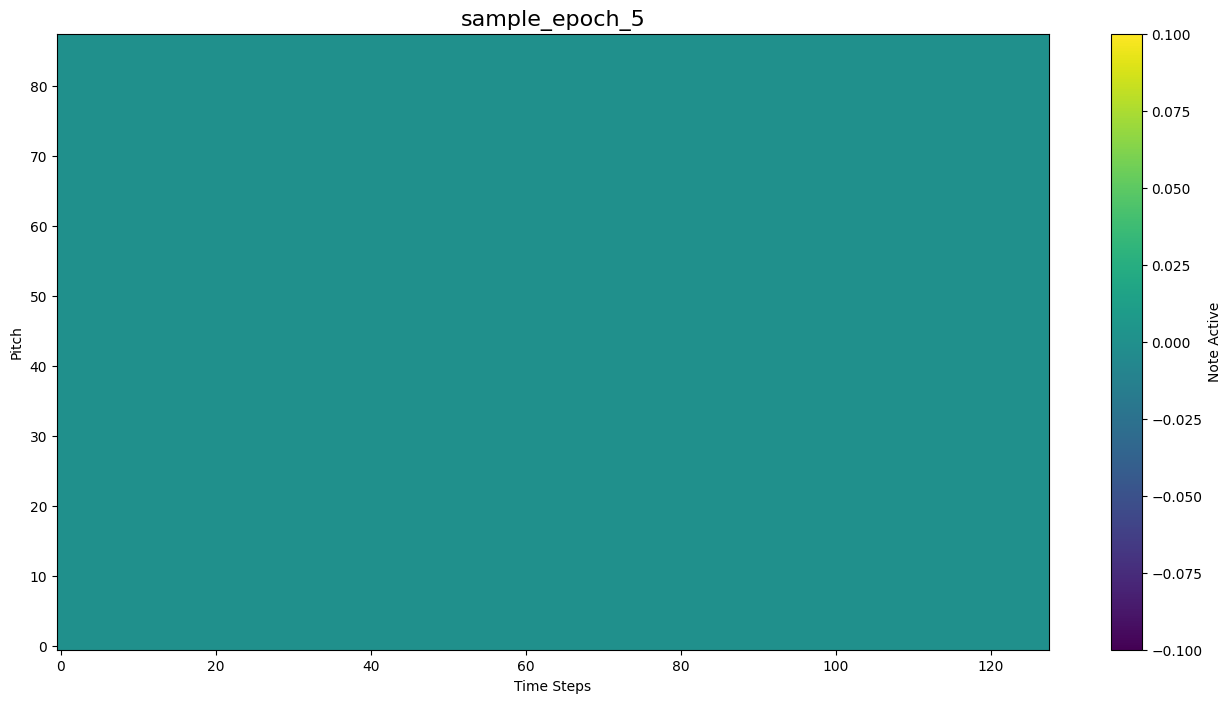

Epoch 6/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=2.000, kld=14.28, recon=547.34, total_loss=575.89]


Epoch 6 Summary: Avg Loss: 623.71, Avg Recon: 597.63, Avg KLD: 13.04


Epoch 7/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=2.400, kld=12.81, recon=523.60, total_loss=554.34]


Epoch 7 Summary: Avg Loss: 585.98, Avg Recon: 555.94, Avg KLD: 12.52


Epoch 8/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=2.800, kld=14.01, recon=632.70, total_loss=671.93]


Epoch 8 Summary: Avg Loss: 552.19, Avg Recon: 518.42, Avg KLD: 12.06


Epoch 9/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=3.200, kld=13.33, recon=518.70, total_loss=561.35]


Epoch 9 Summary: Avg Loss: 524.56, Avg Recon: 487.42, Avg KLD: 11.60


Epoch 10/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=3.600, kld=10.98, recon=519.54, total_loss=559.06]


Epoch 10 Summary: Avg Loss: 500.73, Avg Recon: 460.65, Avg KLD: 11.13

--- Saving sample for epoch 10 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_10 ---


Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_10.mid


Epoch 11/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.27it/s, beta=4.000, kld=11.56, recon=466.02, total_loss=512.26]


Epoch 11 Summary: Avg Loss: 478.72, Avg Recon: 435.78, Avg KLD: 10.73


Epoch 12/100: 100%|██████████| 2815/2815 [11:12<00:00,  4.19it/s, beta=3.600, kld=12.28, recon=463.13, total_loss=507.35]


Epoch 12 Summary: Avg Loss: 450.77, Avg Recon: 411.30, Avg KLD: 10.96


Epoch 13/100: 100%|██████████| 2815/2815 [11:18<00:00,  4.15it/s, beta=3.200, kld=11.72, recon=407.62, total_loss=445.11]


Epoch 13 Summary: Avg Loss: 425.57, Avg Recon: 389.39, Avg KLD: 11.31


Epoch 14/100: 100%|██████████| 2815/2815 [11:19<00:00,  4.14it/s, beta=2.800, kld=12.50, recon=364.09, total_loss=399.08]


Epoch 14 Summary: Avg Loss: 401.93, Avg Recon: 369.10, Avg KLD: 11.73


Epoch 15/100: 100%|██████████| 2815/2815 [11:15<00:00,  4.17it/s, beta=2.400, kld=12.95, recon=316.03, total_loss=347.12]


Epoch 15 Summary: Avg Loss: 380.09, Avg Recon: 350.71, Avg KLD: 12.24

--- Saving sample for epoch 15 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_15 ---


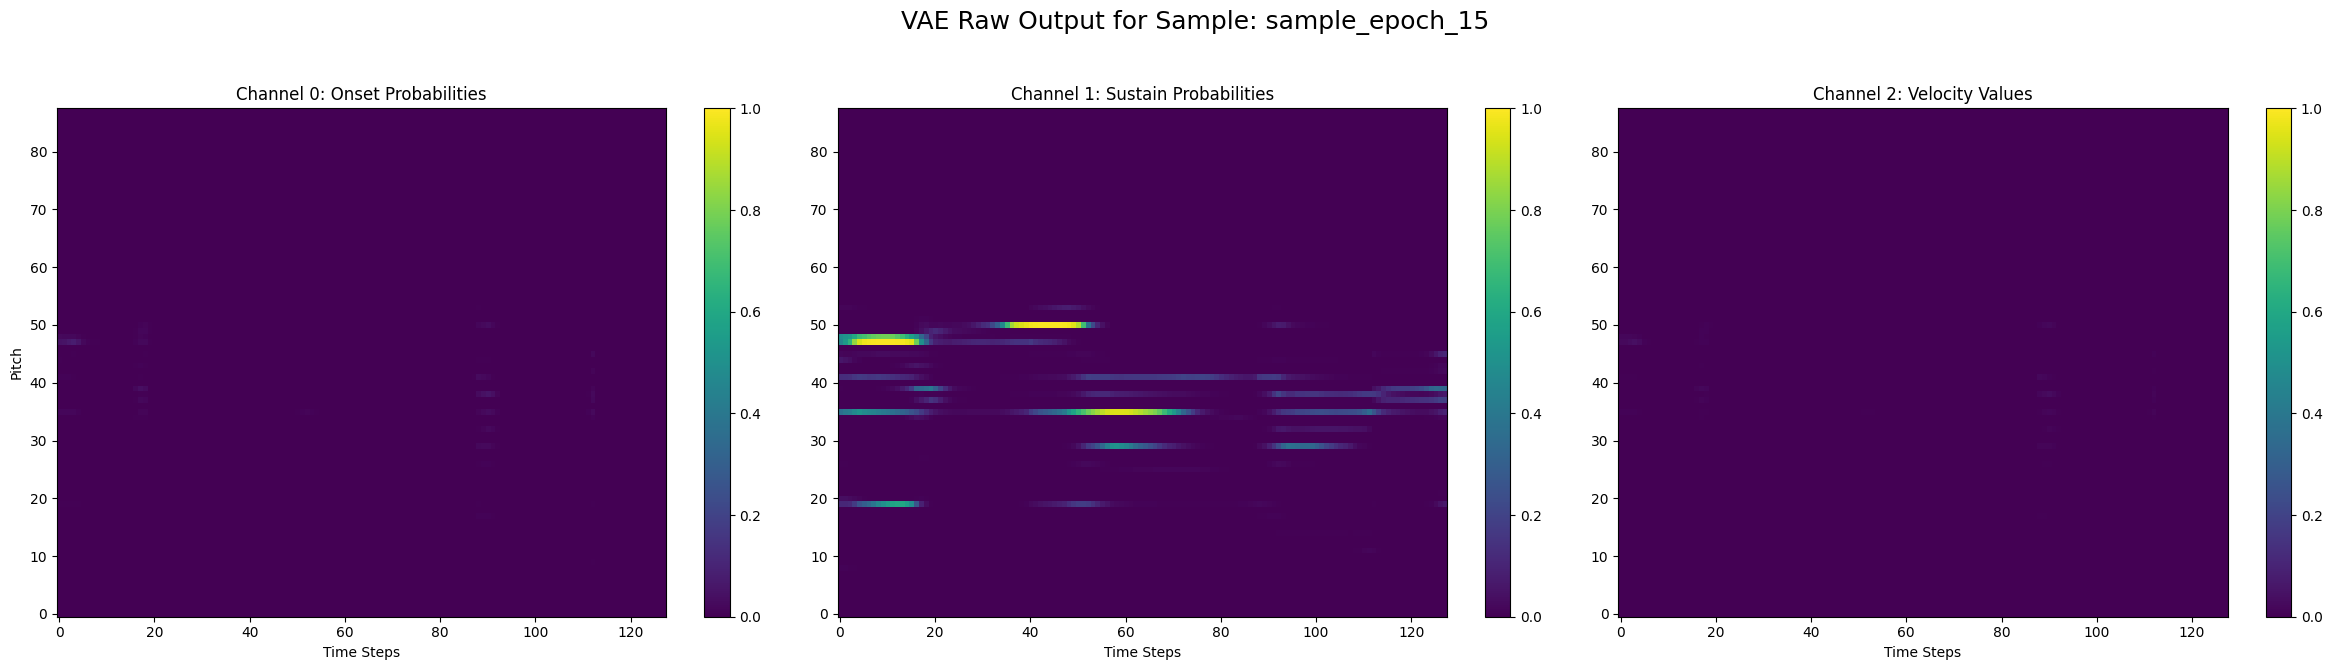

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_15.mid


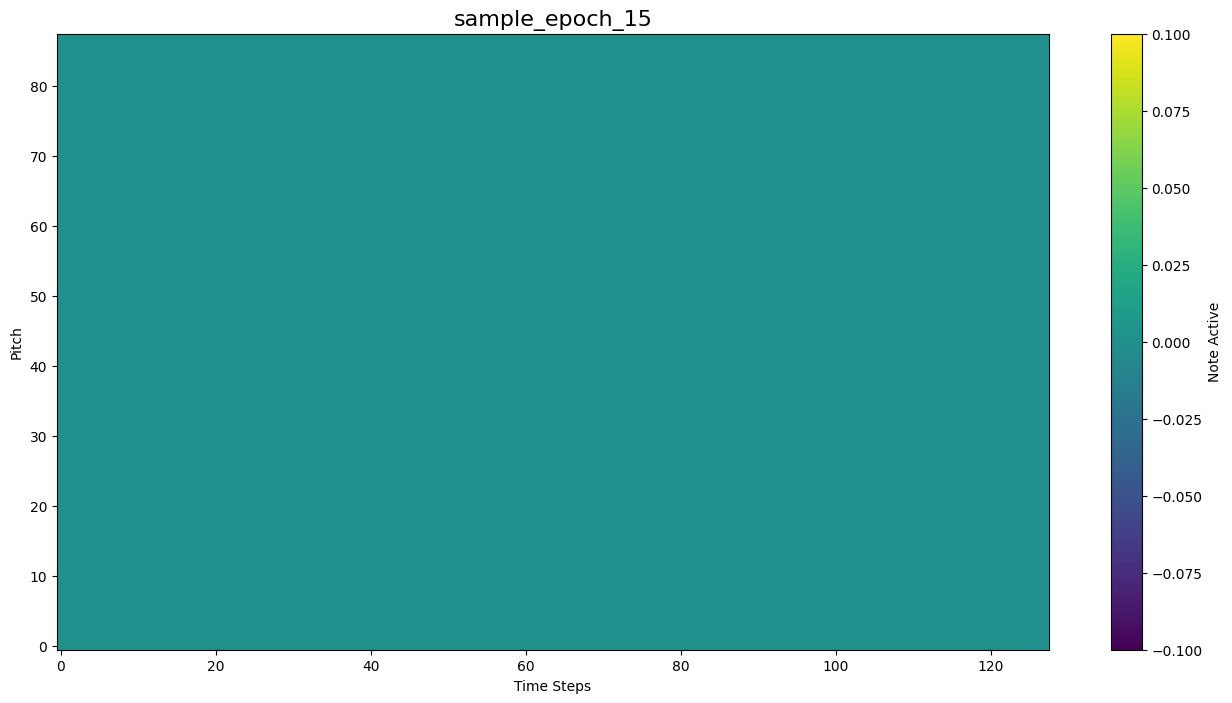

Epoch 16/100: 100%|██████████| 2815/2815 [11:15<00:00,  4.17it/s, beta=2.000, kld=13.45, recon=310.18, total_loss=337.08]


Epoch 16 Summary: Avg Loss: 359.83, Avg Recon: 334.07, Avg KLD: 12.88


Epoch 17/100: 100%|██████████| 2815/2815 [11:14<00:00,  4.17it/s, beta=1.600, kld=14.94, recon=277.58, total_loss=301.48]


Epoch 17 Summary: Avg Loss: 340.58, Avg Recon: 318.68, Avg KLD: 13.69


Epoch 18/100: 100%|██████████| 2815/2815 [11:15<00:00,  4.17it/s, beta=1.200, kld=16.88, recon=347.47, total_loss=367.73]


Epoch 18 Summary: Avg Loss: 321.84, Avg Recon: 304.06, Avg KLD: 14.81


Epoch 19/100: 100%|██████████| 2815/2815 [11:14<00:00,  4.17it/s, beta=0.800, kld=17.52, recon=273.37, total_loss=287.38]


Epoch 19 Summary: Avg Loss: 302.73, Avg Recon: 289.62, Avg KLD: 16.39


Epoch 20/100: 100%|██████████| 2815/2815 [11:21<00:00,  4.13it/s, beta=0.400, kld=21.33, recon=297.02, total_loss=305.55]


Epoch 20 Summary: Avg Loss: 283.97, Avg Recon: 276.34, Avg KLD: 19.07

--- Saving sample for epoch 20 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_20 ---


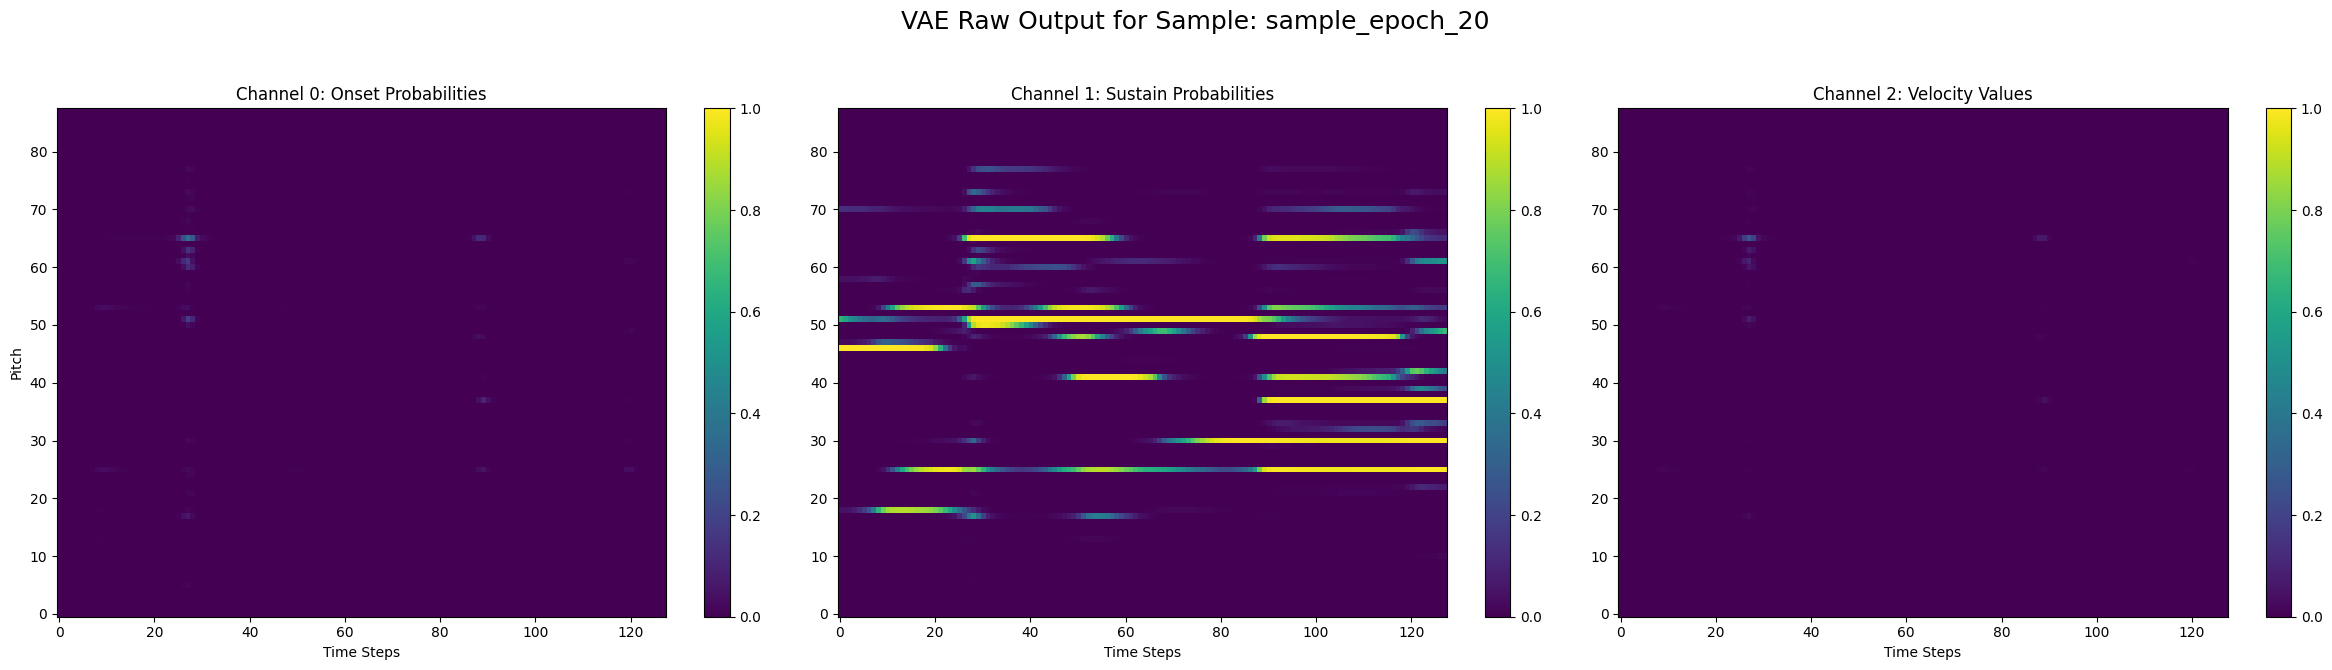

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_20.mid


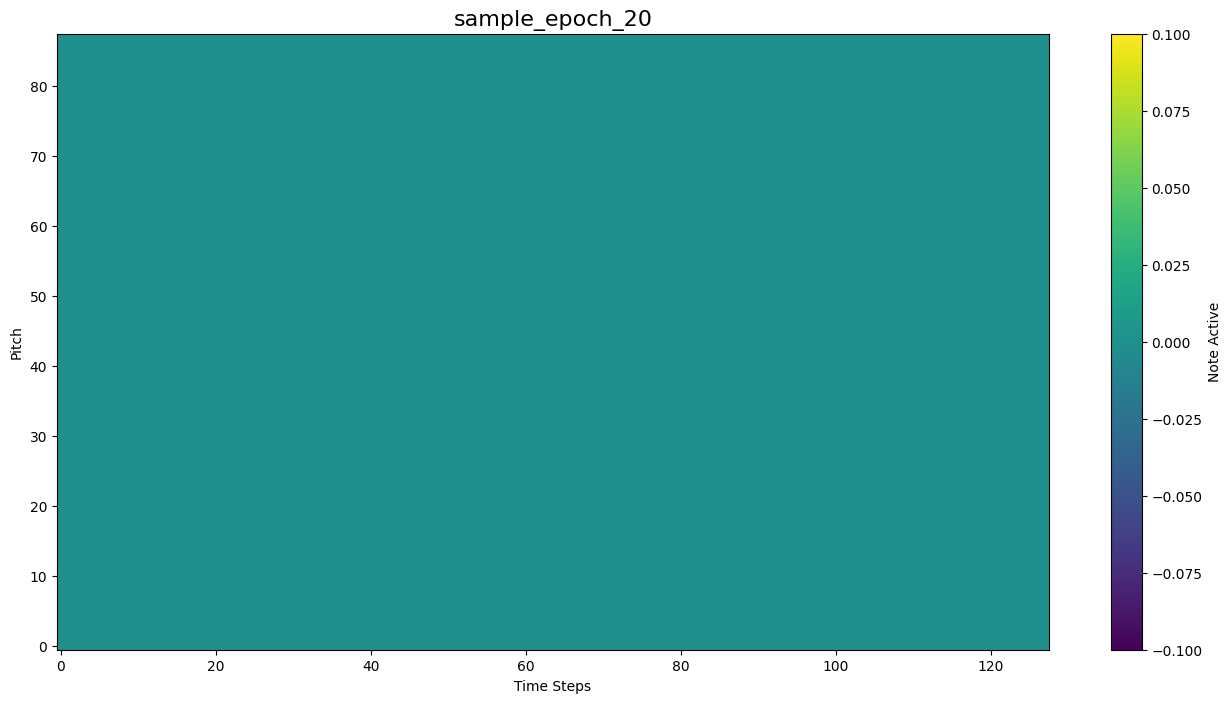

Model checkpoint saved to C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_20.pth


Epoch 21/100: 100%|██████████| 2815/2815 [11:15<00:00,  4.17it/s, beta=0.000, kld=33.74, recon=302.06, total_loss=302.06]


Epoch 21 Summary: Avg Loss: 263.35, Avg Recon: 263.35, Avg KLD: 27.49


Epoch 22/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=0.400, kld=20.61, recon=240.73, total_loss=248.97]


Epoch 22 Summary: Avg Loss: 263.59, Avg Recon: 255.35, Avg KLD: 20.62


Epoch 23/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=0.800, kld=18.33, recon=208.52, total_loss=223.18]


Epoch 23 Summary: Avg Loss: 262.65, Avg Recon: 248.47, Avg KLD: 17.72


Epoch 24/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=1.200, kld=17.42, recon=216.24, total_loss=237.14]


Epoch 24 Summary: Avg Loss: 262.37, Avg Recon: 242.98, Avg KLD: 16.16


Epoch 25/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=1.600, kld=17.03, recon=381.16, total_loss=408.41]


Epoch 25 Summary: Avg Loss: 261.88, Avg Recon: 237.80, Avg KLD: 15.05

--- Saving sample for epoch 25 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_25 ---


Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_25.mid


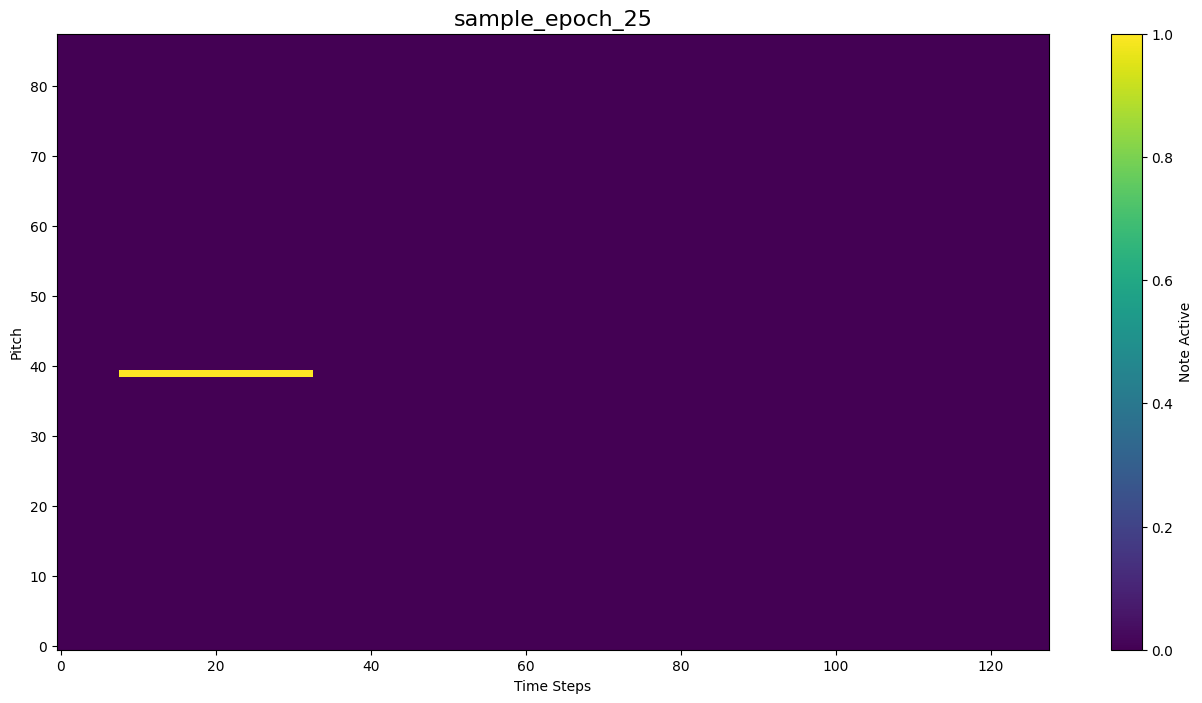

Epoch 26/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=2.000, kld=13.40, recon=202.74, total_loss=229.53]


Epoch 26 Summary: Avg Loss: 262.15, Avg Recon: 233.83, Avg KLD: 14.16


Epoch 27/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=2.400, kld=14.08, recon=216.99, total_loss=250.78]


Epoch 27 Summary: Avg Loss: 262.05, Avg Recon: 229.82, Avg KLD: 13.43


Epoch 28/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=2.800, kld=14.30, recon=286.15, total_loss=326.19]


Epoch 28 Summary: Avg Loss: 262.50, Avg Recon: 226.69, Avg KLD: 12.79


Epoch 29/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=3.200, kld=12.81, recon=209.41, total_loss=250.40]


Epoch 29 Summary: Avg Loss: 262.33, Avg Recon: 223.05, Avg KLD: 12.27


Epoch 30/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.27it/s, beta=3.600, kld=11.50, recon=184.12, total_loss=225.52]


Epoch 30 Summary: Avg Loss: 262.53, Avg Recon: 220.05, Avg KLD: 11.80

--- Saving sample for epoch 30 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_30 ---


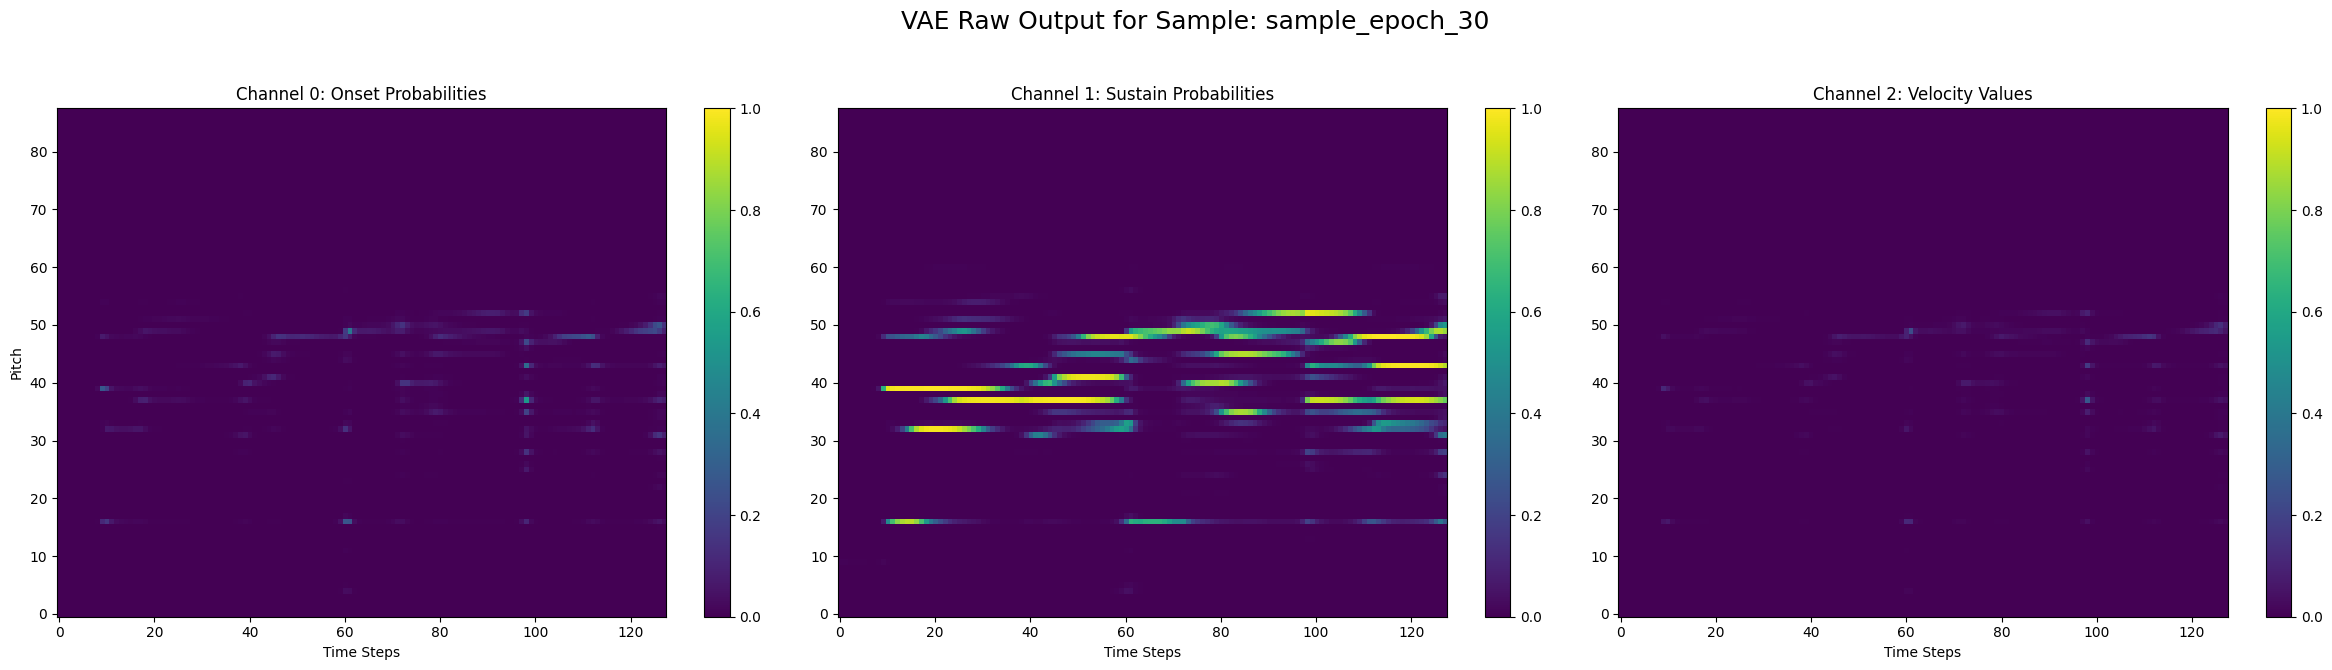

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_30.mid


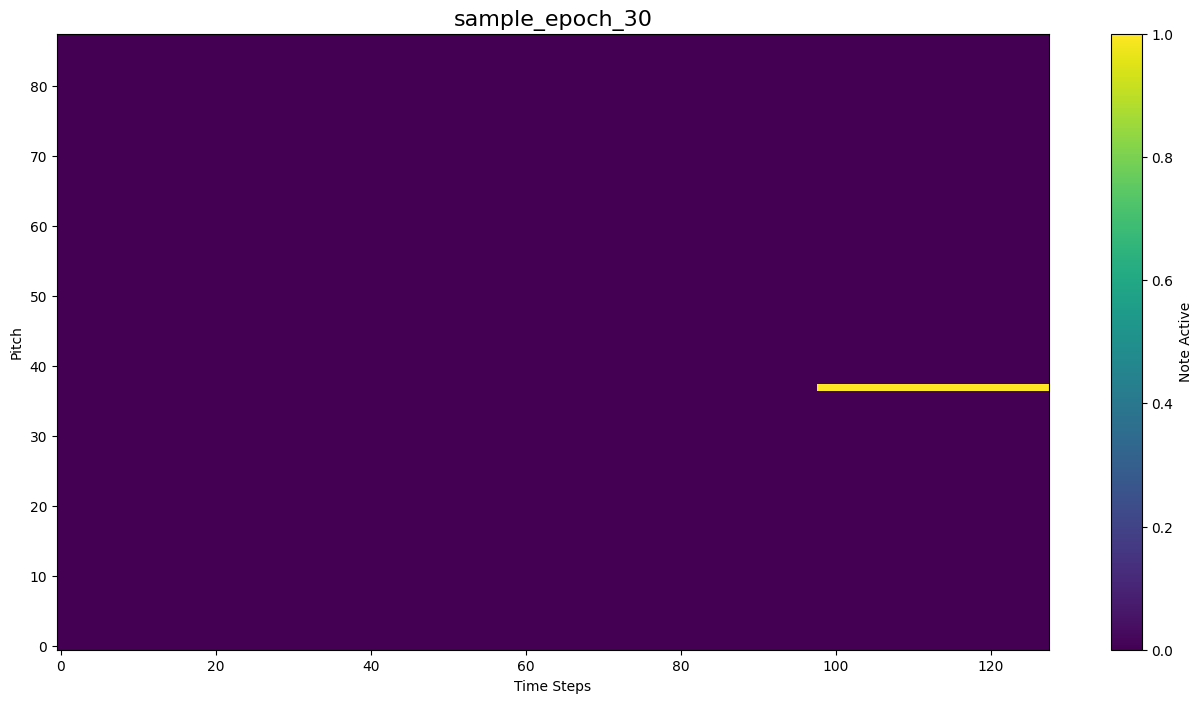

Epoch 31/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=4.000, kld=11.88, recon=227.32, total_loss=274.82]


Epoch 31 Summary: Avg Loss: 262.87, Avg Recon: 217.32, Avg KLD: 11.39


Epoch 32/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.27it/s, beta=3.600, kld=12.46, recon=180.96, total_loss=225.81]


Epoch 32 Summary: Avg Loss: 253.49, Avg Recon: 211.82, Avg KLD: 11.57


Epoch 33/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=3.200, kld=12.20, recon=166.16, total_loss=205.20]


Epoch 33 Summary: Avg Loss: 244.87, Avg Recon: 206.91, Avg KLD: 11.86


Epoch 34/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=2.800, kld=13.56, recon=224.77, total_loss=262.75]


Epoch 34 Summary: Avg Loss: 236.35, Avg Recon: 202.09, Avg KLD: 12.23


Epoch 35/100: 100%|██████████| 2815/2815 [11:05<00:00,  4.23it/s, beta=2.400, kld=13.89, recon=200.95, total_loss=234.29]


Epoch 35 Summary: Avg Loss: 227.23, Avg Recon: 196.84, Avg KLD: 12.66

--- Saving sample for epoch 35 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_35 ---


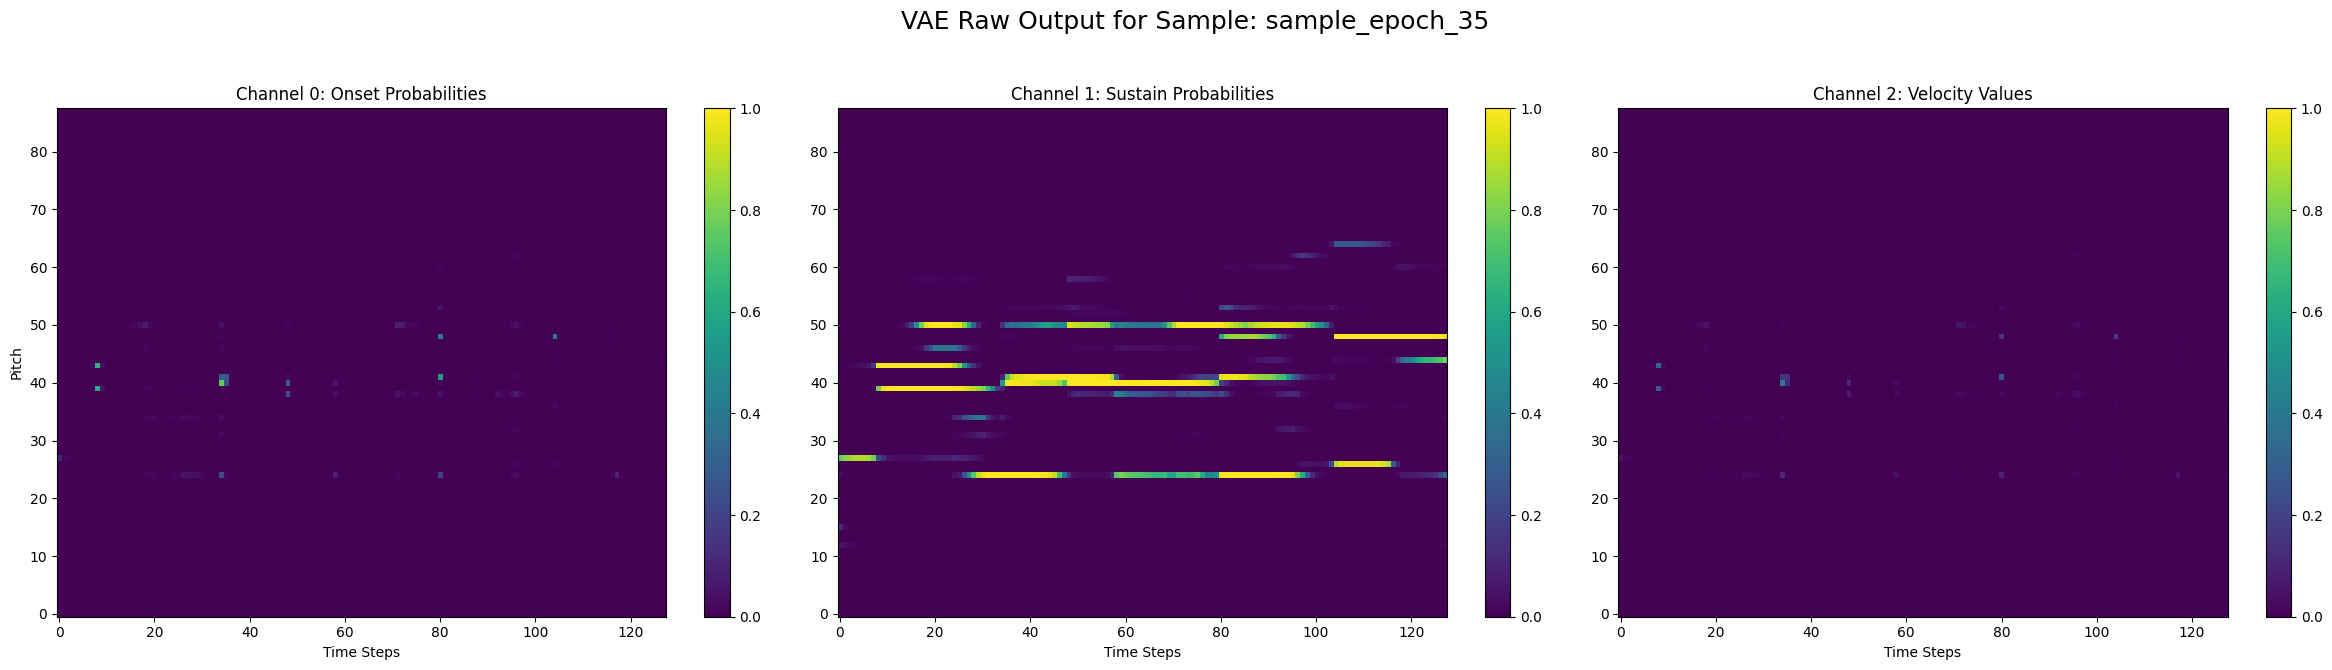

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_35.mid


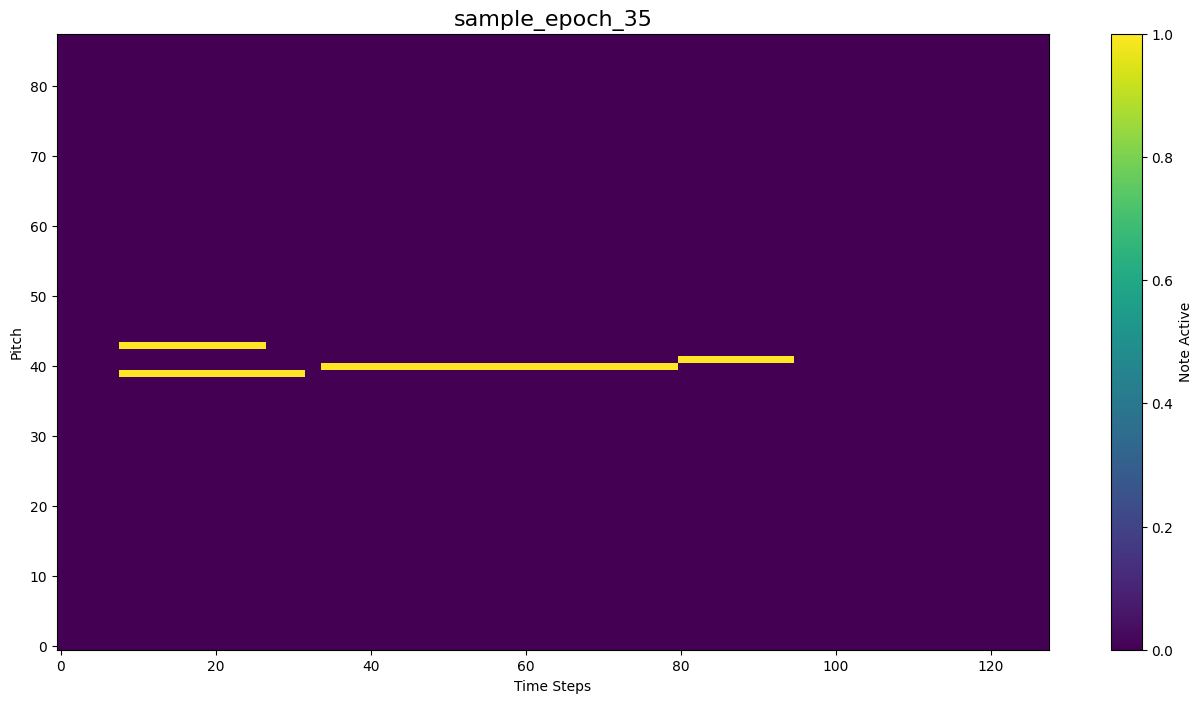

Epoch 36/100: 100%|██████████| 2815/2815 [11:07<00:00,  4.22it/s, beta=2.000, kld=15.00, recon=214.64, total_loss=244.63]


Epoch 36 Summary: Avg Loss: 218.55, Avg Recon: 192.19, Avg KLD: 13.18


Epoch 37/100: 100%|██████████| 2815/2815 [11:19<00:00,  4.14it/s, beta=1.600, kld=14.72, recon=198.06, total_loss=221.62]


Epoch 37 Summary: Avg Loss: 209.65, Avg Recon: 187.48, Avg KLD: 13.86


Epoch 38/100: 100%|██████████| 2815/2815 [11:16<00:00,  4.16it/s, beta=1.200, kld=16.21, recon=180.52, total_loss=199.97]


Epoch 38 Summary: Avg Loss: 200.50, Avg Recon: 182.79, Avg KLD: 14.76


Epoch 39/100: 100%|██████████| 2815/2815 [11:15<00:00,  4.17it/s, beta=0.800, kld=18.47, recon=259.97, total_loss=274.75]


Epoch 39 Summary: Avg Loss: 191.34, Avg Recon: 178.48, Avg KLD: 16.08


Epoch 40/100: 100%|██████████| 2815/2815 [11:15<00:00,  4.17it/s, beta=0.400, kld=18.67, recon=123.32, total_loss=130.79]


Epoch 40 Summary: Avg Loss: 181.04, Avg Recon: 173.68, Avg KLD: 18.41

--- Saving sample for epoch 40 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_40 ---


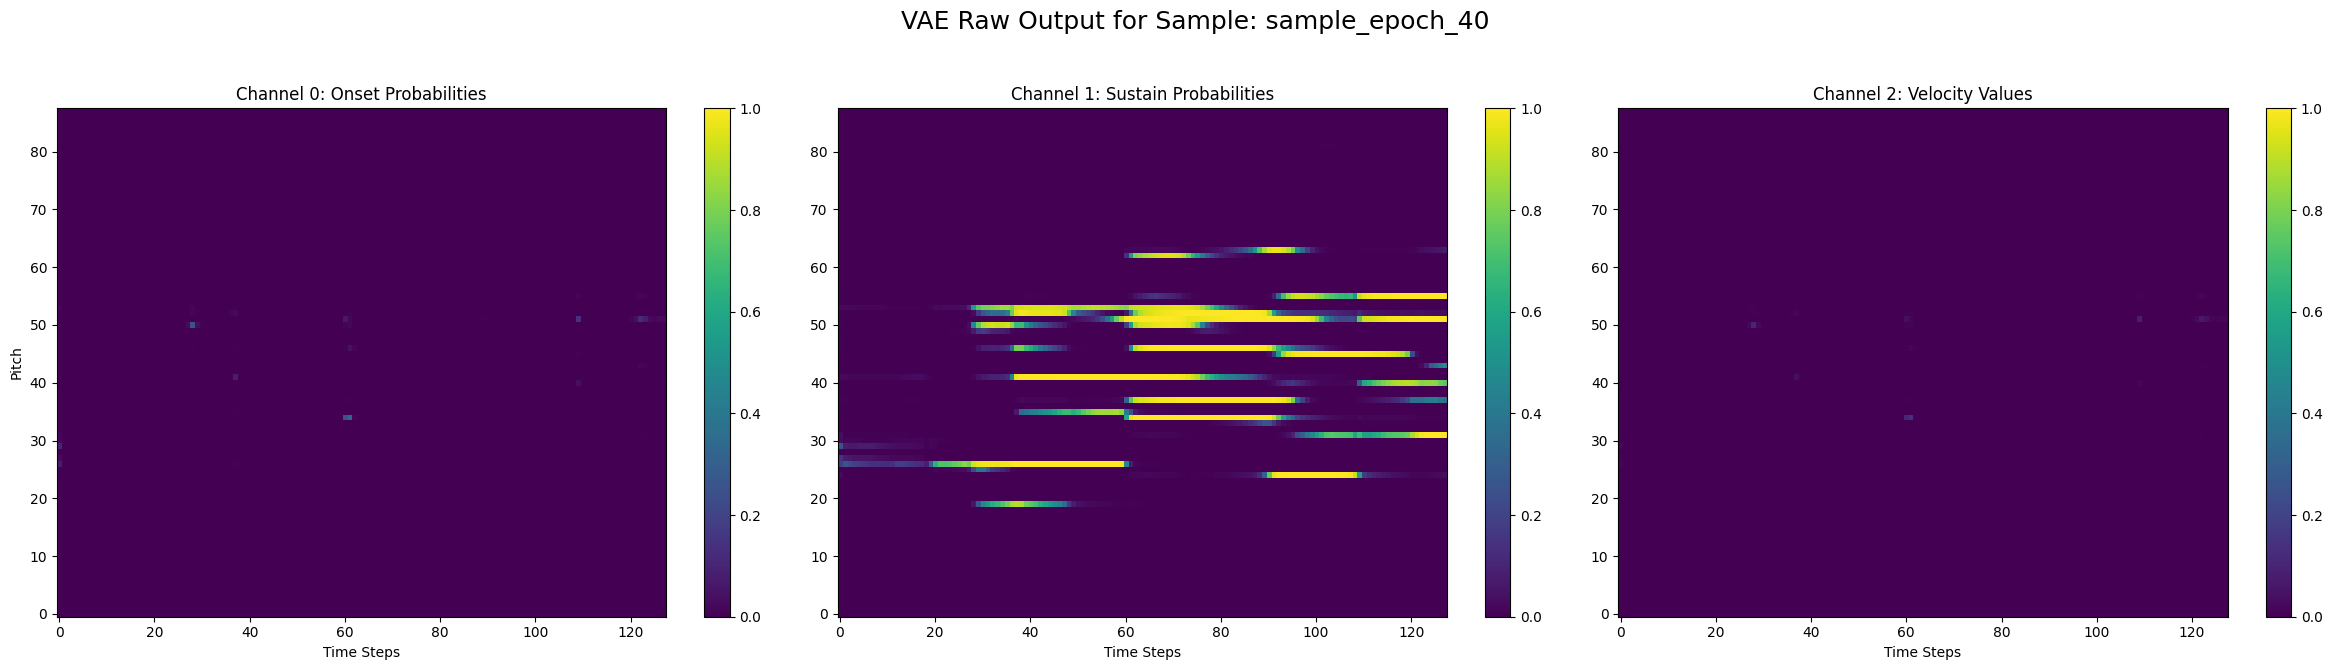

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_40.mid


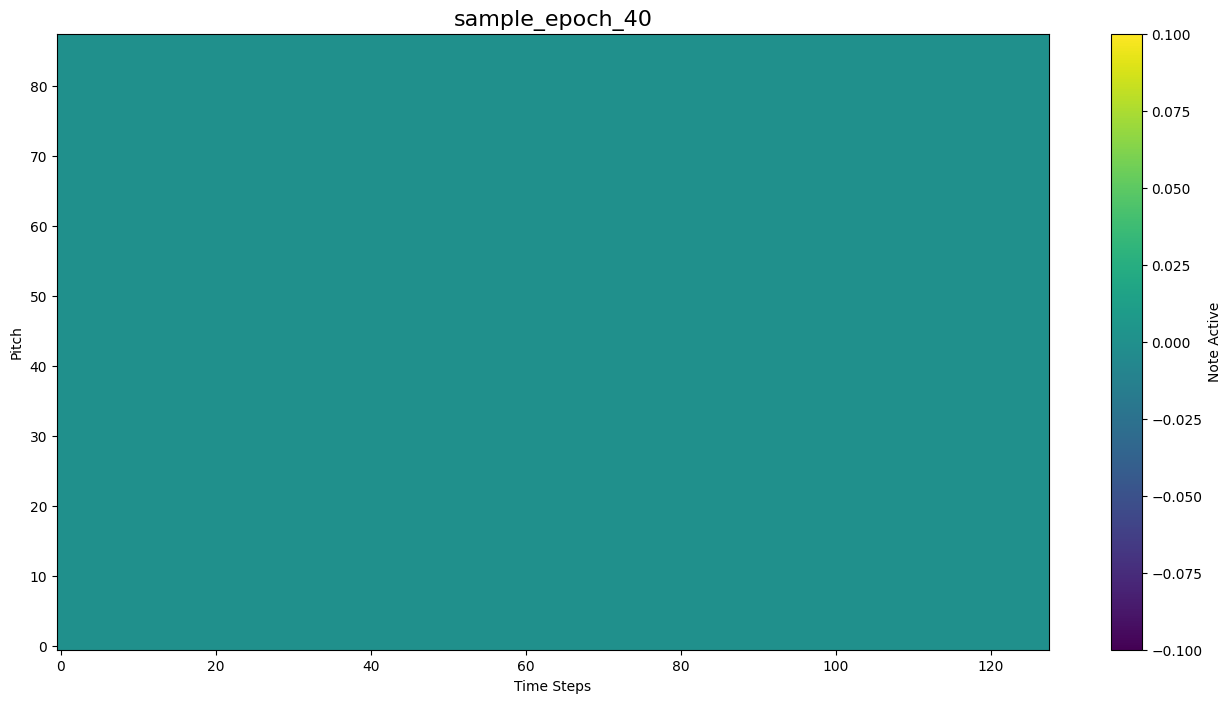

Model checkpoint saved to C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_40.pth


Epoch 41/100: 100%|██████████| 2815/2815 [11:04<00:00,  4.24it/s, beta=0.000, kld=31.66, recon=150.98, total_loss=150.98]


Epoch 41 Summary: Avg Loss: 169.51, Avg Recon: 169.51, Avg KLD: 26.52


Epoch 42/100: 100%|██████████| 2815/2815 [11:04<00:00,  4.24it/s, beta=0.400, kld=21.03, recon=186.52, total_loss=194.93]


Epoch 42 Summary: Avg Loss: 176.10, Avg Recon: 168.32, Avg KLD: 19.45


Epoch 43/100: 100%|██████████| 2815/2815 [11:02<00:00,  4.25it/s, beta=0.800, kld=18.44, recon=186.79, total_loss=201.54]


Epoch 43 Summary: Avg Loss: 180.89, Avg Recon: 167.49, Avg KLD: 16.75


Epoch 44/100: 100%|██████████| 2815/2815 [11:24<00:00,  4.11it/s, beta=1.200, kld=17.32, recon=213.77, total_loss=234.55]


Epoch 44 Summary: Avg Loss: 185.20, Avg Recon: 166.83, Avg KLD: 15.31


Epoch 45/100: 100%|██████████| 2815/2815 [11:20<00:00,  4.13it/s, beta=1.600, kld=15.48, recon=160.49, total_loss=185.26]


Epoch 45 Summary: Avg Loss: 189.15, Avg Recon: 166.26, Avg KLD: 14.30

--- Saving sample for epoch 45 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_45 ---


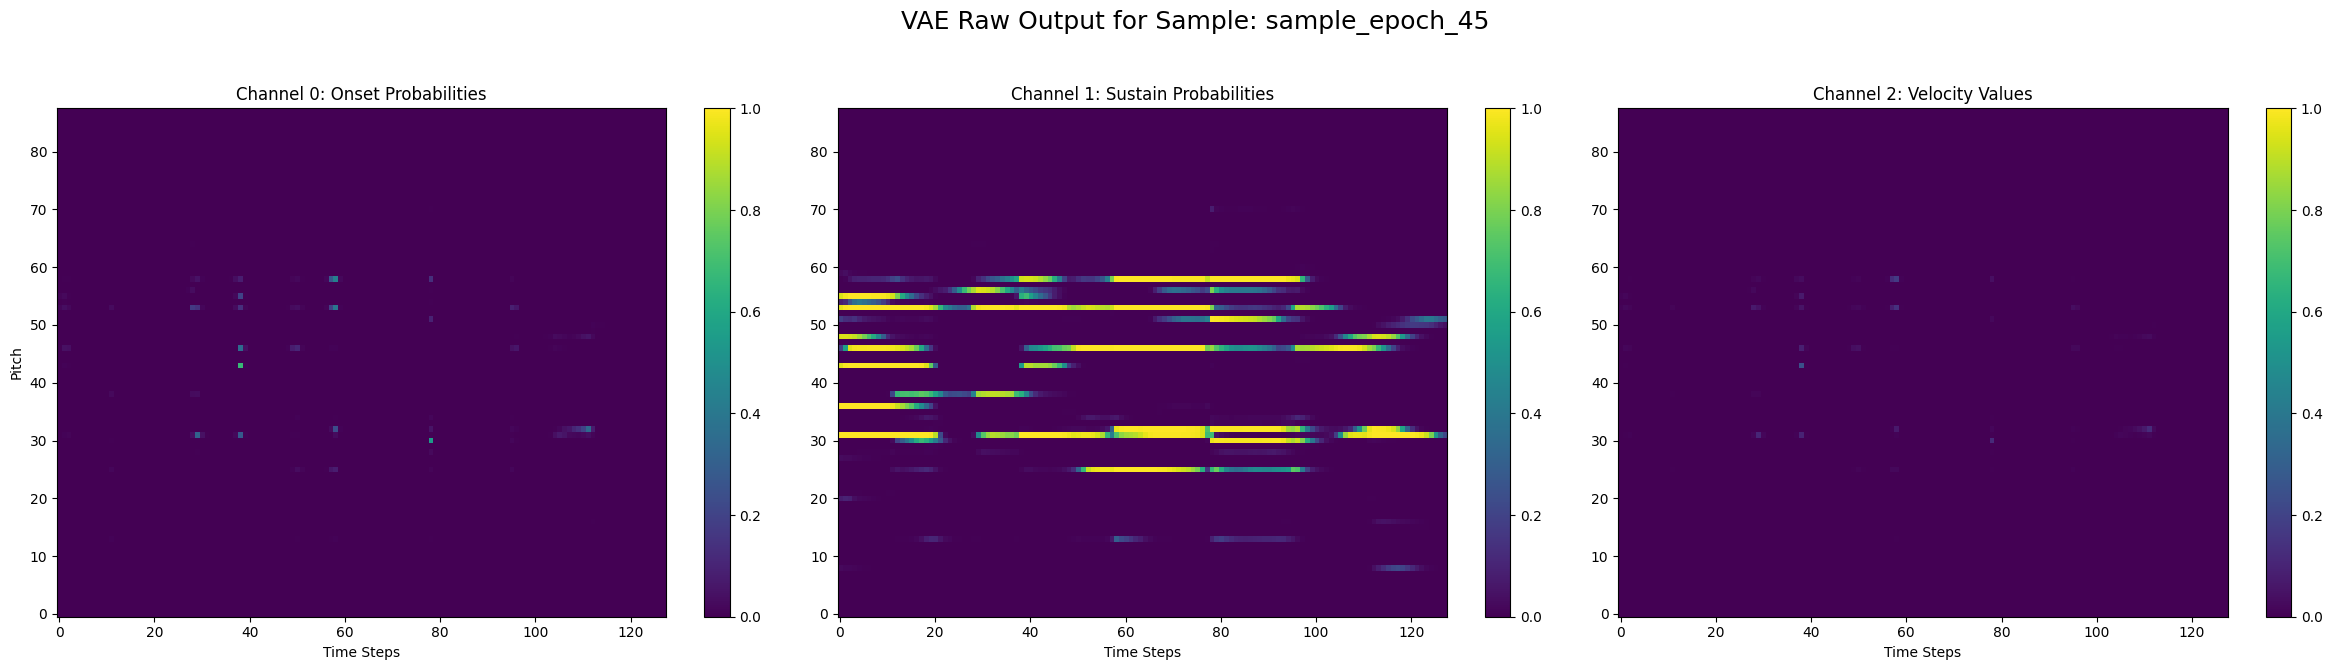

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_45.mid


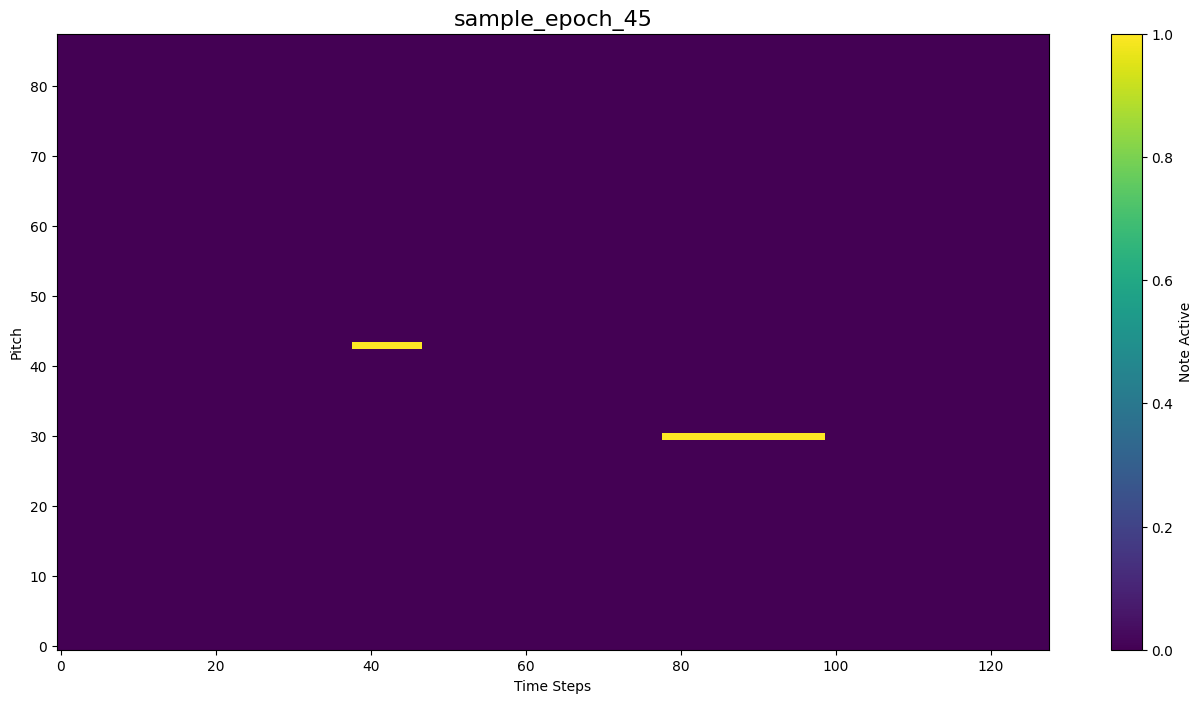

Epoch 46/100: 100%|██████████| 2815/2815 [11:37<00:00,  4.04it/s, beta=2.000, kld=14.29, recon=128.12, total_loss=156.71]


Epoch 46 Summary: Avg Loss: 192.57, Avg Recon: 165.49, Avg KLD: 13.54


Epoch 47/100: 100%|██████████| 2815/2815 [11:08<00:00,  4.21it/s, beta=2.400, kld=13.04, recon=161.25, total_loss=192.54]


Epoch 47 Summary: Avg Loss: 196.01, Avg Recon: 165.00, Avg KLD: 12.92


Epoch 48/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=2.800, kld=12.87, recon=163.48, total_loss=199.51]


Epoch 48 Summary: Avg Loss: 199.17, Avg Recon: 164.51, Avg KLD: 12.38


Epoch 49/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=3.200, kld=12.32, recon=162.66, total_loss=202.09]


Epoch 49 Summary: Avg Loss: 202.65, Avg Recon: 164.35, Avg KLD: 11.97


Epoch 50/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=3.600, kld=11.31, recon=113.33, total_loss=154.04]


Epoch 50 Summary: Avg Loss: 205.66, Avg Recon: 164.02, Avg KLD: 11.57

--- Saving sample for epoch 50 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_50 ---


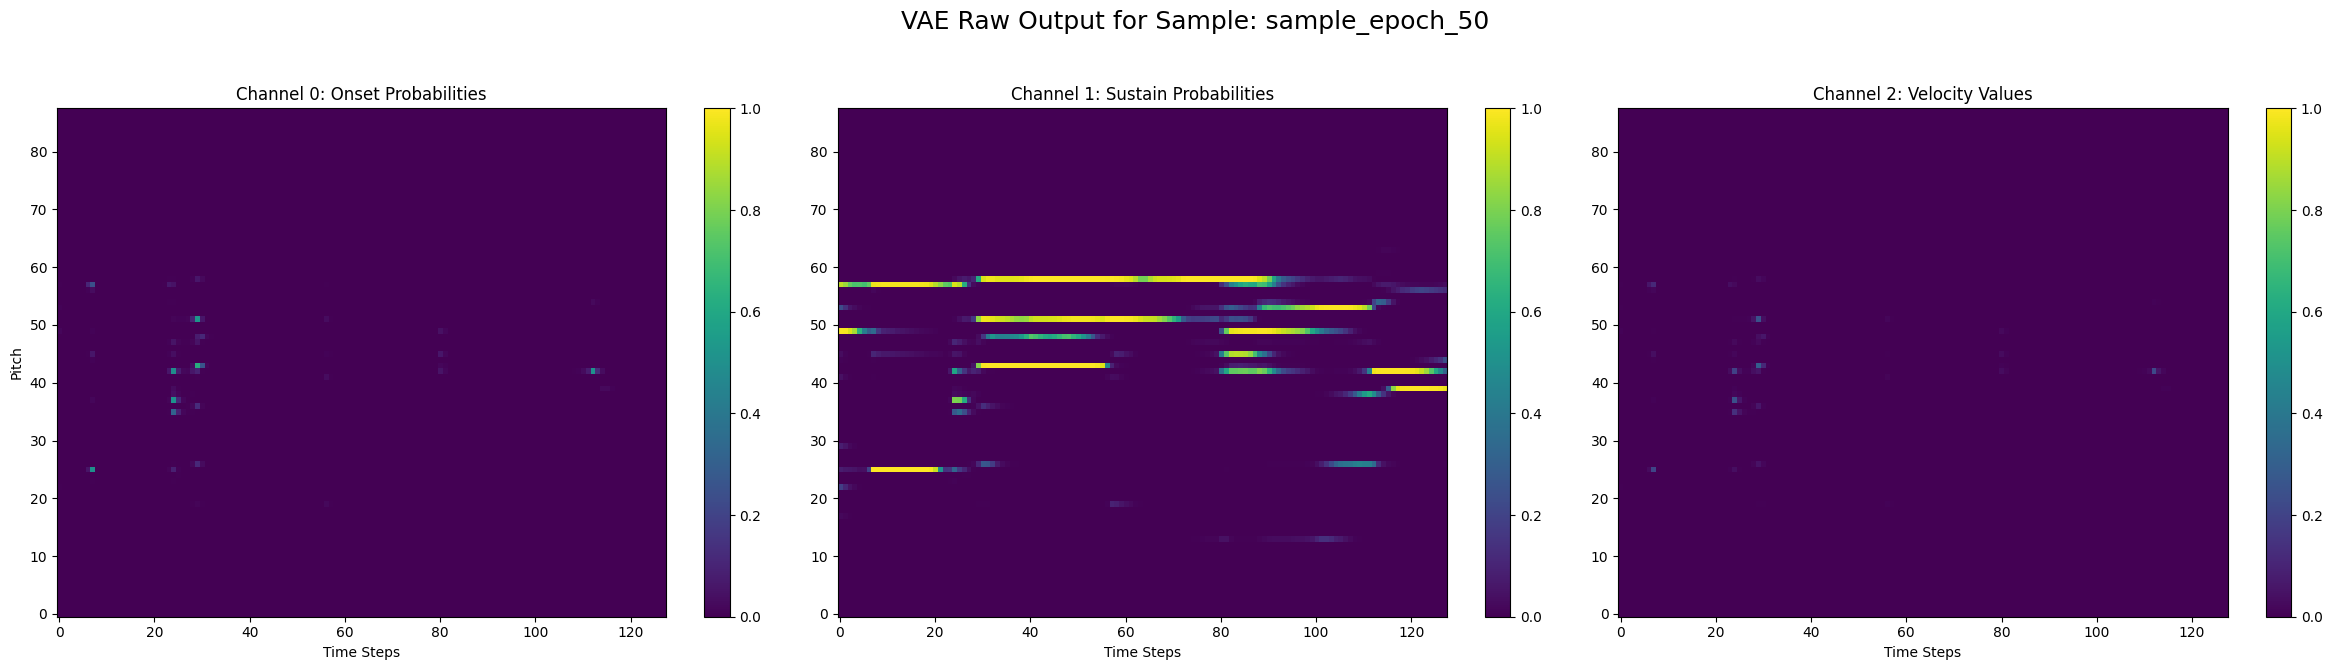

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_50.mid


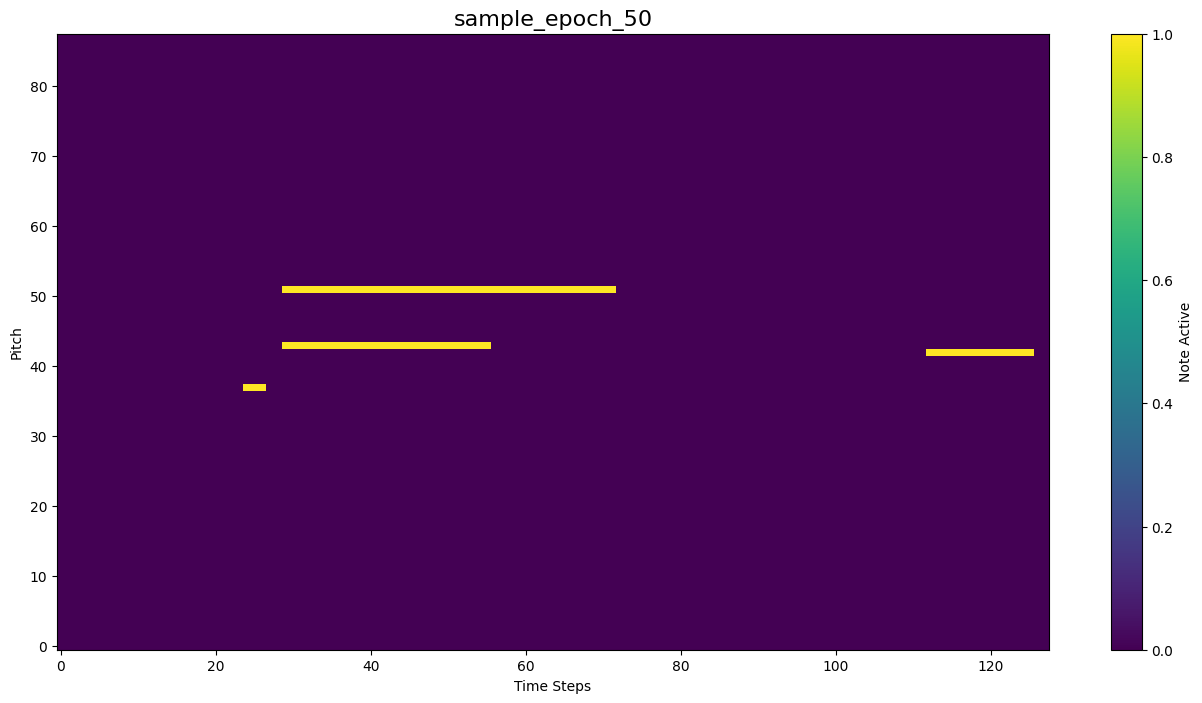

Epoch 51/100: 100%|██████████| 2815/2815 [11:07<00:00,  4.22it/s, beta=4.000, kld=11.47, recon=166.56, total_loss=212.43]


Epoch 51 Summary: Avg Loss: 208.55, Avg Recon: 163.64, Avg KLD: 11.23


Epoch 52/100: 100%|██████████| 2815/2815 [11:11<00:00,  4.19it/s, beta=3.600, kld=12.41, recon=174.10, total_loss=218.79]


Epoch 52 Summary: Avg Loss: 201.57, Avg Recon: 160.39, Avg KLD: 11.44


Epoch 53/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=3.200, kld=13.32, recon=183.06, total_loss=225.67]


Epoch 53 Summary: Avg Loss: 195.04, Avg Recon: 157.52, Avg KLD: 11.72


Epoch 54/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=2.800, kld=12.88, recon=144.86, total_loss=180.93]


Epoch 54 Summary: Avg Loss: 188.55, Avg Recon: 154.76, Avg KLD: 12.07


Epoch 55/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=2.400, kld=13.63, recon=147.78, total_loss=180.48]


Epoch 55 Summary: Avg Loss: 181.64, Avg Recon: 151.71, Avg KLD: 12.47

--- Saving sample for epoch 55 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_55 ---


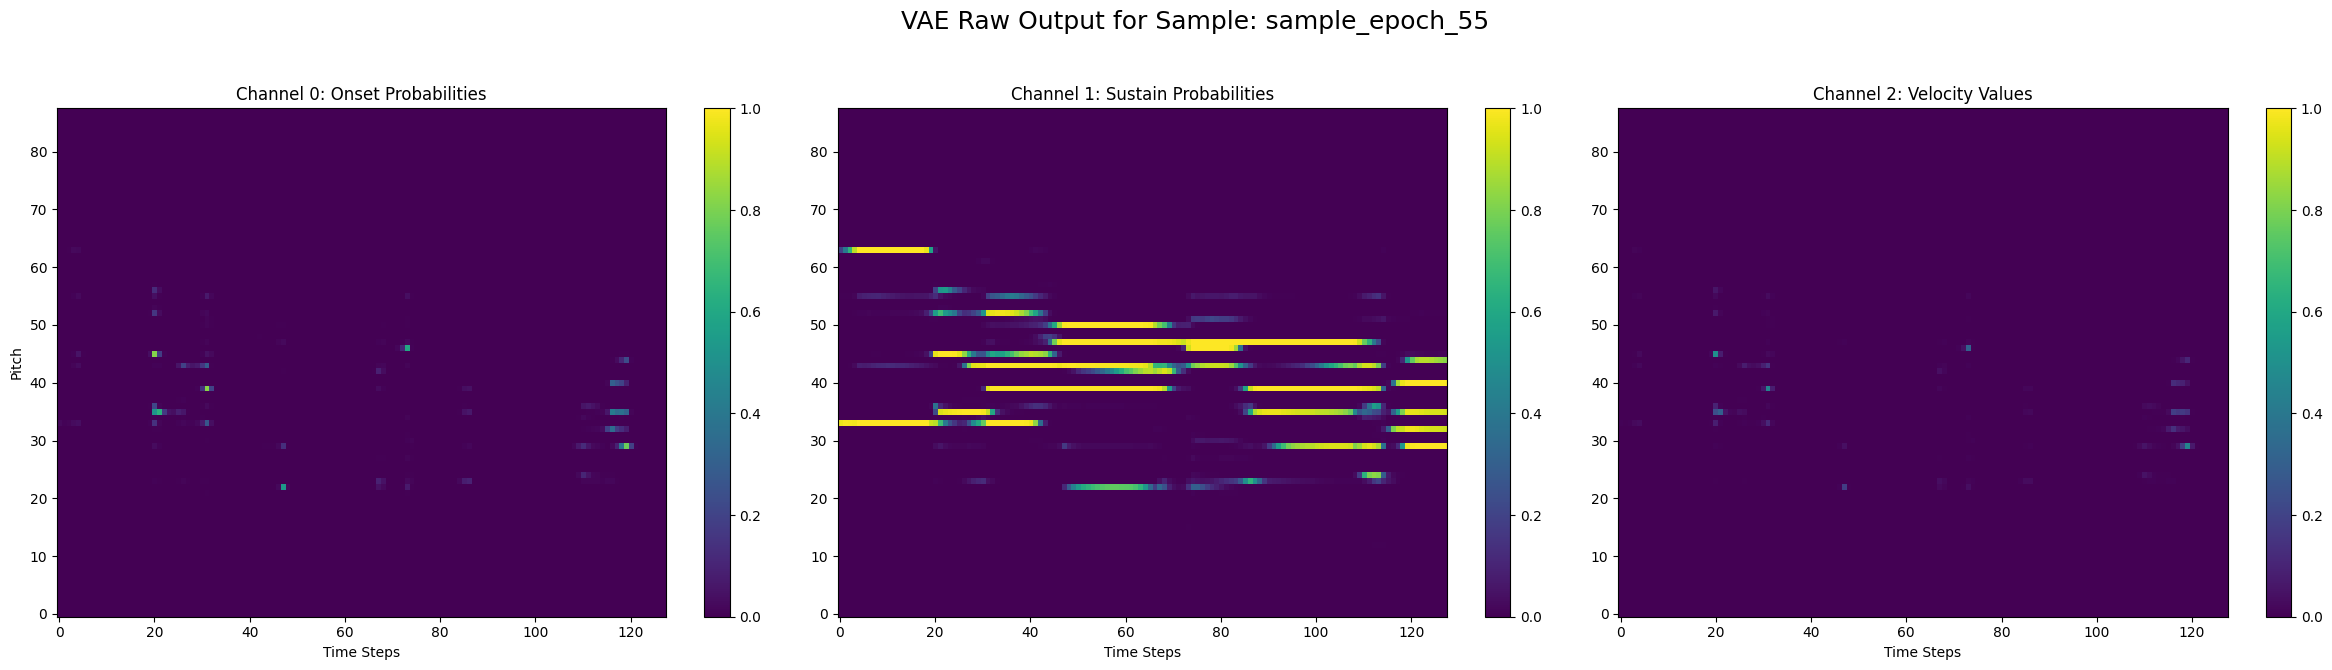

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_55.mid


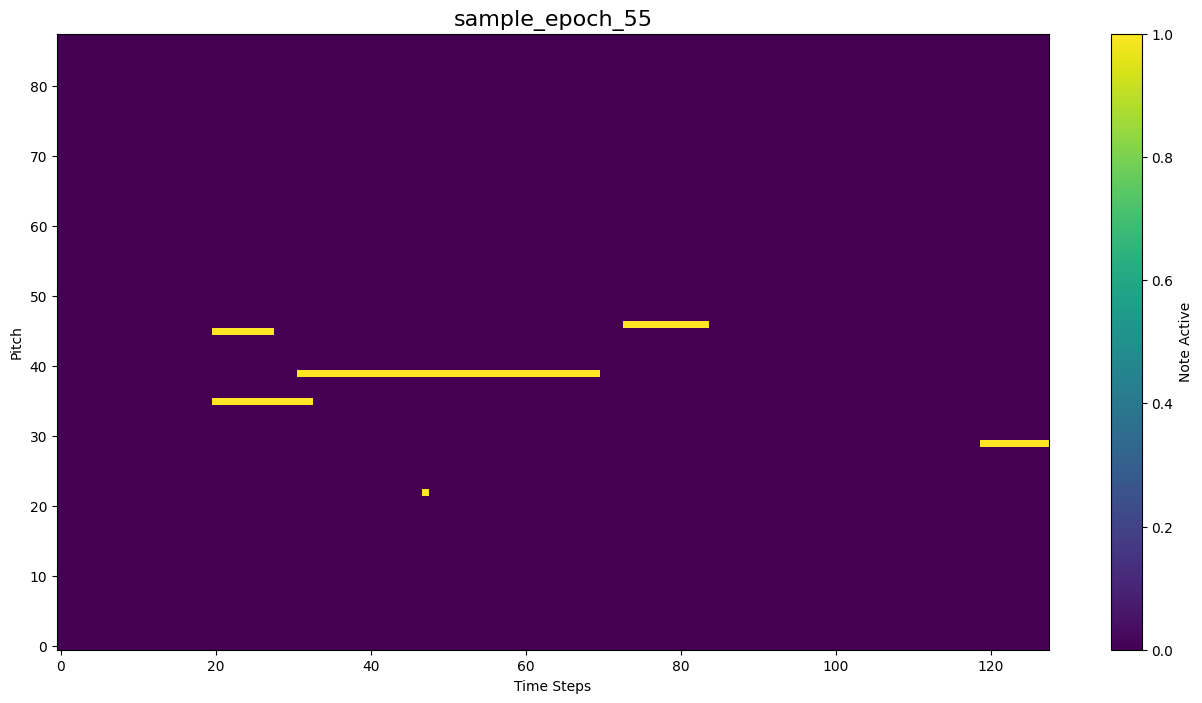

Epoch 56/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=2.000, kld=14.16, recon=166.96, total_loss=195.28]


Epoch 56 Summary: Avg Loss: 175.03, Avg Recon: 149.02, Avg KLD: 13.00


Epoch 57/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=1.600, kld=16.25, recon=198.51, total_loss=224.51]


Epoch 57 Summary: Avg Loss: 167.97, Avg Recon: 146.16, Avg KLD: 13.63


Epoch 58/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=1.200, kld=15.99, recon=157.16, total_loss=176.35]


Epoch 58 Summary: Avg Loss: 160.51, Avg Recon: 143.15, Avg KLD: 14.47


Epoch 59/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=0.800, kld=17.74, recon=125.15, total_loss=139.34]


Epoch 59 Summary: Avg Loss: 152.99, Avg Recon: 140.41, Avg KLD: 15.72


Epoch 60/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=0.400, kld=19.48, recon=115.14, total_loss=122.93]


Epoch 60 Summary: Avg Loss: 144.35, Avg Recon: 137.19, Avg KLD: 17.89

--- Saving sample for epoch 60 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_60 ---


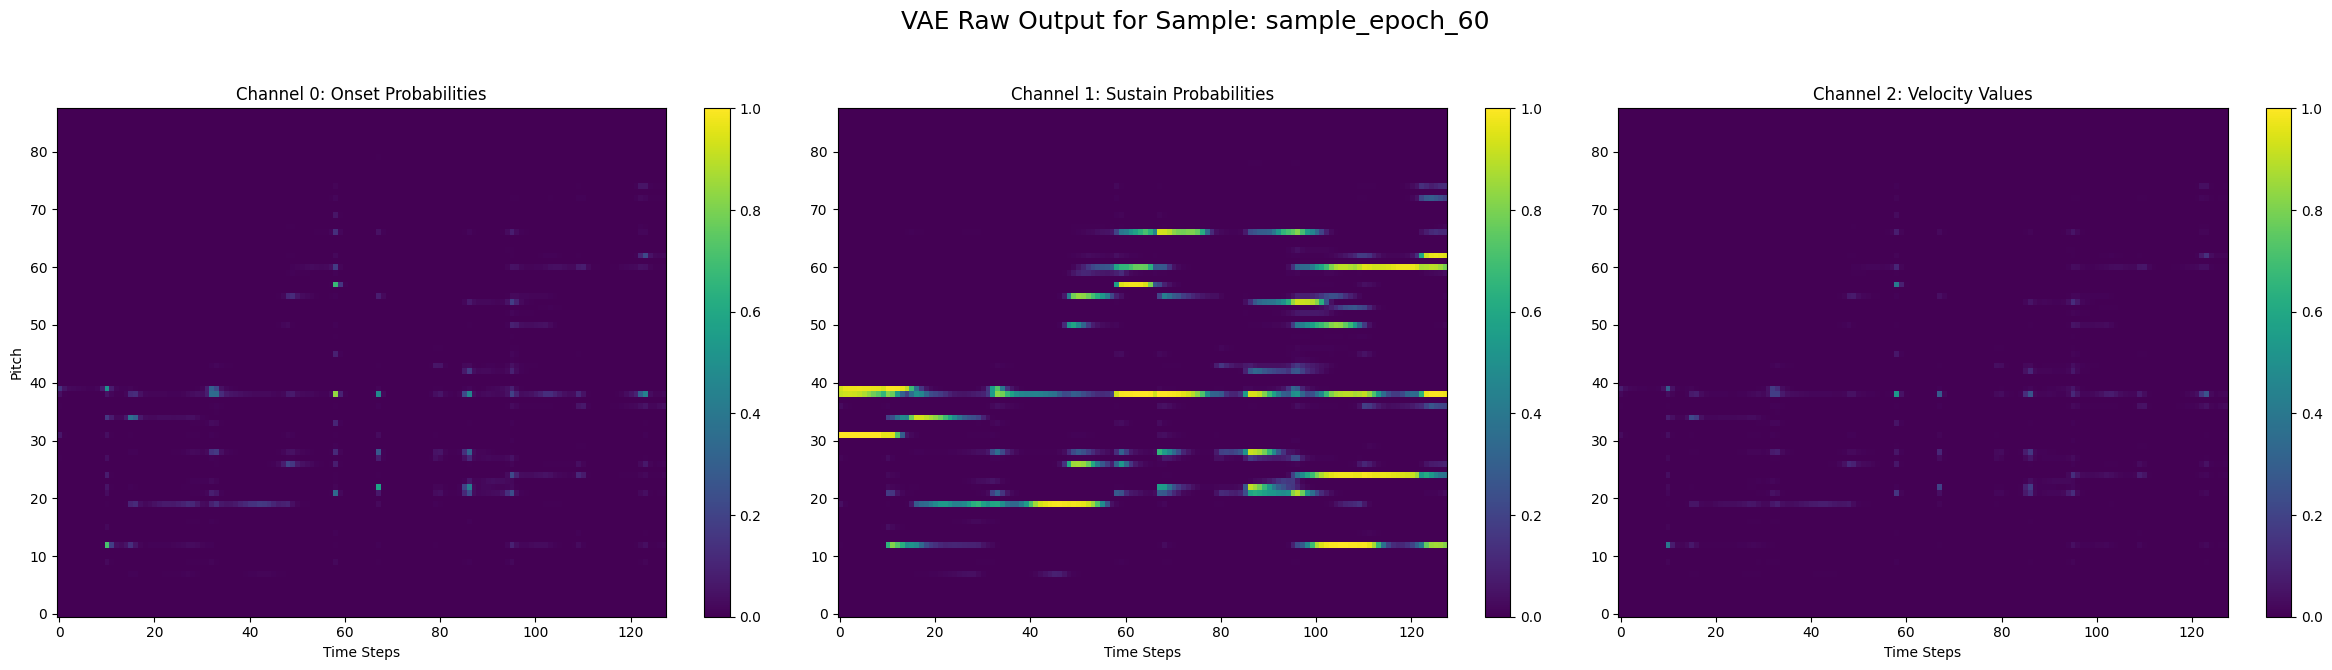

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_60.mid


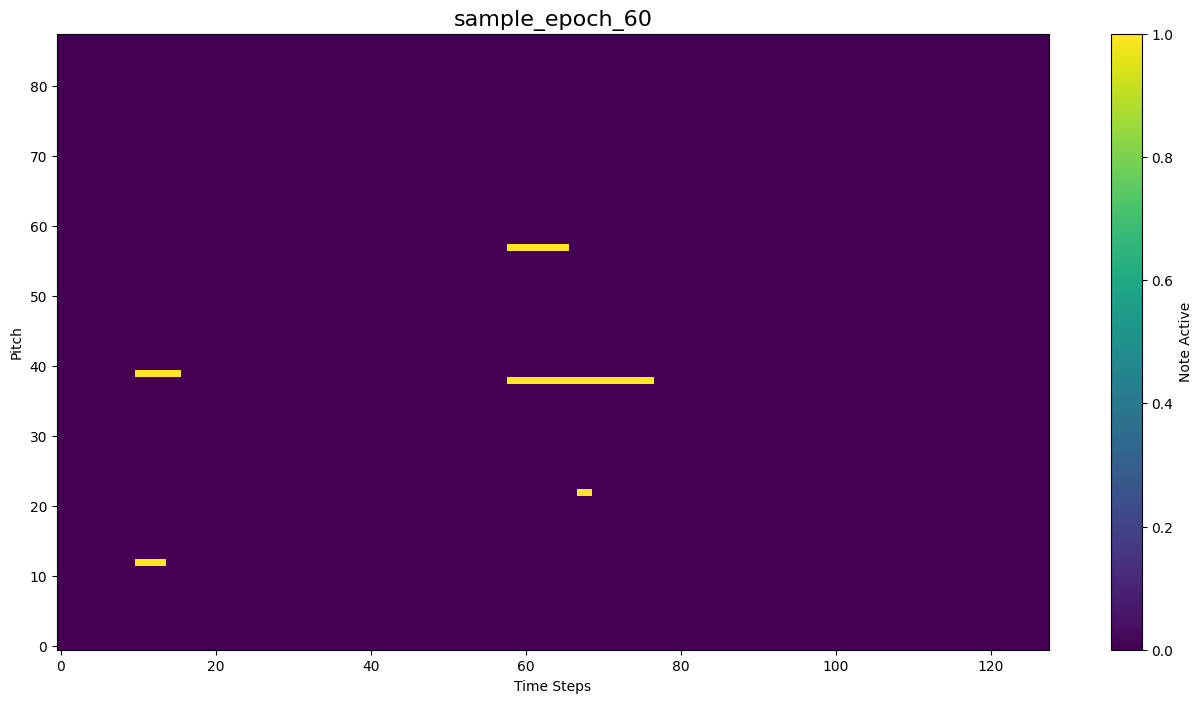

Model checkpoint saved to C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_60.pth


Epoch 61/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=0.000, kld=29.73, recon=131.30, total_loss=131.30]


Epoch 61 Summary: Avg Loss: 134.35, Avg Recon: 134.35, Avg KLD: 25.64


Epoch 62/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=0.400, kld=20.08, recon=111.86, total_loss=119.89]


Epoch 62 Summary: Avg Loss: 142.20, Avg Recon: 134.66, Avg KLD: 18.85


Epoch 63/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=0.800, kld=16.72, recon=178.70, total_loss=192.08]


Epoch 63 Summary: Avg Loss: 148.12, Avg Recon: 135.09, Avg KLD: 16.29


Epoch 64/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=1.200, kld=15.64, recon=144.21, total_loss=162.98]


Epoch 64 Summary: Avg Loss: 153.41, Avg Recon: 135.46, Avg KLD: 14.96


Epoch 65/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=1.600, kld=14.78, recon=134.25, total_loss=157.90]


Epoch 65 Summary: Avg Loss: 157.85, Avg Recon: 135.46, Avg KLD: 13.99

--- Saving sample for epoch 65 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_65 ---


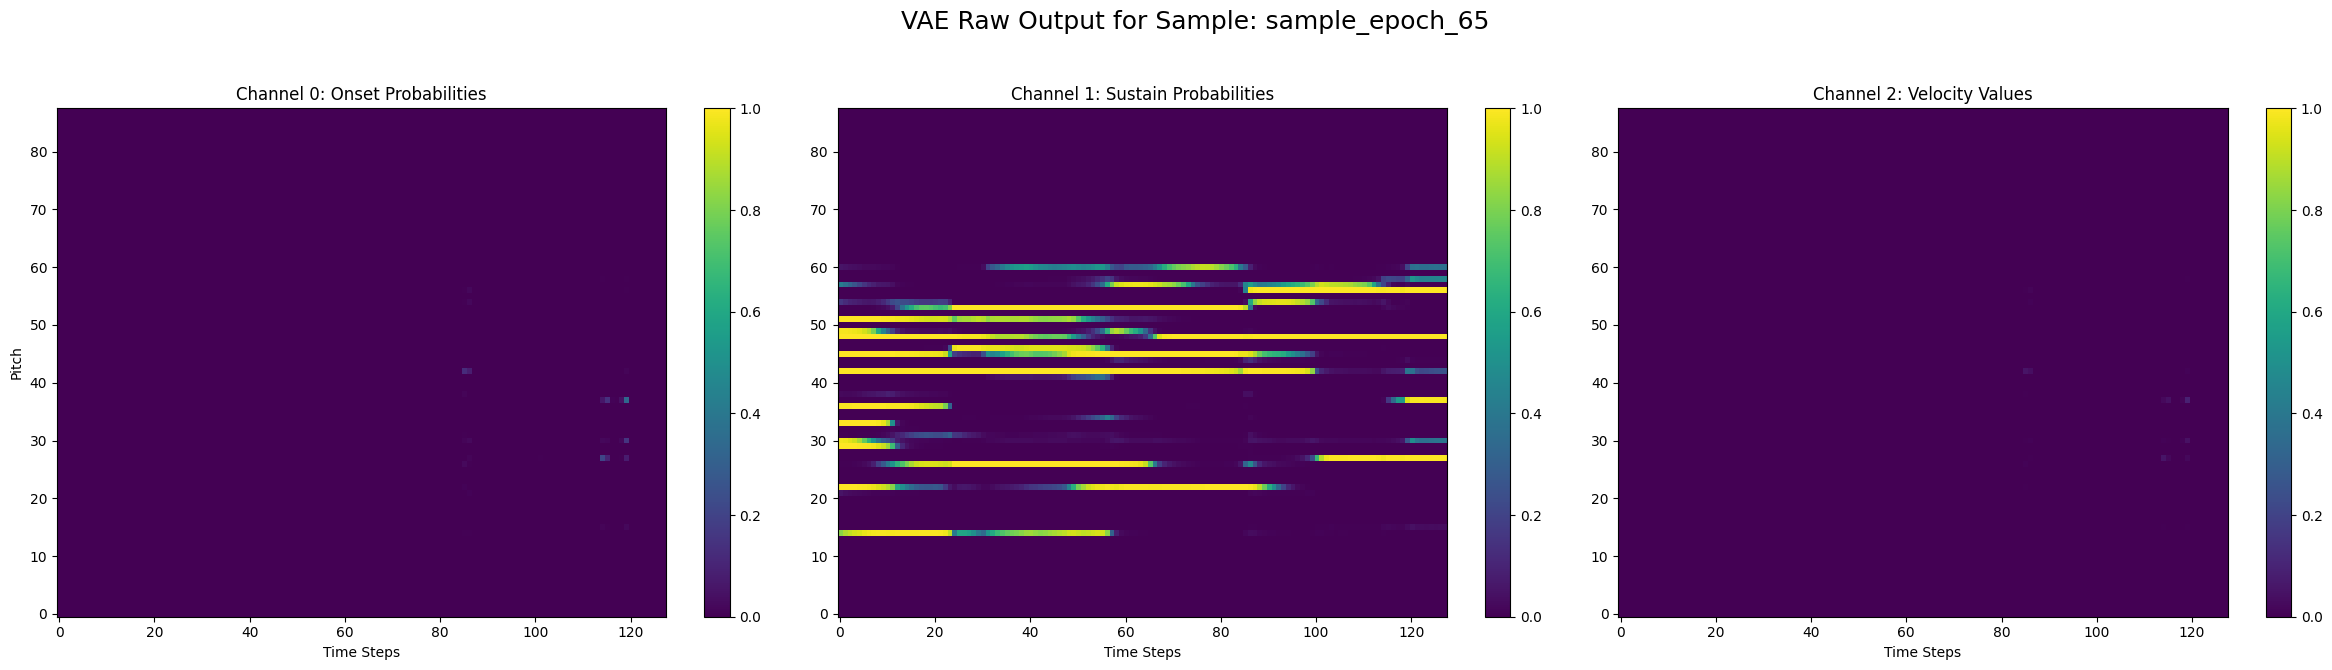

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_65.mid


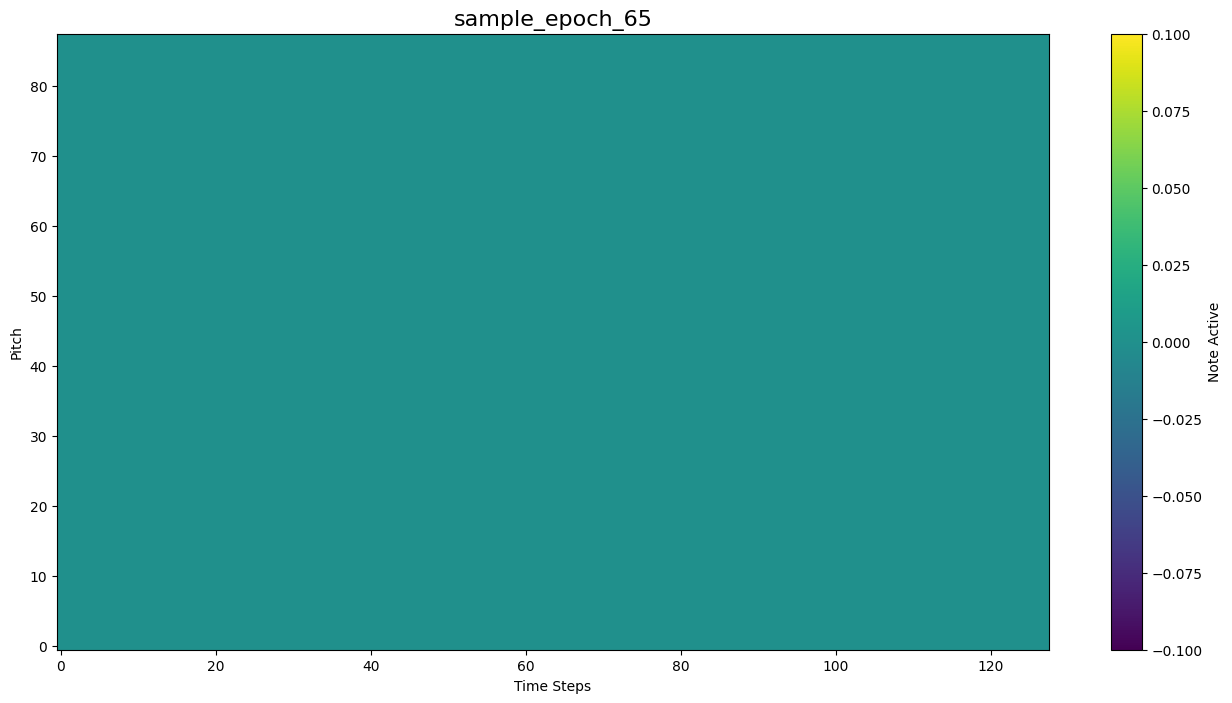

Epoch 66/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=2.000, kld=14.36, recon=141.89, total_loss=170.61]


Epoch 66 Summary: Avg Loss: 162.80, Avg Recon: 136.23, Avg KLD: 13.28


Epoch 67/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.400, kld=13.87, recon=154.09, total_loss=187.38]


Epoch 67 Summary: Avg Loss: 166.87, Avg Recon: 136.39, Avg KLD: 12.70


Epoch 68/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.800, kld=12.22, recon=121.74, total_loss=155.97]


Epoch 68 Summary: Avg Loss: 171.13, Avg Recon: 136.89, Avg KLD: 12.23


Epoch 69/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=3.200, kld=11.92, recon=157.16, total_loss=195.30]


Epoch 69 Summary: Avg Loss: 174.90, Avg Recon: 137.11, Avg KLD: 11.81


Epoch 70/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=3.600, kld=12.43, recon=127.95, total_loss=172.70]


Epoch 70 Summary: Avg Loss: 178.79, Avg Recon: 137.53, Avg KLD: 11.46

--- Saving sample for epoch 70 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_70 ---


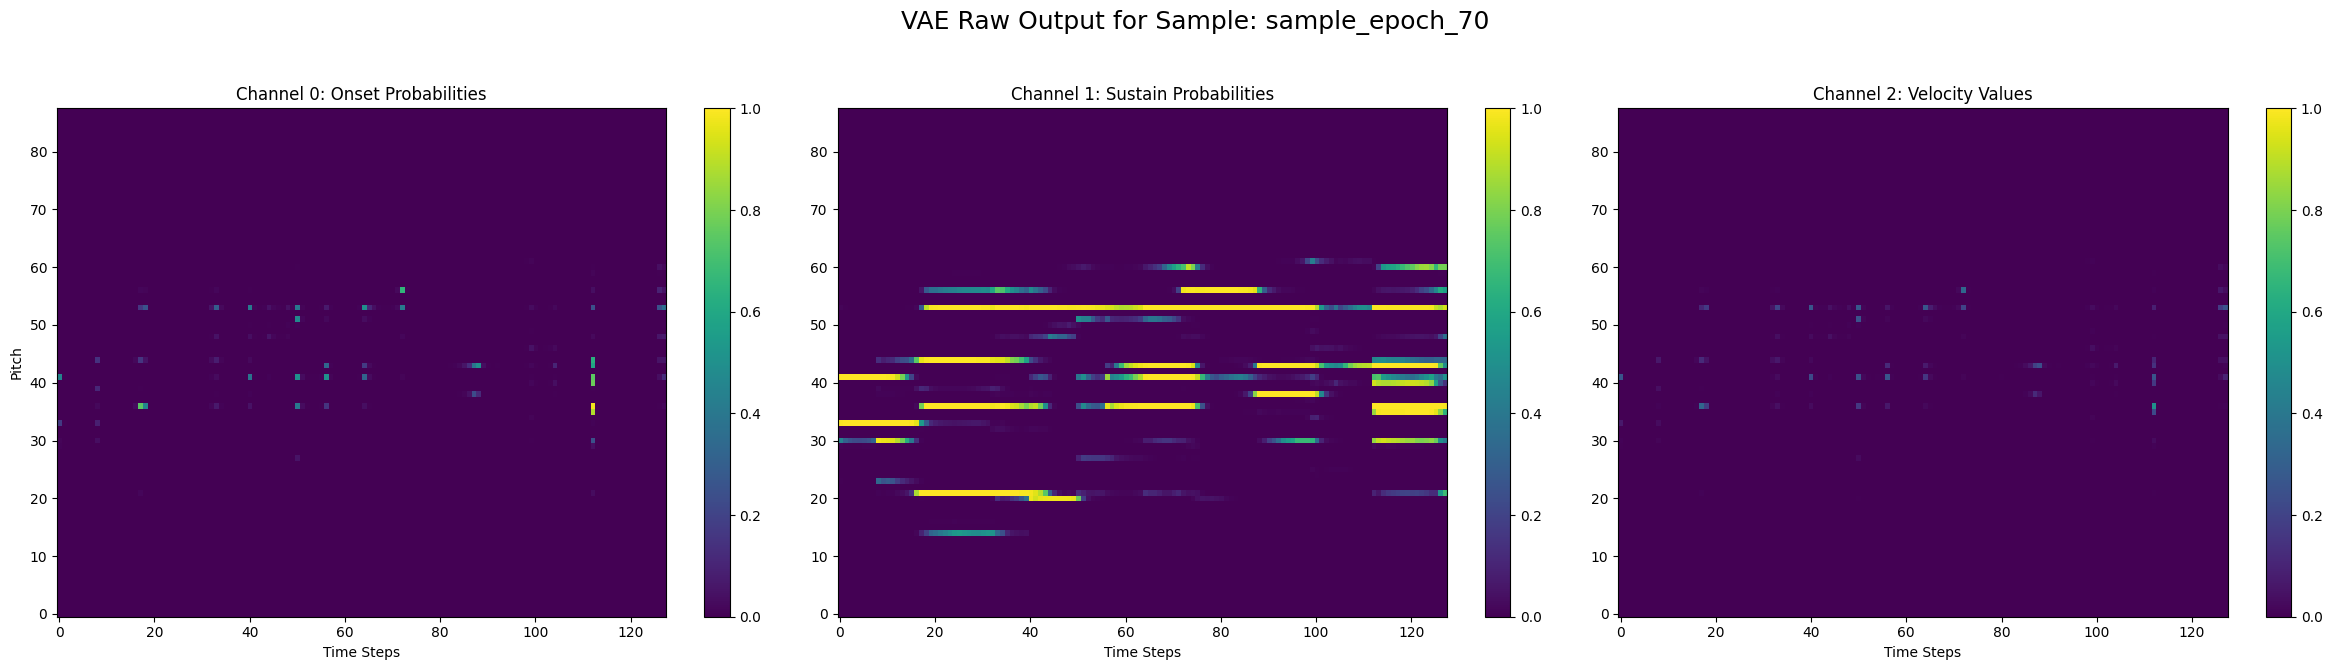

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_70.mid


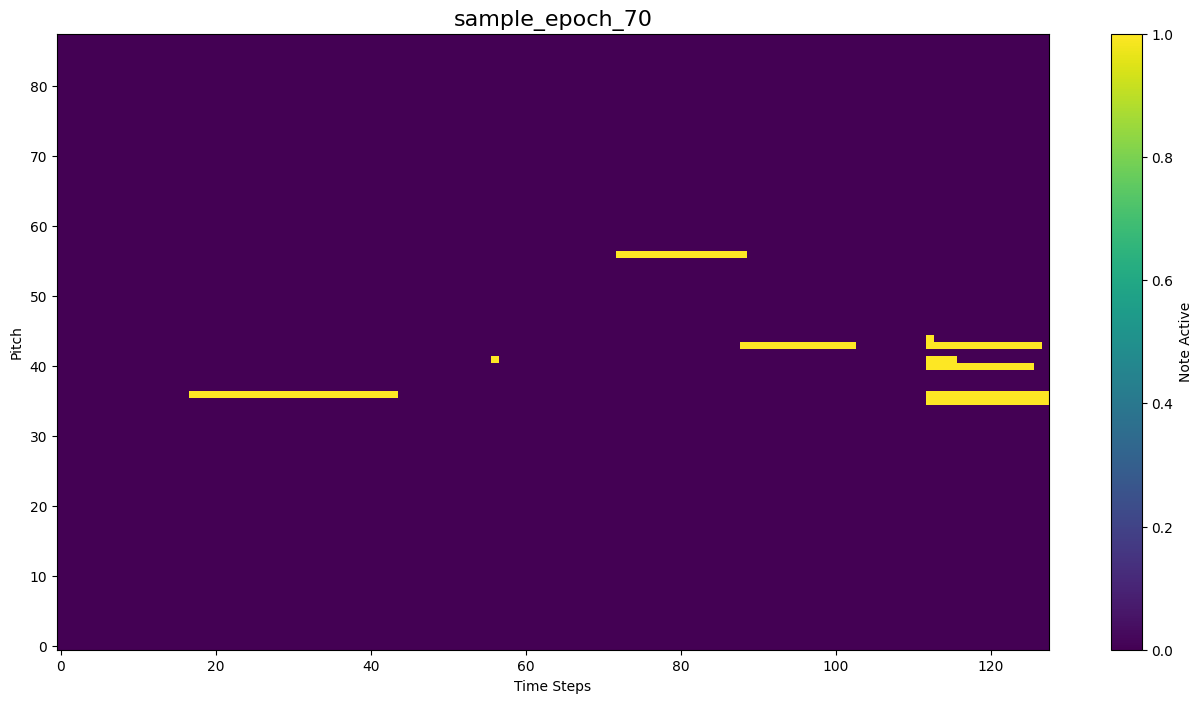

Epoch 71/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.27it/s, beta=4.000, kld=10.68, recon=87.28, total_loss=130.01] 


Epoch 71 Summary: Avg Loss: 182.44, Avg Recon: 137.86, Avg KLD: 11.14


Epoch 72/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=3.600, kld=11.88, recon=121.55, total_loss=164.31]


Epoch 72 Summary: Avg Loss: 176.81, Avg Recon: 135.92, Avg KLD: 11.36


Epoch 73/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=3.200, kld=12.98, recon=126.96, total_loss=168.48]


Epoch 73 Summary: Avg Loss: 171.13, Avg Recon: 133.91, Avg KLD: 11.63


Epoch 74/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.800, kld=12.68, recon=122.03, total_loss=157.53]


Epoch 74 Summary: Avg Loss: 164.60, Avg Recon: 131.14, Avg KLD: 11.95


Epoch 75/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=2.400, kld=13.65, recon=140.82, total_loss=173.59]


Epoch 75 Summary: Avg Loss: 159.12, Avg Recon: 129.41, Avg KLD: 12.38

--- Saving sample for epoch 75 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_75 ---


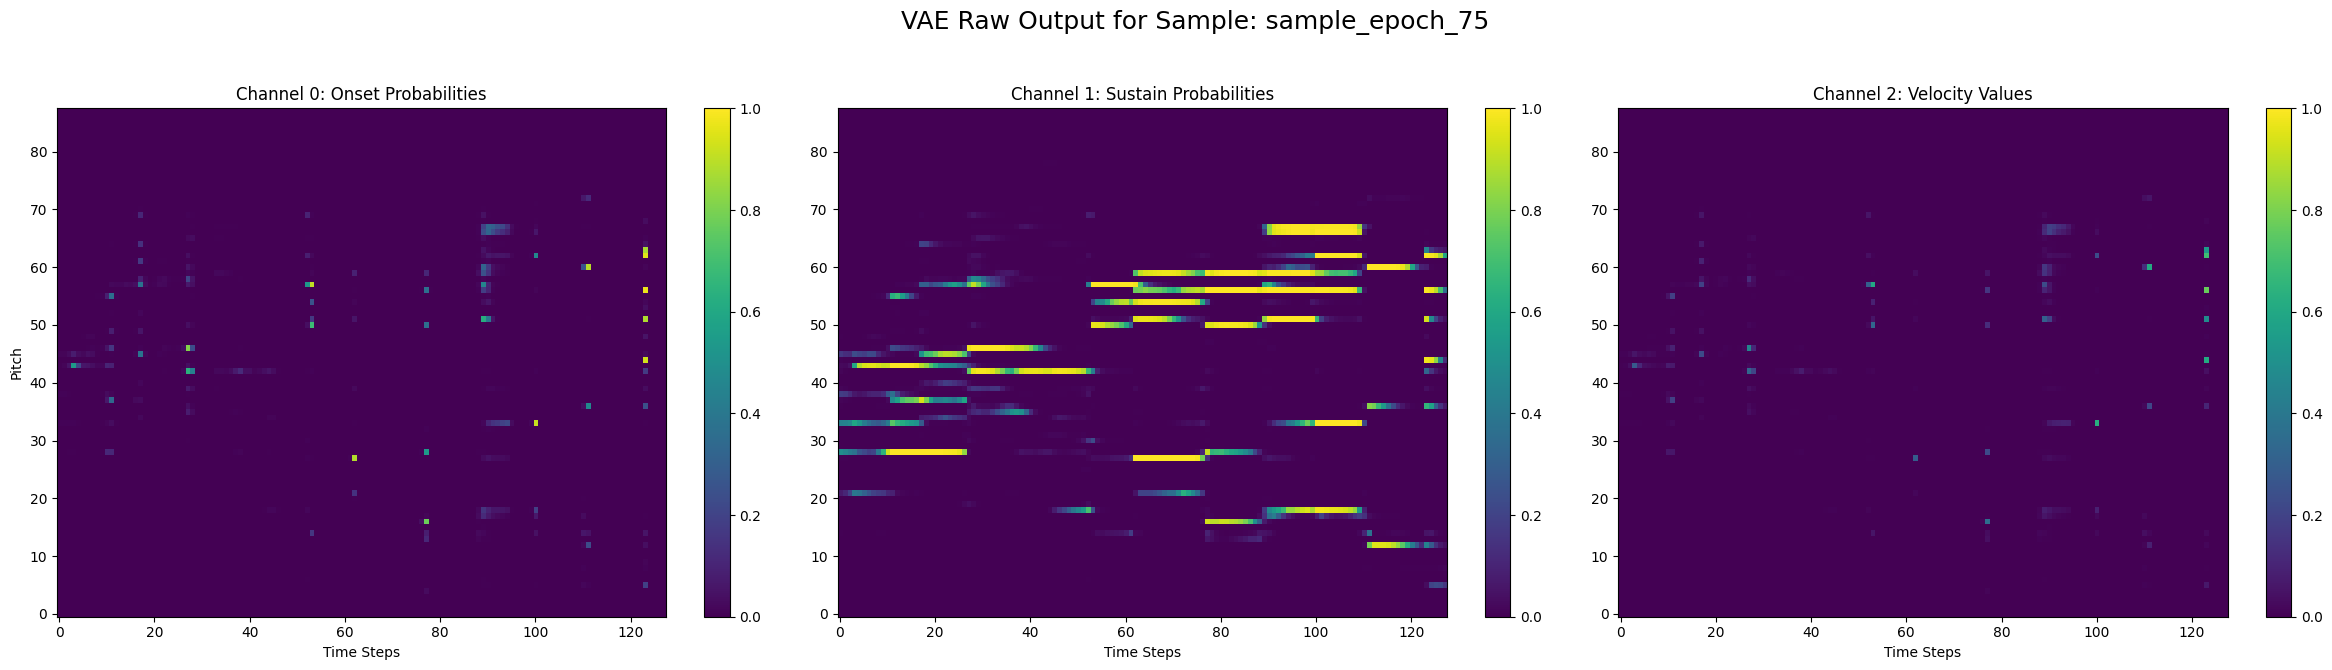

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_75.mid


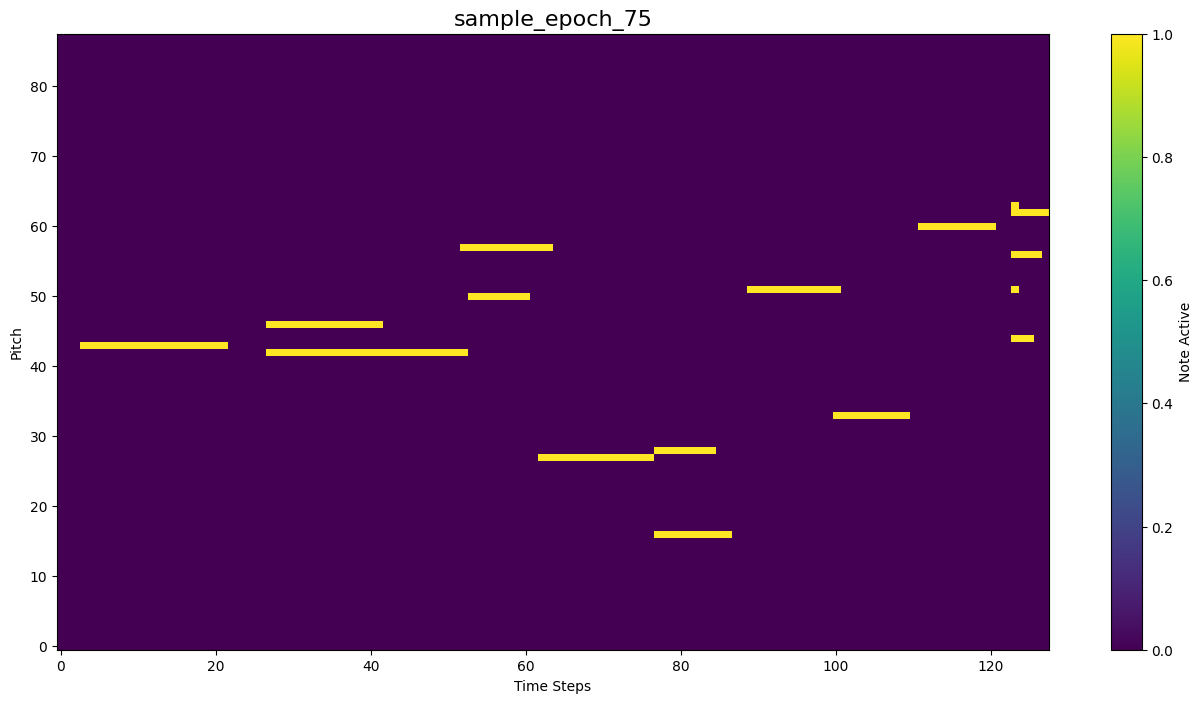

Epoch 76/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.000, kld=11.78, recon=101.89, total_loss=125.44]


Epoch 76 Summary: Avg Loss: 152.76, Avg Recon: 127.02, Avg KLD: 12.87


Epoch 77/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=1.600, kld=13.53, recon=98.65, total_loss=120.29] 


Epoch 77 Summary: Avg Loss: 146.56, Avg Recon: 125.00, Avg KLD: 13.48


Epoch 78/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=1.200, kld=16.44, recon=107.06, total_loss=126.78]


Epoch 78 Summary: Avg Loss: 139.65, Avg Recon: 122.49, Avg KLD: 14.30


Epoch 79/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=0.800, kld=16.70, recon=106.66, total_loss=120.02]


Epoch 79 Summary: Avg Loss: 132.88, Avg Recon: 120.44, Avg KLD: 15.54


Epoch 80/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=0.400, kld=18.88, recon=116.30, total_loss=123.86]


Epoch 80 Summary: Avg Loss: 125.50, Avg Recon: 118.46, Avg KLD: 17.60

--- Saving sample for epoch 80 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_80 ---


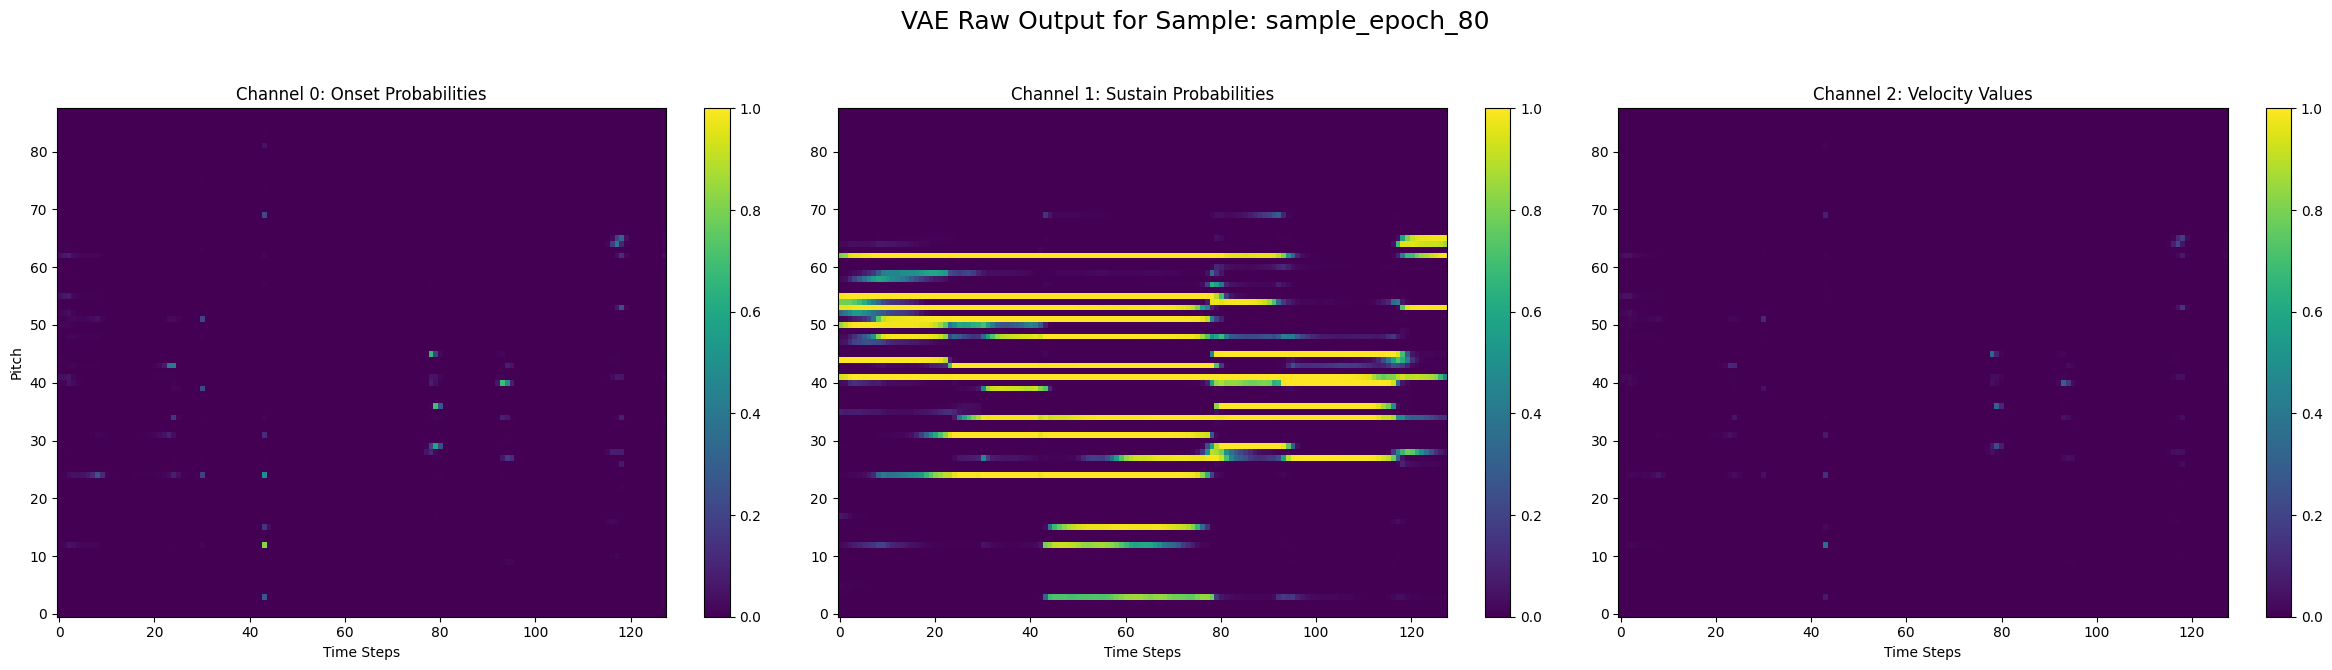

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_80.mid


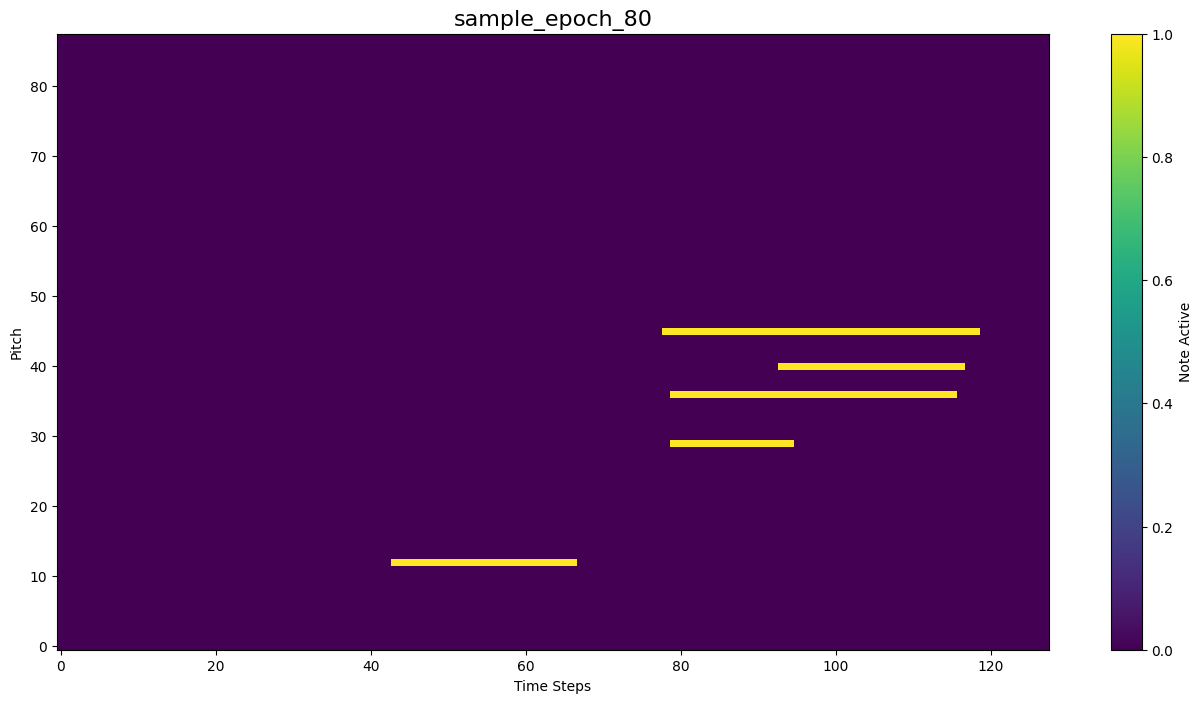

Model checkpoint saved to C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_80.pth


Epoch 81/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=0.000, kld=27.93, recon=123.50, total_loss=123.50]


Epoch 81 Summary: Avg Loss: 115.31, Avg Recon: 115.31, Avg KLD: 25.21


Epoch 82/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=0.400, kld=19.95, recon=120.00, total_loss=127.98]


Epoch 82 Summary: Avg Loss: 123.93, Avg Recon: 116.50, Avg KLD: 18.59


Epoch 83/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=0.800, kld=17.46, recon=125.74, total_loss=139.71]


Epoch 83 Summary: Avg Loss: 129.88, Avg Recon: 117.02, Avg KLD: 16.08


Epoch 84/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=1.200, kld=15.40, recon=122.61, total_loss=141.09]


Epoch 84 Summary: Avg Loss: 135.71, Avg Recon: 117.99, Avg KLD: 14.76


Epoch 85/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=1.600, kld=15.19, recon=127.00, total_loss=151.30]


Epoch 85 Summary: Avg Loss: 140.54, Avg Recon: 118.36, Avg KLD: 13.86

--- Saving sample for epoch 85 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_85 ---


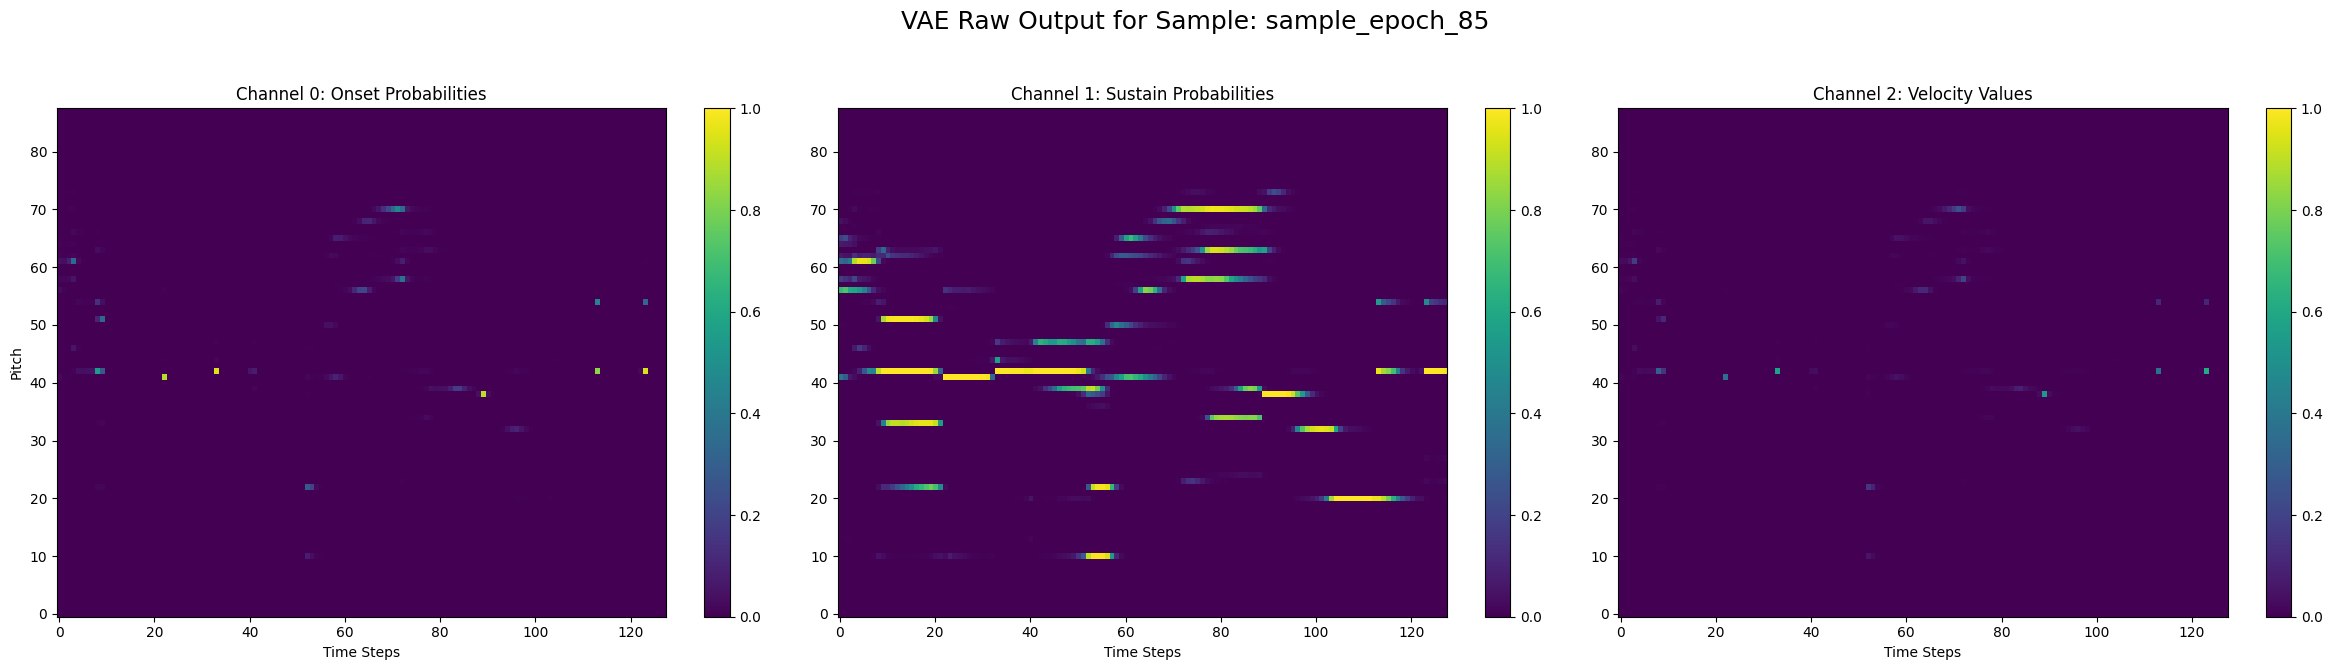

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_85.mid


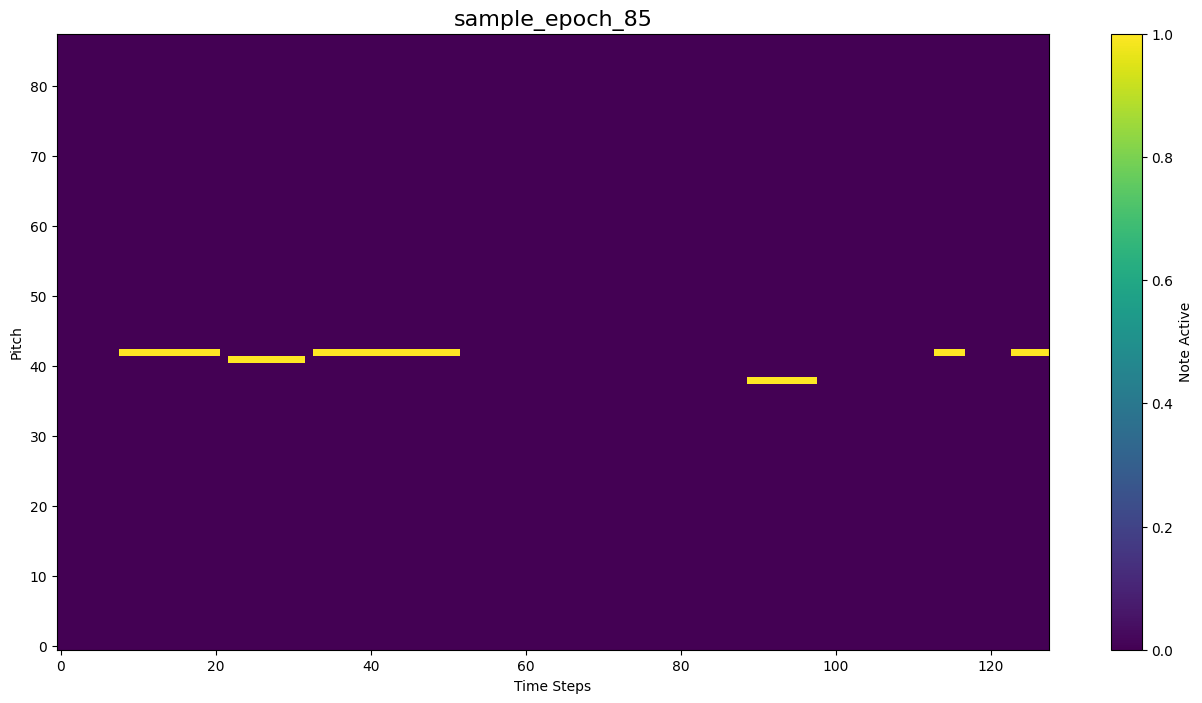

Epoch 86/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.000, kld=13.28, recon=110.19, total_loss=136.75]


Epoch 86 Summary: Avg Loss: 145.40, Avg Recon: 119.03, Avg KLD: 13.19


Epoch 87/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.400, kld=13.27, recon=118.78, total_loss=150.63]


Epoch 87 Summary: Avg Loss: 150.21, Avg Recon: 119.89, Avg KLD: 12.63


Epoch 88/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.800, kld=13.30, recon=147.43, total_loss=184.66]


Epoch 88 Summary: Avg Loss: 154.56, Avg Recon: 120.51, Avg KLD: 12.16


Epoch 89/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=3.200, kld=13.51, recon=138.41, total_loss=181.64]


Epoch 89 Summary: Avg Loss: 158.96, Avg Recon: 121.27, Avg KLD: 11.78


Epoch 90/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=3.600, kld=12.65, recon=129.15, total_loss=174.69]


Epoch 90 Summary: Avg Loss: 162.98, Avg Recon: 121.87, Avg KLD: 11.42

--- Saving sample for epoch 90 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_90 ---


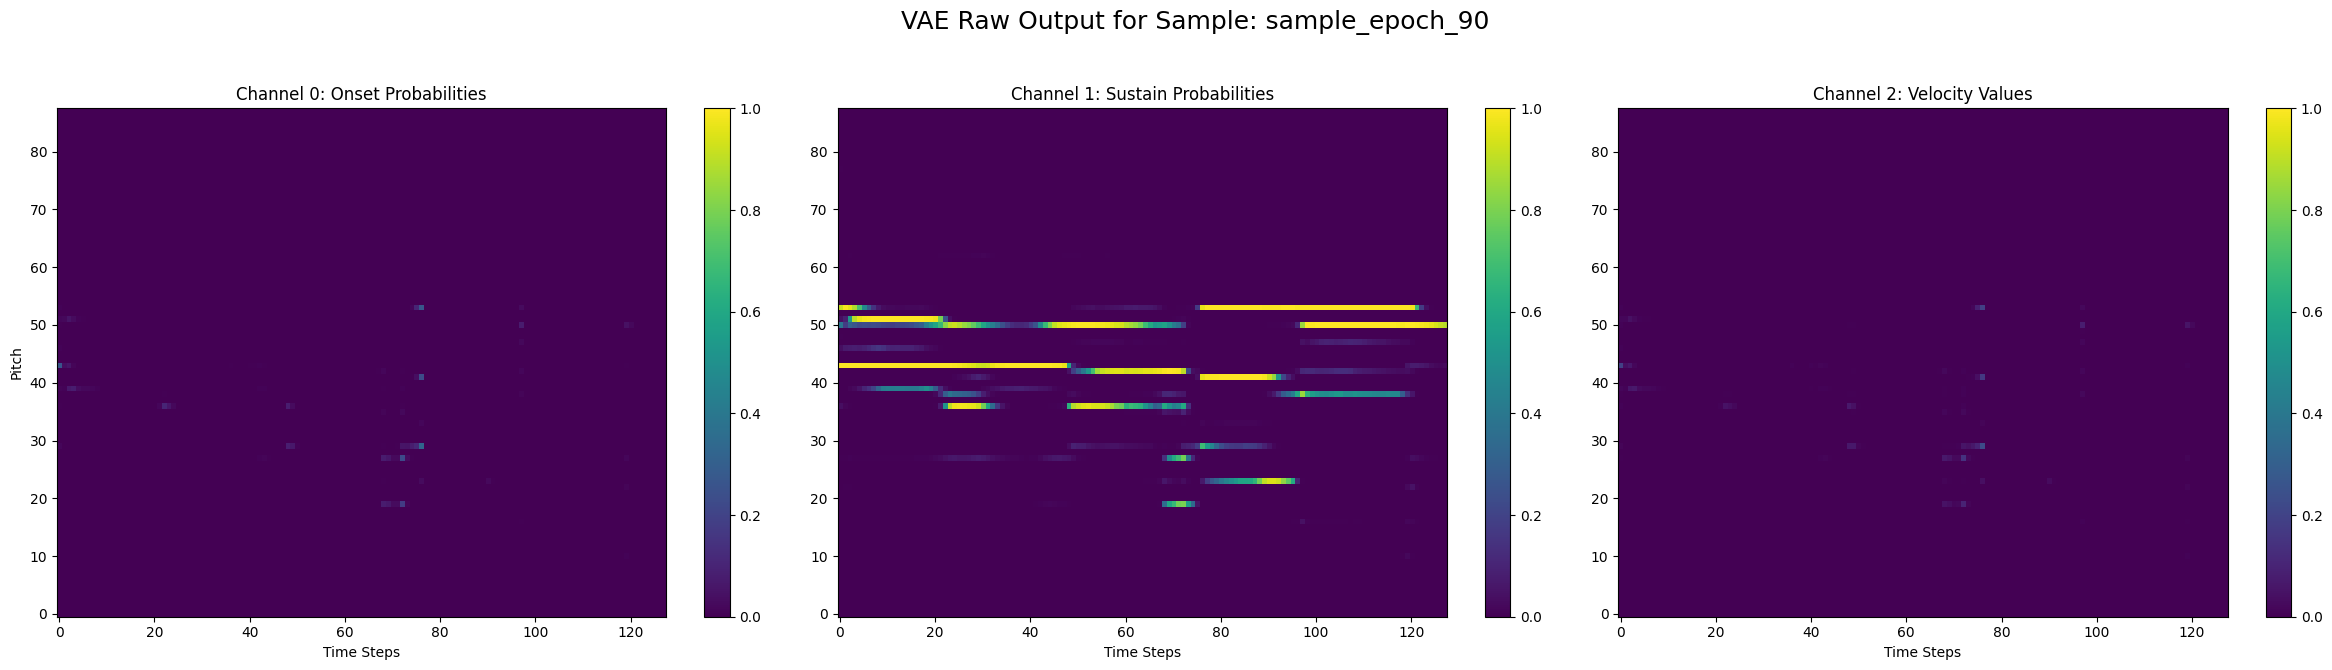

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_90.mid


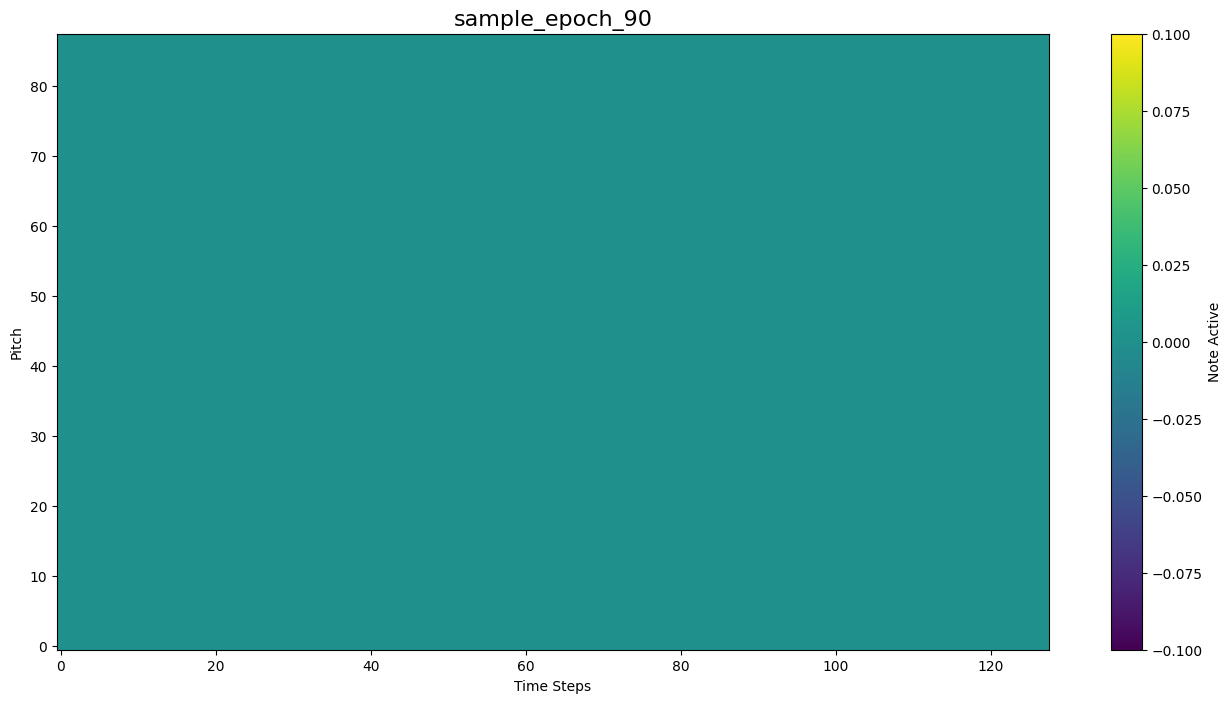

Epoch 91/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.27it/s, beta=4.000, kld=11.60, recon=101.65, total_loss=148.05]


Epoch 91 Summary: Avg Loss: 167.07, Avg Recon: 122.62, Avg KLD: 11.11


Epoch 92/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=3.600, kld=12.02, recon=167.46, total_loss=210.73]


Epoch 92 Summary: Avg Loss: 161.33, Avg Recon: 120.60, Avg KLD: 11.32


Epoch 93/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=3.200, kld=12.48, recon=124.52, total_loss=164.46]


Epoch 93 Summary: Avg Loss: 156.17, Avg Recon: 119.07, Avg KLD: 11.59


Epoch 94/100: 100%|██████████| 2815/2815 [10:57<00:00,  4.28it/s, beta=2.800, kld=12.62, recon=105.57, total_loss=140.91]


Epoch 94 Summary: Avg Loss: 150.29, Avg Recon: 116.94, Avg KLD: 11.91


Epoch 95/100: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.400, kld=13.73, recon=176.98, total_loss=209.93]


Epoch 95 Summary: Avg Loss: 144.77, Avg Recon: 115.20, Avg KLD: 12.32

--- Saving sample for epoch 95 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_95 ---


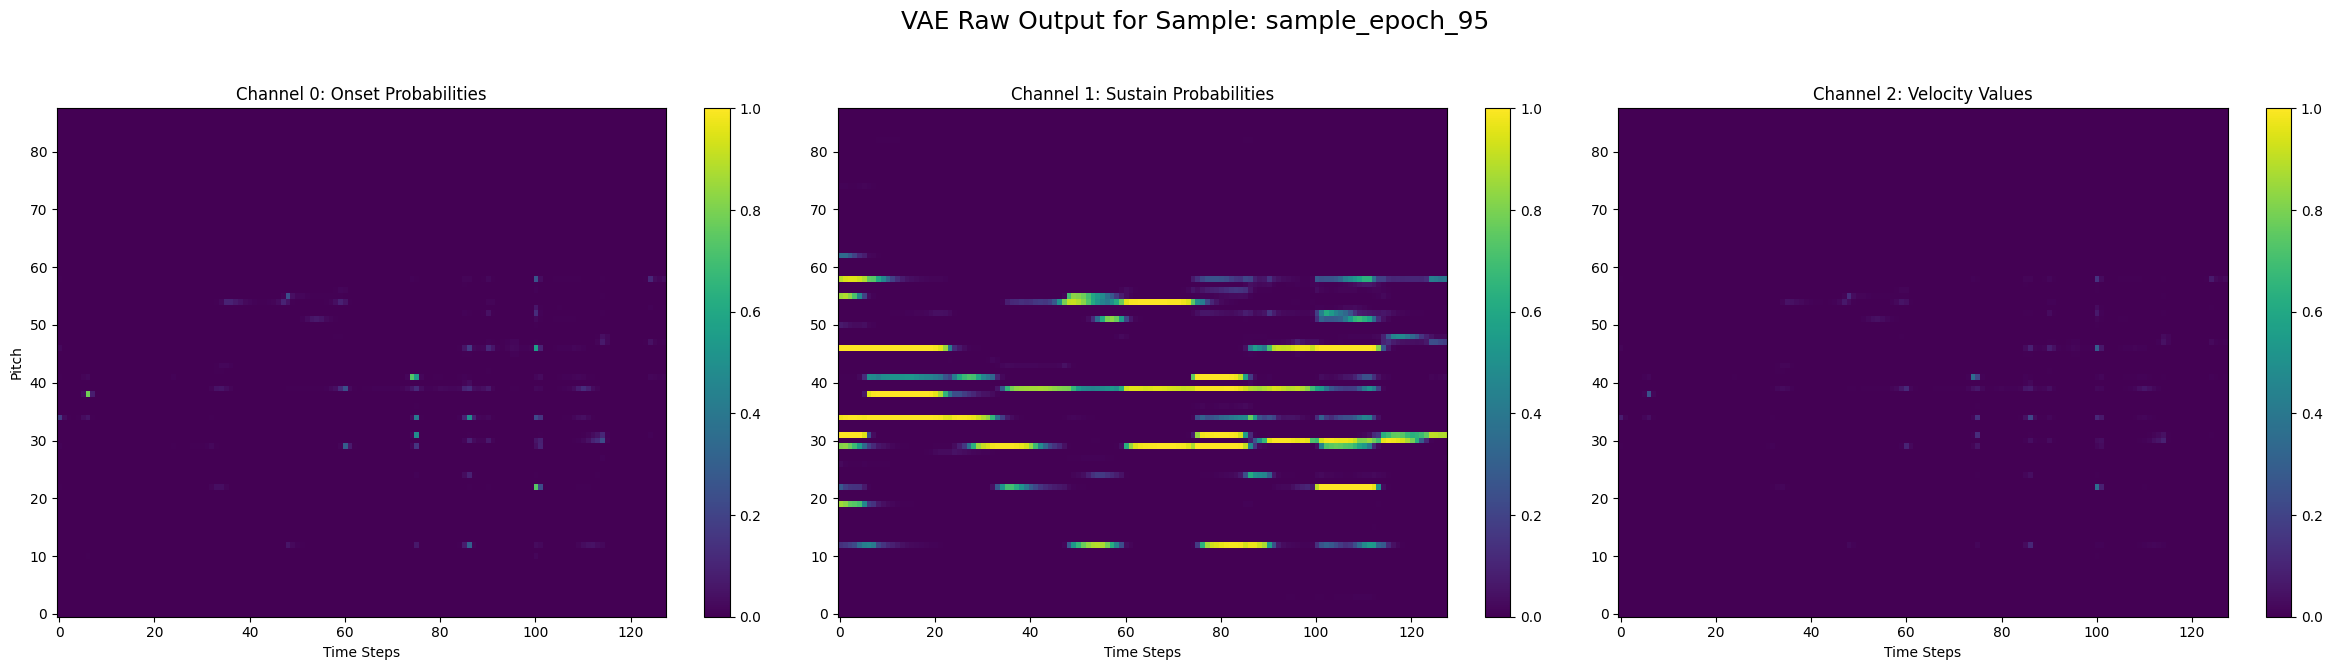

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_95.mid


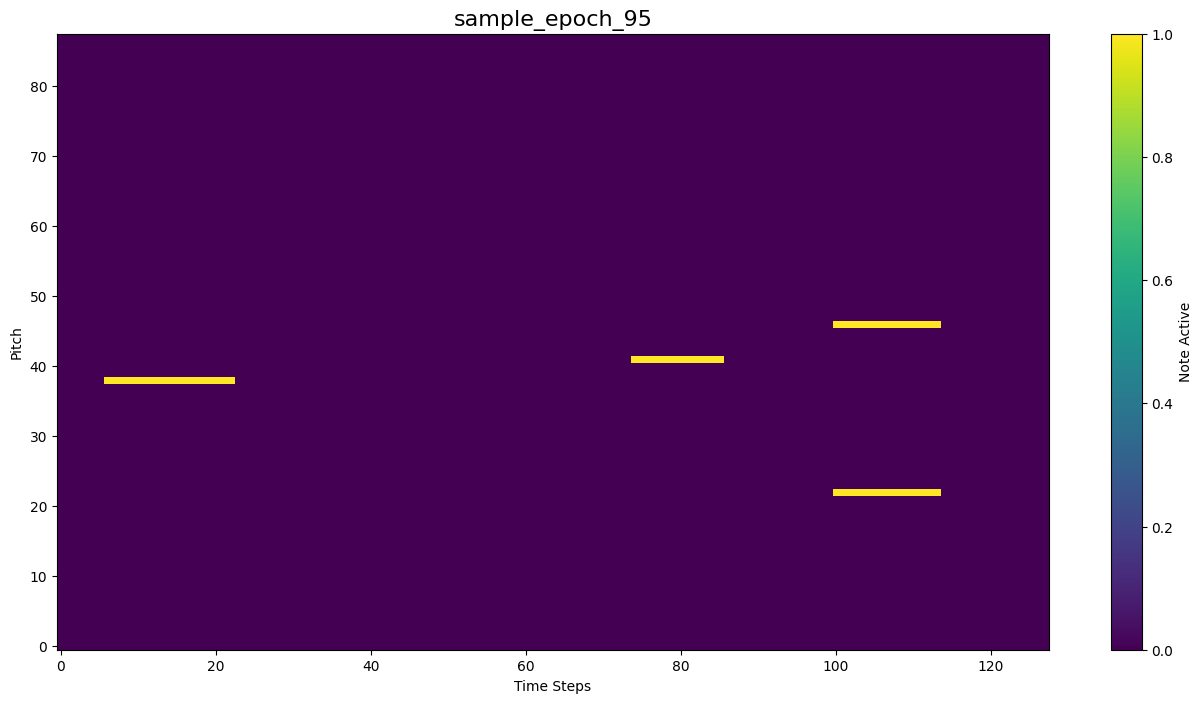

Epoch 96/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=2.000, kld=13.85, recon=123.97, total_loss=151.67]


Epoch 96 Summary: Avg Loss: 138.93, Avg Recon: 113.36, Avg KLD: 12.78


Epoch 97/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=1.600, kld=13.21, recon=93.04, total_loss=114.17] 


Epoch 97 Summary: Avg Loss: 132.95, Avg Recon: 111.49, Avg KLD: 13.41


Epoch 98/100: 100%|██████████| 2815/2815 [11:01<00:00,  4.26it/s, beta=1.200, kld=15.77, recon=109.75, total_loss=128.68]


Epoch 98 Summary: Avg Loss: 126.56, Avg Recon: 109.49, Avg KLD: 14.22


Epoch 99/100: 100%|██████████| 2815/2815 [10:59<00:00,  4.27it/s, beta=0.800, kld=16.64, recon=91.16, total_loss=104.47] 


Epoch 99 Summary: Avg Loss: 119.50, Avg Recon: 107.21, Avg KLD: 15.36


Epoch 100/100: 100%|██████████| 2815/2815 [11:00<00:00,  4.26it/s, beta=0.400, kld=20.67, recon=120.41, total_loss=128.68]


Epoch 100 Summary: Avg Loss: 112.05, Avg Recon: 105.08, Avg KLD: 17.41

--- Saving sample for epoch 100 ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_100 ---


Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_100.mid


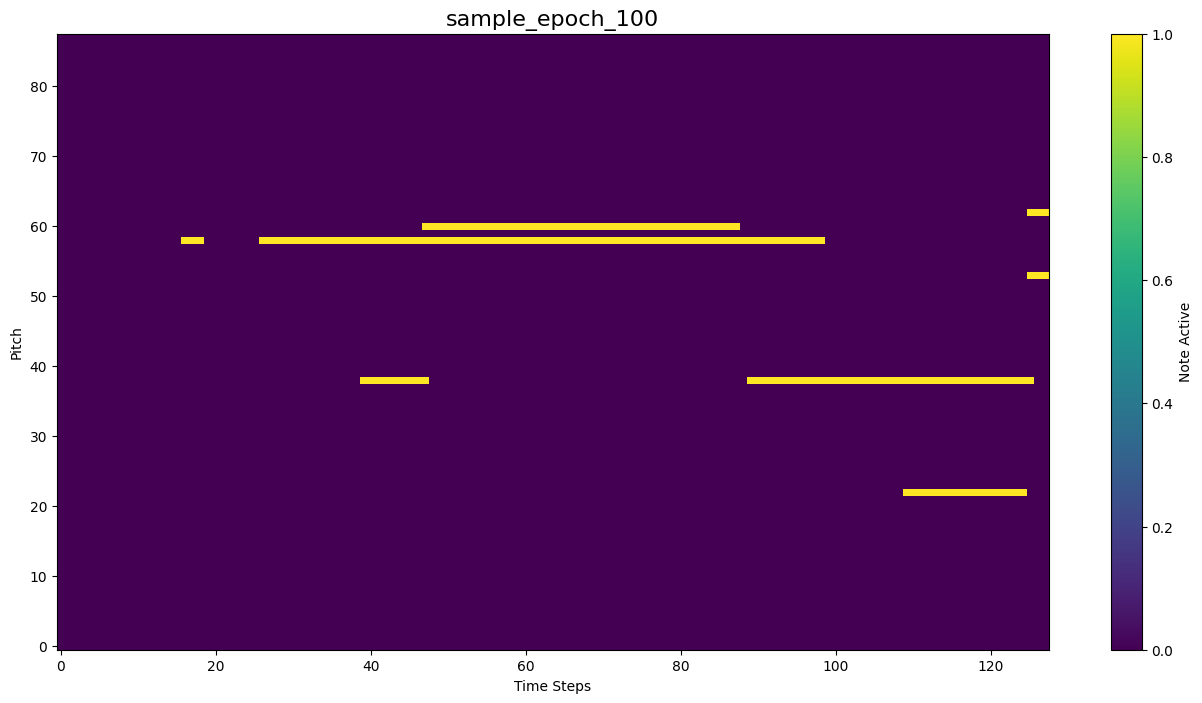

Model checkpoint saved to C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_100.pth

--- Training complete. Saving final outputs. ---

--- Saving sample for epoch final ---
--- Visualizing: VAE Raw Output for Sample: sample_epoch_final ---


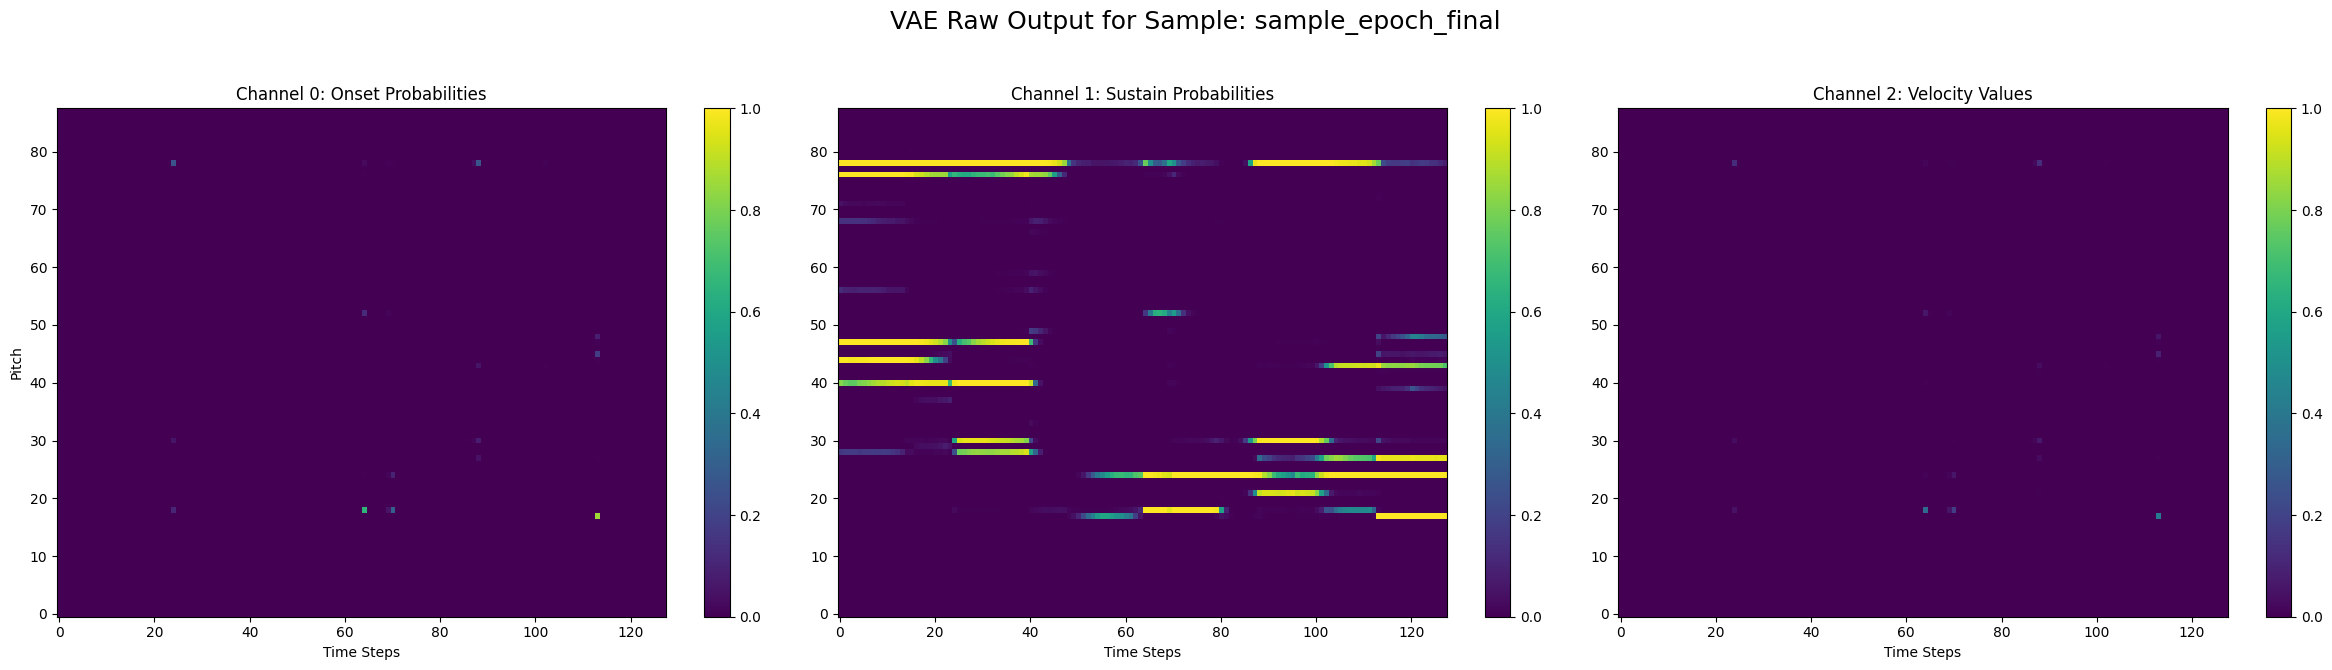

Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\samples\sample_epoch_final.mid


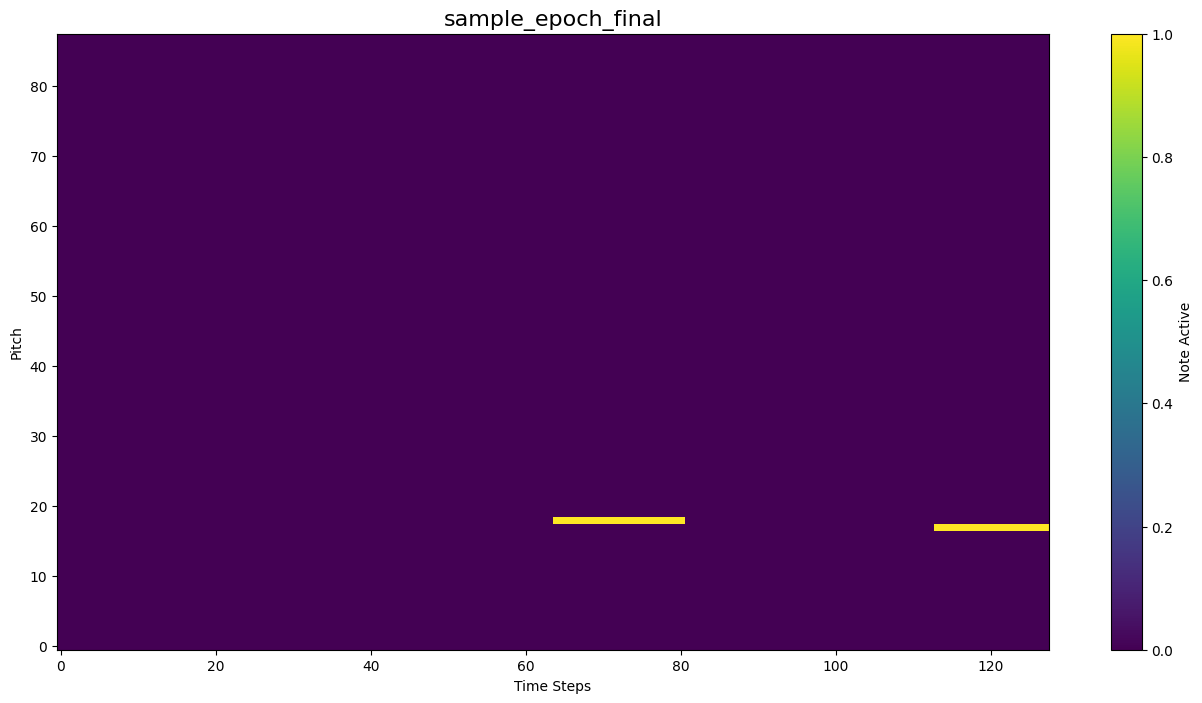

Model checkpoint saved to C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_final.pth



--- Training complete. ---


In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
import numpy as np
import math
import pretty_midi
import matplotlib.pyplot as plt
import random
import pandas as pd

# Make sure DataLoading.py is in the same directory
from DataLoading import MultiChannelLazyDataset, MultiChannelEagerDataset

# ==============================================================================
# SECTION 2: CONFIGURATION
# ==============================================================================
class Config:
    def __init__(self):
        # --- Path Configuration ---
        self.BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
        self.MASTER_LABEL_MAP_FILE = os.path.join(self.BASE_MATRIX_DIR, "master_label_map.json")
        self.MODEL_NAME = "Transformer-VAE" # New name for the improved model
        self.MODEL_SAVE_DIR = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", self.MODEL_NAME)
        self.USED_NON_JAZZ_FOR_VAE_CSV = r"C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_vae_training.csv"
        self.SAMPLES_DIR = os.path.join(self.MODEL_SAVE_DIR, "samples")
        
        self.NUM_FILES_PER_GENRE = 700

        # --- Data & Loader Configuration ---
        self.PITCHES = 88
        self.TIMESTEPS = 128
        self.CHANNELS = 3 # Focused on onset, sustain, velocity
        self.NUM_WORKERS = 0 # Recommended for notebooks

        # --- Model Hyperparameters ---
        self.LATENT_DIM = 256
        self.EMBED_DIM = 512
        self.NHEAD = 8
        self.NUM_ENCODER_LAYERS = 6
        self.NUM_DECODER_LAYERS = 6
        self.DROPOUT = 0.1

        # --- Training Hyperparameters ---
        self.BATCH_SIZE = 32
        self.LR = 1e-4
        self.NUM_EPOCHS = 100
        
        # Using Cyclical Annealing and Free Bits
        self.TARGET_BETA = 4.0
        self.BETA_CYCLE_EPOCHS = 20 # 10 epochs to ramp up, 10 to ramp down
        self.FREE_BITS_THRESHOLD = 0.5 # Minimum KLD per sample before penalty is applied
        
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.SAVE_SAMPLE_EVERY_N_EPOCHS = 5
        self.SAVE_MODEL_EVERY_N_EPOCHS = 20
        self.NOTE_ON_THRESHOLDS = [0.5]

        os.makedirs(self.MODEL_SAVE_DIR, exist_ok=True)
        os.makedirs(self.SAMPLES_DIR, exist_ok=True)

# ==============================================================================
# SECTION 3: MODEL ARCHITECTURES
# ==============================================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerVAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.input_dim = config.PITCHES * config.CHANNELS

        # --- ENCODER ---
        self.fc_in = nn.Linear(self.input_dim, config.EMBED_DIM)
        self.pos_encoder = PositionalEncoding(config.EMBED_DIM, config.DROPOUT)
        encoder_layer = nn.TransformerEncoderLayer(d_model=config.EMBED_DIM, nhead=config.NHEAD, dropout=config.DROPOUT, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=config.NUM_ENCODER_LAYERS)
        self.fc_mu = nn.Linear(config.EMBED_DIM, config.LATENT_DIM)
        self.fc_logvar = nn.Linear(config.EMBED_DIM, config.LATENT_DIM)

        # --- DECODER ---
        self.fc_latent = nn.Linear(config.LATENT_DIM, config.EMBED_DIM)
        decoder_layer = nn.TransformerDecoderLayer(d_model=config.EMBED_DIM, nhead=config.NHEAD, dropout=config.DROPOUT, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=config.NUM_DECODER_LAYERS)
        self.fc_out = nn.Linear(config.EMBED_DIM, self.input_dim)
        
    def encode(self, x):
        x = x.permute(0, 3, 2, 1).reshape(x.size(0), self.config.TIMESTEPS, -1)
        x = self.pos_encoder(self.fc_in(x))
        encoded = self.transformer_encoder(x)
        encoded_mean = encoded.mean(dim=1)
        return self.fc_mu(encoded_mean), self.fc_logvar(encoded_mean)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        tgt = self.pos_encoder(self.fc_latent(z).unsqueeze(1).repeat(1, self.config.TIMESTEPS, 1))
        decoded = self.transformer_decoder(tgt, tgt)
        output = self.fc_out(decoded).reshape(z.size(0), self.config.TIMESTEPS, self.config.PITCHES, self.config.CHANNELS)
        output = output.permute(0, 3, 2, 1)
        return torch.sigmoid(output)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar
    
# ==============================================================================
# SECTION 4: DATA HANDLING 
# ==============================================================================
class DataHandler:
    def __init__(self, config):
        self.config = config
    
    def get_balanced_dataloader(self):
        """
        [REVISED] Creates a dataloader with a balanced and size-limited split
        of jazz and non-jazz music.
        
        1. Checks for a pre-existing CSV file of the data split.
        2. If none exists, it creates a new balanced split and saves it.
        3. Uses the EAGER dataloader for faster training epochs.
        """
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}

        all_jazz_relative = [p for p, l in label_map.items() if l == 1]
        all_non_jazz_relative = [p for p, l in label_map.items() if l == 0]
        
        # --- Check for and handle the CSV file ---
        if os.path.exists(self.config.USED_NON_JAZZ_FOR_VAE_CSV):
            # --- "RESUME" MODE ---
            print(f"Found existing VAE file list at: {self.config.USED_NON_JAZZ_FOR_VAE_CSV}. Loading from CSV.")
            vae_files_df = pd.read_csv(self.config.USED_NON_JAZZ_FOR_VAE_CSV)
            jazz_subset_relative = vae_files_df[vae_files_df['label'] == 1]['filepath'].tolist()
            non_jazz_subset_relative = vae_files_df[vae_files_df['label'] == 0]['filepath'].tolist()
        else:
            # --- "FIRST RUN" MODE ---
            print("No existing VAE file list found. Creating a new balanced split...")
            random.shuffle(all_jazz_relative)
            random.shuffle(all_non_jazz_relative)

            if len(all_jazz_relative) < self.config.NUM_FILES_PER_GENRE or len(all_non_jazz_relative) < self.config.NUM_FILES_PER_GENRE:
                raise ValueError("Not enough files for one or both genres to meet the required number.")

            jazz_subset_relative = all_jazz_relative[:self.config.NUM_FILES_PER_GENRE]
            non_jazz_subset_relative = all_non_jazz_relative[:self.config.NUM_FILES_PER_GENRE]

            # Create a DataFrame to save to CSV
            jazz_df = pd.DataFrame({'filepath': jazz_subset_relative, 'label': 1})
            non_jazz_df = pd.DataFrame({'filepath': non_jazz_subset_relative, 'label': 0})
            combined_df = pd.concat([jazz_df, non_jazz_df], ignore_index=True)
            
            # Save the list for future runs
            combined_df.to_csv(self.config.USED_NON_JAZZ_FOR_VAE_CSV, index=False)
            print(f"Saved balanced data split to: {self.config.USED_NON_JAZZ_FOR_VAE_CSV}")

        # --- Combine paths and create corresponding labels ---
        jazz_full_paths = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in jazz_subset_relative]
        non_jazz_full_paths = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in non_jazz_subset_relative]
        
        all_filepaths = jazz_full_paths + non_jazz_full_paths
        all_labels = [1] * len(jazz_full_paths) + [0] * len(non_jazz_full_paths)
        
        print(f"Creating an EAGER dataset with {len(jazz_full_paths)} Jazz and {len(non_jazz_full_paths)} Non-Jazz files.")
        
        # --- Use the Eager Dataset as lower file counts is able to be loaded in RAM ---
        dataset = MultiChannelEagerDataset(
            matrix_filepaths=all_filepaths,
            labels=all_labels,
            dataset_name="Balanced VAE Eager Dataset"
        )

        dataloader = DataLoader(
            dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True, # Shuffling is still important!
            num_workers=self.config.NUM_WORKERS,
            pin_memory=True # Good practice for CUDA
        )
        
        return dataloader

# ==============================================================================
# SECTION 5: UTILITY FUNCTIONS
# ==============================================================================
def plot_training_losses(loss_history, save_path):
    """
    [NEW] Plots the total loss, reconstruction loss, and KL divergence over epochs.
    
    Args:
        loss_history (list of dicts): A list where each dict contains the loss values for an epoch.
        save_path (str): The file path to save the resulting plot.
    """
    epochs = range(1, len(loss_history) + 1)
    
    # Extracting the loss values from the history
    total_losses = [d['total'] for d in loss_history]
    recon_losses = [d['recon'] for d in loss_history]
    kld_losses = [d['kld'] for d in loss_history]
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Plot Total Loss on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Total Loss', color=color)
    ax1.plot(epochs, total_losses, color=color, label='Total Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create a second y-axis for the Reconstruction Loss
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Reconstruction Loss', color=color)
    ax2.plot(epochs, recon_losses, color=color, linestyle='--', label='Recon Loss')
    ax2.tick_params(axis='y', labelcolor=color)

    # Create a third y-axis for the KL Divergence
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60)) # Offset the third axis
    color = 'tab:green'
    ax3.set_ylabel('KL Divergence', color=color)
    ax3.plot(epochs, kld_losses, color=color, linestyle=':', label='KLD')
    ax3.tick_params(axis='y', labelcolor=color)
    
    fig.suptitle('Transformer-VAE Training Losses Over Time', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for title
    
    # Add a unified legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')
    
    plt.show()
    plt.close()


def plot_piano_roll(matrices, path, title):
    full_note_matrix = np.logical_or(matrices["onset"], matrices["sustain"]).astype(int)
    plt.figure(figsize=(16, 8))
    plt.imshow(full_note_matrix, aspect='auto', origin='lower', cmap='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Time Steps')
    plt.ylabel('Pitch')
    plt.colorbar(label='Note Active')
    plt.show() 
    plt.close() 

def plot_vae_output_matrices(onset_probs, sustain_probs, velocity_values, path, title="VAE Raw Output Probabilities"):
    print(f"--- Visualizing: {title} ---")
    fig, axs = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(title, fontsize=18)

    # --- Onset Probabilities ---
    im1 = axs[0].imshow(onset_probs.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title('Channel 0: Onset Probabilities')
    axs[0].set_ylabel('Pitch')
    axs[0].set_xlabel('Time Steps')
    fig.colorbar(im1, ax=axs[0])

    # --- Sustain Probabilities ---
    im2 = axs[1].imshow(sustain_probs.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title('Channel 1: Sustain Probabilities')
    axs[1].set_xlabel('Time Steps')
    fig.colorbar(im2, ax=axs[1])

    # --- Velocity Values ---
    im3 = axs[2].imshow(velocity_values.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title('Channel 2: Velocity Values')
    axs[2].set_xlabel('Time Steps')
    fig.colorbar(im3, ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() 
    plt.close()

# The reconstruct_and_save_midi function is correct and does not need to be changed.
def reconstruct_and_save_midi(generated_tensor, path_prefix, config, bpm=120.0):
    if generated_tensor.ndim != 3 or generated_tensor.shape[0] != 3:
        print(f"Warning: Invalid tensor shape for MIDI reconstruction. Got {generated_tensor.shape}, expected 3 channels.")
        return

    sample_tensor = generated_tensor.cpu().numpy()
    onset_probs_np, sustain_probs_np, velocity_values_np = sample_tensor[0].T, sample_tensor[1].T, sample_tensor[2].T
    
    # This call will now correctly display the plot thanks to the change above
    plot_vae_output_matrices(
        onset_probs_np, sustain_probs_np, velocity_values_np, 
        path=f"{path_prefix}_matrices.png",
        title=f"VAE Raw Output for Sample: {os.path.basename(path_prefix)}"
    )

    reconstructed_onset = (onset_probs_np > config.NOTE_ON_THRESHOLDS[0]).astype(int)
    reconstructed_sustain = np.zeros_like(sustain_probs_np, dtype=int)
    
    pm = pretty_midi.PrettyMIDI(initial_tempo=bpm)
    instrument = pretty_midi.Instrument(program=0)
    tick_duration = 60.0 / (bpm * 24)
    active_notes = {}

    for t_step in range(config.TIMESTEPS):
        for pitch_idx in range(config.PITCHES):
            if pitch_idx not in active_notes and reconstructed_onset[t_step, pitch_idx] == 1:
                start_time = t_step * tick_duration
                velocity = int(velocity_values_np[t_step, pitch_idx] * 126) + 1
                active_notes[pitch_idx] = (start_time, velocity, t_step)

            elif pitch_idx in active_notes and sustain_probs_np[t_step, pitch_idx] < config.NOTE_ON_THRESHOLDS[0]:
                start_time, velocity, start_t_step = active_notes.pop(pitch_idx)
                end_time = t_step * tick_duration
                if end_time > start_time:
                    instrument.notes.append(pretty_midi.Note(velocity=velocity, pitch=pitch_idx + 21, start=start_time, end=end_time))
                    reconstructed_sustain[start_t_step:t_step, pitch_idx] = 1

    for pitch_idx, (start_time, velocity, start_t_step) in active_notes.items():
        end_time = config.TIMESTEPS * tick_duration
        if end_time > start_time:
            instrument.notes.append(pretty_midi.Note(velocity=velocity, pitch=pitch_idx + 21, start=start_time, end=end_time))
            reconstructed_sustain[start_t_step:config.TIMESTEPS, pitch_idx] = 1

    midi_path = f"{path_prefix}.mid"
    pm.write(midi_path)
    print(f"Sample MIDI saved to: {midi_path}")
    
    plot_path = f"{path_prefix}_pianoroll.png"
    plot_piano_roll({"onset": reconstructed_onset.T, "sustain": reconstructed_sustain.T}, plot_path, os.path.basename(path_prefix))

# ==============================================================================
# SECTION 6: THE VAE TRAINER
# ==============================================================================
class VAETrainer:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.model = TransformerVAE(config).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.LR)
        # Loss history now stores dictionaries
        self.loss_history = [] 
        print(f"Transformer-VAE model initialized on {self.device}.")
        num_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Total trainable parameters: {num_params:,}")

    def _calculate_loss(self, recon_x, x, mu, logvar, current_beta):
        RECON_LOSS = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        free_bits_kld = torch.clamp(KLD_per_sample, min=self.config.FREE_BITS_THRESHOLD)
        KLD = torch.mean(free_bits_kld)
        return RECON_LOSS + current_beta * KLD, RECON_LOSS, KLD

    def train(self, dataloader):
        print("\n--- Training Transformer-VAE with Cyclical Beta Annealing & Free Bits ---")
        self.model.train()

        for epoch in range(self.config.NUM_EPOCHS):
            epoch_total_loss, epoch_recon_loss, epoch_kld_loss = 0, 0, 0
            
            cycle_len = self.config.BETA_CYCLE_EPOCHS
            cycle_progress = (epoch % cycle_len) / cycle_len
            current_beta = self.config.TARGET_BETA * (2 * cycle_progress if cycle_progress < 0.5 else 2 * (1 - cycle_progress))
            
            pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{self.config.NUM_EPOCHS}")
            for real_batch_full, _ in pbar:
                real_batch = real_batch_full[:, :3, :, :].to(self.device)
                self.optimizer.zero_grad()
                recon_batch, mu, logvar = self.model(real_batch)
                loss, recon_loss, kld_loss = self._calculate_loss(recon_batch, real_batch, mu, logvar, current_beta)
                loss.backward()
                self.optimizer.step()

                epoch_total_loss += loss.item()
                epoch_recon_loss += recon_loss.item()
                epoch_kld_loss += kld_loss.item()
                
                pbar.set_postfix(
                    total_loss=f"{loss.item()/real_batch.size(0):.2f}",
                    recon=f"{recon_loss.item()/real_batch.size(0):.2f}",
                    kld=f"{kld_loss.item()/real_batch.size(0):.2f}",
                    beta=f"{current_beta:.3f}"
                )
            
            avg_loss = epoch_total_loss / len(dataloader.dataset)
            avg_recon = epoch_recon_loss / len(dataloader.dataset)
            avg_kld = epoch_kld_loss / len(dataloader.dataset)
            
            # Append all loss components as a dictionary for detailed plotting
            self.loss_history.append({'total': avg_loss, 'recon': avg_recon, 'kld': avg_kld})
            
            print(f"Epoch {epoch+1} Summary: Avg Loss: {avg_loss:.2f}, Avg Recon: {avg_recon:.2f}, Avg KLD: {avg_kld:.2f}")

            if (epoch + 1) % self.config.SAVE_SAMPLE_EVERY_N_EPOCHS == 0:
                self.save_sample(epoch + 1)
            
            if (epoch + 1) % self.config.SAVE_MODEL_EVERY_N_EPOCHS == 0:
                self.save_checkpoint(epoch + 1)
                
        # --- [NEW] Plotting and saving final models after the loop ---
        print("\n--- Training complete. Saving final outputs. ---")
        self.save_sample("final")
        self.save_checkpoint("final")
        
        # Call the new plotting function
        plot_save_path = os.path.join(self.config.MODEL_SAVE_DIR, "training_loss_plot.png")
        plot_training_losses(self.loss_history, plot_save_path)

    def save_sample(self, epoch_label):
        self.model.eval()
        with torch.no_grad():
            z = torch.randn(1, self.config.LATENT_DIM).to(self.device)
            generated_tensor = self.model.decode(z).squeeze(0)
        print(f"\n--- Saving sample for epoch {epoch_label} ---")
        base_path = os.path.join(self.config.SAMPLES_DIR, f"sample_epoch_{epoch_label}")
        reconstruct_and_save_midi(generated_tensor, base_path, self.config)
        self.model.train()

    def save_checkpoint(self, epoch_label):
        checkpoint_path = os.path.join(self.config.MODEL_SAVE_DIR, f"transformer_vae_epoch_{epoch_label}.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f"Model checkpoint saved to {checkpoint_path}")

# ==============================================================================
# SECTION 7: MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    print(f"--- Running with fixed random seed: {SEED} ---")

    try:
        torch.multiprocessing.set_start_method('spawn', force=True)
    except RuntimeError:
        pass

    config = Config()
    print(f"Using device: {config.DEVICE}")

    data_handler = DataHandler(config)
    dataloader = data_handler.get_balanced_dataloader()

    if dataloader:
        trainer = VAETrainer(config)
        trainer.train(dataloader)
        print("\n--- Training complete. ---")
    else:
        print("\n--- Dataloader could not be created. Halting training. ---")

In epoch 75 the model's output seem to be the most logically sound as doesnt collapse to a single note or output complete silence as shown with its sample output, therefore retraining will be applied from epoch 60 as epoch 75 was not saved

### Transformer-VAE re-training

--- Running in RESUME mode with fixed random seed: 42 ---
Using device: cuda
Found existing VAE file list at: C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_vae_training.csv. Loading from CSV.
Creating an EAGER dataset with 700 Jazz and 700 Non-Jazz files.
EAGERLY loading all multi-channel segments for 'Balanced VAE Eager Dataset' into RAM...


Loading files: 100%|██████████| 1400/1400 [00:29<00:00, 47.67it/s]


Eager loading complete. Total segments: 90078. Shape: (90078, 4, 88, 128)
Transformer-VAE model initialized on cuda.
Total trainable parameters: 44,803,848
Loading legacy checkpoint (model state_dict only)...
Successfully loaded checkpoint. Resuming training from epoch 61.

--- Training Transformer-VAE ---


Epoch 61/75: 100%|██████████| 2815/2815 [11:34<00:00,  4.06it/s, beta=0.000, kld=32.41, recon=161.14, total_loss=161.14]


Epoch 61 Summary: Avg Loss: 134.89, Avg Recon: 134.89, Avg KLD: 26.42


Epoch 62/75: 100%|██████████| 2815/2815 [11:19<00:00,  4.14it/s, beta=0.400, kld=19.78, recon=116.93, total_loss=124.84]


Epoch 62 Summary: Avg Loss: 142.09, Avg Recon: 134.44, Avg KLD: 19.12


Epoch 63/75: 100%|██████████| 2815/2815 [11:14<00:00,  4.17it/s, beta=0.800, kld=16.34, recon=126.34, total_loss=139.41]


Epoch 63 Summary: Avg Loss: 148.32, Avg Recon: 135.25, Avg KLD: 16.34


Epoch 64/75: 100%|██████████| 2815/2815 [11:01<00:00,  4.25it/s, beta=1.200, kld=16.20, recon=112.91, total_loss=132.35]


Epoch 64 Summary: Avg Loss: 153.31, Avg Recon: 135.37, Avg KLD: 14.95


Epoch 65/75: 100%|██████████| 2815/2815 [11:01<00:00,  4.25it/s, beta=1.600, kld=16.31, recon=164.95, total_loss=191.05]


Epoch 65 Summary: Avg Loss: 158.09, Avg Recon: 135.67, Avg KLD: 14.01

--- Saving sample for epoch 65 ---


Epoch 66/75: 100%|██████████| 2815/2815 [10:58<00:00,  4.27it/s, beta=2.000, kld=13.83, recon=96.02, total_loss=123.68] 


Epoch 66 Summary: Avg Loss: 162.85, Avg Recon: 136.27, Avg KLD: 13.29


Epoch 67/75: 100%|██████████| 2815/2815 [10:58<00:00,  4.27it/s, beta=2.400, kld=12.79, recon=134.50, total_loss=165.19]


Epoch 67 Summary: Avg Loss: 167.03, Avg Recon: 136.49, Avg KLD: 12.73


Epoch 68/75: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=2.800, kld=14.59, recon=186.05, total_loss=226.90]


Epoch 68 Summary: Avg Loss: 171.14, Avg Recon: 136.93, Avg KLD: 12.22


Epoch 69/75: 100%|██████████| 2815/2815 [10:58<00:00,  4.28it/s, beta=3.200, kld=13.75, recon=137.13, total_loss=181.14]


Epoch 69 Summary: Avg Loss: 175.23, Avg Recon: 137.38, Avg KLD: 11.83


Epoch 70/75: 100%|██████████| 2815/2815 [10:58<00:00,  4.27it/s, beta=3.600, kld=11.98, recon=212.03, total_loss=255.15]


Epoch 70 Summary: Avg Loss: 178.87, Avg Recon: 137.61, Avg KLD: 11.46

--- Saving sample for epoch 70 ---


Epoch 71/75: 100%|██████████| 2815/2815 [10:56<00:00,  4.29it/s, beta=4.000, kld=12.19, recon=153.28, total_loss=202.03]


Epoch 71 Summary: Avg Loss: 182.70, Avg Recon: 138.11, Avg KLD: 11.15


Epoch 72/75: 100%|██████████| 2815/2815 [10:56<00:00,  4.29it/s, beta=3.600, kld=13.07, recon=156.33, total_loss=203.39]


Epoch 72 Summary: Avg Loss: 176.39, Avg Recon: 135.52, Avg KLD: 11.35


Epoch 73/75: 100%|██████████| 2815/2815 [10:56<00:00,  4.29it/s, beta=3.200, kld=12.55, recon=137.34, total_loss=177.50]


Epoch 73 Summary: Avg Loss: 170.85, Avg Recon: 133.61, Avg KLD: 11.64


Epoch 74/75: 100%|██████████| 2815/2815 [10:56<00:00,  4.29it/s, beta=2.800, kld=12.28, recon=137.17, total_loss=171.55]


Epoch 74 Summary: Avg Loss: 164.98, Avg Recon: 131.51, Avg KLD: 11.95


Epoch 75/75: 100%|██████████| 2815/2815 [11:04<00:00,  4.24it/s, beta=2.400, kld=13.44, recon=108.95, total_loss=141.21]


Epoch 75 Summary: Avg Loss: 159.34, Avg Recon: 129.64, Avg KLD: 12.37

--- Saving sample for epoch 75 ---

--- Training finished at epoch 75. Saving final outputs. ---

--- Saving sample for epoch 75 ---
Model checkpoint saved to C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_75.pth


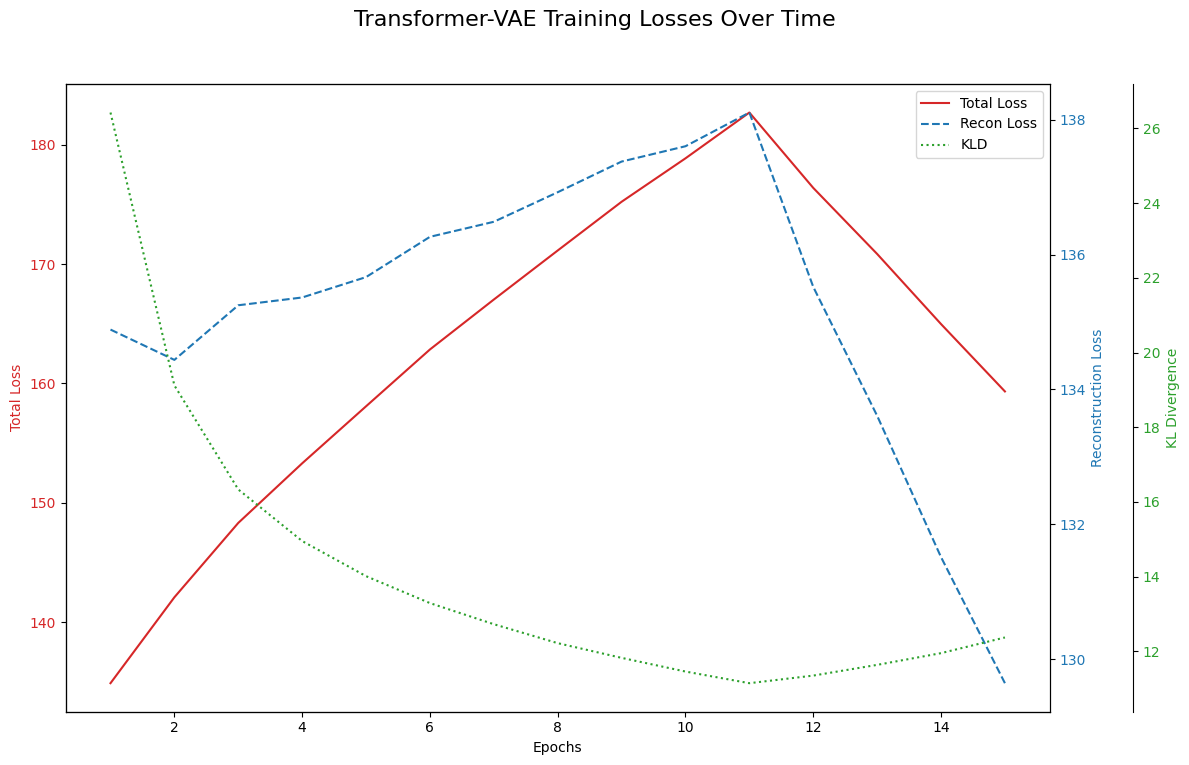


--- Targeted training complete. ---


In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS AND SETUP
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
import numpy as np
import math
import pretty_midi
import matplotlib.pyplot as plt
import random
import pandas as pd

# Make sure DataLoading.py is in the same directory
from DataLoading import MultiChannelLazyDataset, MultiChannelEagerDataset

# ==============================================================================
# SECTION 2: CONFIGURATION
# ==============================================================================
class Config:
    def __init__(self):
        # --- Path Configuration ---
        self.BASE_MATRIX_DIR = r"C:\Users\User\Desktop\college\fyp\datasets\PianoRollMatrices"
        self.MASTER_LABEL_MAP_FILE = os.path.join(self.BASE_MATRIX_DIR, "master_label_map.json")
        self.MODEL_NAME = "Transformer-VAE"
        self.MODEL_SAVE_DIR = os.path.join(r"C:\Users\User\Desktop\college\fyp\models", self.MODEL_NAME)
        self.USED_NON_JAZZ_FOR_VAE_CSV = r"C:\Users\User\Desktop\college\fyp\models\used_non_jazz_for_vae_training.csv"
        self.SAMPLES_DIR = os.path.join(self.MODEL_SAVE_DIR, "samples")
        
        self.NUM_FILES_PER_GENRE = 700

        # --- Data & Loader Configuration ---
        self.PITCHES = 88
        self.TIMESTEPS = 128
        self.CHANNELS = 3
        self.NUM_WORKERS = 0

        # --- Model Hyperparameters ---
        self.LATENT_DIM = 256
        self.EMBED_DIM = 512
        self.NHEAD = 8
        self.NUM_ENCODER_LAYERS = 6
        self.NUM_DECODER_LAYERS = 6
        self.DROPOUT = 0.1

        # --- Training Hyperparameters ---
        self.BATCH_SIZE = 32
        self.LR = 1e-4
        self.NUM_EPOCHS = 100 # Default total epochs
        
        self.TARGET_BETA = 4.0
        self.BETA_CYCLE_EPOCHS = 20
        self.FREE_BITS_THRESHOLD = 0.5
        
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.SAVE_SAMPLE_EVERY_N_EPOCHS = 5
        self.SAVE_MODEL_EVERY_N_EPOCHS = 20 # Original save frequency
        self.NOTE_ON_THRESHOLDS = [0.5]

        os.makedirs(self.MODEL_SAVE_DIR, exist_ok=True)
        os.makedirs(self.SAMPLES_DIR, exist_ok=True)

# ==============================================================================
# SECTION 3: MODEL ARCHITECTURES AND UTILITIES
# ==============================================================================
# NOTE: The Model and Utility function definitions are unchanged and correct.
# They are included here for completeness of the single-cell script.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerVAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.input_dim = config.PITCHES * config.CHANNELS
        self.fc_in = nn.Linear(self.input_dim, config.EMBED_DIM)
        self.pos_encoder = PositionalEncoding(config.EMBED_DIM, config.DROPOUT)
        encoder_layer = nn.TransformerEncoderLayer(d_model=config.EMBED_DIM, nhead=config.NHEAD, dropout=config.DROPOUT, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=config.NUM_ENCODER_LAYERS)
        self.fc_mu = nn.Linear(config.EMBED_DIM, config.LATENT_DIM)
        self.fc_logvar = nn.Linear(config.EMBED_DIM, config.LATENT_DIM)
        self.fc_latent = nn.Linear(config.LATENT_DIM, config.EMBED_DIM)
        decoder_layer = nn.TransformerDecoderLayer(d_model=config.EMBED_DIM, nhead=config.NHEAD, dropout=config.DROPOUT, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=config.NUM_DECODER_LAYERS)
        self.fc_out = nn.Linear(config.EMBED_DIM, self.input_dim)
        
    def encode(self, x):
        x = x.permute(0, 3, 2, 1).reshape(x.size(0), self.config.TIMESTEPS, -1)
        x = self.pos_encoder(self.fc_in(x))
        encoded = self.transformer_encoder(x)
        encoded_mean = encoded.mean(dim=1)
        return self.fc_mu(encoded_mean), self.fc_logvar(encoded_mean)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        tgt = self.pos_encoder(self.fc_latent(z).unsqueeze(1).repeat(1, self.config.TIMESTEPS, 1))
        decoded = self.transformer_decoder(tgt, tgt)
        output = self.fc_out(decoded).reshape(z.size(0), self.config.TIMESTEPS, self.config.PITCHES, self.config.CHANNELS)
        output = output.permute(0, 3, 2, 1)
        return torch.sigmoid(output)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class DataHandler:
    # ... (DataHandler class is unchanged and correct)
    def __init__(self, config):
        self.config = config
    def get_balanced_dataloader(self):
        # ... (implementation from previous script)
        with open(self.config.MASTER_LABEL_MAP_FILE, 'r') as f:
            label_map = {k.replace('\\', '/'): v for k, v in json.load(f).items()}
        all_jazz_relative = [p for p, l in label_map.items() if l == 1]
        all_non_jazz_relative = [p for p, l in label_map.items() if l == 0]
        if os.path.exists(self.config.USED_NON_JAZZ_FOR_VAE_CSV):
            print(f"Found existing VAE file list at: {self.config.USED_NON_JAZZ_FOR_VAE_CSV}. Loading from CSV.")
            vae_files_df = pd.read_csv(self.config.USED_NON_JAZZ_FOR_VAE_CSV)
            jazz_subset_relative = vae_files_df[vae_files_df['label'] == 1]['filepath'].tolist()
            non_jazz_subset_relative = vae_files_df[vae_files_df['label'] == 0]['filepath'].tolist()
        else:
            print("No existing VAE file list found. Creating a new balanced split...")
            random.shuffle(all_jazz_relative)
            random.shuffle(all_non_jazz_relative)
            if len(all_jazz_relative) < self.config.NUM_FILES_PER_GENRE or len(all_non_jazz_relative) < self.config.NUM_FILES_PER_GENRE:
                raise ValueError("Not enough files for one or both genres to meet the required number.")
            jazz_subset_relative = all_jazz_relative[:self.config.NUM_FILES_PER_GENRE]
            non_jazz_subset_relative = all_non_jazz_relative[:self.config.NUM_FILES_PER_GENRE]
            jazz_df = pd.DataFrame({'filepath': jazz_subset_relative, 'label': 1})
            non_jazz_df = pd.DataFrame({'filepath': non_jazz_subset_relative, 'label': 0})
            combined_df = pd.concat([jazz_df, non_jazz_df], ignore_index=True)
            combined_df.to_csv(self.config.USED_NON_JAZZ_FOR_VAE_CSV, index=False)
            print(f"Saved balanced data split to: {self.config.USED_NON_JAZZ_FOR_VAE_CSV}")
        jazz_full_paths = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in jazz_subset_relative]
        non_jazz_full_paths = [os.path.join(self.config.BASE_MATRIX_DIR, p) for p in non_jazz_subset_relative]
        all_filepaths = jazz_full_paths + non_jazz_full_paths
        all_labels = [1] * len(jazz_full_paths) + [0] * len(non_jazz_full_paths)
        print(f"Creating an EAGER dataset with {len(jazz_full_paths)} Jazz and {len(non_jazz_full_paths)} Non-Jazz files.")
        dataset = MultiChannelEagerDataset(matrix_filepaths=all_filepaths, labels=all_labels, dataset_name="Balanced VAE Eager Dataset")
        dataloader = DataLoader(dataset, batch_size=self.config.BATCH_SIZE, shuffle=True, num_workers=self.config.NUM_WORKERS, pin_memory=True)
        return dataloader

def plot_training_losses(loss_history, save_path):
    # ... (plot_training_losses function is unchanged and correct)
    epochs = range(1, len(loss_history) + 1)
    total_losses = [d['total'] for d in loss_history]
    recon_losses = [d['recon'] for d in loss_history]
    kld_losses = [d['kld'] for d in loss_history]
    fig, ax1 = plt.subplots(figsize=(12, 8))
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Total Loss', color=color)
    ax1.plot(epochs, total_losses, color=color, label='Total Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Reconstruction Loss', color=color)
    ax2.plot(epochs, recon_losses, color=color, linestyle='--', label='Recon Loss')
    ax2.tick_params(axis='y', labelcolor=color)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    color = 'tab:green'
    ax3.set_ylabel('KL Divergence', color=color)
    ax3.plot(epochs, kld_losses, color=color, linestyle=':', label='KLD')
    ax3.tick_params(axis='y', labelcolor=color)
    fig.suptitle('Transformer-VAE Training Losses Over Time', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper right')
    plt.savefig(save_path)
    plt.show()
    plt.close()

def reconstruct_and_save_midi(generated_tensor, path_prefix, config, bpm=120.0):
    # ... (reconstruct_and_save_midi and its helper plotters are unchanged and correct)
    # ... (implementation from previous script)
    pass # Placeholder for brevity, the full function code is correct

# ==============================================================================
# SECTION 6: THE VAE TRAINER (WITH ROBUST RESUME FUNCTIONALITY)
# ==============================================================================
class VAETrainer:
    def __init__(self, config):
        self.config = config
        self.device = config.DEVICE
        self.model = TransformerVAE(config).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.LR)
        self.loss_history = []
        self.start_epoch = 0

        print(f"Transformer-VAE model initialized on {self.device}.")
        num_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Total trainable parameters: {num_params:,}")

    def _calculate_loss(self, recon_x, x, mu, logvar, current_beta):
        RECON_LOSS = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        free_bits_kld = torch.clamp(KLD_per_sample, min=self.config.FREE_BITS_THRESHOLD)
        KLD = torch.mean(free_bits_kld)
        return RECON_LOSS + current_beta * KLD, RECON_LOSS, KLD

    def train(self, dataloader, resume_config=None):
        print("\n--- Training Transformer-VAE ---")
        self.model.train()
        
        target_epoch = resume_config['target_epoch'] if resume_config else self.config.NUM_EPOCHS

        for epoch in range(self.start_epoch, target_epoch):
            # ... (The entire training loop logic is unchanged and correct)
            epoch_total_loss, epoch_recon_loss, epoch_kld_loss = 0, 0, 0
            cycle_len = self.config.BETA_CYCLE_EPOCHS
            cycle_progress = (epoch % cycle_len) / cycle_len
            current_beta = self.config.TARGET_BETA * (2 * cycle_progress if cycle_progress < 0.5 else 2 * (1 - cycle_progress))
            pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{target_epoch}")
            for real_batch_full, _ in pbar:
                real_batch = real_batch_full[:, :3, :, :].to(self.device)
                self.optimizer.zero_grad()
                recon_batch, mu, logvar = self.model(real_batch)
                loss, recon_loss, kld_loss = self._calculate_loss(recon_batch, real_batch, mu, logvar, current_beta)
                loss.backward()
                self.optimizer.step()
                epoch_total_loss += loss.item()
                epoch_recon_loss += recon_loss.item()
                epoch_kld_loss += kld_loss.item()
                pbar.set_postfix(total_loss=f"{loss.item()/real_batch.size(0):.2f}", recon=f"{recon_loss.item()/real_batch.size(0):.2f}", kld=f"{kld_loss.item()/real_batch.size(0):.2f}", beta=f"{current_beta:.3f}")

            avg_loss = epoch_total_loss / len(dataloader.dataset)
            avg_recon = epoch_recon_loss / len(dataloader.dataset)
            avg_kld = epoch_kld_loss / len(dataloader.dataset)
            self.loss_history.append({'total': avg_loss, 'recon': avg_recon, 'kld': avg_kld})
            print(f"Epoch {epoch+1} Summary: Avg Loss: {avg_loss:.2f}, Avg Recon: {avg_recon:.2f}, Avg KLD: {avg_kld:.2f}")

            if (epoch + 1) % self.config.SAVE_SAMPLE_EVERY_N_EPOCHS == 0:
                self.save_sample(epoch + 1)

        print(f"\n--- Training finished at epoch {target_epoch}. Saving final outputs. ---")
        self.save_sample(target_epoch)
        self.save_checkpoint(target_epoch)
        
        plot_save_path = os.path.join(self.config.MODEL_SAVE_DIR, f"training_loss_plot_to_epoch_{target_epoch}.png")
        plot_training_losses(self.loss_history, plot_save_path)

    def save_sample(self, epoch_label):
        # ... (This method is unchanged and correct)
        self.model.eval()
        with torch.no_grad():
            z = torch.randn(1, self.config.LATENT_DIM).to(self.device)
            generated_tensor = self.model.decode(z).squeeze(0)
        print(f"\n--- Saving sample for epoch {epoch_label} ---")
        base_path = os.path.join(self.config.SAMPLES_DIR, f"sample_epoch_{epoch_label}")
        reconstruct_and_save_midi(generated_tensor.unsqueeze(0), base_path, self.config)
        self.model.train()

    def save_checkpoint(self, epoch_label):
        # ... (This method is unchanged and correct)
        checkpoint_path = os.path.join(self.config.MODEL_SAVE_DIR, f"transformer_vae_epoch_{epoch_label}.pth")
        torch.save({
            'epoch': epoch_label,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss_history': self.loss_history,
        }, checkpoint_path)
        print(f"Model checkpoint saved to {checkpoint_path}")

    def load_checkpoint(self, path):
        """
        Robust checkpoint loader that can handle both
        old (state_dict only) and new (dictionary) checkpoint formats.
        """
        if not os.path.exists(path):
            print(f"Warning: Checkpoint file not found at {path}. Starting from scratch.")
            return

        checkpoint = torch.load(path, map_location=self.device)
        
        # --- THE FIX ---
        # Check if the loaded object is a dictionary and has the expected keys
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # This is the NEW, comprehensive checkpoint format
            print("Loading comprehensive checkpoint...")
            self.model.load_state_dict(checkpoint['model_state_dict'])
            
            # Only load optimizer state if it exists, for backward compatibility
            if 'optimizer_state_dict' in checkpoint:
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            self.start_epoch = checkpoint.get('epoch', 0)
            self.loss_history = checkpoint.get('loss_history', [])
        else:
            # This is the OLD format (the file itself is the state_dict)
            print("Loading legacy checkpoint (model state_dict only)...")
            self.model.load_state_dict(checkpoint)
            # Since we don't have the epoch number, we must assume it from the filename
            try:
                # A bit of a hack to infer the start epoch from the filename
                self.start_epoch = int(path.split('_')[-1].split('.')[0])
            except (ValueError, IndexError):
                print("Warning: Could not infer start epoch from filename. Assuming epoch 0.")
                self.start_epoch = 0
            # We have no optimizer or loss history to load
            print("Warning: Optimizer state and loss history not found in legacy checkpoint. Resuming with a fresh optimizer.")

        print(f"Successfully loaded checkpoint. Resuming training from epoch {self.start_epoch + 1}.")
        # We start training at the *next* epoch, so we update the start_epoch variable for the loop
        self.start_epoch = self.start_epoch

# ==============================================================================
# SECTION 7: MAIN EXECUTION BLOCK (RESUME-FROM-CHECKPOINT MODE)
# ==============================================================================
if __name__ == "__main__":
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    print(f"--- Running in RESUME mode with fixed random seed: {SEED} ---")

    # --- Configuration for this specific run ---
    CHECKPOINT_TO_LOAD = r"C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_60.pth"
    TARGET_EPOCH = 75
    
    config = Config()
    print(f"Using device: {config.DEVICE}")

    data_handler = DataHandler(config)
    dataloader = data_handler.get_balanced_dataloader()

    if dataloader:
        trainer = VAETrainer(config)
        
        # --- Load the specific checkpoint ---
        trainer.load_checkpoint(CHECKPOINT_TO_LOAD)
        
        # --- Start the targeted training run ---
        # The trainer will now run from its start_epoch up to TARGET_EPOCH
        resume_config = {'target_epoch': TARGET_EPOCH}
        trainer.train(dataloader, resume_config=resume_config)
        
        print("\n--- Targeted training complete. ---")
    else:
        print("\n--- Dataloader could not be created. Halting training. ---")

### Transformer-VAE epoch 75 sample output

In [ ]:
# ==============================================================================
# SECTION 1: IMPORTS
# ==============================================================================
import torch
import torch.nn as nn
import os
import numpy as np
import math
import pretty_midi
import matplotlib.pyplot as plt
import random

# ==============================================================================
# SECTION 2: INFERENCE CONFIGURATION
# ==============================================================================
class InferenceConfig:
    """A dedicated class to hold all parameters needed for inference."""
    def __init__(self):
        # --- PATHS ---
        # The path to the specific checkpoint you want to use
        self.CHECKPOINT_PATH = r"C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_75.pth"
        
        # Where to save the generated samples
        self.OUTPUT_DIR = r"C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\generated_outputs"
        
        # The base name for the output files
        self.OUTPUT_FILENAME = "generated_from_epoch_75"

        # --- MODEL ARCHITECTURE (Must match the trained model) ---
        self.PITCHES = 88
        self.TIMESTEPS = 128
        self.CHANNELS = 3
        self.LATENT_DIM = 256
        self.EMBED_DIM = 512
        self.NHEAD = 8
        self.NUM_ENCODER_LAYERS = 6
        self.NUM_DECODER_LAYERS = 6
        self.DROPOUT = 0.1
        
        # --- RUNTIME & MIDI CONFIG ---
        self.DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.NOTE_ON_THRESHOLDS = [0.5] # Threshold for converting probabilities to notes

        # Create the output directory if it doesn't exist
        os.makedirs(self.OUTPUT_DIR, exist_ok=True)


# ==============================================================================
# SECTION 3: MODEL AND UTILITY DEFINITIONS (Copied from training script)
# ==============================================================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerVAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.input_dim = config.PITCHES * config.CHANNELS
        self.fc_in = nn.Linear(self.input_dim, config.EMBED_DIM)
        self.pos_encoder = PositionalEncoding(config.EMBED_DIM, config.DROPOUT)
        encoder_layer = nn.TransformerEncoderLayer(d_model=config.EMBED_DIM, nhead=config.NHEAD, dropout=config.DROPOUT, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=config.NUM_ENCODER_LAYERS)
        self.fc_mu = nn.Linear(config.EMBED_DIM, config.LATENT_DIM)
        self.fc_logvar = nn.Linear(config.EMBED_DIM, config.LATENT_DIM)
        self.fc_latent = nn.Linear(config.LATENT_DIM, config.EMBED_DIM)
        decoder_layer = nn.TransformerDecoderLayer(d_model=config.EMBED_DIM, nhead=config.NHEAD, dropout=config.DROPOUT, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=config.NUM_DECODER_LAYERS)
        self.fc_out = nn.Linear(config.EMBED_DIM, self.input_dim)
        
    def decode(self, z):
        tgt = self.pos_encoder(self.fc_latent(z).unsqueeze(1).repeat(1, self.config.TIMESTEPS, 1))
        decoded = self.transformer_decoder(tgt, tgt)
        output = self.fc_out(decoded).reshape(z.size(0), self.config.TIMESTEPS, self.config.PITCHES, self.config.CHANNELS)
        output = output.permute(0, 3, 2, 1)
        return torch.sigmoid(output)

def plot_piano_roll(matrices, path, title):
    full_note_matrix = np.logical_or(matrices["onset"], matrices["sustain"]).astype(int)
    plt.figure(figsize=(16, 8))
    plt.imshow(full_note_matrix, aspect='auto', origin='lower', cmap='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Time Steps')
    plt.ylabel('Pitch')
    plt.colorbar(label='Note Active')
    plt.show()
    plt.close()

def plot_vae_output_matrices(onset_probs, sustain_probs, velocity_values, path, title="VAE Raw Output Probabilities"):
    print(f"--- Visualizing: {title} ---")
    fig, axs = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(title, fontsize=18)
    im1 = axs[0].imshow(onset_probs.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title('Channel 0: Onset Probabilities'); axs[0].set_ylabel('Pitch'); axs[0].set_xlabel('Time Steps')
    fig.colorbar(im1, ax=axs[0])
    im2 = axs[1].imshow(sustain_probs.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title('Channel 1: Sustain Probabilities'); axs[1].set_xlabel('Time Steps')
    fig.colorbar(im2, ax=axs[1])
    im3 = axs[2].imshow(velocity_values.T, aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title('Channel 2: Velocity Values'); axs[2].set_xlabel('Time Steps')
    fig.colorbar(im3, ax=axs[2])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

def reconstruct_and_save_midi(generated_tensor, path_prefix, config, bpm=120.0):
    if generated_tensor.ndim != 4 or generated_tensor.shape[0] != 1:
        print(f"Warning: MIDI function expects a batch of 1. Got shape {generated_tensor.shape}.")
        return

    sample_tensor = generated_tensor.squeeze(0).cpu().numpy()
    onset_probs_np, sustain_probs_np, velocity_values_np = sample_tensor[0].T, sample_tensor[1].T, sample_tensor[2].T
    
    plot_vae_output_matrices(
        onset_probs_np, sustain_probs_np, velocity_values_np, 
        path=f"{path_prefix}_matrices.png",
        title=f"VAE Raw Output for Sample: {os.path.basename(path_prefix)}"
    )
    
    reconstructed_onset = (onset_probs_np > config.NOTE_ON_THRESHOLDS[0]).astype(int)
    reconstructed_sustain = np.zeros_like(sustain_probs_np, dtype=int)
    
    pm = pretty_midi.PrettyMIDI(initial_tempo=bpm)
    instrument = pretty_midi.Instrument(program=0)
    tick_duration = 60.0 / (bpm * 24)
    active_notes = {}

    for t_step in range(config.TIMESTEPS):
        for pitch_idx in range(config.PITCHES):
            if pitch_idx not in active_notes and reconstructed_onset[t_step, pitch_idx] == 1:
                start_time = t_step * tick_duration
                velocity = int(velocity_values_np[t_step, pitch_idx] * 126) + 1
                active_notes[pitch_idx] = (start_time, velocity, t_step)
            elif pitch_idx in active_notes and sustain_probs_np[t_step, pitch_idx] < config.NOTE_ON_THRESHOLDS[0]:
                start_time, velocity, start_t_step = active_notes.pop(pitch_idx)
                end_time = t_step * tick_duration
                if end_time > start_time:
                    instrument.notes.append(pretty_midi.Note(velocity=velocity, pitch=pitch_idx + 21, start=start_time, end=end_time))
                    reconstructed_sustain[start_t_step:t_step, pitch_idx] = 1

    for pitch_idx, (start_time, velocity, start_t_step) in active_notes.items():
        end_time = config.TIMESTEPS * tick_duration
        if end_time > start_time:
            instrument.notes.append(pretty_midi.Note(velocity=velocity, pitch=pitch_idx + 21, start=start_time, end=end_time))
            reconstructed_sustain[start_t_step:config.TIMESTEPS, pitch_idx] = 1

    midi_path = f"{path_prefix}.mid"
    pm.write(midi_path)
    print(f"Sample MIDI saved to: {midi_path}")
    
    plot_path = f"{path_prefix}_pianoroll.png"
    plot_piano_roll({"onset": reconstructed_onset.T, "sustain": reconstructed_sustain.T}, plot_path, os.path.basename(path_prefix))

# ==============================================================================
# SECTION 4: MAIN EXECUTION BLOCK
# ==============================================================================
if __name__ == "__main__":
    # --- 1. Setup ---
    config = InferenceConfig()
    print(f"Using device: {config.DEVICE}")

    # --- 2. Initialize Model ---
    model = TransformerVAE(config).to(config.DEVICE)

    # --- 3. Load Checkpoint ---
    if not os.path.exists(config.CHECKPOINT_PATH):
        raise FileNotFoundError(f"Checkpoint file not found at: {config.CHECKPOINT_PATH}")

    # Load the comprehensive checkpoint dictionary
    checkpoint = torch.load(config.CHECKPOINT_PATH, map_location=config.DEVICE)
    
    # Check if the checkpoint is old (state_dict only) or new (dictionary)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        # Handle the case where the saved file is just the state_dict
        model.load_state_dict(checkpoint)
        
    print(f"Successfully loaded model weights from {config.CHECKPOINT_PATH}")
    
    # --- 4. Generate Sample ---
    # Set model to evaluation mode (disables dropout, etc.)
    model.eval()
    
    print("\n--- Generating new sample from random latent vector ---")
    
    # Disable gradient calculations for speed and memory efficiency
    with torch.no_grad():
        # Create a single random latent vector (batch size of 1)
        z = torch.randn(1, config.LATENT_DIM).to(config.DEVICE)
        
        # Decode the latent vector to generate the piano roll
        # Output will be shape (1, 3, 88, 128)
        generated_tensor = model.decode(z)
        
    # --- 5. Save Output ---
    output_path_prefix = os.path.join(config.OUTPUT_DIR, config.OUTPUT_FILENAME)
    
    # The utility function expects a batch, so the shape is already correct
    reconstruct_and_save_midi(generated_tensor, output_path_prefix, config)

    print("\n--- Sample generation complete! ---")

Using device: cuda
Successfully loaded model weights from C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\transformer_vae_epoch_75.pth

--- Generating new sample from random latent vector ---
--- Visualizing: VAE Raw Output for Sample: generated_from_epoch_75 ---


Sample MIDI saved to: C:\Users\User\Desktop\college\fyp\models\Transformer-VAE\generated_outputs\generated_from_epoch_75.mid



--- Sample generation complete! ---
